#### Visualise Quarterly, By Test

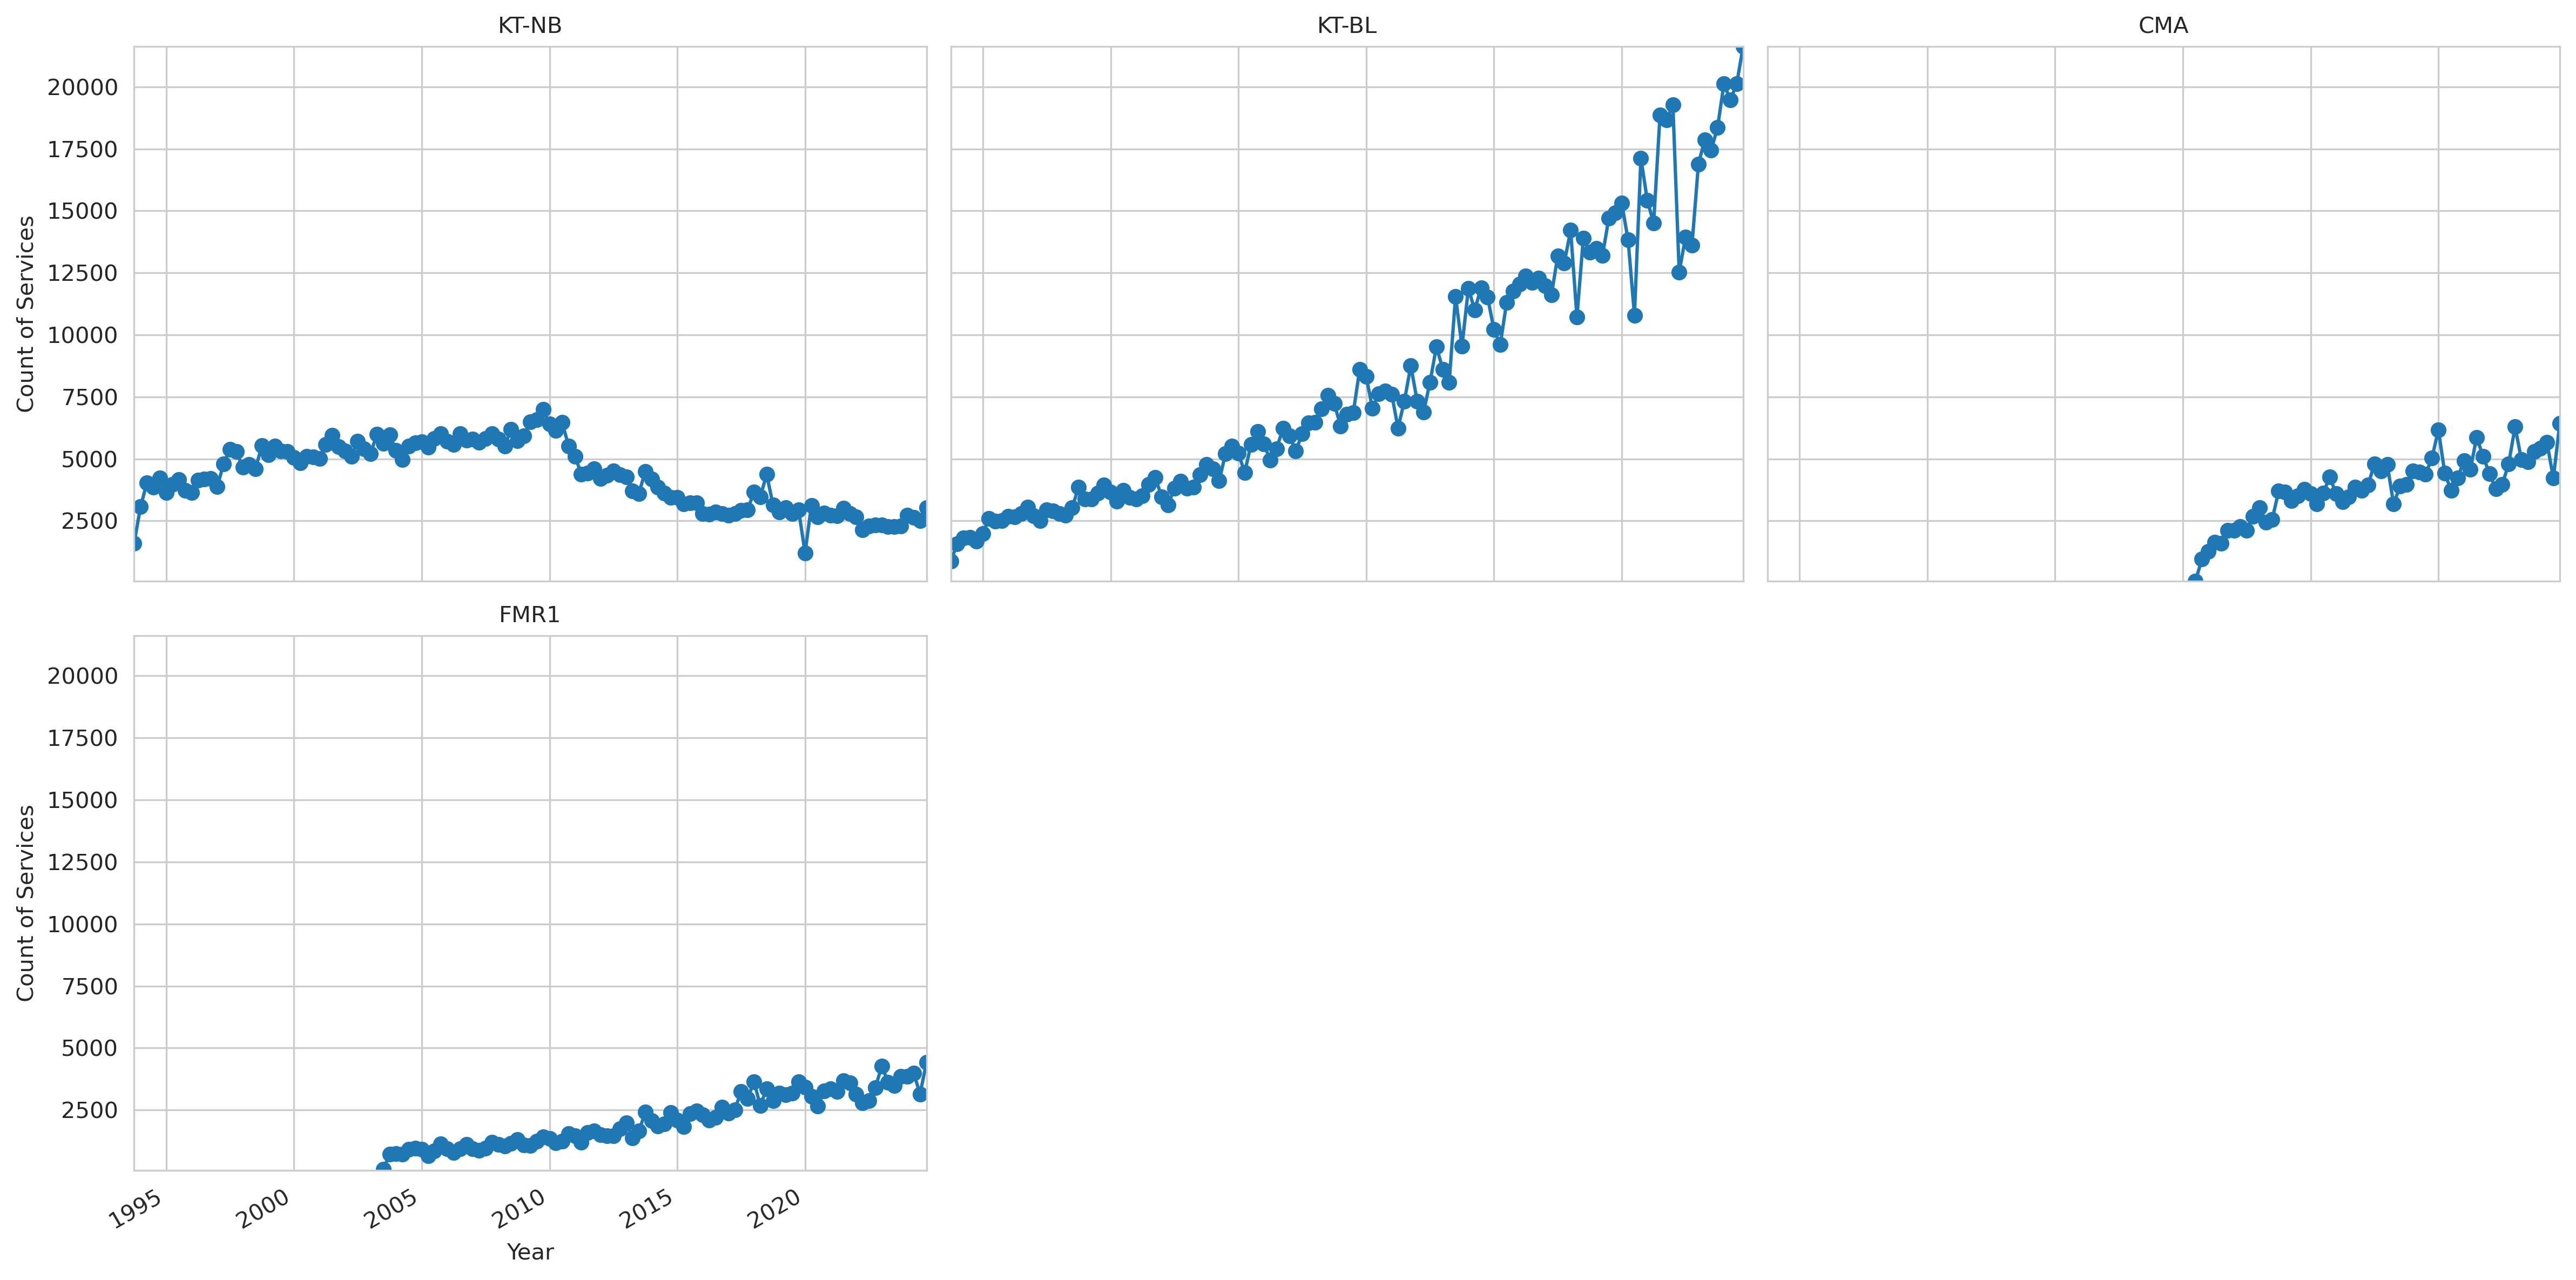

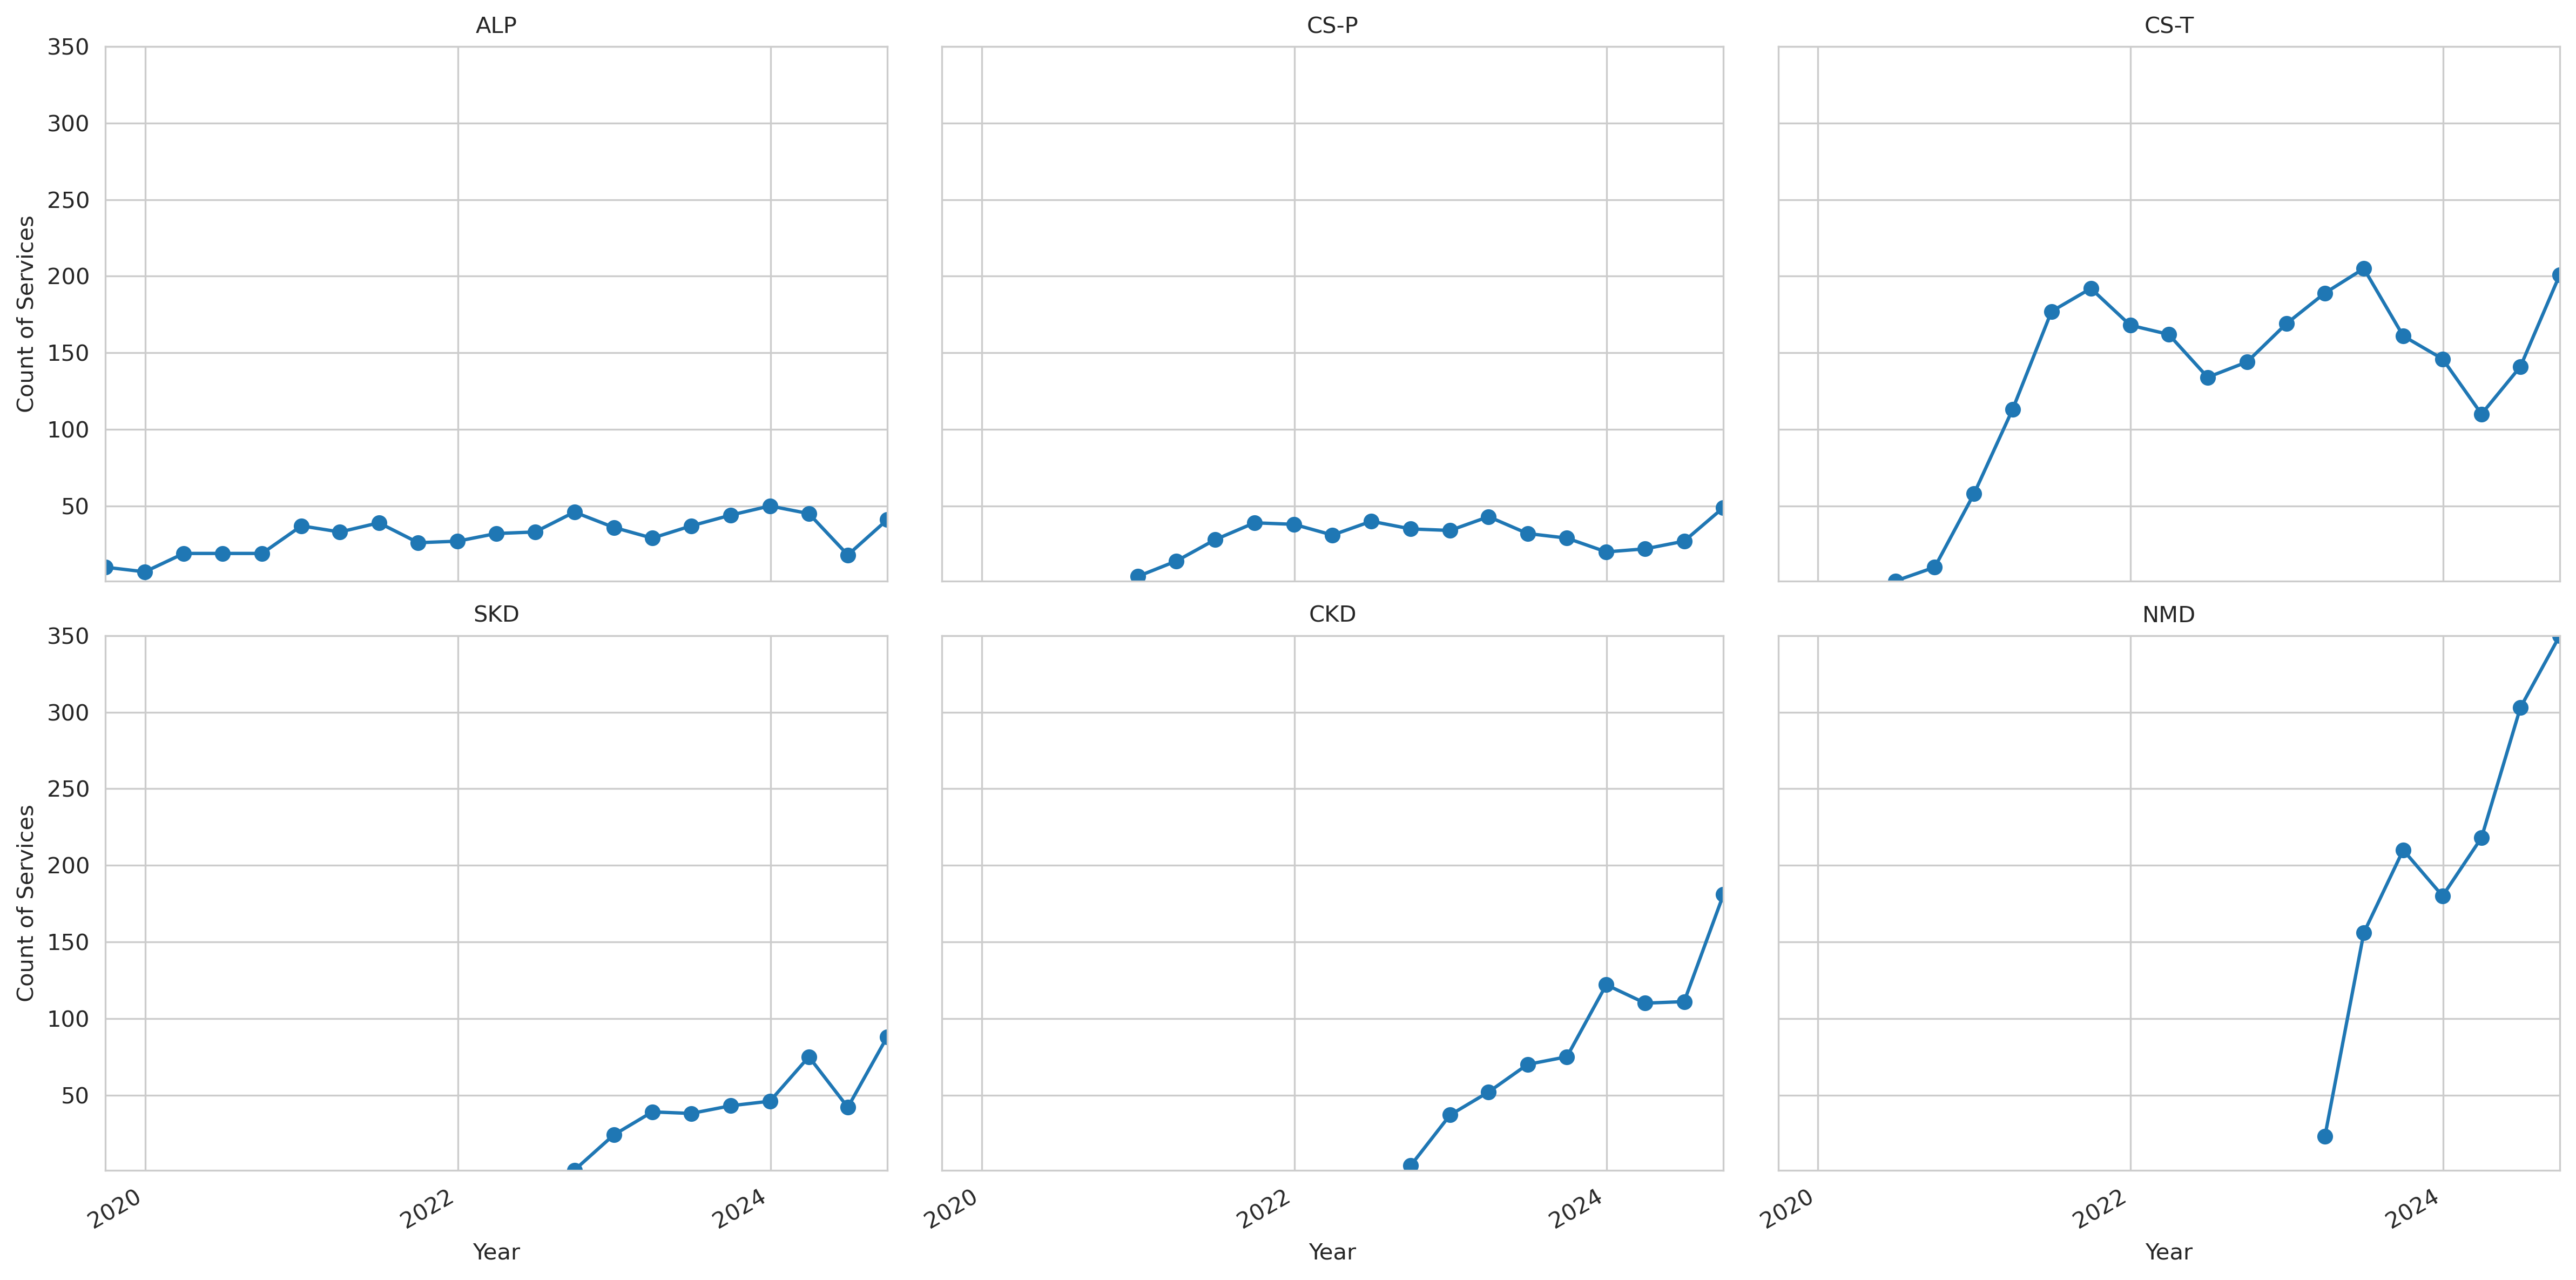

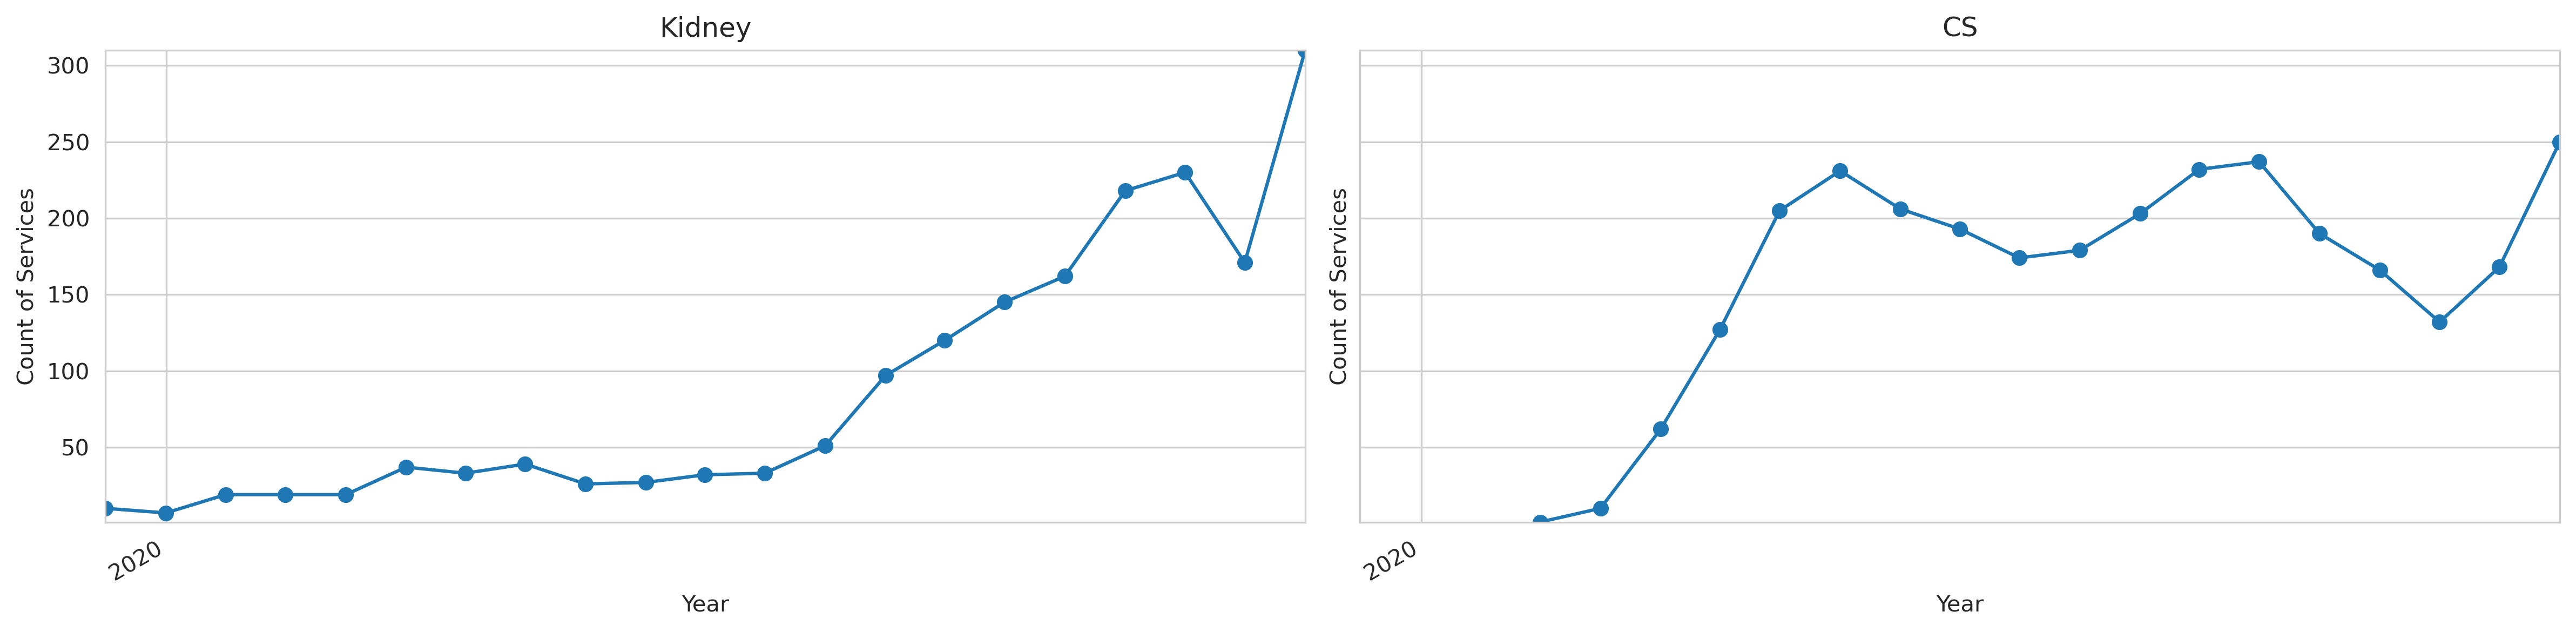

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import math

# Inline plotting for Jupyter
%matplotlib inline

register_matplotlib_converters()

# -- Load and prepare the data --
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Convert Month column to datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only the specific item categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Identify primary and secondary items
primary_items = ['73287', '73289', '73292', '73300']
secondary_items = [item for item in items_to_include if item not in primary_items]

# Aggregate 'Value' by quarter for each item
grouped_data = filtered_data.groupby('Item')['Value'].resample('QE').sum()

# Filter for items that exist in the grouped data
available_primary_items = [item for item in primary_items if item in grouped_data.index.get_level_values('Item')]
available_secondary_items = [item for item in secondary_items if item in grouped_data.index.get_level_values('Item')]

# Define a dictionary to map item IDs to custom titles.
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD',   
}

# Function to create subplots for a given set of items with optional custom titles.
def create_subplots(items, x_range=None, filename=None, title_mapping=None, major_tick_interval=5):
    num_items = len(items)
    cols = 3  # Set to 3 columns
    rows = math.ceil(num_items / cols)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 4 * rows), dpi=300, sharex=True, sharey=True)
    axes = axes.flatten() if num_items > 1 else [axes]

    # Determine overall y-axis limits for consistency
    y_min, y_max = grouped_data.loc[items].min(), grouped_data.loc[items].max()

    for ax, item in zip(axes, items):
        item_data = grouped_data.loc[item]
        title = title_mapping.get(item, f'Item {item}') if title_mapping is not None else f'Item {item}'
        ax.plot(item_data.index, item_data, marker='o', linestyle='-', label=title)
        if x_range:
            ax.set_xlim(x_range)
        ax.set_ylim(y_min, y_max)
        ax.set_title(title, fontsize=10)

    # Hide unused subplots
    for ax in axes[len(items):]:
        ax.axis('off')

    # Configure x-axis and y-axis labels
    for ax in axes[-cols:]:
        ax.set_xlabel('Year', fontsize=10)
    for ax in axes[::cols]:
        ax.set_ylabel('Count of Services', fontsize=10)

    # Configure x-axis ticks
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.YearLocator(base=major_tick_interval))
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 7)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    # Save the figure if a filename is provided
    if filename:
        fig.savefig(filename, format='svg', dpi=300)

# Determine x-axis ranges for primary and secondary items
primary_x_range = (
    grouped_data.loc[available_primary_items].index.get_level_values('Month').min(),
    grouped_data.loc[available_primary_items].index.get_level_values('Month').max(),
)

secondary_x_range = (
    grouped_data.loc[available_secondary_items].index.get_level_values('Month').min(),
    grouped_data.loc[available_secondary_items].index.get_level_values('Month').max(),
)

# Create plots for primary items (5-year interval) and secondary items (2-year interval)
create_subplots(
    available_primary_items,
    x_range=primary_x_range,
    filename="PrimaryAxisItems_3cols.svg",
    title_mapping=custom_titles,
    major_tick_interval=5
)

create_subplots(
    available_secondary_items,
    x_range=secondary_x_range,
    filename="SecondaryAxisItems_3cols.svg",
    title_mapping=custom_titles,
    major_tick_interval=2
)

# -- Combine Kidney and CS groups --
# Define the items for each group.
kidney_items = ['73298', '73401', '73402']
cs_items = ['73358', '73359']

# Aggregate quarterly 'Value' for each group by summing the items.
kidney_grouped = grouped_data.loc[kidney_items].groupby(level='Month').sum()
cs_grouped = grouped_data.loc[cs_items].groupby(level='Month').sum()

# Create a dictionary for the combined groups.
combined_groups = {
    'Kidney': kidney_grouped,
    'CS': cs_grouped
}

# Determine the overall x-axis range from the combined groups.
combined_x_range = (
    min(kidney_grouped.index.min(), cs_grouped.index.min()),
    max(kidney_grouped.index.max(), cs_grouped.index.max())
)

# Function to plot the combined groups
def create_combined_subplots(combined_groups, x_range=None, filename=None, major_tick_interval=5):
    num_groups = len(combined_groups)
    fig, axes = plt.subplots(nrows=1, ncols=num_groups, figsize=(8 * num_groups, 4), dpi=300, sharex=True, sharey=True)
    if num_groups == 1:
        axes = [axes]

    # Determine overall y-axis limits for consistency
    y_min = min(series.min() for series in combined_groups.values())
    y_max = max(series.max() for series in combined_groups.values())

    for ax, (group_name, series) in zip(axes, combined_groups.items()):
        ax.plot(series.index, series, marker='o', linestyle='-', label=group_name)
        if x_range:
            ax.set_xlim(x_range)
        ax.set_ylim(y_min, y_max)
        ax.set_title(group_name, fontsize=12)
        ax.xaxis.set_major_locator(mdates.YearLocator(base=major_tick_interval))
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 7)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.set_xlabel('Year', fontsize=10)
        ax.set_ylabel('Count of Services', fontsize=10)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    # Save the figure if a filename is provided
    if filename:
        fig.savefig(filename, format='svg', dpi=300)

# Create a plot for the combined Kidney and CS groups.
create_combined_subplots(
    combined_groups,
    x_range=combined_x_range,
    filename="CombinedGroups_Kidney_CS.svg",
    major_tick_interval=5
)


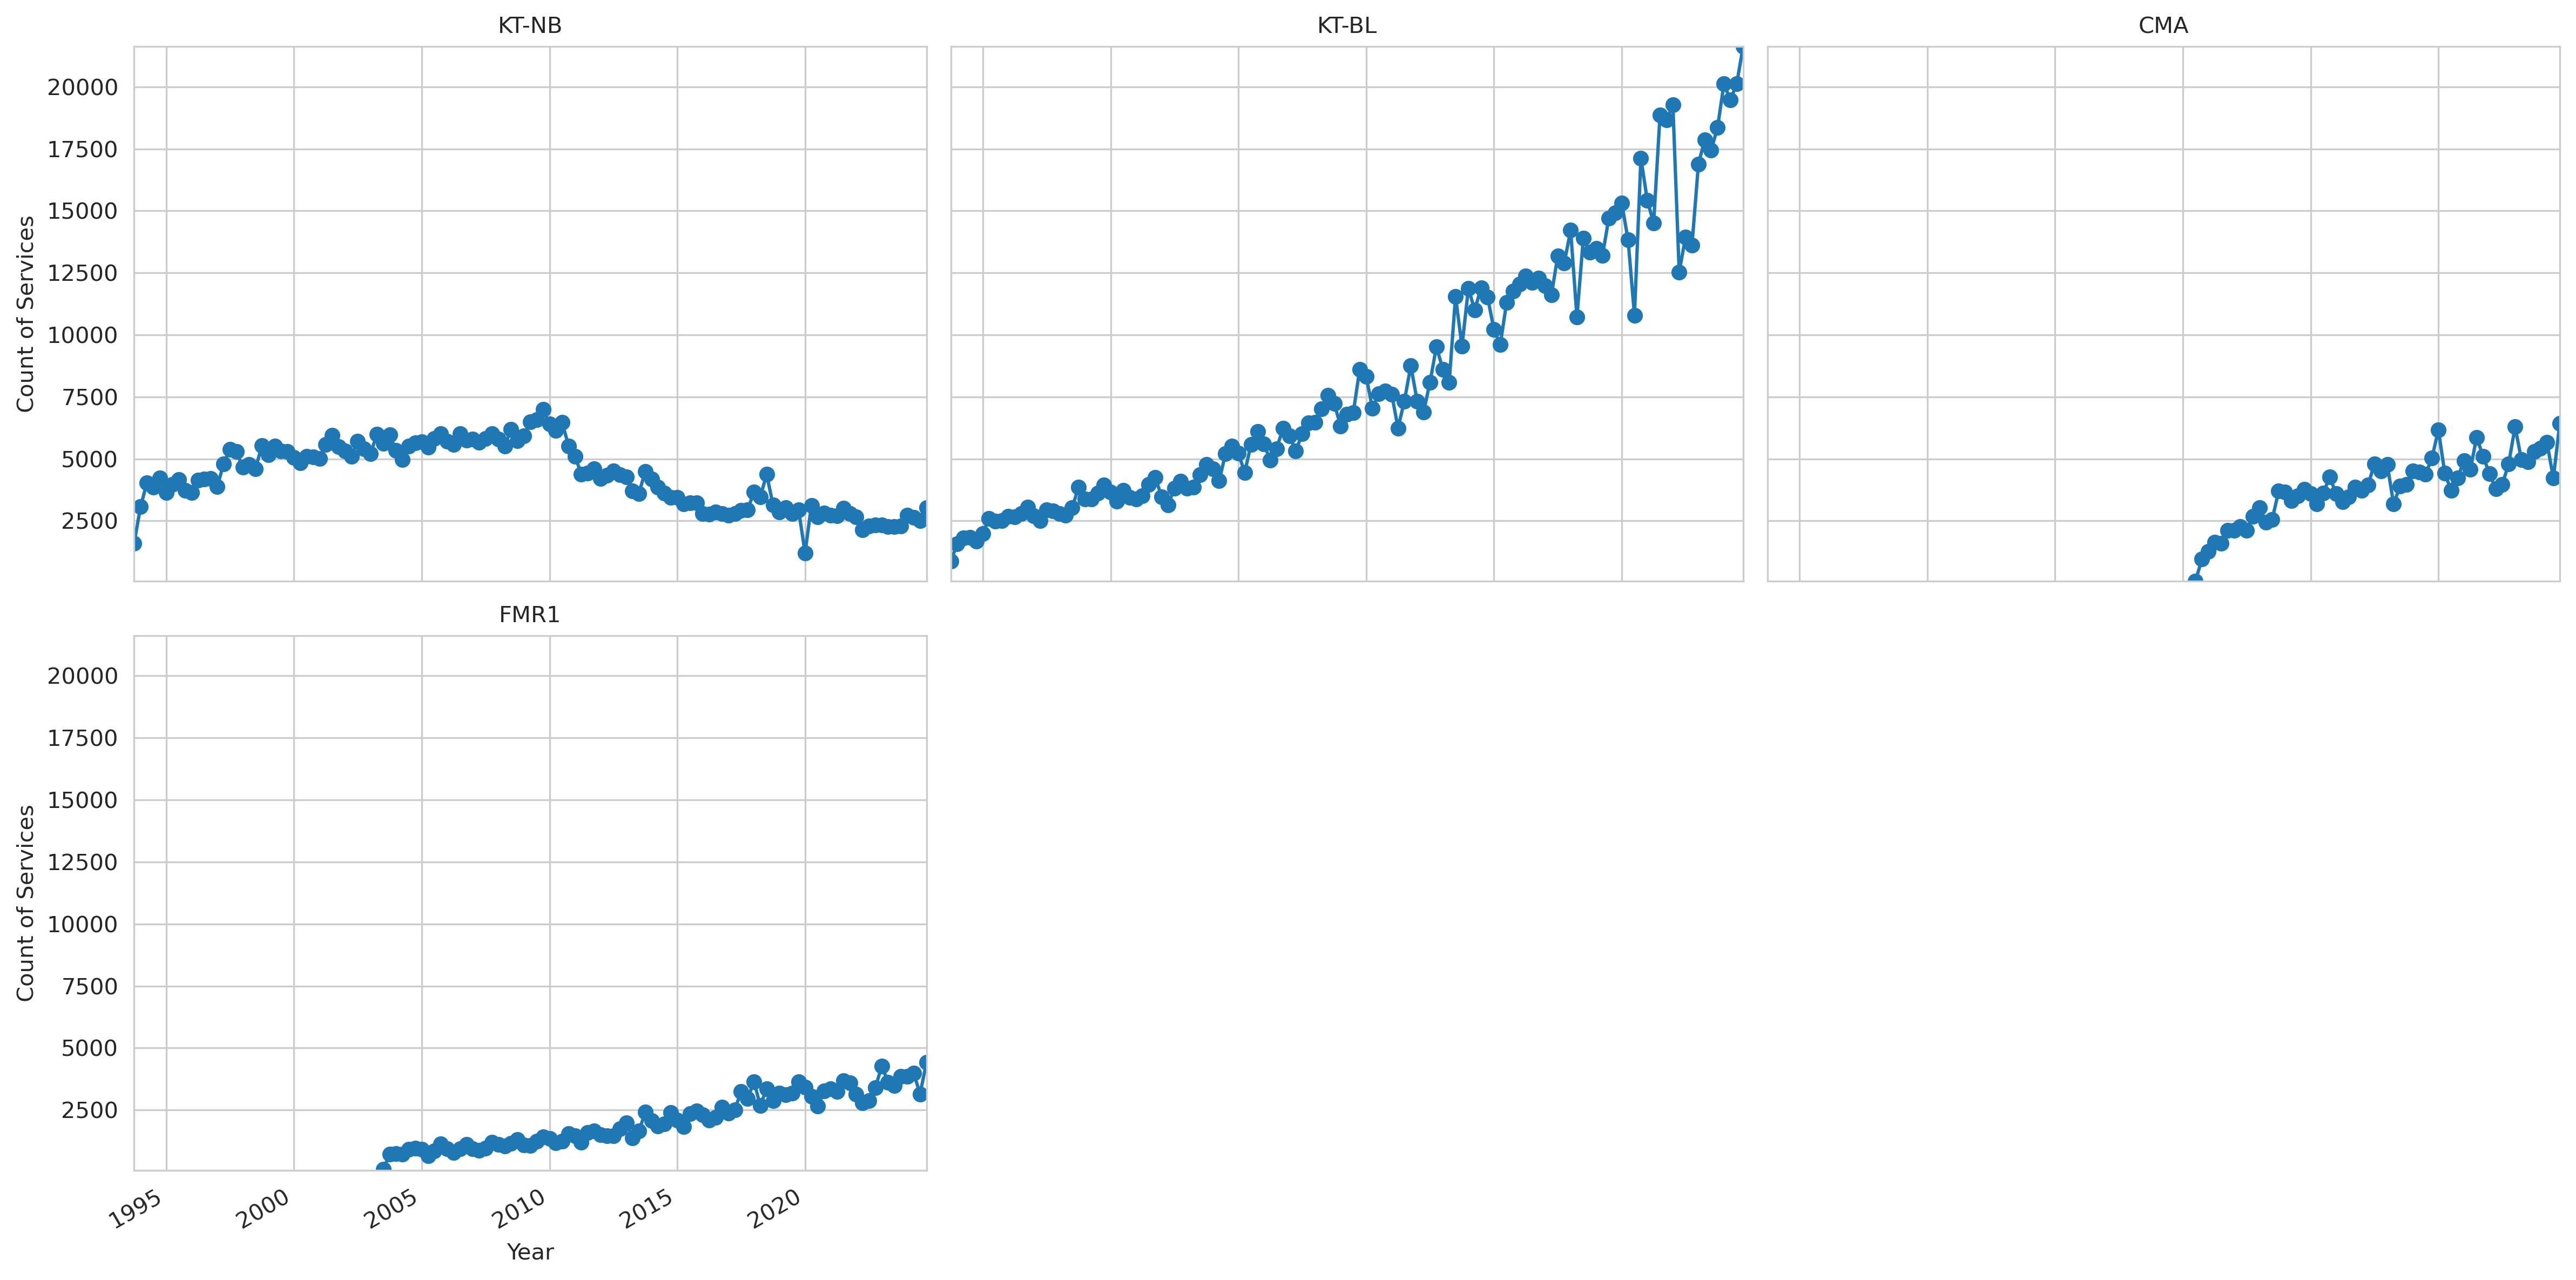

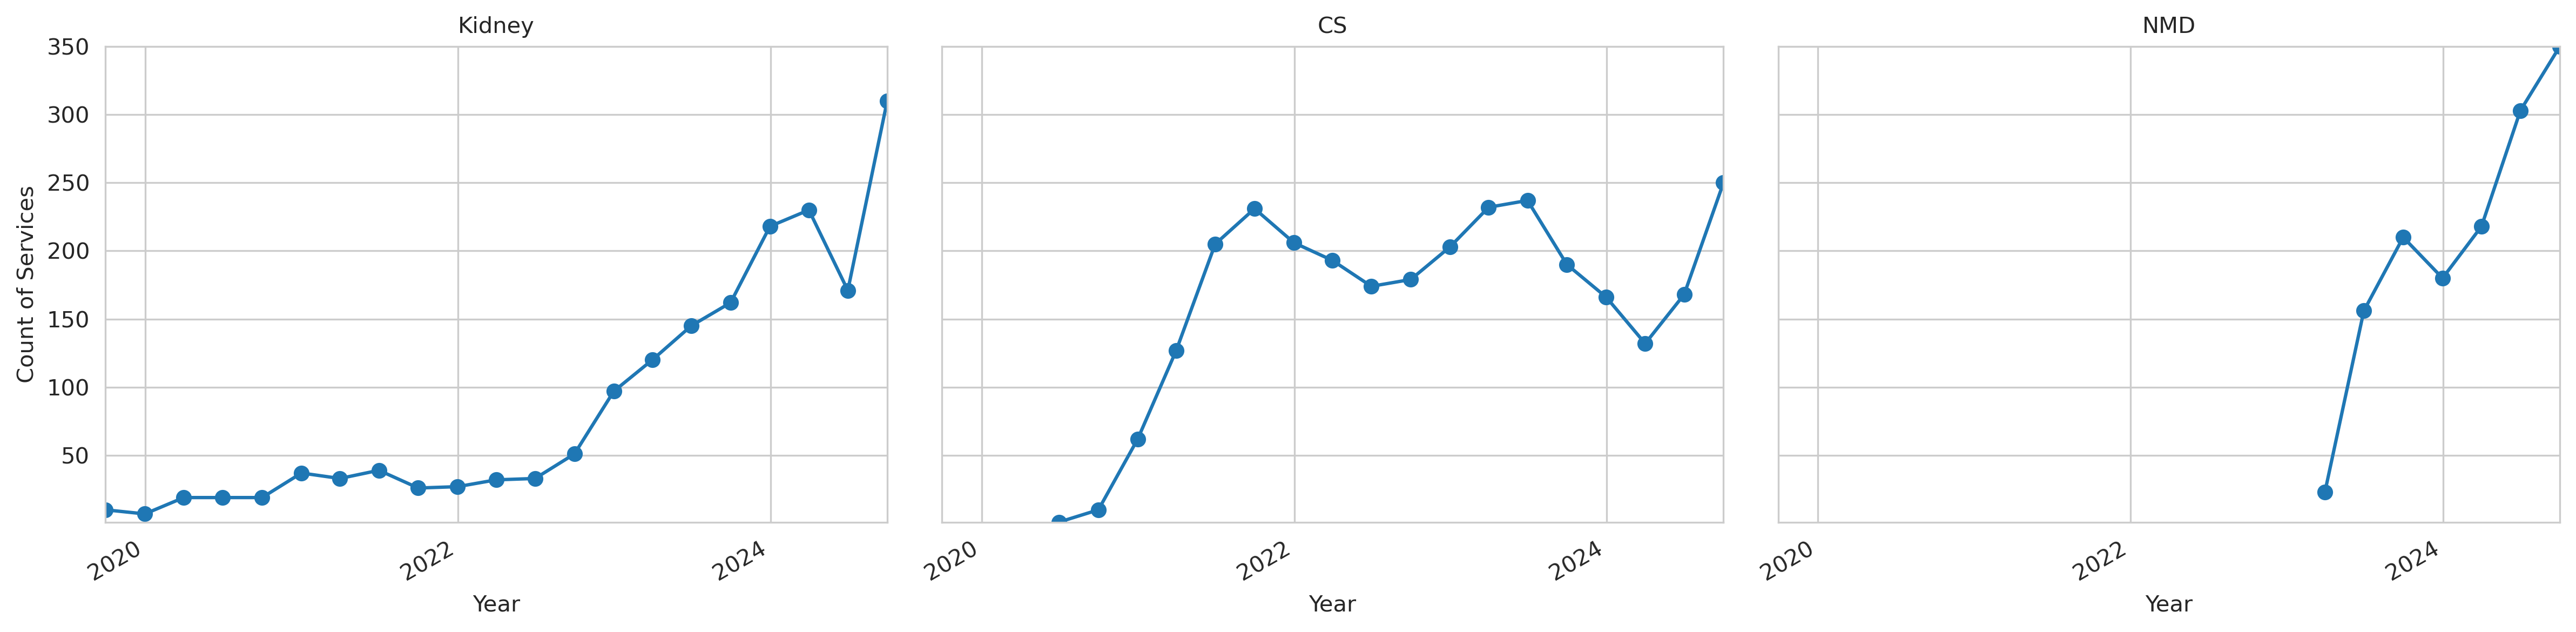

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import math

# Inline plotting for Jupyter
%matplotlib inline

register_matplotlib_converters()

# -- Load and prepare the data --
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Convert Month column to datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only the specific item categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Primary items and items to be grouped
    '73300', '73358', '73359', '73401', '73402',
    '73422'  # NMD, which will remain separate
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Identify primary items (individual items) and secondary items (to be grouped)
primary_items = ['73287', '73289', '73292', '73300']
secondary_items = [item for item in items_to_include if item not in primary_items]

# Aggregate 'Value' by quarter for each item
grouped_data = filtered_data.groupby('Item')['Value'].resample('QE').sum()

# Only keep those primary items that exist in the aggregated data
available_primary_items = [item for item in primary_items if item in grouped_data.index.get_level_values('Item')]

# Define custom titles for primary items
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73300': 'FMR1',
}

# Define secondary groupings for Kidney and CS:
# - Kidney combines items: "73298", "73401", and "73402"
# - CS combines items: "73358" and "73359"
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359']
}

# Aggregate secondary groups by summing their values (for each quarter)
grouped_secondary_groups = pd.DataFrame()
for group_name, codes in group_definitions.items():
    available_codes = [code for code in codes if code in grouped_data.index.get_level_values('Item')]
    if available_codes:
        group_series = grouped_data.loc[available_codes].groupby(level='Month').sum()
        grouped_secondary_groups[group_name] = group_series

# Include the separate NMD item (code '73422') as its own series.
if '73422' in grouped_data.index.get_level_values('Item'):
    nmd_series = grouped_data.loc['73422']
    nmd_series = nmd_series.groupby(level='Month').sum()
    grouped_secondary_groups['NMD'] = nmd_series

# Create a unified plotting function that works with either the multi-indexed Series (grouped_data)
# or a DataFrame (for the aggregated groups)
def create_subplots(items, data_source, x_range=None, filename=None, title_mapping=None, major_tick_interval=5):
    num_items = len(items)
    cols = 3  # Set to 3 columns
    rows = math.ceil(num_items / cols)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 4 * rows), dpi=300, sharex=True, sharey=True)
    axes = axes.flatten() if num_items > 1 else [axes]

    # Determine overall y-axis limits for consistency
    if isinstance(data_source, pd.DataFrame):
        y_min = data_source[items].min().min()
        y_max = data_source[items].max().max()
    else:
        y_min = data_source.loc[items].min()
        y_max = data_source.loc[items].max()

    for ax, item in zip(axes, items):
        if isinstance(data_source, pd.DataFrame):
            item_data = data_source[item]
        else:
            item_data = data_source.loc[item]
        title = title_mapping.get(item, item) if title_mapping is not None else item
        ax.plot(item_data.index, item_data, marker='o', linestyle='-', label=title)
        if x_range:
            ax.set_xlim(x_range)
        ax.set_ylim(y_min, y_max)
        ax.set_title(title, fontsize=10)

    # Hide any unused subplots
    for ax in axes[len(items):]:
        ax.axis('off')

    # Configure axis labels
    for ax in axes[-cols:]:
        ax.set_xlabel('Year', fontsize=10)
    for ax in axes[::cols]:
        ax.set_ylabel('Count of Services', fontsize=10)

    # Configure x-axis ticks and format
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.YearLocator(base=major_tick_interval))
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 7)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    if filename:
        fig.savefig(filename, format='svg', dpi=300)

# Determine x-axis ranges for primary and secondary items
primary_x_range = (
    grouped_data.loc[available_primary_items].index.get_level_values('Month').min(),
    grouped_data.loc[available_primary_items].index.get_level_values('Month').max(),
)
secondary_x_range = (
    grouped_secondary_groups.index.min(),
    grouped_secondary_groups.index.max(),
)

# Plot primary items (individual items)
create_subplots(
    available_primary_items,
    data_source=grouped_data,
    x_range=primary_x_range,
    filename="PrimaryAxisItems_3cols.svg",
    title_mapping=custom_titles,
    major_tick_interval=5
)

# Plot secondary items (aggregated groups + separate NMD)
create_subplots(
    list(grouped_secondary_groups.columns),
    data_source=grouped_secondary_groups,
    x_range=secondary_x_range,
    filename="SecondaryAxisGroups_3cols.svg",
    title_mapping=None,  # Column names ("Kidney", "CS", "NMD") will be used as titles
    major_tick_interval=2
)


/tmp/ipykernel_952/608598251.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_items)


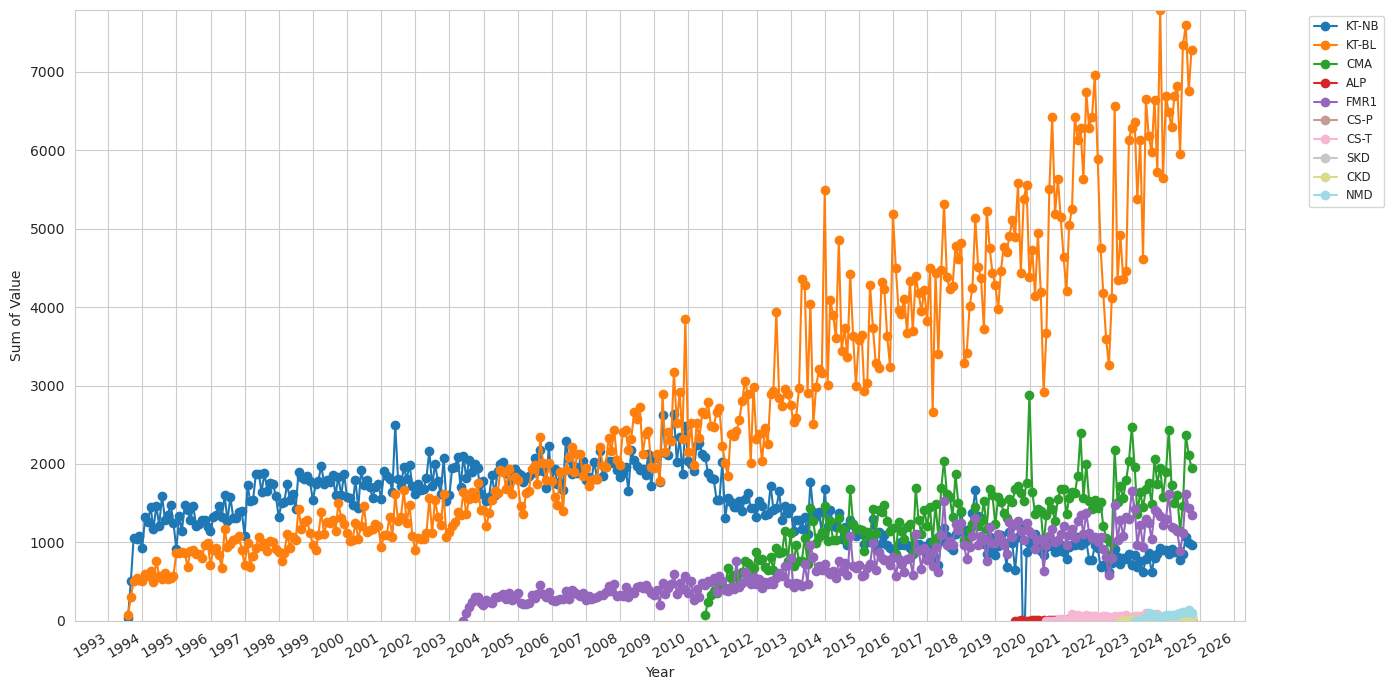

Plot saved as: MonthlySum_SelectedItems.svg


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Load the data
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Ensure no extra spaces here
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Define a dictionary to map item IDs to custom titles.
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
    # Add more mappings if needed.
}

# Calculate the global y-axis maximum based on the highest peak after resampling
y_max = filtered_data.groupby('Item')['Value'].resample('ME').sum().max()
y_min = 0  # Assuming y-axis starts at 0 for better comparison

# Create a figure for plotting
plt.figure(figsize=(14, 7))

# Create a colormap with distinct colours (using 'tab20' for up to 20 distinct colours)
num_items = len(items_to_include)
colors = plt.cm.get_cmap('tab20', num_items)

# Plot each item using its custom label (if defined) and assign a distinct colour
for idx, item in enumerate(items_to_include):
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum()
    # Use the custom title if available; otherwise, default to "Item: {item}"
    label = custom_titles.get(item, f'Item: {item}')
    plt.plot(item_data.index, item_data, marker='o', linestyle='-', color=colors(idx), label=label)

# Set axis labels and limits
plt.xlabel('Year')
plt.ylabel('Sum of Value')
plt.ylim([y_min, y_max])

# Set x-axis major locator to every year and minor locator to every quarter
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Improve the display of x-axis labels
plt.gcf().autofmt_xdate()

# Place the legend outside the plot area for clarity
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')

# Tight layout to avoid clipping
plt.tight_layout()

# Save the figure as an SVG file for publication-quality output
output_file = "MonthlySum_SelectedItems.svg"
plt.savefig(output_file, format='svg', dpi=300)

# Display the plot
plt.show()

print(f"Plot saved as: {output_file}")


/tmp/ipykernel_952/671774014.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Group'] = filtered_data['Item'].apply(assign_group)
/tmp/ipykernel_952/671774014.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_groups)


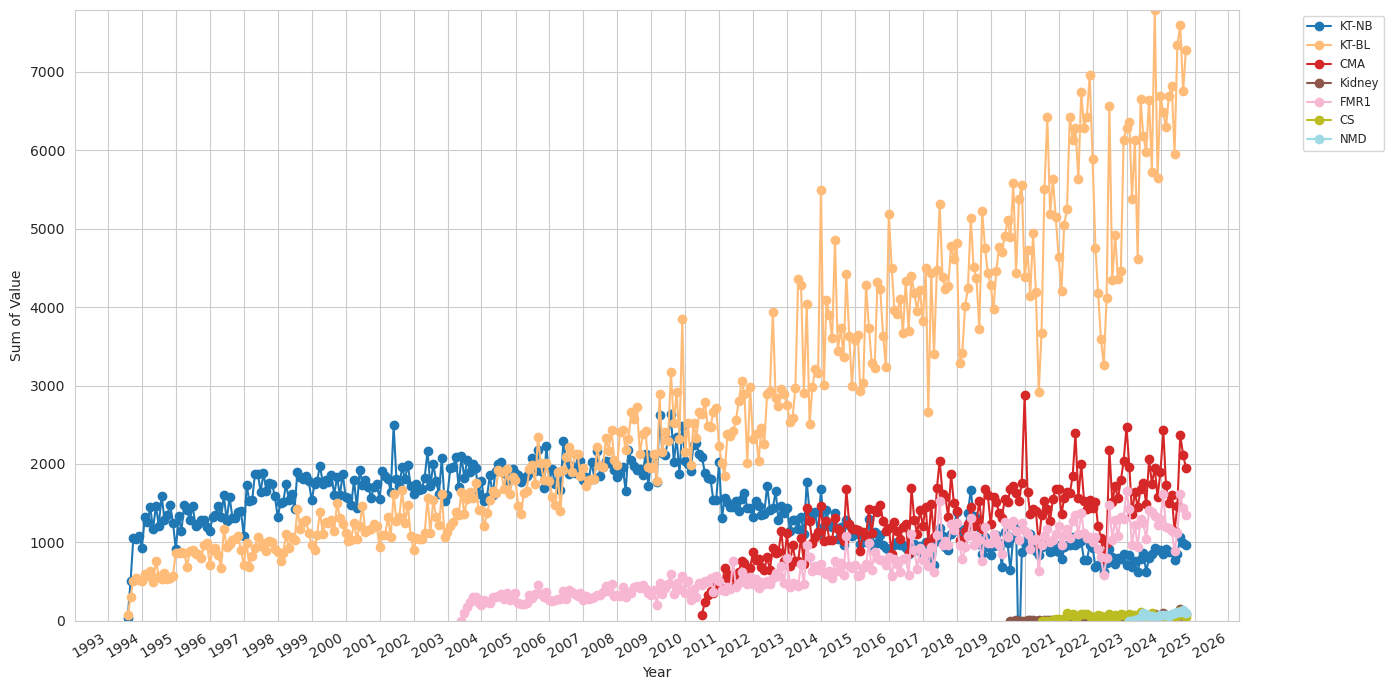

Plot saved as: MonthlySum_SelectedItems.svg


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Load the data
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories
items_to_include = [
    '73287', '73289', '73292', '73298',  # Kidney group member
    '73300', '73358', '73359',            # CS group members
    '73401', '73402',                    # Kidney group members
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Define group mappings:
# Kidney group includes: 73298, 73401, 73402
# CS group includes: 73358, 73359
group_mapping = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359']
}

# Function to assign a group if the item is in one; otherwise, return the original item.
def assign_group(item):
    for group, items in group_mapping.items():
        if item in items:
            return group
    return item

# Create a new column 'Group' based on the mapping.
filtered_data['Group'] = filtered_data['Item'].apply(assign_group)

# Group the data by the new 'Group' column and resample by month-end.
grouped_data = filtered_data.groupby('Group').resample('ME')['Value'].sum()

# Calculate global y-axis maximum for setting plot limits.
y_max = grouped_data.max()
y_min = 0  # Assuming y-axis starts at 0

# Create a figure for plotting
plt.figure(figsize=(14, 7))

# Use the unique groups for the legend and plotting colours.
unique_groups = filtered_data['Group'].unique()
num_groups = len(unique_groups)
colors = plt.cm.get_cmap('tab20', num_groups)

# Optional: Map individual item codes to custom titles (for those not in a group).
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73300': 'FMR1',
    '73422': 'NMD'
}
# For groups, we'll simply use the group name (Kidney, CS).

# Plot each group's time series
for idx, group in enumerate(unique_groups):
    # Extract the time series data for the group.
    group_series = grouped_data.loc[group]
    # Use custom title if available, else default to the group name.
    label = custom_titles.get(group, group)
    plt.plot(group_series.index, group_series, marker='o', linestyle='-', color=colors(idx), label=label)

# Set axis labels and limits
plt.xlabel('Year')
plt.ylabel('Sum of Value')
plt.ylim([y_min, y_max])

# Format the x-axis ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Improve the display of x-axis labels
plt.gcf().autofmt_xdate()

# Place the legend outside the plot area for clarity
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')

# Tight layout to avoid clipping
plt.tight_layout()

# Save the figure as an SVG file for publication-quality output
output_file = "MonthlySum_SelectedItems.svg"
plt.savefig(output_file, format='svg', dpi=300)

# Display the plot
plt.show()

print(f"Plot saved as: {output_file}")


/tmp/ipykernel_952/2285771288.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Group'] = filtered_data['Item'].apply(assign_group)
/tmp/ipykernel_952/2285771288.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_groups)


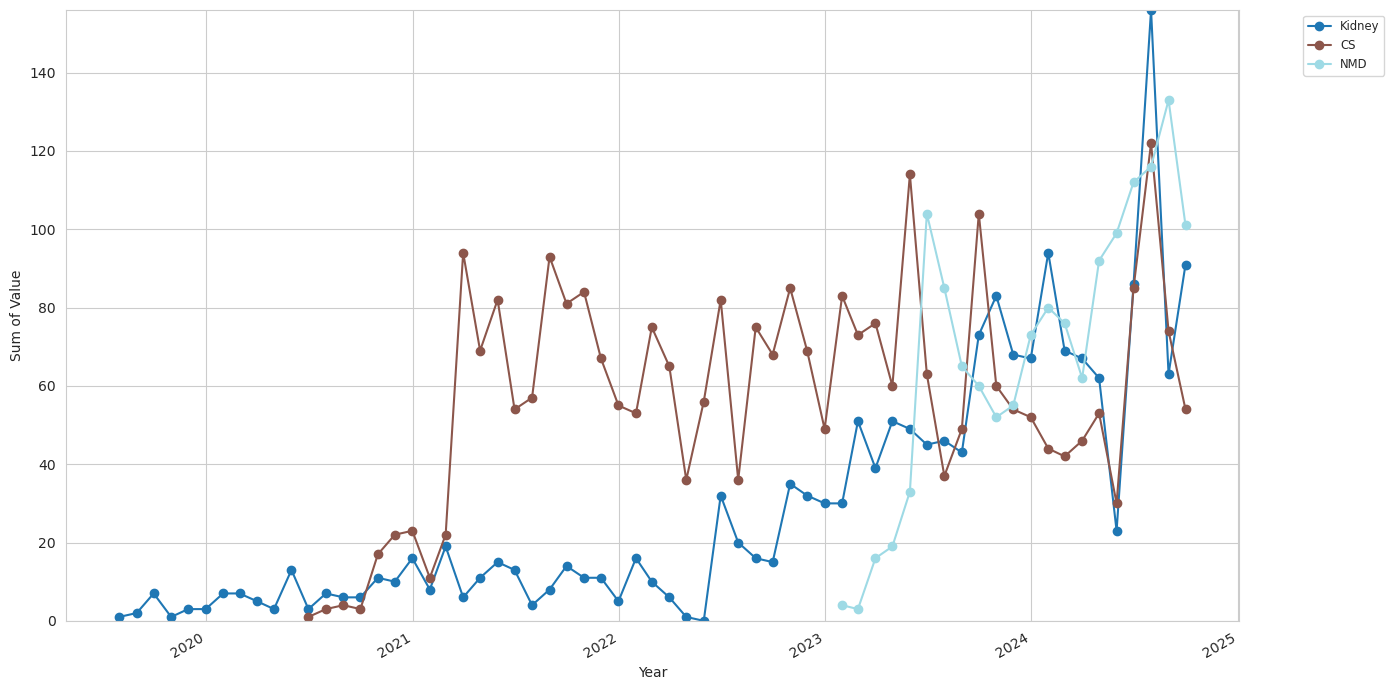

Plot saved as: MonthlySum_SelectedItems.svg


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Load the data
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define the items to include, dropping:
# KT-NB (73287), KT-BL (73289), CMA (73292) and FMR1 (73300)
items_to_include = [
    '73298',   # Kidney group member
    '73358', '73359',  # CS group members
    '73401', '73402',  # Kidney group members
    '73422'    # NMD (individual item)
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Define group mappings:
# Kidney group includes: 73298, 73401, 73402
# CS group includes: 73358, 73359
group_mapping = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359']
}

# Function to assign a group if the item is in one; otherwise, return the original item.
def assign_group(item):
    for group, items in group_mapping.items():
        if item in items:
            return group
    return item

# Create a new column 'Group' based on the mapping.
filtered_data['Group'] = filtered_data['Item'].apply(assign_group)

# Group the data by the new 'Group' column and resample by month-end.
grouped_data = filtered_data.groupby('Group').resample('ME')['Value'].sum()

# Calculate global y-axis maximum for setting plot limits.
y_max = grouped_data.max()
y_min = 0  # Assuming y-axis starts at 0

# Create a figure for plotting
plt.figure(figsize=(14, 7))

# Use the unique groups for the legend and plotting colours.
unique_groups = filtered_data['Group'].unique()
num_groups = len(unique_groups)
colors = plt.cm.get_cmap('tab20', num_groups)

# Optional: Map individual item codes to custom titles (for items not aggregated in a group).
custom_titles = {
    '73422': 'NMD'
}
# For groups, we'll simply use the group name (Kidney, CS).

# Plot each group's time series
for idx, group in enumerate(unique_groups):
    # Extract the time series data for the group.
    group_series = grouped_data.loc[group]
    # Use custom title if available; otherwise, default to the group name.
    label = custom_titles.get(group, group)
    plt.plot(group_series.index, group_series, marker='o', linestyle='-', color=colors(idx), label=label)

# Set axis labels and limits
plt.xlabel('Year')
plt.ylabel('Sum of Value')
plt.ylim([y_min, y_max])

# Format the x-axis ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Improve the display of x-axis labels
plt.gcf().autofmt_xdate()

# Place the legend outside the plot area for clarity
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')

# Tight layout to avoid clipping
plt.tight_layout()

# Save the figure as an SVG file for publication-quality output
output_file = "MonthlySum_SelectedItems.svg"
plt.savefig(output_file, format='svg', dpi=300)

# Display the plot
plt.show()

print(f"Plot saved as: {output_file}")


/tmp/ipykernel_952/3631340930.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Group'] = filtered_data['Item'].apply(assign_group)
/tmp/ipykernel_952/3631340930.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_groups)


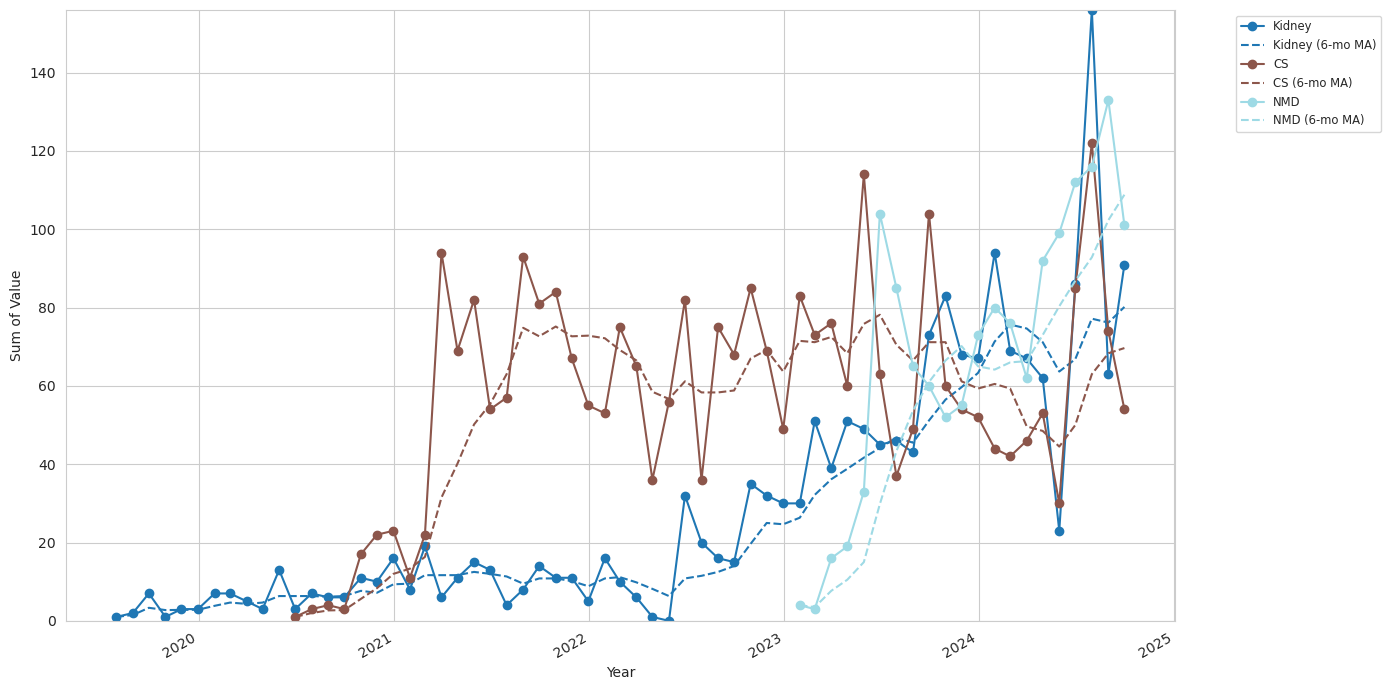

Plot saved as: MonthlySum_SelectedItems.svg


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Load the data
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define the items to include, dropping:
# KT-NB (73287), KT-BL (73289), CMA (73292) and FMR1 (73300)
items_to_include = [
    '73298',   # Kidney group member
    '73358', '73359',  # CS group members
    '73401', '73402',  # Kidney group members
    '73422'    # NMD (individual item)
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Define group mappings:
# Kidney group includes: 73298, 73401, 73402
# CS group includes: 73358, 73359
group_mapping = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359']
}

# Function to assign a group if the item is in one; otherwise, return the original item.
def assign_group(item):
    for group, items in group_mapping.items():
        if item in items:
            return group
    return item

# Create a new column 'Group' based on the mapping.
filtered_data['Group'] = filtered_data['Item'].apply(assign_group)

# Group the data by the new 'Group' column and resample by month-end.
grouped_data = filtered_data.groupby('Group').resample('ME')['Value'].sum()

# Calculate global y-axis maximum for setting plot limits.
y_max = grouped_data.max()
y_min = 0  # Assuming y-axis starts at 0

# Create a figure for plotting
plt.figure(figsize=(14, 7))

# Use the unique groups for the legend and plotting colours.
unique_groups = filtered_data['Group'].unique()
num_groups = len(unique_groups)
colors = plt.cm.get_cmap('tab20', num_groups)

# Optional: Map individual item codes to custom titles (for items not aggregated in a group).
custom_titles = {
    '73422': 'NMD'
}
# For groups, we'll simply use the group name (Kidney, CS).

# Plot each group's time series along with its 6-month moving average.
for idx, group in enumerate(unique_groups):
    # Extract the time series data for the group.
    group_series = grouped_data.loc[group]
    
    # Compute the 6-month moving average (using min_periods=1 to handle early months).
    group_series_ma = group_series.rolling(window=6, min_periods=1).mean()
    
    # Use custom title if available; otherwise, default to the group name.
    label = custom_titles.get(group, group)
    
    # Plot the original time series with solid lines.
    plt.plot(group_series.index, group_series, marker='o', linestyle='-', color=colors(idx), label=label)
    
    # Overlay the 6-month moving average with a dashed line.
    plt.plot(group_series_ma.index, group_series_ma, linestyle='--', color=colors(idx), label=f"{label} (6-mo MA)")

# Set axis labels and limits
plt.xlabel('Year')
plt.ylabel('Sum of Value')
plt.ylim([y_min, y_max])

# Format the x-axis ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Improve the display of x-axis labels
plt.gcf().autofmt_xdate()

# Place the legend outside the plot area for clarity
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')

# Tight layout to avoid clipping
plt.tight_layout()

# Save the figure as an SVG file for publication-quality output
output_file = "MonthlySum_SelectedItems.svg"
plt.savefig(output_file, format='svg', dpi=300)

# Display the plot
plt.show()

print(f"Plot saved as: {output_file}")


/tmp/ipykernel_952/2463290825.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Group'] = filtered_data['Item'].apply(assign_group)
/tmp/ipykernel_952/2463290825.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_groups)


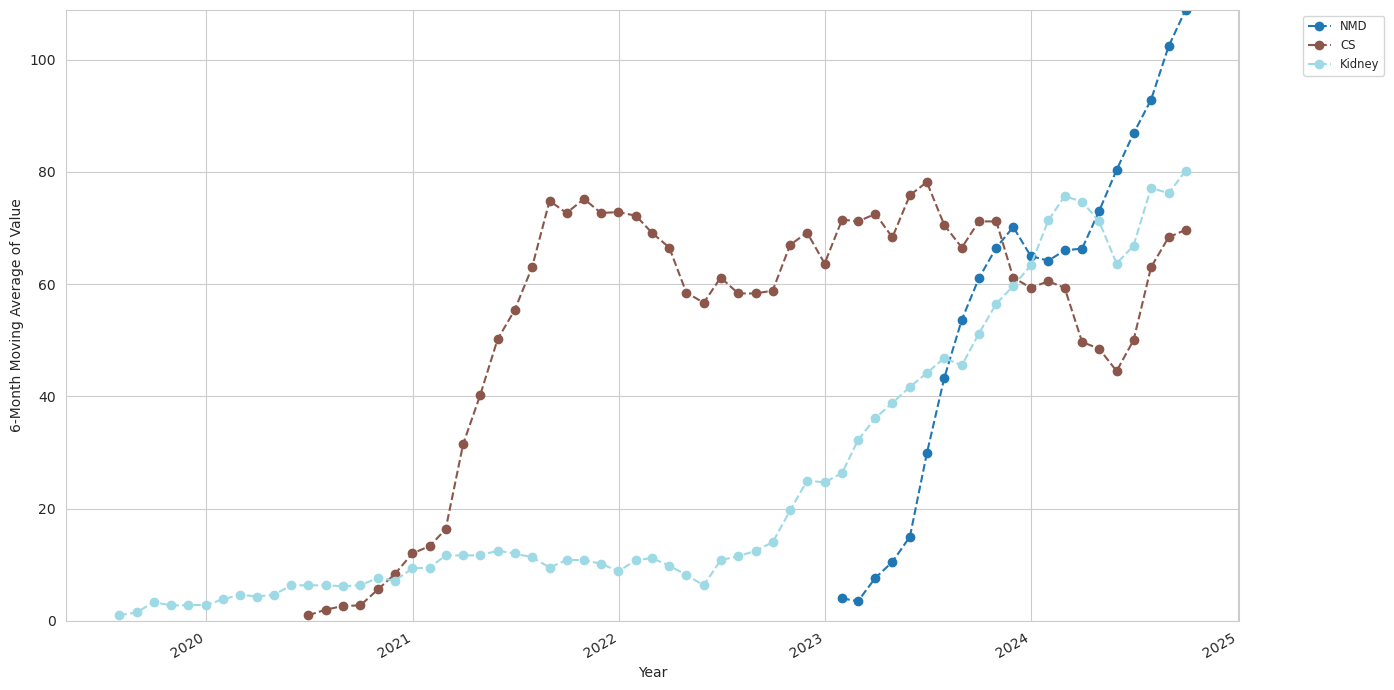

Plot saved as: MonthlySum_MA_SelectedItems.svg


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Load the data
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define the items to include, dropping KT-NB (73287), KT-BL (73289), CMA (73292) and FMR1 (73300)
items_to_include = [
    '73298',   # Kidney group member
    '73358', '73359',  # CS group members
    '73401', '73402',  # Kidney group members
    '73422'    # NMD (individual item)
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Define group mappings:
# Kidney group includes: 73298, 73401, 73402
# CS group includes: 73358, 73359
group_mapping = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359']
}

# Function to assign a group if the item is in one; otherwise, return the original item.
def assign_group(item):
    for group, items in group_mapping.items():
        if item in items:
            return group
    return item

# Create a new column 'Group' based on the mapping.
filtered_data['Group'] = filtered_data['Item'].apply(assign_group)

# Group the data by the new 'Group' column and resample by month-end.
grouped_data = filtered_data.groupby('Group').resample('ME')['Value'].sum()

# Compute a 6-month moving average for each group.
ma_dict = {}
for group in grouped_data.index.get_level_values(0).unique():
    group_series = grouped_data.loc[group]
    # Compute the moving average with a window of 6 months (min_periods=1 ensures early months are included)
    ma_series = group_series.rolling(window=6, min_periods=1).mean()
    ma_dict[group] = ma_series

# Determine the global y-axis limits based on the moving average values.
y_max = max(series.max() for series in ma_dict.values())
y_min = 0  # Assuming y-axis starts at 0

# Create the plot for the moving average only.
plt.figure(figsize=(14, 7))

unique_groups = list(ma_dict.keys())
num_groups = len(unique_groups)
colors = plt.cm.get_cmap('tab20', num_groups)

# Optional: custom titles for ungrouped items
custom_titles = {
    '73422': 'NMD'
}

for idx, group in enumerate(unique_groups):
    ma_series = ma_dict[group]
    label = custom_titles.get(group, group)
    plt.plot(ma_series.index, ma_series, marker='o', linestyle='--', color=colors(idx), label=label)

plt.xlabel('Year')
plt.ylabel('6-Month Moving Average of Value')
plt.ylim([y_min, y_max])

# Format the x-axis ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

# Place the legend outside the plot area for clarity
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')

plt.tight_layout()

# Save the figure as an SVG file for publication-quality output
output_file = "MonthlySum_MA_SelectedItems.svg"
plt.savefig(output_file, format='svg', dpi=300)
plt.show()

print(f"Plot saved as: {output_file}")


/tmp/ipykernel_952/2643980871.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Item'] = filtered_data['Item'].apply(


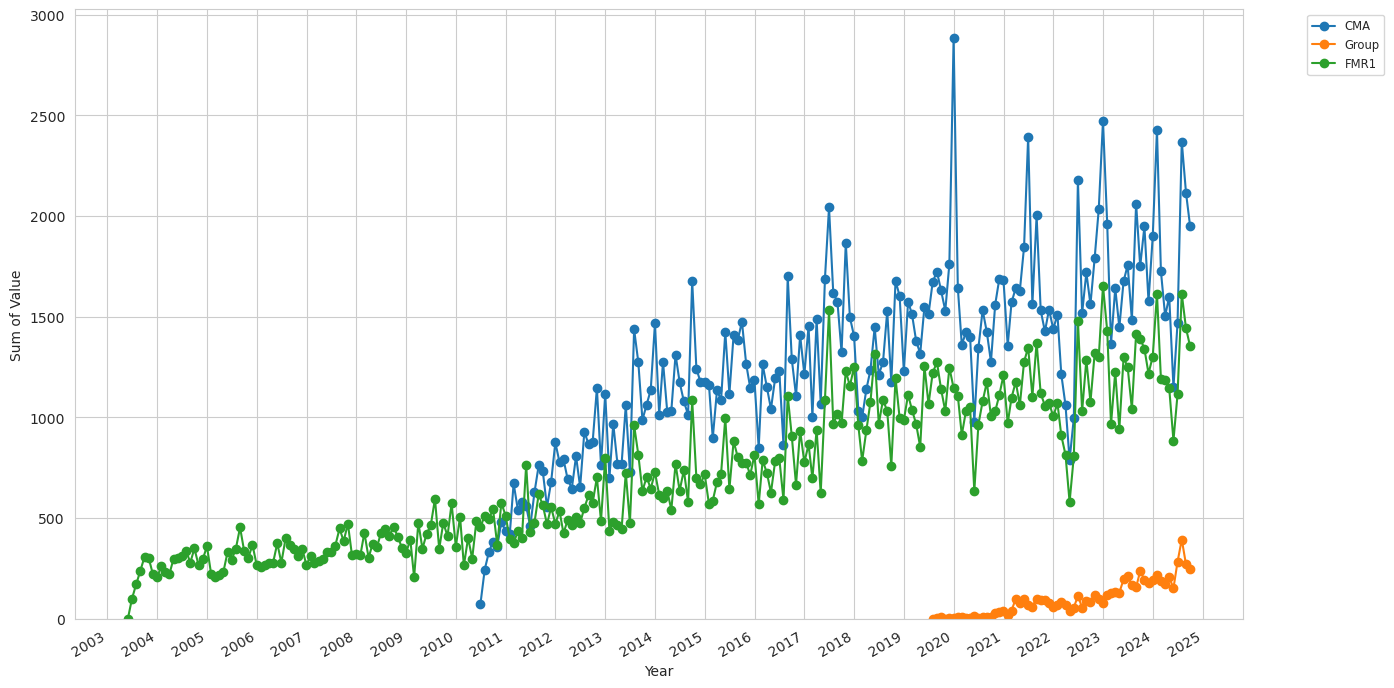

Plot saved as: MonthlySum_GroupedItems.svg


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Load the data
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Convert the "Value" column to absolute values
data['Value'] = data['Value'].abs()

# Filter the data to include only specific "Item" categories,
# excluding KT-NB ('73287') and KT-BL ('73289')
items_to_include = [
    '73292', '73298', '73300', '73358', '73359', '73401', '73402', '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Define a dictionary to map item IDs to custom titles.
custom_titles = {
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
}

# For the purpose of the plot we wish to display only a select few items individually.
# Items not in the list below will be grouped under "Group".
items_to_keep = ['73292', '73300']

# Update the "Item" column: use the custom title for items to keep and set the others to "Group".
filtered_data['Item'] = filtered_data['Item'].apply(
    lambda x: custom_titles[x] if x in items_to_keep else 'Group'
)

# Plotting all items (and the group) on the same plot
plt.figure(figsize=(14, 7))

# Loop through each unique item label in the filtered data
for item in filtered_data['Item'].unique():
    # Resample by month-end and sum the "Value" column
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum()
    plt.plot(item_data.index, item_data, marker='o', linestyle='-', label=item)

# Set labels and format the x-axis
plt.xlabel('Year')
plt.ylabel('Sum of Value')
plt.ylim(bottom=0)

# Major ticks every year; minor ticks at January, April, July, October
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.gcf().autofmt_xdate()  # Auto-format date labels

# Place legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
plt.tight_layout()

# Save the figure as an SVG file
output_file = "MonthlySum_GroupedItems.svg"
plt.savefig(output_file, format='svg', dpi=300)
plt.show()

print(f"Plot saved as: {output_file}")


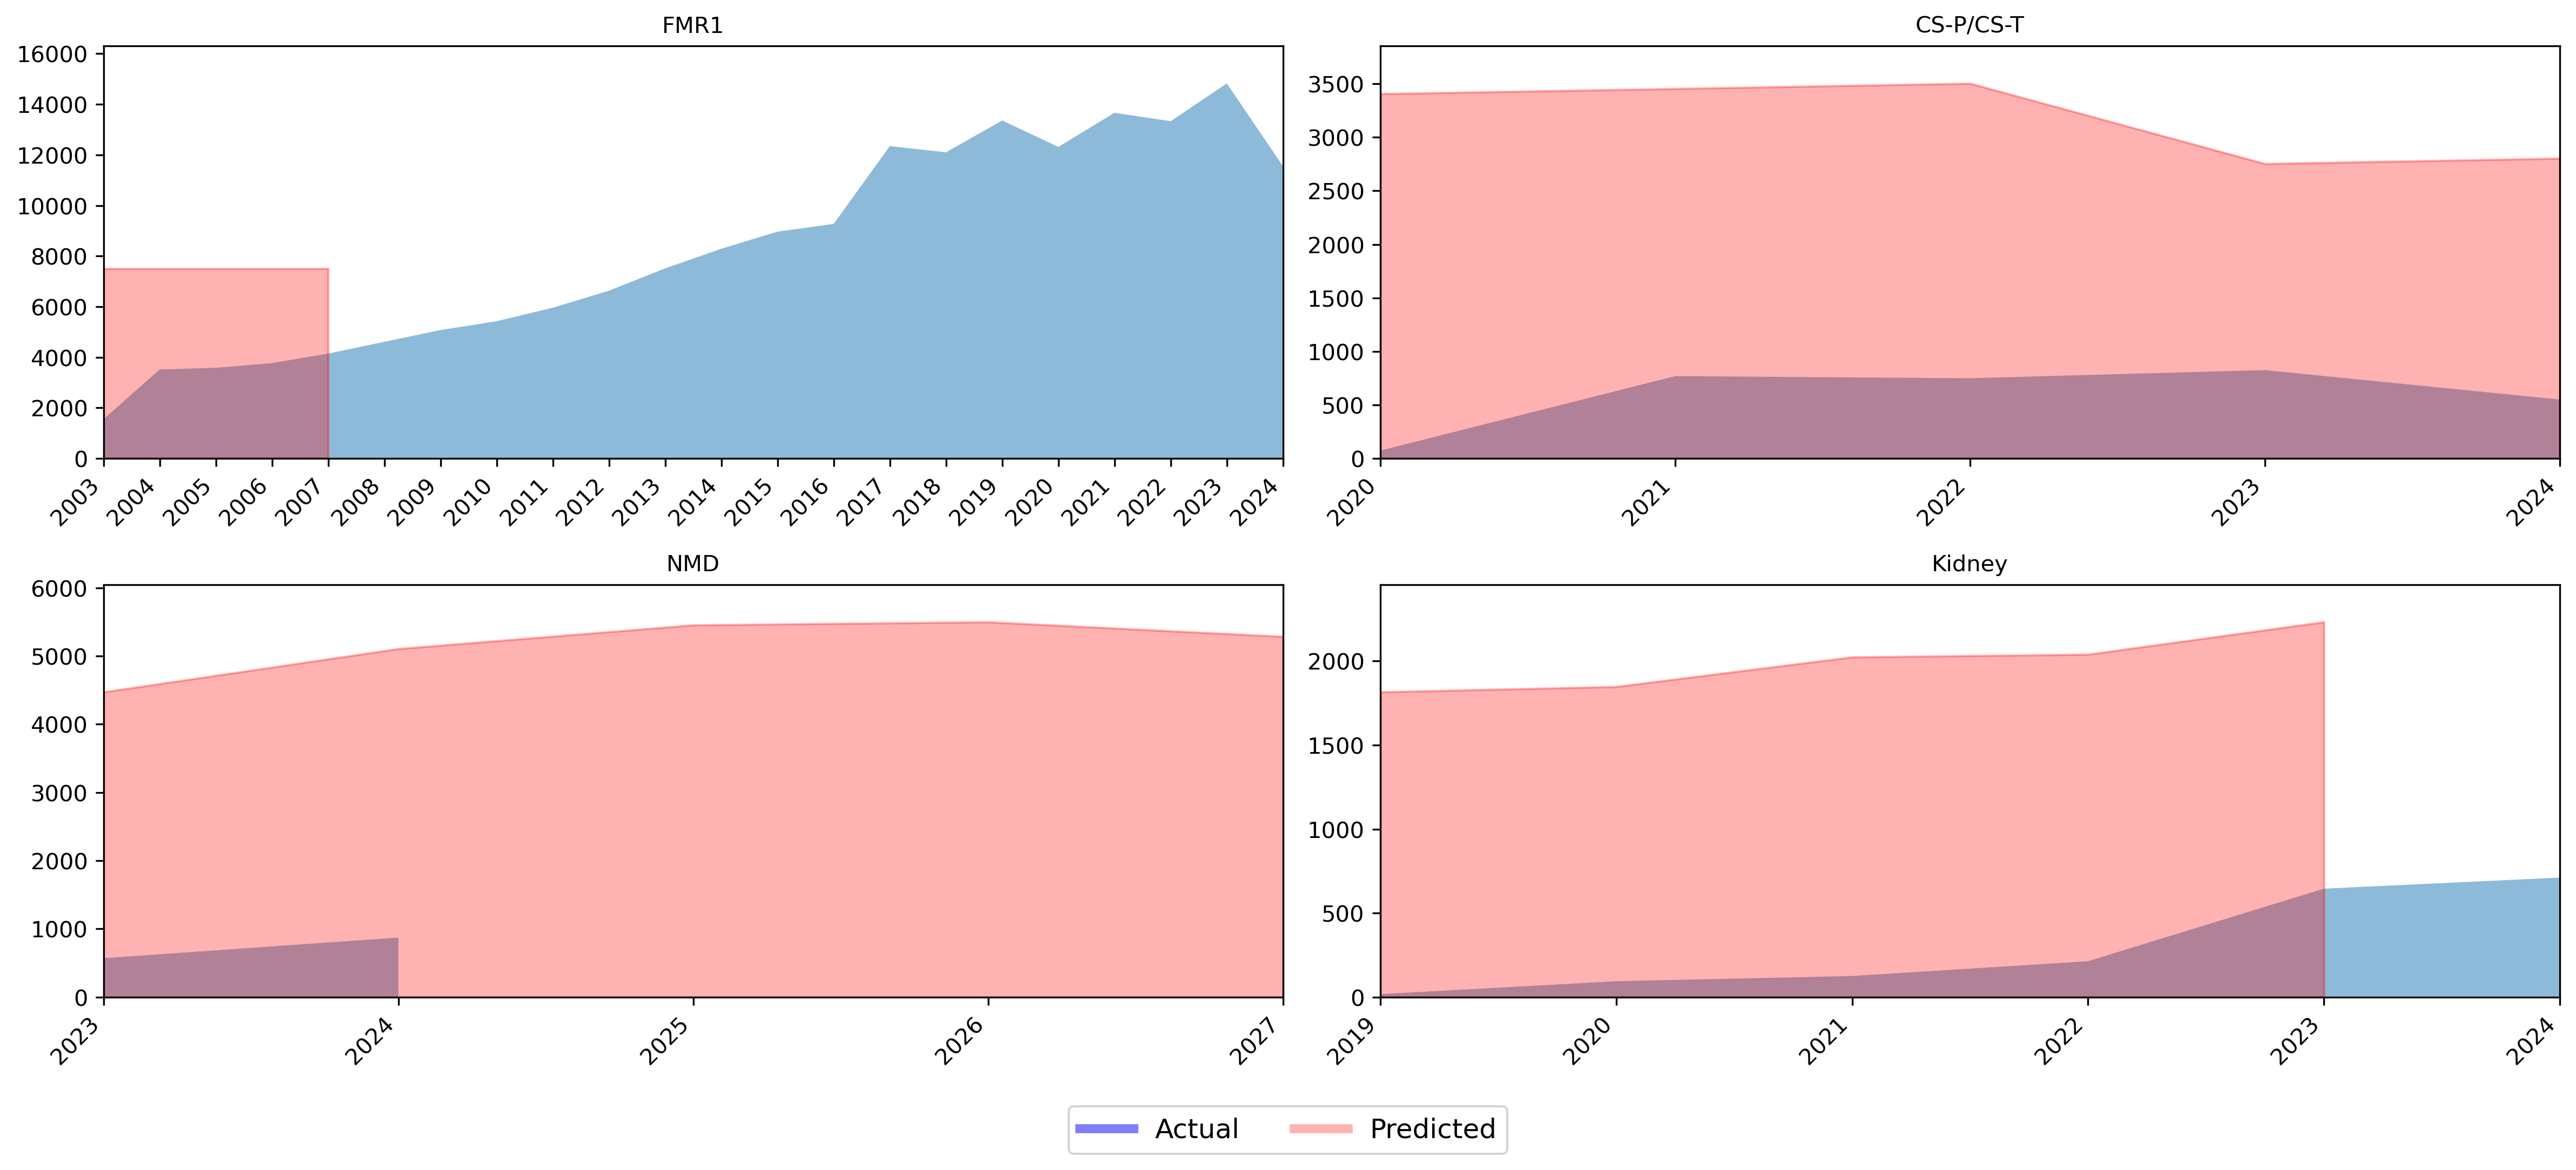

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import math

# Inline plotting for Jupyter
%matplotlib inline

register_matplotlib_converters()

# -- Load and prepare the data --
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Convert Month column to datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only the specific item categories
items_to_include = [
    '73300', '73358', '73359', '73360', '73395', '73298', '73299', '73401',
    '73402', '73422', '73425', '73426', '73442', '73456', '73457', '73458'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Replace items with their corresponding group names:
# - Combine CS: '73358' and '73359' become '73358_73359'
# - Combine Kidney: '73298', '73401', and '73402' become 'Kidney'
filtered_data.loc[:, 'Item'] = filtered_data['Item'].replace({
    '73359': '73358_73359', 
    '73358': '73358_73359',
    '73298': 'Kidney',
    '73401': 'Kidney',
    '73402': 'Kidney'
})

# Re-aggregate 'Value' by year for each item/group
grouped_data = filtered_data.groupby(['Item', filtered_data.index.year])['Value'].sum()

# Ensure the combined items/groups are included in available_items
available_items = grouped_data.index.get_level_values('Item').unique().tolist()

# Predicted values (annual)
predicted_values = {
    '73300': [7500, 7500, 7500, 7500, 7500],
    '73358_73359': [3406, 3454, 3503, 2753, 2803],
    '73398': [2300, 1170, 1190, 1210, 1230],
    '73401': [789, 723, 796, 715, 805],
    '73402': [27, 25, 28, 25, 28],
    '73422': [4472, 5106, 5454, 5499, 5285],
    '73298': [1000, 1100, 1200, 1300, 1400]  # Example values; replace with actual predictions
}

# Combine predicted values for the Kidney group (sum element-wise)
if all(k in predicted_values for k in ['73298', '73401', '73402']):
    kidney_pred = [a + b + c for a, b, c in zip(predicted_values['73298'], predicted_values['73401'], predicted_values['73402'])]
    predicted_values['Kidney'] = kidney_pred
    # Remove individual kidney predictions to avoid duplicate display
    for k in ['73298', '73401', '73402']:
         del predicted_values[k]

# Custom titles mapping for items/groups
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73422': 'NMD'
}
# Update titles for combined groups:
custom_titles['73358_73359'] = 'CS'
custom_titles['Kidney'] = 'Kidney'

def get_custom_title(item):
    """
    Return a custom title for an item code.
    If the item code is a combination (e.g., '73358_73359'),
    then return a concatenated custom title for each part.
    """
    if "_" in item:
        parts = item.split("_")
        # Look up each part in custom_titles; if not found, use the original code
        mapped_parts = [custom_titles.get(part, part) for part in parts]
        return "/".join(mapped_parts)
    else:
        return custom_titles.get(item, item)

# Function to create subplots for a given set of items
def create_subplots(items, filename=None):
    num_items = len(items)
    cols = 2  # Set to 3 columns
    rows = math.ceil(num_items / cols)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 4 * rows), dpi=300)
    axes = axes.flatten() if num_items > 1 else [axes]  # Flatten axes for easy iteration

    for ax, item in zip(axes, items):
        max_y = 0

        # Plot actual data if available
        if item in grouped_data.index.get_level_values('Item'):
            item_data = grouped_data.loc[item]
            ax.fill_between(item_data.index, item_data, alpha=0.5, label="Actual")
            max_y = max(max_y, item_data.max())
        else:
            # Initialize an empty series if no actual data exists
            item_data = pd.Series()

        # Plot predicted values if available
        if item in predicted_values:
            # Determine the start year using actual data if available, otherwise use a default
            if not item_data.empty:
                start_year = item_data.index.min()
            else:
                start_year = pd.Timestamp.now().year - len(predicted_values[item]) + 1

            pred_years = list(range(start_year, start_year + len(predicted_values[item])))
            pred_values = predicted_values[item]
            ax.fill_between(pred_years, pred_values, alpha=0.3, color='red', label="Predicted")
            max_y = max(max_y, max(pred_values))

        # Apply y-axis limits with some padding
        ax.set_ylim(0, max_y * 1.1)

        # Compute x-axis ticks as the union of actual and predicted years
        x_ticks = set()
        if not item_data.empty:
            x_ticks.update(item_data.index)
        if item in predicted_values:
            # Ensure that we have a proper starting year (an integer) for predicted data
            if not item_data.empty:
                start_year = item_data.index.min()
            else:
                start_year = pd.Timestamp.now().year - len(predicted_values[item]) + 1
            predicted_years = list(range(start_year, start_year + len(predicted_values[item])))
            x_ticks.update(predicted_years)

        x_ticks = sorted(x_ticks)
        if x_ticks:
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_ticks, rotation=45, ha='right')
            ax.set_xlim(min(x_ticks), max(x_ticks))

        # Set the subplot title using the custom title mapping
        ax.set_title(get_custom_title(item), fontsize=10)

    # Hide unused subplots
    for ax in axes[len(items):]:
        ax.axis('off')

    # Add a single legend for the entire figure with automatic positioning
    handles = [
        plt.Line2D([0], [0], color='blue', lw=4, alpha=0.5, label='Actual'),
        plt.Line2D([0], [0], color='red', lw=4, alpha=0.3, label='Predicted')
    ]
    fig.legend(handles=handles, loc='upper center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 0.1))

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])

    # Display the plot
    plt.show()

    # Save the figure if a filename is provided
    if filename:
        fig.savefig(filename, format='svg', dpi=300)

# Create plots for available items/groups
create_subplots(
    available_items,
    filename="FilteredItems_3cols.svg"
)


#### Tables

In [19]:
import pandas as pd

# -- Load and prepare the data --
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Convert Month column to datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only the specific item categories
items_to_include = [
    '73300', '73358', '73359', '73360', '73395', '73298', '73299', '73401',
    '73402', '73422', '73425', '73426', '73442', '73456', '73457', '73458', '73398'
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# Define group mappings for the actual data
group_map = {
    '73298': 'Kidney',
    '73401': 'Kidney',
    '73402': 'Kidney',
    '73358': 'CS',
    '73359': 'CS'
}

# Create a new column 'Group' that maps items to their group names (if applicable)
# Otherwise, keep the original item code.
filtered_data['Group'] = filtered_data['Item'].apply(lambda x: group_map.get(x, x))

# Calculate 'Relative Year'
filtered_data['Year'] = filtered_data.index.year
filtered_data['First Year'] = filtered_data.groupby('Group')['Year'].transform('min')
filtered_data['Relative Year'] = filtered_data['Year'] - filtered_data['First Year'] + 1

# Ensure only the first 5 years of data are included
filtered_data = filtered_data[filtered_data['Relative Year'] <= 5]

# Group the actual data by the new 'Group' column and Relative Year, then pivot it into columns.
grouped_data = filtered_data.groupby(['Group', 'Relative Year'])['Value'].sum().unstack(fill_value=0)
grouped_data.columns = [f'Actual Year {i}' for i in range(1, 6)]

# Predicted values (annual) for individual items
predicted_values = {
    '73300': [7500, 7500, 7500, 7500, 7500],
    '73358_73359': [3406, 3454, 3503, 2753, 2803],
    '73398': [2300, 1170, 1190, 1210, 1230],
    '73401': [789, 723, 796, 715, 805],
    '73402': [27, 25, 28, 25, 28],
    '73422': [4472, 5106, 5454, 5499, 5285],
    '73298': [1000, 1100, 1200, 1300, 1400]
}

# Define a mapping for the predicted values:
# For the CS group, '73358_73359' should become 'CS'
# For the Kidney group, sum the values for '73298', '73401', and '73402'
predicted_map = {
    '73358_73359': 'CS',
    '73401': 'Kidney',
    '73402': 'Kidney',
    '73298': 'Kidney'
}

# Combine predicted values into groups by summing element-wise when necessary.
new_predicted_values = {}
for key, values in predicted_values.items():
    # Map the key if it is part of a group, else keep as is.
    group_key = predicted_map.get(key, key)
    if group_key in new_predicted_values:
        # Sum the predicted values element-wise if this group already exists.
        new_predicted_values[group_key] = [sum(x) for x in zip(new_predicted_values[group_key], values)]
    else:
        new_predicted_values[group_key] = values

# Create a DataFrame from the new predicted values
predicted_df = pd.DataFrame.from_dict(new_predicted_values, orient='index', columns=[f'Predicted Year {i}' for i in range(1, 6)])

# Combine the actual and predicted values into a single table
result_table = grouped_data.join(predicted_df, how='outer').reset_index()

# Add percentage columns comparing actual to predicted values
for year in range(1, 6):
    actual_col = f'Actual Year {year}'
    predicted_col = f'Predicted Year {year}'
    percentage_col = f'Percentage Year {year}'
    
    # Calculate percentage and handle division by zero if necessary
    result_table[percentage_col] = (result_table[actual_col] / result_table[predicted_col]) * 100

# Display the final result table
print(result_table)


    index  Actual Year 1  Actual Year 2  Actual Year 3  Actual Year 4  \
0   73300         1552.0         3517.0         3581.0         3767.0   
1   73398          511.0         2011.0         1784.0            0.0   
2   73422          569.0          871.0            0.0            0.0   
3      CS           73.0          769.0          749.0          825.0   
4  Kidney           17.0           94.0          125.0          213.0   

   Actual Year 5  Predicted Year 1  Predicted Year 2  Predicted Year 3  \
0         4145.0              7500              7500              7500   
1            0.0              2300              1170              1190   
2            0.0              4472              5106              5454   
3          550.0              3406              3454              3503   
4          645.0              1816              1848              2024   

   Predicted Year 4  Predicted Year 5  Percentage Year 1  Percentage Year 2  \
0              7500              7500

In [20]:
result_table

index  Actual Year 1  Actual Year 2  Actual Year 3  Actual Year 4  \
0   73300         1552.0         3517.0         3581.0         3767.0   
1   73398          511.0         2011.0         1784.0            0.0   
2   73422          569.0          871.0            0.0            0.0   
3      CS           73.0          769.0          749.0          825.0   
4  Kidney           17.0           94.0          125.0          213.0   

   Actual Year 5  Predicted Year 1  Predicted Year 2  Predicted Year 3  \
0         4145.0              7500              7500              7500   
1            0.0              2300              1170              1190   
2            0.0              4472              5106              5454   
3          550.0              3406              3454              3503   
4          645.0              1816              1848              2024   

   Predicted Year 4  Predicted Year 5  Percentage Year 1  Percentage Year 2  \
0              7500              7500          20.693333          46.893333   
1              1210              1230          22.217391         171.880342   
2              5499              5285          12.723614          17.058363   
3              2753              2803           2.143277          22.264042   
4              2040              2233           0.936123           5.086580   

   Percentage Year 3  Percentage Year 4  Percentage Year 5  
0          47.746667          50.226667          55.266667  
1         149.915966           0.000000           0.000000  
2           0.000000           0.000000           0.000000  
3          21.381673          29.967308          19.621834  
4           6.175889          10.441176          28.884908

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Load the data (use your own path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories.
# This list includes individual tests (CMA, FMR1, NMD)
# and items that will be combined into groups (CS and Kidney)
items_to_include = [Diff
    '73292',   # CMA (individual)
    '73300',   # FMR1 (individual)
    '73358',   # Part of CS group
    '73359',   # Part of CS group
    '73298',   # Part of Kidney group
    '73401',   # Part of Kidney group
    '73402',   # Part of Kidney group
    '73422'    # NMD (keep individual AND include in combined group)
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# -- Create new virtual groups --

# CS group: combine items 73358 and 73359 
cs_group = (
    filtered_data[filtered_data['Item'].isin(['73358', '73359'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
cs_group['Item'] = 'CS Combined'  # This will be mapped to "CS"

# Kidney group: combine items 73298, 73401, and 73402
kidney_group = (
    filtered_data[filtered_data['Item'].isin(['73298', '73401', '73402'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
kidney_group['Item'] = 'Kidney'

# Genomic Tests Combined group: combine items for CS, Kidney, and NMD
genomic_tests_group = (
    filtered_data[filtered_data['Item'].isin(['73358', '73359', '73298', '73401', '73402', '73422'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
genomic_tests_group['Item'] = 'Genomic Tests Combined'

# Remove individual rows for items that are now grouped into CS and Kidney,
# but keep NMD ('73422') as an individual item.
grouped_items = ['73358', '73359', '73298', '73401', '73402']
filtered_data = filtered_data[~filtered_data['Item'].isin(grouped_items)]

# Append the combined groups back to the filtered data
filtered_data = pd.concat(
    [
        filtered_data.reset_index(),  # Remaining individual items (e.g., CMA, FMR1, NMD)
        cs_group,                     # CS group
        kidney_group,                 # Kidney group
        genomic_tests_group           # Genomic Tests Combined group
    ],
    ignore_index=True
)

# Re-set index to Month and print unique items to verify groups are included
filtered_data.set_index('Month', inplace=True)
print("Unique items after grouping:", filtered_data['Item'].unique())

# Drop categories with no data
data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define custom titles mapping (friendly names)
custom_titles = {
    '73292': 'CMA',
    '73300': 'FMR1',
    '73422': 'NMD',  # Individual NMD
    'CS Combined': 'CS',
    'Kidney': 'Kidney',
    'Genomic Tests Combined': 'Genomic Tests Combined'
}

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# Initialize lists to hold results and problematic fits
model_results = []
problematic_items = []

# Iterate through each item and fit only the diffusion models using the first five years of data
for item in valid_items:
    # Resample by month-end, sum, and drop missing values
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum().dropna()
    
    if item_data.empty:
        print(f"Item {item} has no data after resampling. Skipping.")
        continue
    
    # Use only the first five years (approximately 60 months) of data for this item.
    if len(item_data) >= 60:
        item_data = item_data.iloc[:60]
    else:
        item_data = item_data.copy()
    
    time_index = np.arange(len(item_data))
    
    # Define diffusion models to test
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    for model_name, model_func in models.items():
        try:
            # Fit the model
            params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
            predicted = model_func(time_index, *params)
            r2 = 1 - np.sum((item_data - predicted) ** 2) / np.sum((item_data - np.mean(item_data)) ** 2)
            
            # Store results
            model_results.append({
                'Item': item,
                'Model': model_name,
                'r2': r2,
                'MAE': mean_absolute_error(item_data, predicted),
                'MAPE': mean_absolute_percentage_error(item_data, predicted)
            })
            
            # Check for problematic R² values
            if r2 < -1 or r2 > 1:
                problematic_items.append({
                    'Item': item,
                    'Model': model_name,
                    'R2': r2
                })
        except Exception as e:
            print(f"Error fitting {model_name} for item {item}: {e}")

# Convert results to DataFrame and add custom titles
results_df = pd.DataFrame(model_results)
results_df['Item_title'] = results_df['Item'].apply(lambda x: custom_titles[x] if x in custom_titles else x)

problematic_df = pd.DataFrame(problematic_items)

# Identify best models for each item based on highest R²
best_models = results_df.loc[results_df.groupby('Item')['r2'].idxmax()]

# Output best models with custom titles
print("Best Models for Each Item (using only the first five years of data):")
print(best_models[['Item', 'Item_title', 'Model', 'r2', 'MAE', 'MAPE']])

# Analyze diffusion model performance
diffusion_models = results_df[results_df['Model'].isin(["Logistic Diffusion", "Gompertz", "Bass Diffusion"])]

# For each item, pick the diffusion model with highest R²
diffusion_performance = diffusion_models.groupby('Item')['r2'].idxmax().apply(lambda idx: diffusion_models.loc[idx])

print("\nDiffusion Model Analysis (using only the first five years of data):")
for _, row in diffusion_performance.iterrows():
    print(f"Item {row['Item_title']} (code: {row['Item']}): Best Diffusion Model = {row['Model']} (R2 = {row['r2']:.2f})")
    if row['Model'] == "Logistic Diffusion":
        print("  - Indicates balanced growth with symmetric adoption.")
    elif row['Model'] == "Gompertz":
        print("  - Suggests gradual early adoption with rapid growth later.")
    elif row['Model'] == "Bass Diffusion":
        print("  - Reflects interplay of innovation and imitation in adoption.")


Unique items after grouping: ['73292' '73300' '73422' 'CS Combined' 'Kidney' 'Genomic Tests Combined']
Error fitting Gompertz for item 73292: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Best Models for Each Item (using only the first five years of data):
                      Item              Item_title           Model        r2  \
1                    73292                     CMA  Bass Diffusion  0.097049   
3                    73300                    FMR1        Gompertz  0.248781   
7                    73422                     NMD  Bass Diffusion  0.732352   
10             CS Combined                      CS  Bass Diffusion  0.522982   
13  Genomic Tests Combined  Genomic Tests Combined  Bass Diffusion  0.864447   
16                  Kidney                  Kidney  Bass Diffusion  0.811972   

           MAE          MAPE  
1   261.166102  4.019505e-01  
3    50.823164  1.953921e-01  
7    13.953904  4.016996e-01  
10   15.394526  3.

/tmp/ipykernel_952/1760854505.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_952/1760854505.py:99: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * np.exp(-c * t))
/tmp/ipykernel_952/1760854505.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_952/1760854505.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_952/1760854505.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
/tmp/ipykernel_952/1760854505.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_func, time_index, ite

/tmp/ipykernel_952/2204938261.py:72: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/2204938261.py:72: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/2204938261.py:72: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/2204938261.py:72: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/2204938261.py:72: FutureWarning: 'M' is deprecate

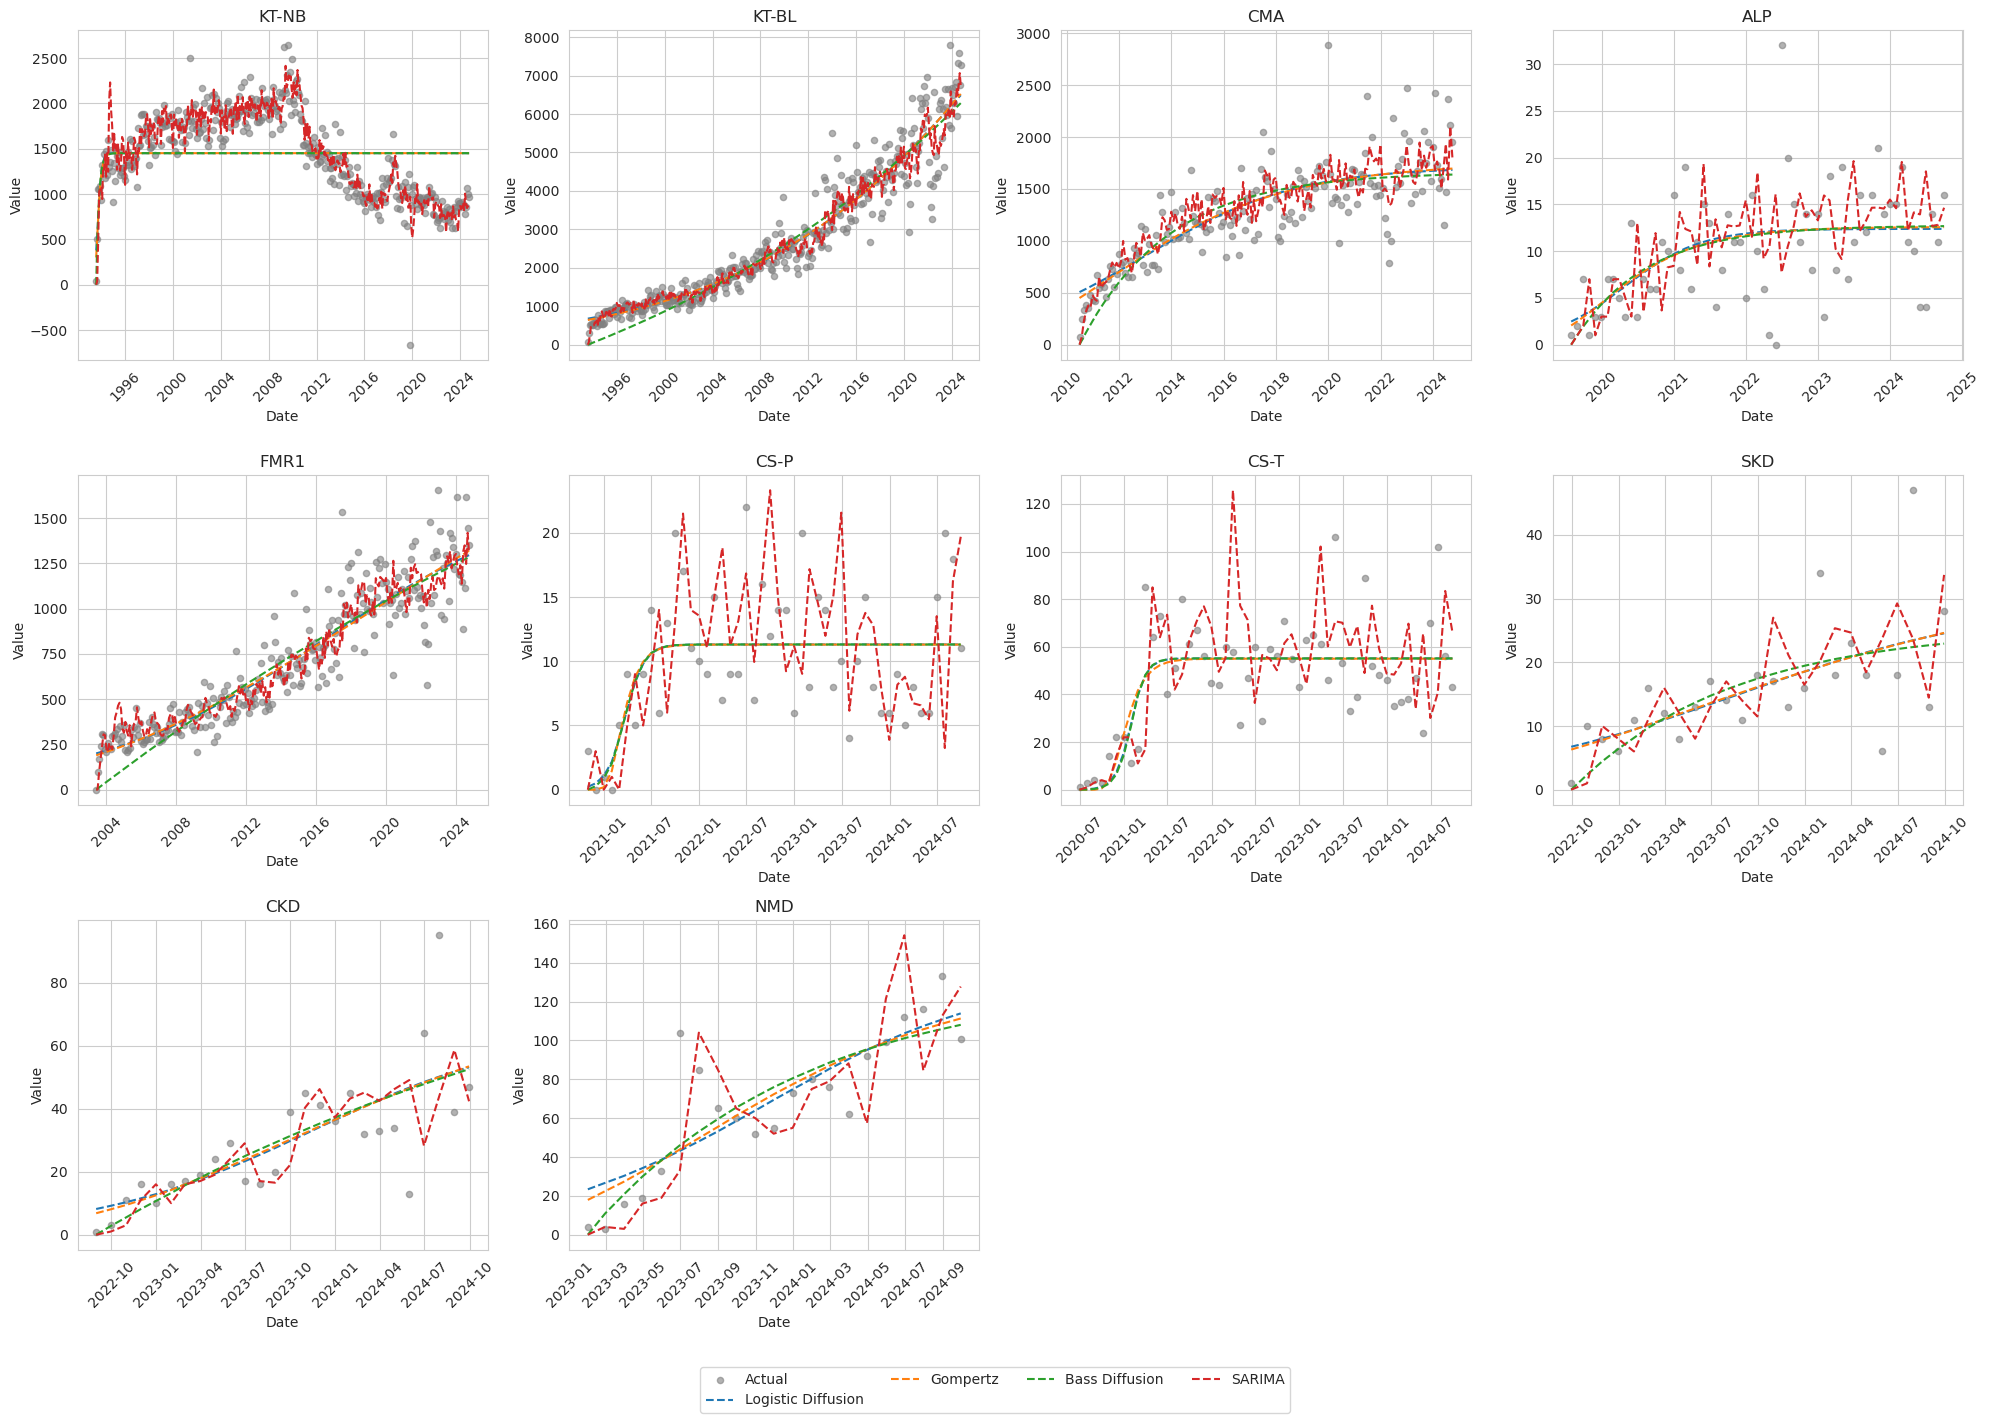

     Item               Model     r2     MAE      MAPE
0   73287  Logistic Diffusion   0.04  384.54      0.34
1   73287            Gompertz   0.04  384.14      0.33
2   73287      Bass Diffusion   0.04  383.60      0.32
3   73287              SARIMA   0.78  156.11      0.12
4   73289  Logistic Diffusion   0.91  342.84      0.16
5   73289            Gompertz   0.91  343.10      0.15
6   73289      Bass Diffusion   0.90  427.96      0.23
7   73289              SARIMA   0.92  328.11      0.13
8   73292  Logistic Diffusion   0.64  200.83      0.20
9   73292            Gompertz   0.64  197.30      0.19
10  73292      Bass Diffusion   0.62  211.55      0.19
11  73292              SARIMA   0.65  200.68      0.17
12  73298  Logistic Diffusion   0.25    3.98  8.68e+14
13  73298            Gompertz   0.25    3.97  8.62e+14
14  73298      Bass Diffusion   0.25    3.98  8.56e+14
15  73298              SARIMA  -0.22    4.96  1.15e+15
16  73300  Logistic Diffusion   0.85  103.63      0.94
17  73300 

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# 1) Load the data
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

items_to_include = [
    '73287', '73289', '73292', '73298',
    '73300', '73358', '73359', '73401',
    '73402', '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
}

data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# 2) Define model functions
def logistic_diffusion(t, K, r, t0):
    # K: carrying capacity, r: growth rate, t0: inflection time
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    # a: asymptote, b, c > 0 control growth/shape
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    # p: coefficient of innovation
    # q: coefficient of imitation
    # M: eventual market size (carrying capacity)
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

model_results = []

# 3) Set up subplots
n_items = len(valid_items)
cols = 4
rows = int(np.ceil(n_items / cols))
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()

for i, item in enumerate(valid_items):
    display_name = custom_titles.get(item, item)
    
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
    if item_data.empty:
        print(f"Item {item} has no data after resampling. Skipping.")
        continue

    # t will be 0, 1, 2, ...
    time_index = np.arange(len(item_data))

    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }

    results = {}
    
    # 4) Prepare initial guesses and bounds for each model
    #    We often want K or M slightly above the maximum observed data.
    #    The growth rate parameters (r, p, q) must be positive,
    #    and t0 is often near the midpoint of the time index.
    max_val = item_data.max()
    mid_t   = np.median(time_index)  # or len(item_data)/2

    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                # Already has p0 and bounds
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    time_index,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )

            elif model_name == "Logistic Diffusion":
                # Example: p0 = [slightly bigger than max, small positive r, midpoint for t0]
                p0 = [max_val * 1.2, 0.1, mid_t]
                # Keep them positive, but let them vary widely
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    time_index,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )

            elif model_name == "Bass Diffusion":
                # p0 = [small p, moderate q, bigger than max M]
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    time_index,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )

            predicted = model_func(time_index, *params)
            r2 = r2_score(item_data, predicted)
            mae = mean_absolute_error(item_data, predicted)
            mape = mean_absolute_percentage_error(item_data, predicted)

            results[model_name] = {
                'r2': r2, 'MAE': mae, 'MAPE': mape, 'predicted': predicted
            }
        except Exception as e:
            print(f"Error fitting {model_name} for item {item} ({display_name}): {e}")

    # 5) Fit SARIMA model
    try:
        sarima_model = SARIMAX(item_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_pred = sarima_fit.fittedvalues
        sarima_r2 = r2_score(item_data, sarima_pred)
        sarima_mae = mean_absolute_error(item_data, sarima_pred)
        sarima_mape = mean_absolute_percentage_error(item_data, sarima_pred)

        results["SARIMA"] = {
            'r2': sarima_r2, 'MAE': sarima_mae, 'MAPE': sarima_mape, 'predicted': sarima_pred
        }
    except Exception as e:
        print(f"Error fitting SARIMA for item {item} ({display_name}): {e}")

    # 6) Store results
    for model_name, metrics in results.items():
        model_results.append({
            'Item': item,
            'Model': model_name,
            'r2': metrics['r2'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE']
        })

    # 7) Plot
    ax = axes[i]
    ax.scatter(item_data.index, item_data, label='Actual',
               color='gray', alpha=0.6, s=20)
    for model_name, metrics in results.items():
        ax.plot(item_data.index, metrics['predicted'],
                label=model_name, linestyle='--')
    ax.set_title(display_name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Build a global legend
legend_entries = {}
for ax in axes:
    if not ax.has_data():
        continue
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in legend_entries:
            legend_entries[label] = handle

fig.legend(legend_entries.values(), legend_entries.keys(),
           loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.05))

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

# Convert model results to DataFrame
results_df = pd.DataFrame(model_results)

# Format results
for column in ['MAE', 'MAPE', 'r2']:
    results_df[column] = results_df[column].apply(
        lambda x: f"{x:.2e}" if abs(x) >= 100000 else f"{x:.2f}"
    )

print(results_df)


/tmp/ipykernel_772/12540058.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/tmp/ipykernel_772/12540058.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/home/doughnut/miniconda3/lib/pyt

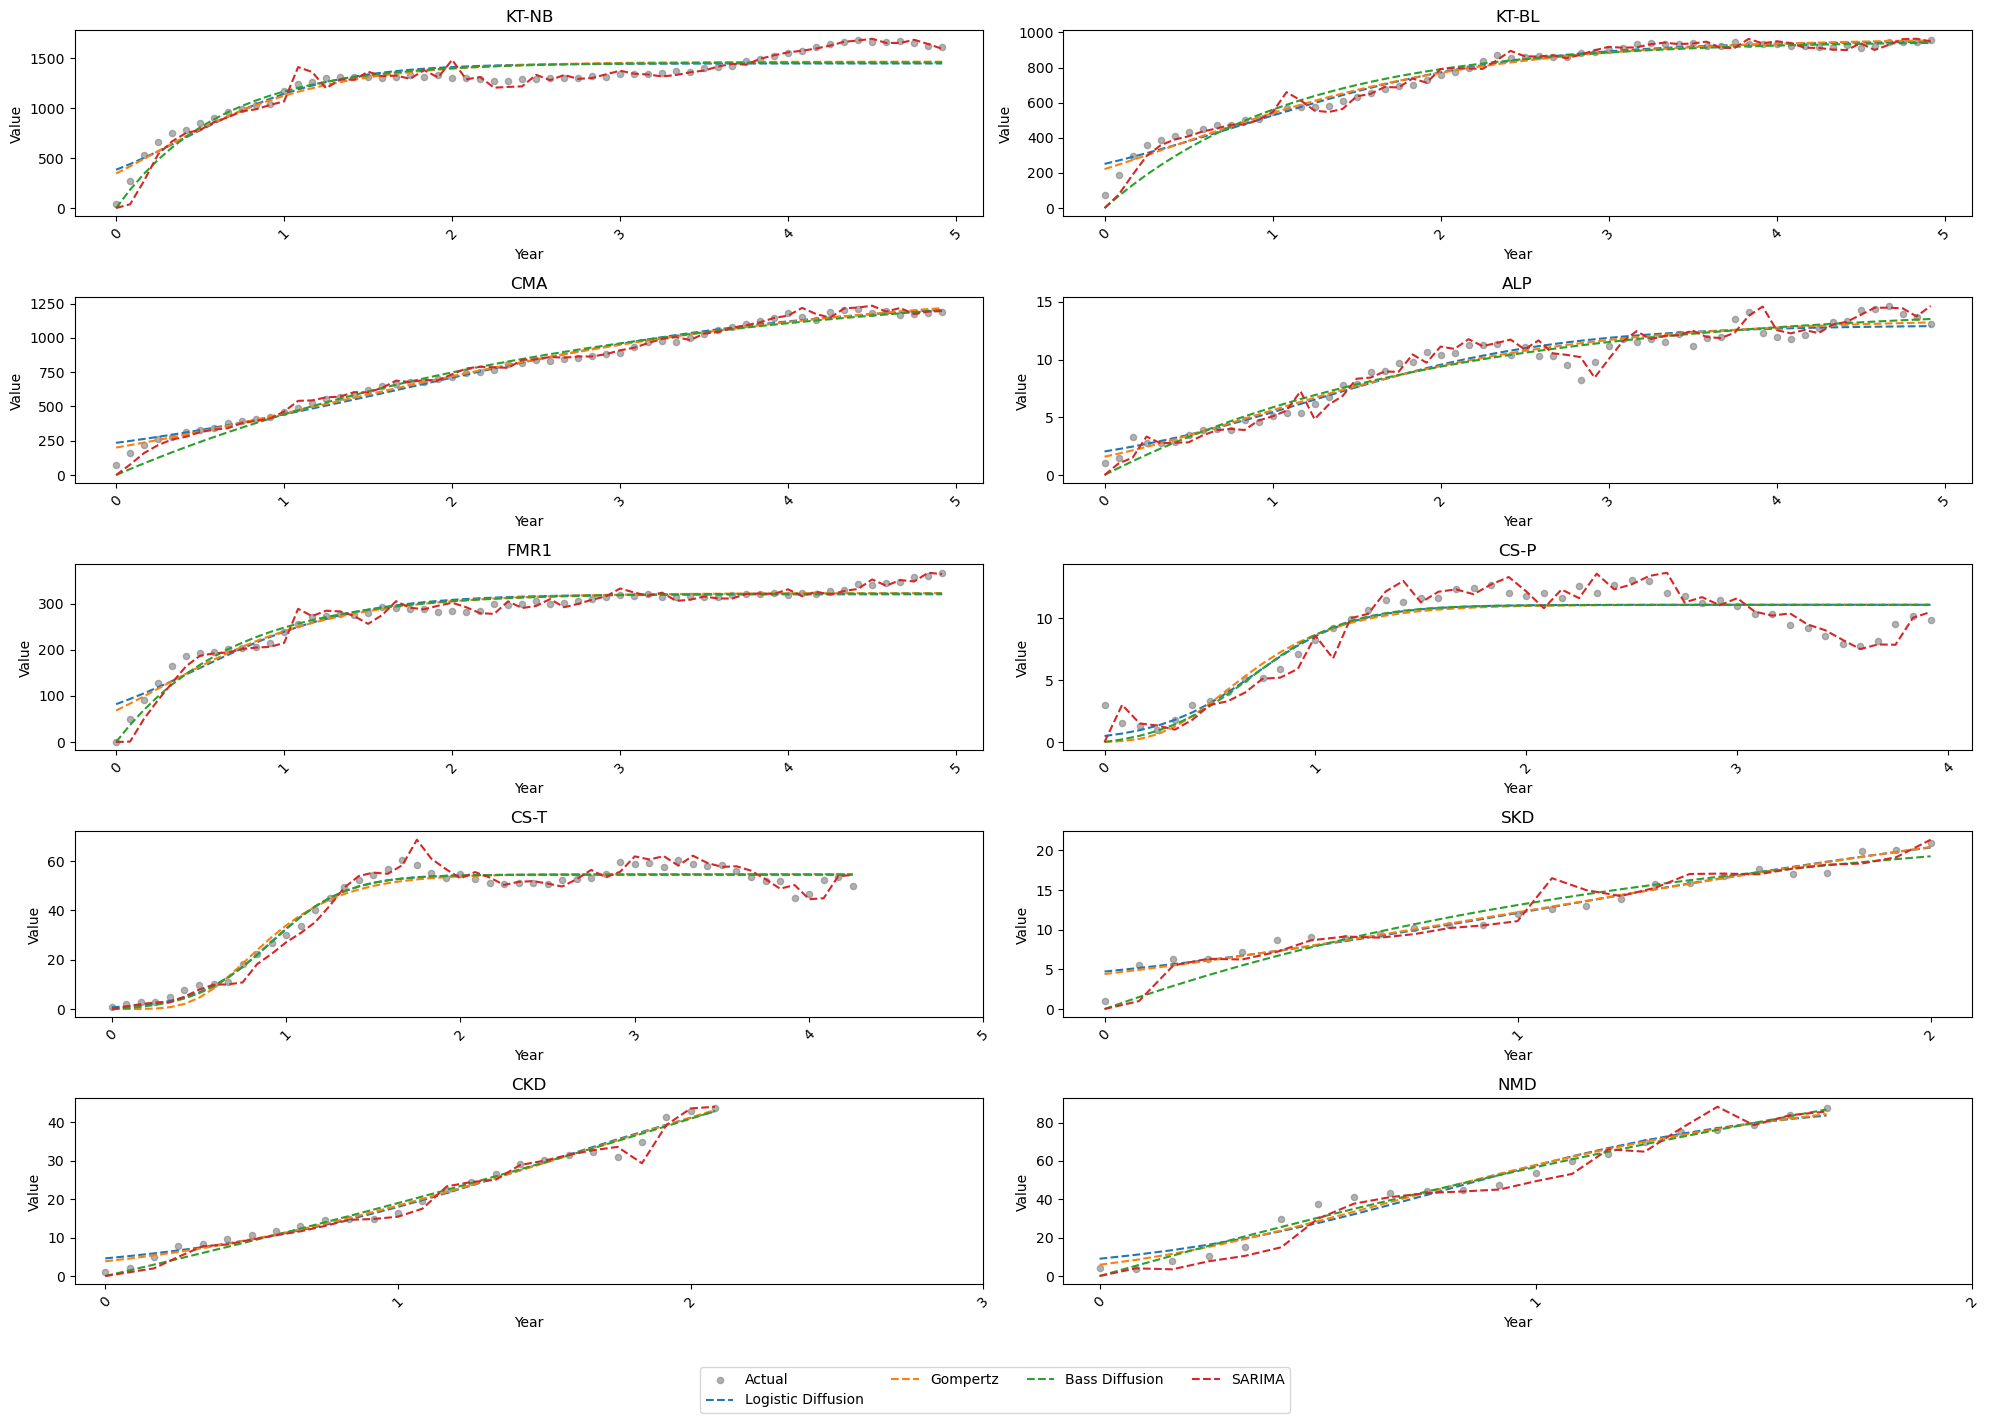

     Item               Model    r2     MAE  MAPE
0   73287  Logistic Diffusion  0.85  104.16  0.24
1   73287            Gompertz  0.87   99.75  0.22
2   73287      Bass Diffusion  0.88   97.40  0.10
3   73287              SARIMA  0.95   45.47  0.07
4   73289  Logistic Diffusion  0.97   23.59  0.08
5   73289            Gompertz  0.98   25.17  0.07
6   73289      Bass Diffusion  0.94   37.82  0.09
7   73289              SARIMA  0.98   22.89  0.06
8   73292  Logistic Diffusion  0.99   28.89  0.08
9   73292            Gompertz  0.99   24.97  0.06
10  73292      Bass Diffusion  0.97   40.76  0.10
11  73292              SARIMA  0.99   21.84  0.06
12  73298  Logistic Diffusion  0.94    0.74  0.10
13  73298            Gompertz  0.94    0.71  0.09
14  73298      Bass Diffusion  0.94    0.75  0.12
15  73298              SARIMA  0.95    0.62  0.10
16  73300  Logistic Diffusion  0.92   14.61  1.41
17  73300            Gompertz  0.93   13.45  1.18
18  73300      Bass Diffusion  0.95   12.49  0.07


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

items_to_include = [
    '73287', '73289', '73292', '73298',
    '73300', '73358', '73359', '73401',
    '73402', '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
}

data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

model_results = []

# Plot settings: create a grid of subplots
n_items = len(valid_items)
cols = 2
rows = int(np.ceil(n_items / cols))
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()

for i, item in enumerate(valid_items):
    display_name = custom_titles.get(item, item)
    
    # Resample data by month and sum the values
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
    
    # Apply a 12-month moving average to smooth the data
    item_data = item_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first 5 years (60 months) of data
    item_data = item_data.iloc[:60]
    
    if item_data.empty:
        print(f"Item {item} has no data after resampling and slicing. Skipping.")
        continue

    # Create a new time axis in years (0, 1, 2, ...)
    years = np.arange(len(item_data)) / 12.0

    # Setup models for fitting
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = item_data.max()
    mid_t   = np.median(years)  # now in years

    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            predicted = model_func(years, *params)
            r2 = r2_score(item_data, predicted)
            mae = mean_absolute_error(item_data, predicted)
            mape = mean_absolute_percentage_error(item_data, predicted)
            results[model_name] = {
                'r2': r2, 'MAE': mae, 'MAPE': mape, 'predicted': predicted
            }
        except Exception as e:
            print(f"Error fitting {model_name} for item {item} ({display_name}): {e}")

    # Fit SARIMA model
    try:
        sarima_model = SARIMAX(item_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_pred = sarima_fit.fittedvalues
        sarima_r2 = r2_score(item_data, sarima_pred)
        sarima_mae = mean_absolute_error(item_data, sarima_pred)
        sarima_mape = mean_absolute_percentage_error(item_data, sarima_pred)
        results["SARIMA"] = {
            'r2': sarima_r2, 'MAE': sarima_mae, 'MAPE': sarima_mape, 'predicted': sarima_pred
        }
    except Exception as e:
        print(f"Error fitting SARIMA for item {item} ({display_name}): {e}")

    # Store the model metrics
    for model_name, metrics in results.items():
        model_results.append({
            'Item': item,
            'Model': model_name,
            'r2': metrics['r2'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE']
        })

    # Plot actual vs. predicted values using the new time axis in years
    ax = axes[i]
    ax.scatter(years, item_data, label='Actual', color='gray', alpha=0.6, s=20)
    for model_name, metrics in results.items():
        ax.plot(years, metrics['predicted'], label=model_name, linestyle='--')
    ax.set_title(display_name)
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    ax.set_xticks(np.arange(0, np.ceil(years.max())+1))
    ax.tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Build a global legend using only one set of model types
legend_entries = {}
for ax in axes:
    if not ax.has_data():
        continue
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in legend_entries:
            legend_entries[label] = handle

fig.legend(legend_entries.values(), legend_entries.keys(),
           loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.05))
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

# Convert model results to a DataFrame and format values
results_df = pd.DataFrame(model_results)
for column in ['MAE', 'MAPE', 'r2']:
    results_df[column] = results_df[column].apply(
        lambda x: f"{x:.2e}" if abs(x) >= 100000 else f"{x:.2f}"
    )
print(results_df)


/tmp/ipykernel_772/1612622750.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Group"] = filtered_data["Item"].apply(assign_group)
/tmp/ipykernel_772/1612622750.py:75: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Group'] == group]['Value'].resample('M').sum().dropna()
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-in

Error fitting Gompertz for group Kidney (Kidney): Optimal parameters not found: The maximum number of function evaluations is exceeded.


/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/tmp/ipykernel_772/1612622750.py:75: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Group'] == group]['Value'].resample('M').sum().dropna()
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Like

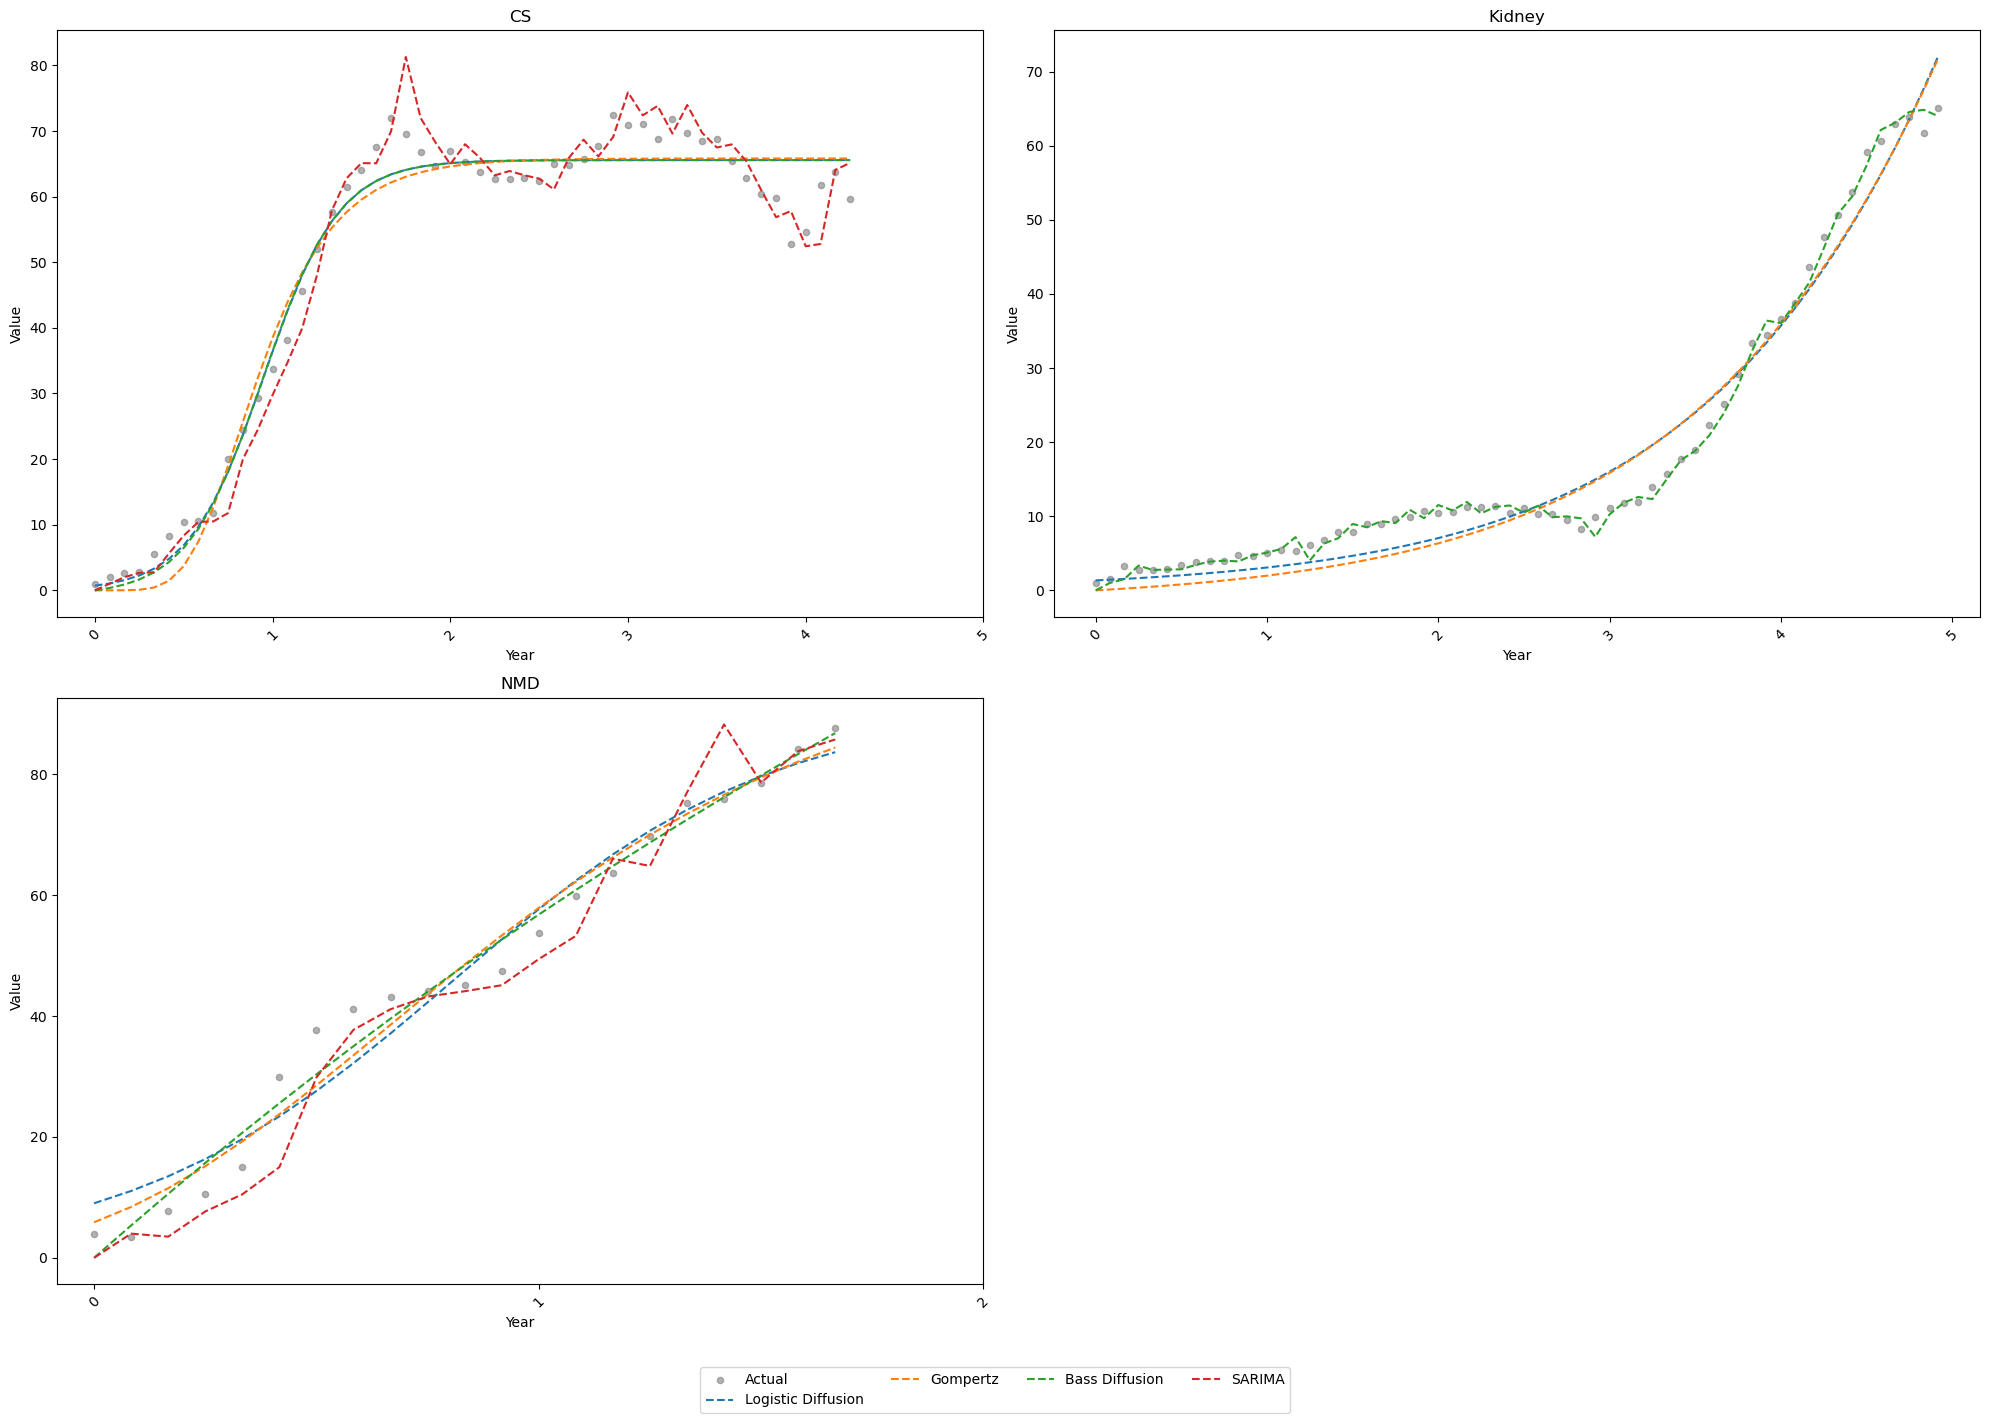

     Group               Model    r2   MAE  MAPE
0       CS  Logistic Diffusion  0.97  3.10  0.10
1       CS            Gompertz  0.96  3.71  0.18
2       CS      Bass Diffusion  0.97  3.20  0.13
3       CS              SARIMA  0.98  2.83  0.11
4   Kidney  Logistic Diffusion  0.97  2.93  0.27
5   Kidney      Bass Diffusion  0.96  3.35  0.39
6   Kidney              SARIMA  1.00  0.86  0.10
7      NMD  Logistic Diffusion  0.96  4.29  0.30
8      NMD            Gompertz  0.97  3.57  0.21
9      NMD      Bass Diffusion  0.98  2.94  0.18
10     NMD              SARIMA  0.96  3.95  0.18


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings

# Optionally filter out some warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Only include items that are needed:
# Kidney: "73298", "73401", "73402"
# CS: "73358", "73359"
# NMD: "73422"
items_to_include = [
    '73298', '73358', '73359', '73401', '73402', '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Update custom titles (only relevant for items that are not regrouped)
custom_titles = {
    '73422': 'NMD'
}

# Create a new column called "Group" to assign each row to a combined group
def assign_group(item):
    if item in ["73298", "73401", "73402"]:
        return "Kidney"
    elif item in ["73358", "73359"]:
        return "CS"
    else:
        return custom_titles.get(item, item)  # currently used for NMD

filtered_data["Group"] = filtered_data["Item"].apply(assign_group)

# Determine which groups have data
group_data_counts = filtered_data.groupby("Group")["Value"].count()
valid_groups = group_data_counts[group_data_counts > 0].index.tolist()

# Define model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

model_results = []

# Plot settings: create a grid of subplots
n_groups = len(valid_groups)
cols = 2
rows = int(np.ceil(n_groups / cols))
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()

# Loop over each valid group
for i, group in enumerate(valid_groups):
    display_name = group  # "Kidney", "CS", or "NMD"
    
    # Resample data by month and sum the values for the group
    group_data = filtered_data[filtered_data['Group'] == group]['Value'].resample('M').sum().dropna()
    
    # Apply a 12-month moving average to smooth the data
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first 5 years (60 months) of data
    group_data = group_data.iloc[:60]
    
    if group_data.empty:
        print(f"Group {group} has no data after resampling and slicing. Skipping.")
        continue
    
    # Create a new time axis in years (0, 1, 2, ...)
    years = np.arange(len(group_data)) / 12.0

    # Setup models for fitting
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = group_data.max()
    mid_t = np.median(years)
    
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func, years, group_data, p0=p0, bounds=bounds, maxfev=10000
                )
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func, years, group_data, p0=p0, bounds=bounds, maxfev=10000
                )
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func, years, group_data, p0=p0, bounds=bounds, maxfev=10000
                )
            predicted = model_func(years, *params)
            r2 = r2_score(group_data, predicted)
            mae = mean_absolute_error(group_data, predicted)
            mape = mean_absolute_percentage_error(group_data, predicted)
            results[model_name] = {'r2': r2, 'MAE': mae, 'MAPE': mape, 'predicted': predicted}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group} ({display_name}): {e}")
    
    # Fit SARIMA model
    try:
        sarima_model = SARIMAX(group_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_pred = sarima_fit.fittedvalues
        sarima_r2 = r2_score(group_data, sarima_pred)
        sarima_mae = mean_absolute_error(group_data, sarima_pred)
        sarima_mape = mean_absolute_percentage_error(group_data, sarima_pred)
        results["SARIMA"] = {'r2': sarima_r2, 'MAE': sarima_mae, 'MAPE': sarima_mape, 'predicted': sarima_pred}
    except Exception as e:
        print(f"Error fitting SARIMA for group {group} ({display_name}): {e}")
    
    # Store the model metrics for later reporting
    for model_name, metrics in results.items():
        model_results.append({
            'Group': group,
            'Model': model_name,
            'r2': metrics['r2'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE']
        })
    
    # Plot actual vs. predicted values using the new time axis in years
    ax = axes[i]
    ax.scatter(years, group_data, label='Actual', color='gray', alpha=0.6, s=20)
    for model_name, metrics in results.items():
        ax.plot(years, metrics['predicted'], label=model_name, linestyle='--')
    ax.set_title(display_name)
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    ax.set_xticks(np.arange(0, np.ceil(years.max()) + 1))
    ax.tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Build a global legend using only one set of model types
legend_entries = {}
for ax in axes:
    if not ax.has_data():
        continue
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in legend_entries:
            legend_entries[label] = handle

fig.legend(legend_entries.values(), legend_entries.keys(),
           loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.05))
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

# Convert model results to a DataFrame and format values
results_df = pd.DataFrame(model_results)
for column in ['MAE', 'MAPE', 'r2']:
    results_df[column] = results_df[column].apply(
        lambda x: f"{x:.2e}" if abs(x) >= 100000 else f"{x:.2f}"
    )
print(results_df)


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories.
# This list includes individual tests (CMA, FMR1, NMD)
# and items that will be combined into groups (CS and Kidney)
items_to_include = [
    '73292',   # CMA (individual)
    '73300',   # FMR1 (individual)
    '73358',   # Part of CS group
    '73359',   # Part of CS group
    '73298',   # Part of Kidney group
    '73401',   # Part of Kidney group
    '73402',   # Part of Kidney group
    '73422'    # NMD (keep individual AND include in combined group)
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# -- Create new virtual groups --

# CS group: combine items 73358 and 73359
cs_group = (
    filtered_data[filtered_data['Item'].isin(['73358', '73359'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
cs_group['Item'] = 'CS Combined'  # This will be mapped to "CS"

# Kidney group: combine items 73298, 73401, and 73402
kidney_group = (
    filtered_data[filtered_data['Item'].isin(['73298', '73401', '73402'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
kidney_group['Item'] = 'Kidney'

# Genomic Tests Combined group: combine items for CS, Kidney, and NMD
genomic_tests_group = (
    filtered_data[filtered_data['Item'].isin(['73358', '73359', '73298', '73401', '73402', '73422'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
genomic_tests_group['Item'] = 'Genomic Tests Combined'

# Remove individual rows for items that are now grouped into CS and Kidney,
# but keep NMD ('73422') as an individual item.
grouped_items = ['73358', '73359', '73298', '73401', '73402']
filtered_data = filtered_data[~filtered_data['Item'].isin(grouped_items)]

# Append the combined groups back to the filtered data
filtered_data = pd.concat(
    [
        filtered_data.reset_index(),  # Remaining individual items (e.g., CMA, FMR1, NMD)
        cs_group,                     # CS group
        kidney_group,                 # Kidney group
        genomic_tests_group           # Genomic Tests Combined group
    ],
    ignore_index=True
)

# Re-set index to Month and verify groups are included
filtered_data.set_index('Month', inplace=True)
print("Unique items after grouping:", filtered_data['Item'].unique())

# Drop categories with no data
data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define custom titles mapping (friendly names)
custom_titles = {
    '73292': 'CMA',
    '73300': 'FMR1',
    '73422': 'NMD',  # Individual NMD
    'CS Combined': 'CS',
    'Kidney': 'Kidney',
    'Genomic Tests Combined': 'Genomic Tests Combined'
}

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# Initialize lists to hold results and problematic fits
model_results = []
problematic_items = []

# Iterate through each item and fit only the diffusion models using the first five years of data
for item in valid_items:
    # Resample by month-end, sum the values, and drop missing values
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum().dropna()
    
    if item_data.empty:
        print(f"Item {item} has no data after resampling. Skipping.")
        continue

    # Apply a 12-month moving average to smooth the data
    item_data = item_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first five years (approximately 60 months) of data
    item_data = item_data.iloc[:60]

    # Create a new time axis expressed in years (year 0, year 1, etc.)
    time_index = np.arange(len(item_data)) / 12.0

    # Define diffusion models to test
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    # Calculate useful values for initial guesses
    max_val = item_data.max()
    mid_t = np.median(time_index)
    
    for model_name, model_func in models.items():
        try:
            # Provide improved initial guesses and bounds
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
            
            params, _ = curve_fit(
                model_func, 
                time_index, 
                item_data, 
                p0=p0, 
                bounds=bounds, 
                maxfev=10000
            )
            predicted = model_func(time_index, *params)
            r2 = 1 - np.sum((item_data - predicted) ** 2) / np.sum((item_data - np.mean(item_data)) ** 2)
            
            # Store results
            model_results.append({
                'Item': item,
                'Model': model_name,
                'r2': r2,
                'MAE': mean_absolute_error(item_data, predicted),
                'MAPE': mean_absolute_percentage_error(item_data, predicted)
            })
            
            # Check for problematic R² values
            if r2 < -1 or r2 > 1:
                problematic_items.append({
                    'Item': item,
                    'Model': model_name,
                    'R2': r2
                })
        except Exception as e:
            print(f"Error fitting {model_name} for item {item}: {e}")

# Convert results to DataFrame and add custom titles
results_df = pd.DataFrame(model_results)
results_df['Item_title'] = results_df['Item'].apply(lambda x: custom_titles[x] if x in custom_titles else x)

problematic_df = pd.DataFrame(problematic_items)

# Identify best models for each item based on highest R²
best_models = results_df.loc[results_df.groupby('Item')['r2'].idxmax()]

# Output best models with custom titles
print("Best Models for Each Item (using only the first five years of data):")
print(best_models[['Item', 'Item_title', 'Model', 'r2', 'MAE', 'MAPE']])

# Analyze diffusion model performance
diffusion_models = results_df[results_df['Model'].isin(["Logistic Diffusion", "Gompertz", "Bass Diffusion"])]

# For each item, pick the diffusion model with the highest R²
diffusion_performance = diffusion_models.groupby('Item')['r2'].idxmax().apply(lambda idx: diffusion_models.loc[idx])

print("\nDiffusion Model Analysis (using only the first five years of data):")
for _, row in diffusion_performance.iterrows():
    print(f"Item {row['Item_title']} (code: {row['Item']}): Best Diffusion Model = {row['Model']} (R2 = {row['r2']:.2f})")
    if row['Model'] == "Logistic Diffusion":
        print("  - Indicates balanced growth with symmetric adoption.")
    elif row['Model'] == "Gompertz":
        print("  - Suggests gradual early adoption with rapid growth later.")
    elif row['Model'] == "Bass Diffusion":
        print("  - Reflects interplay of innovation and imitation in adoption.")


Unique items after grouping: ['73292' '73300' '73422' 'CS Combined' 'Kidney' 'Genomic Tests Combined']
Error fitting Gompertz for item Kidney: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Best Models for Each Item (using only the first five years of data):
                      Item              Item_title               Model  \
1                    73292                     CMA            Gompertz   
5                    73300                    FMR1      Bass Diffusion   
8                    73422                     NMD      Bass Diffusion   
9              CS Combined                      CS  Logistic Diffusion   
14  Genomic Tests Combined  Genomic Tests Combined      Bass Diffusion   
15                  Kidney                  Kidney  Logistic Diffusion   

          r2        MAE      MAPE  
1   0.989589  24.965653  0.061848  
5   0.945667  12.486215  0.070951  
8   0.981564   2.943865  0.177269  
9   0.969868   3.104665  0.101185  
14 

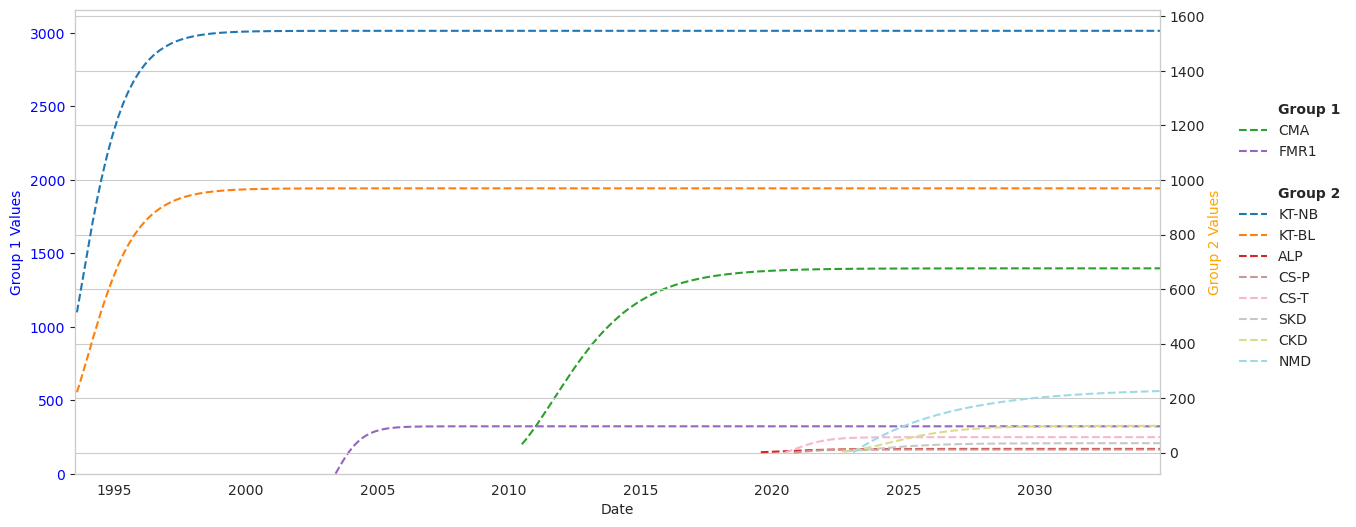

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D  # For creating dummy legend handles

# Custom titles mapping for items
custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
}

# Load the data (update the file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories
items_to_include = [
    '73287', '73289', '73292', '73298',
    '73300', '73358', '73359', '73401', '73402',
    '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# Drop categories with no data
data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# Prediction range (used for extending forecasts)
prediction_end = pd.Timestamp('2034-09-30')

# Separate items into two groups.
# Ensure that '73300' is in Group 1 (with '73292') and not in Group 2.
group1 = ['73292', '73300']
group2 = [item for item in valid_items if item not in group1]

# Determine common x-axis start date from the filtered data
common_x_start = filtered_data.index.min()

# Compute common y-axis range from both historical and model-predicted data.
def calculate_future_range(data, models):
    all_values = data['Value'].tolist()
    for item in valid_items:
        item_data = data[data['Item'] == item]['Value'].resample('ME').sum().dropna()
        if not item_data.empty:
            # Apply smoothing and use only the first 5 years (60 months)
            item_data = item_data.rolling(window=12, min_periods=1).mean().iloc[:60]
            # Create a new time axis in years
            years = np.arange(len(item_data)) / 12.0
            future_months = (prediction_end - item_data.index[-1]).days // 30 + 1
            prediction_years = np.arange(len(item_data) + future_months) / 12.0
            for model_name, model_func in models.items():
                try:
                    # Use basic initial guesses here (for range estimation only)
                    params, _ = curve_fit(model_func, years, item_data, maxfev=10000)
                    future_predicted = model_func(prediction_years, *params)
                    all_values.extend(future_predicted)
                except Exception:
                    continue
    return min(all_values), max(all_values)

models = {
    "Logistic Diffusion": logistic_diffusion,
    "Gompertz": gompertz,
    "Bass Diffusion": bass_diffusion
}
common_y_min, common_y_max = calculate_future_range(filtered_data, models)

# Plot settings
fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(valid_items)))
color_mapping = dict(zip(valid_items, colors))

# Storage for legend handles, separated by group.
legend_handles_group1 = []
legend_handles_group2 = []

# Iterate through each group and fit models with optimized initial guesses and bounds.
for group, axis in [(group1, ax), (group2, ax.twinx())]:
    for item in group:
        # Resample monthly (using end-of-month) and sum the values
        item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum().dropna()
        if item_data.empty:
            print(f"Item {item} has no data after resampling. Skipping.")
            continue

        # Apply a 12-month moving average to smooth the data
        item_data = item_data.rolling(window=12, min_periods=1).mean()
        # Use only the first 5 years (60 months) of data
        item_data = item_data.iloc[:60]
        
        # Create a new time axis in years (0, 1/12, 2/12, …)
        years = np.arange(len(item_data)) / 12.0
        # Determine how many months to forecast into the future
        future_months = (prediction_end - item_data.index[-1]).days // 30 + 1
        prediction_years = np.arange(len(item_data) + future_months) / 12.0

        # Compute basic heuristics from the data for initial guesses.
        y_max = item_data.max()
        t_mid = np.median(years)

        best_model_name = None
        best_model_metrics = {'r2': -np.inf}  # Initialize with a very low r2 value.
        best_model_predicted = None

        for model_name, model_func in models.items():
            try:
                # Set improved initial guesses (p0) and bounds using the new time axis.
                if model_name == "Logistic Diffusion":
                    p0 = [y_max * 1.5, 0.1, t_mid]
                    # t0 is in years; allow it to vary between 0 and the last observed year.
                    bounds = ([0, 0, 0], [y_max * 10, 1, years[-1]])
                elif model_name == "Gompertz":
                    p0 = [y_max, 1, 0.1]
                    bounds = ([0, 0, 0], [y_max * 10, 10, 1])
                elif model_name == "Bass Diffusion":
                    p0 = [0.03, 0.38, y_max * 1.5]
                    bounds = ([0, 0, 0], [1, 1, y_max * 10])
                else:
                    p0 = None
                    bounds = (-np.inf, np.inf)

                # Fit the model using the time axis in years.
                params, _ = curve_fit(
                    model_func, years, item_data,
                    p0=p0, bounds=bounds, maxfev=10000
                )
                predicted = model_func(years, *params)
                future_predicted = model_func(prediction_years, *params)
                r2 = r2_score(item_data, predicted)

                if r2 > best_model_metrics['r2']:
                    best_model_name = model_name
                    best_model_metrics = {'r2': r2}
                    best_model_predicted = future_predicted

            except Exception as e:
                print(f"Error fitting {model_name} for item {item}: {e}")

        # Only plot if a best model was successfully fit.
        if best_model_predicted is not None:
            axis.plot(
                pd.date_range(start=item_data.index[0], periods=len(prediction_years), freq='ME'),
                best_model_predicted,
                label=f'{custom_titles.get(item, item)} Best Model: {best_model_name}',
                linestyle='--', color=color_mapping[item]
            )
            # Create a legend handle with the custom title.
            handle = Line2D([], [], color=color_mapping[item], linestyle='--',
                            label=custom_titles.get(item, item))
            if group == group1:
                legend_handles_group1.append(handle)
            else:
                legend_handles_group2.append(handle)

# Set common x-axis limits and force y-axis lower limit to 0.
ax.set_xlim([common_x_start, prediction_end])
ax.set_ylim([0, common_y_max])
ax.set_xlabel('Date')
ax.set_ylabel('Group 1 Values', color='blue')
ax.tick_params(axis='y', labelcolor='blue')

ax2 = ax.twinx()
ax2.set_ylim([0, common_y_max])
ax2.set_ylabel('Group 2 Values', color='orange', labelpad=35)
ax2.tick_params(axis='y', labelcolor='orange')
ax2.yaxis.set_ticks([])  # Optionally remove secondary axis tick labels

# Remove gridlines.
ax.grid(False, which='both')
ax2.grid(False, which='both')

#######################################
# Create a single combined legend with group headers.
#######################################
# Create dummy header handles (they will appear with only text)
dummy_header1 = Line2D([], [], color='none', label='Group 1')
dummy_header2 = Line2D([], [], color='none', label='Group 2')
dummy_spacer = Line2D([], [], color='none', label='')  # Blank spacer

combined_handles = [dummy_header1] + legend_handles_group1 + [dummy_spacer, dummy_header2] + legend_handles_group2

# Create a single legend (vertical list) and place it below the axes.
legend = ax.legend(handles=combined_handles, loc='lower center',
                   bbox_to_anchor=(1.12, 0.2), ncol=1, frameon=False)

# Optionally, adjust the text properties for dummy headers.
for text in legend.get_texts():
    label = text.get_text()
    if label in ['Group 1', 'Group 2']:
        text.set_fontweight('bold')

# Adjust layout to make room for the legend below the plot.
plt.subplots_adjust(bottom=0.3)
plt.show()


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Load the data (use your own path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only specific "Item" categories.
# KT-NB ('73287') and KT-BL ('73289') are dropped.
items_to_include = [
    '73292',   # CMA
    '73298',   # ALP (to be grouped in Kidney)
    '73300',   # FMR1 (keep individually)
    '73358',   # CS-P (to be grouped in CS)
    '73359',   # CS-T (to be grouped in CS)
    '73401',   # SKD (to be grouped in Kidney)
    '73402',   # CKD (to be grouped in Kidney)
    '73422'    # NMD
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# -- Create new virtual groups --

# CS group: combine items 73358 and 73359
cs_group = (
    filtered_data[filtered_data['Item'].isin(['73358', '73359'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
cs_group['Item'] = 'CS Combined'

# Kidney group: combine items 73298, 73401, and 73402
kidney_group = (
    filtered_data[filtered_data['Item'].isin(['73298', '73401', '73402'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
kidney_group['Item'] = 'Group 2'  # Label as Group 2

# Remove individual rows for items that are now part of the groups
filtered_data = filtered_data[~filtered_data['Item'].isin(['73358', '73359', '73298', '73401', '73402'])]

# Append the combined groups back to the filtered data
filtered_data = pd.concat(
    [
        filtered_data.reset_index(),   # Remaining individual items (e.g., CMA, FMR1, NMD)
        cs_group,                      # CS combined group
        kidney_group                   # Kidney combined group (Group 2)
    ],
    ignore_index=True
)

# Re-set index to Month and print unique items to verify groups are included
filtered_data.set_index('Month', inplace=True)
print("Unique items after grouping:", filtered_data['Item'].unique())

# Drop categories with no data
data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define custom titles mapping (friendly names)
custom_titles = {
    '73292': 'CMA',
    '73300': 'FMR1',
    '73422': 'NMD',
    'CS Combined': 'CS',
    'Group 2': 'Group 2'
}

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# Initialize lists to hold results and problematic fits
model_results = []
problematic_items = []

# Iterate through each item and fit only the diffusion models using the first five years of data
for item in valid_items:
    # Resample by month-end, sum, and drop missing values
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum().dropna()
    
    if item_data.empty:
        print(f"Item {item} has no data after resampling. Skipping.")
        continue
    
    # Use only the first five years (approximately 60 months) of data for this item.
    if len(item_data) >= 60:
        item_data = item_data.iloc[:60]
    else:
        item_data = item_data.copy()
    
    time_index = np.arange(len(item_data))
    
    # Define diffusion models to test
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    for model_name, model_func in models.items():
        try:
            # Fit the model
            params, _ = curve_fit(model_func, time_index, item_data, maxfev=10000)
            predicted = model_func(time_index, *params)
            r2 = 1 - np.sum((item_data - predicted) ** 2) / np.sum((item_data - np.mean(item_data)) ** 2)
            
            # Store results
            model_results.append({
                'Item': item,
                'Model': model_name,
                'r2': r2,
                'MAE': mean_absolute_error(item_data, predicted),
                'MAPE': mean_absolute_percentage_error(item_data, predicted)
            })
            
            # Check for problematic R² values
            if r2 < -1 or r2 > 1:
                problematic_items.append({
                    'Item': item,
                    'Model': model_name,
                    'R2': r2
                })
        except Exception as e:
            print(f"Error fitting {model_name} for item {item}: {e}")

# Convert results to DataFrame and add custom titles
results_df = pd.DataFrame(model_results)
results_df['Item_title'] = results_df['Item'].apply(lambda x: custom_titles[x] if x in custom_titles else x)

problematic_df = pd.DataFrame(problematic_items)

# Identify best models for each item based on highest R²
best_models = results_df.loc[results_df.groupby('Item')['r2'].idxmax()]

# Output best models with custom titles
print("Best Models for Each Item (using only the first five years of data):")
print(best_models[['Item', 'Item_title', 'Model', 'r2', 'MAE', 'MAPE']])

# Analyze diffusion model performance
diffusion_models = results_df[results_df['Model'].isin(["Logistic Diffusion", "Gompertz", "Bass Diffusion"])]

# For each item, pick the diffusion model with highest R²
diffusion_performance = diffusion_models.groupby('Item')['r2'].idxmax().apply(lambda idx: diffusion_models.loc[idx])

print("\nDiffusion Model Analysis (using only the first five years of data):")
for _, row in diffusion_performance.iterrows():
    print(f"Item {row['Item_title']} (code: {row['Item']}): Best Diffusion Model = {row['Model']} (R2 = {row['r2']:.2f})")
    if row['Model'] == "Logistic Diffusion":
        print("  - Indicates balanced growth with symmetric adoption.")
    elif row['Model'] == "Gompertz":
        print("  - Suggests gradual early adoption with rapid growth later.")
    elif row['Model'] == "Bass Diffusion":
        print("  - Reflects interplay of innovation and imitation in adoption.")


Unique items after grouping: ['73292' '73300' '73422' 'CS Combined' 'Group 2']
Error fitting Gompertz for item 73292: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Best Models for Each Item (using only the first five years of data):
           Item Item_title           Model        r2         MAE          MAPE
1         73292        CMA  Bass Diffusion  0.097049  261.166102  4.019505e-01
3         73300       FMR1        Gompertz  0.248781   50.823164  1.953921e-01
7         73422        NMD  Bass Diffusion  0.732352   13.953904  4.016996e-01
10  CS Combined         CS  Bass Diffusion  0.522982   15.394526  3.876913e-01
13      Group 2    Group 2  Bass Diffusion  0.811972    7.826901  1.298479e+15

Diffusion Model Analysis (using only the first five years of data):
Item CMA (code: 73292): Best Diffusion Model = Bass Diffusion (R2 = 0.10)
  - Reflects interplay of innovation and imitation in adoption.
Item FMR1 (code: 73300): Best Diffusion Model 

/tmp/ipykernel_952/773593866.py:64: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/tmp/ipykernel_952/773593866.py:64: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/home/doughnut/miniconda3/lib/p

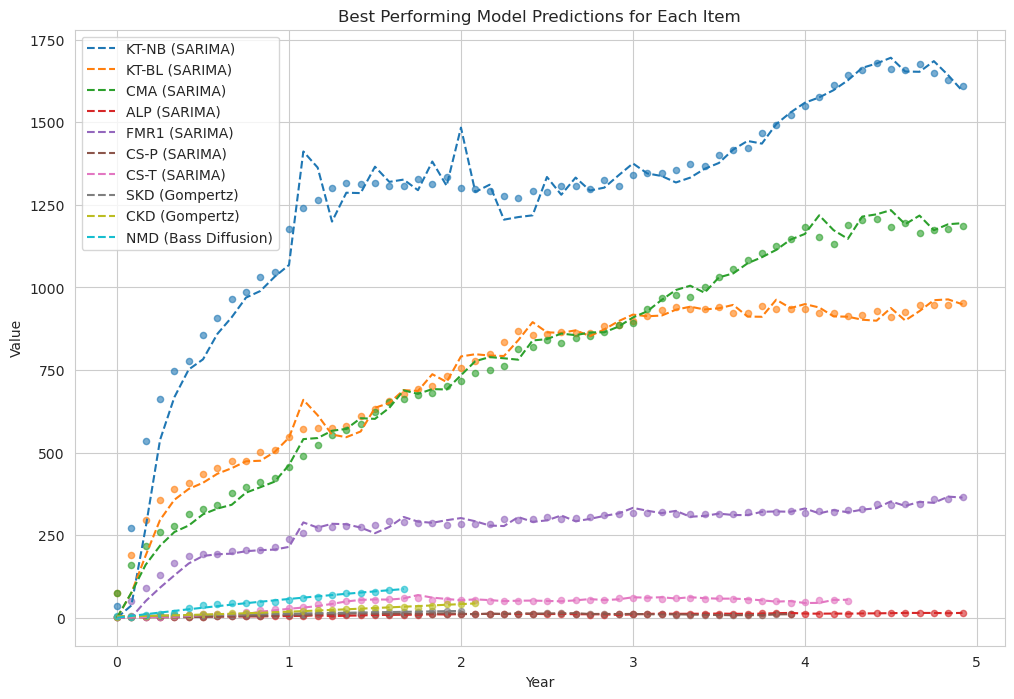

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

items_to_include = [
    '73287', '73289', '73292', '73298',
    '73300', '73358', '73359', '73401',
    '73402', '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
}

data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# This list will hold the best model's prediction and associated data for each item
best_predictions = []

# Loop over each valid item to fit models and select the best based on r2
for item in valid_items:
    display_name = custom_titles.get(item, item)
    
    # Resample data by month and sum the values, then apply a 12-month moving average
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
    item_data = item_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first 60 months (5 years) of data
    item_data = item_data.iloc[:60]
    if item_data.empty:
        print(f"Item {item} has no data after resampling and slicing. Skipping.")
        continue

    # Create a time axis in years (0, 1, 2, ...)
    years = np.arange(len(item_data)) / 12.0

    # Define models to fit
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = item_data.max()
    mid_t   = np.median(years)
    
    # Fit the diffusion models
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            predicted = model_func(years, *params)
            r2 = r2_score(item_data, predicted)
            results[model_name] = {
                'r2': r2,
                'predicted': predicted
            }
        except Exception as e:
            print(f"Error fitting {model_name} for item {item} ({display_name}): {e}")

    # Fit SARIMA model
    try:
        sarima_model = SARIMAX(item_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_pred = sarima_fit.fittedvalues
        sarima_r2 = r2_score(item_data, sarima_pred)
        results["SARIMA"] = {
            'r2': sarima_r2,
            'predicted': sarima_pred
        }
    except Exception as e:
        print(f"Error fitting SARIMA for item {item} ({display_name}): {e}")

    # Select the best-performing model based on the highest r2 score
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        best_predictions.append({
            'Item': item,
            'DisplayName': display_name,
            'BestModel': best_model_name,
            'Years': years,
            'Actual': item_data,
            'Predicted': best_model_metrics['predicted']
        })

# Now plot the best performing model predictions for each item on one plot
plt.figure(figsize=(12, 8))
for bp in best_predictions:
    plt.plot(bp['Years'], bp['Predicted'], linestyle='--',
             label=f"{bp['DisplayName']} ({bp['BestModel']})")
    # Optionally, plot the actual data points
    plt.scatter(bp['Years'], bp['Actual'], s=20, alpha=0.6)
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Best Performing Model Predictions for Each Item")
plt.legend()
plt.show()


/tmp/ipykernel_952/3480724807.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/3480724807.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/3480724807.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/3480724807.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/3480724807.py:63: FutureWarning: 'M' is deprecate

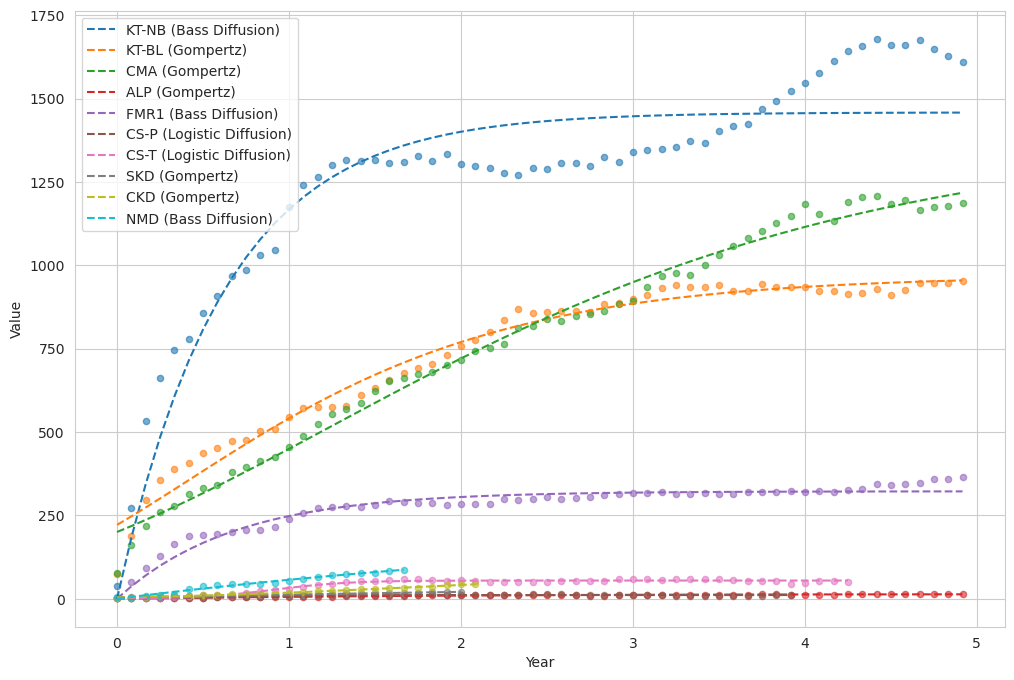

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

items_to_include = [
    '73287', '73289', '73292', '73298',
    '73300', '73358', '73359', '73401',
    '73402', '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
}

data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# This list will hold the best model's prediction and associated data for each item
best_predictions = []

# Loop over each valid item to fit diffusion models and select the best based on R²
for item in valid_items:
    display_name = custom_titles.get(item, item)
    
    # Resample data by month and sum the values, then apply a 12-month moving average
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
    item_data = item_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first 60 months (5 years) of data
    item_data = item_data.iloc[:60]
    if item_data.empty:
        print(f"Item {item} has no data after resampling and slicing. Skipping.")
        continue

    # Create a time axis in years (0, 1, 2, ...)
    years = np.arange(len(item_data)) / 12.0

    # Define diffusion models to fit
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = item_data.max()
    mid_t   = np.median(years)
    
    # Fit each diffusion model
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            predicted = model_func(years, *params)
            r2 = r2_score(item_data, predicted)
            results[model_name] = {
                'r2': r2,
                'predicted': predicted
            }
        except Exception as e:
            print(f"Error fitting {model_name} for item {item} ({display_name}): {e}")

    # Select the best-performing diffusion model based on the highest R² score
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        best_predictions.append({
            'Item': item,
            'DisplayName': display_name,
            'BestModel': best_model_name,
            'Years': years,
            'Actual': item_data,
            'Predicted': best_model_metrics['predicted']
        })

# Now plot the best performing diffusion model predictions for each item on one plot
plt.figure(figsize=(12, 8))
for bp in best_predictions:
    plt.plot(bp['Years'], bp['Predicted'], linestyle='--',
             label=f"{bp['DisplayName']} ({bp['BestModel']})")
    # Optionally, plot the actual data points
    plt.scatter(bp['Years'], bp['Actual'], s=20, alpha=0.6)
plt.xlabel("Year")
plt.ylabel("Value")
#plt.title("Best Performing Diffusion Model Predictions for Each Item")
plt.legend()
plt.show()


/tmp/ipykernel_772/3701029167.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/3701029167.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/3701029167.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/3701029167.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/3701029167.py:63: FutureWarning: 'M' is deprecate

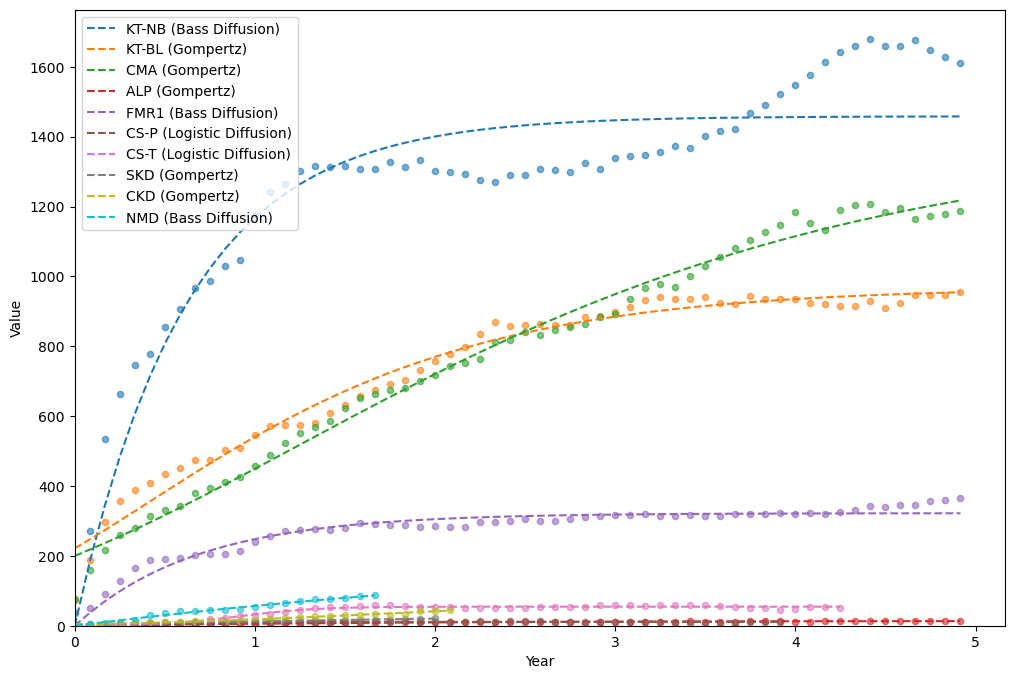

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

items_to_include = [
    '73287', '73289', '73292', '73298',
    '73300', '73358', '73359', '73401',
    '73402', '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
}

data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# This list will hold the best model's prediction and associated data for each item
best_predictions = []

# Loop over each valid item to fit diffusion models and select the best based on R²
for item in valid_items:
    display_name = custom_titles.get(item, item)
    
    # Resample data by month and sum the values, then apply a 12-month moving average
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
    item_data = item_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first 60 months (5 years) of data
    item_data = item_data.iloc[:60]
    if item_data.empty:
        print(f"Item {item} has no data after resampling and slicing. Skipping.")
        continue

    # Create a time axis in years (0, 1, 2, ...)
    years = np.arange(len(item_data)) / 12.0

    # Define diffusion models to fit
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = item_data.max()
    mid_t   = np.median(years)
    
    # Fit each diffusion model
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            predicted = model_func(years, *params)
            r2 = r2_score(item_data, predicted)
            results[model_name] = {
                'r2': r2,
                'predicted': predicted
            }
        except Exception as e:
            print(f"Error fitting {model_name} for item {item} ({display_name}): {e}")

    # Select the best-performing diffusion model based on the highest R² score
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        best_predictions.append({
            'Item': item,
            'DisplayName': display_name,
            'BestModel': best_model_name,
            'Years': years,
            'Actual': item_data,
            'Predicted': best_model_metrics['predicted']
        })

# Now plot the best performing diffusion model predictions for each item on one plot
plt.figure(figsize=(12, 8))
for bp in best_predictions:
    plt.plot(bp['Years'], bp['Predicted'], linestyle='--',
             label=f"{bp['DisplayName']} ({bp['BestModel']})")
    # Optionally, plot the actual data points
    plt.scatter(bp['Years'], bp['Actual'], s=20, alpha=0.6)

plt.xlabel("Year")
plt.ylabel("Value")
plt.xlim(left=0)    # Ensure the x-axis starts at 0
plt.ylim(bottom=0)  # Ensure the y-axis starts at 0
# plt.title("Best Performing Diffusion Model Predictions for Each Item")
plt.legend()
plt.show()


/tmp/ipykernel_952/4057821709.py:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()


Error fitting Gompertz for group Kidney: Optimal parameters not found: The maximum number of function evaluations is exceeded.


/tmp/ipykernel_952/4057821709.py:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/4057821709.py:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()


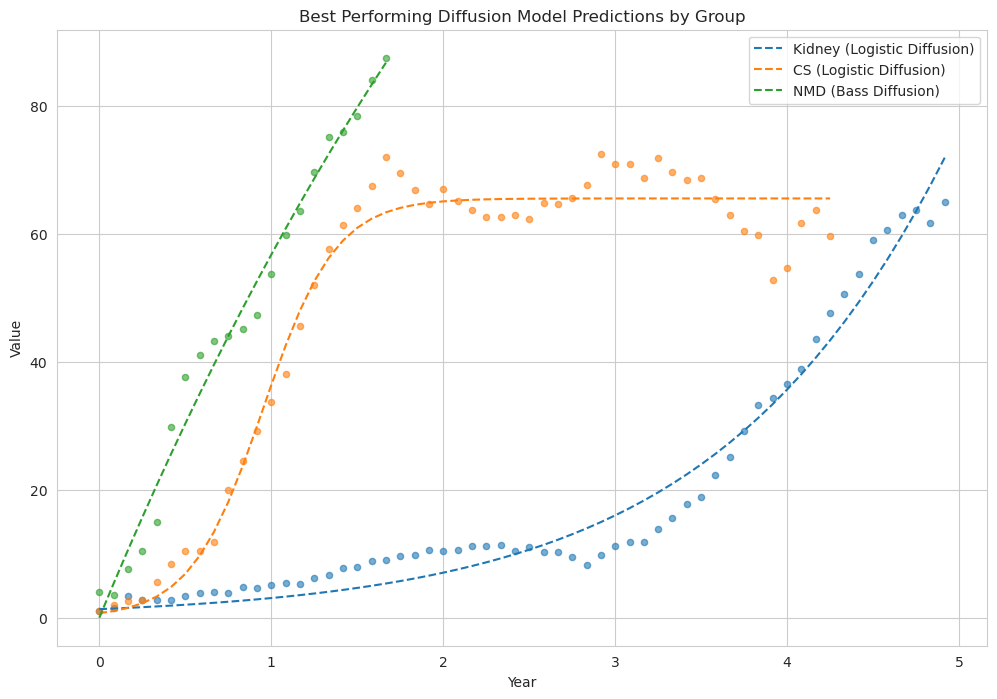

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define groups by original item codes
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],  # ALP, SKD, CKD
    'CS': ['73358', '73359'],                # CS-P, CS-T
    'NMD': ['73422']                        # NMD remains unchanged
}

# Filter the data to include only the items that are part of the groups
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# List to store the best model predictions per group
best_predictions = []

# Loop over each group
for group, items in group_definitions.items():
    # Aggregate data for the group by summing the 'Value's over time
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
    
    # Apply a 12-month moving average to smooth the data
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first 60 months (5 years) of data
    group_data = group_data.iloc[:60]
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Create a time axis in years (0, 1, 2, ...)
    years = np.arange(len(group_data)) / 12.0

    # Define diffusion models to fit
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = group_data.max()
    mid_t = np.median(years)
    
    # Fit each diffusion model
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            predicted = model_func(years, *params)
            r2 = r2_score(group_data, predicted)
            results[model_name] = {
                'r2': r2,
                'predicted': predicted
            }
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # Select the best-performing diffusion model based on the highest R² score
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        best_predictions.append({
            'Group': group,
            'BestModel': best_model_name,
            'Years': years,
            'Actual': group_data,
            'Predicted': best_model_metrics['predicted']
        })

# Plot the best performing diffusion model predictions for each group on one plot
plt.figure(figsize=(12, 8))
for bp in best_predictions:
    plt.plot(bp['Years'], bp['Predicted'], linestyle='--',
             label=f"{bp['Group']} ({bp['BestModel']})")
    # Optionally, plot the actual data points
    plt.scatter(bp['Years'], bp['Actual'], s=20, alpha=0.6)
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Best Performing Diffusion Model Predictions by Group")
plt.legend()
plt.show()


/tmp/ipykernel_952/3555385765.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()


Error fitting Gompertz for group Kidney: Optimal parameters not found: The maximum number of function evaluations is exceeded.


/tmp/ipykernel_952/3555385765.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/3555385765.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()


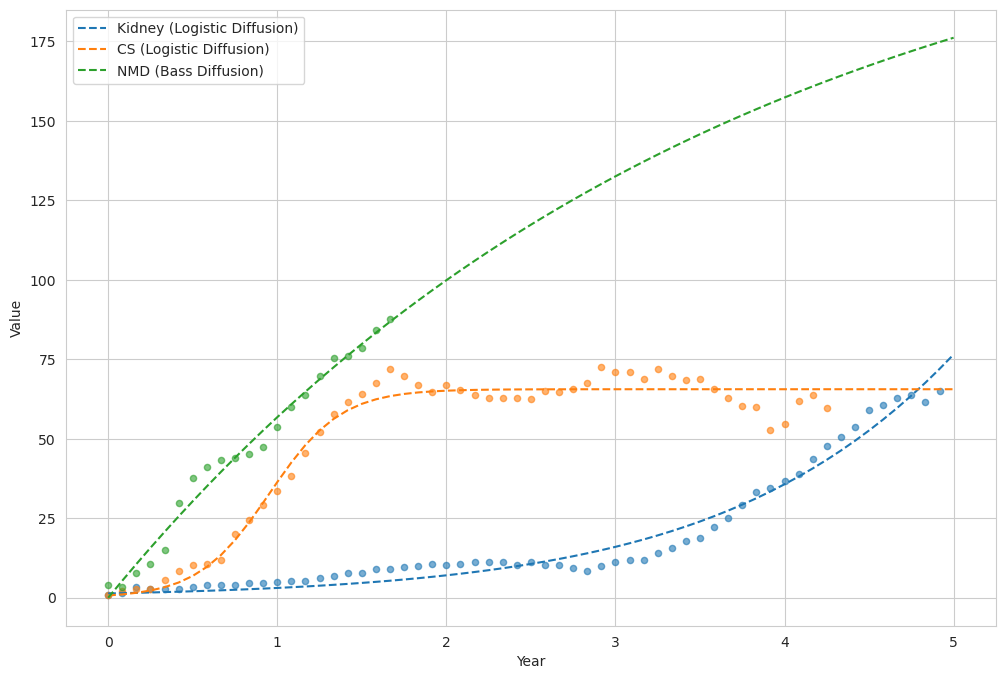

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define groups by original item codes:
# - Drop: KT-NB, KT-BL, CMA, FMR1
# - Group Kidney: ALP (73298), SKD (73401) and CKD (73402)
# - Group CS: CS-P (73358) and CS-T (73359)
# - Group NMD: remains as NMD (73422)
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422']
}

# Filter the data to include only the items that are part of our groups
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# This list will hold the best model predictions and related data per group
best_predictions = []

# Loop over each group
for group, items in group_definitions.items():
    # Aggregate data for the group by summing the 'Value's over time (monthly)
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
    
    # Apply a 12-month moving average to smooth the data
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first 60 months (5 years) of available data for fitting
    group_data = group_data.iloc[:60]
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Create a time axis (in years) for the available data
    fitted_years = np.arange(len(group_data)) / 12.0

    # Define diffusion models to fit
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)
    
    # Fit each diffusion model
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    fitted_years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    fitted_years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    fitted_years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            # Compute predictions on the fitted range and calculate R² on the available data
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {
                'r2': r2,
                'params': params,
                'func': model_func
            }
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # Select the best-performing diffusion model based on the highest R² score
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        # Create a time axis that spans a full 5 years (60 months)
        full_years = np.linspace(0, 5, 61)  # 61 points from 0 to 5 years
        best_pred_full = best_model_metrics['func'](full_years, *best_model_metrics['params'])
        best_predictions.append({
            'Group': group,
            'BestModel': best_model_name,
            'Years': full_years,
            'ActualYears': fitted_years,
            'Actual': group_data,
            'Predicted': best_pred_full
        })

# Plot the best performing diffusion model predictions for each group on one plot
plt.figure(figsize=(12, 8))
for bp in best_predictions:
    plt.plot(bp['Years'], bp['Predicted'], linestyle='--',
             label=f"{bp['Group']} ({bp['BestModel']})")
    # Plot the actual data points on their original time axis
    plt.scatter(bp['ActualYears'], bp['Actual'], s=20, alpha=0.6)
plt.xlabel("Year")
plt.ylabel("Value")
#plt.title("Best Performing Diffusion Model Predictions by Group (5-Year Forecast)")
plt.legend()
plt.show()


/tmp/ipykernel_952/3530317756.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()


Error fitting Gompertz for group Kidney: Optimal parameters not found: The maximum number of function evaluations is exceeded.


/tmp/ipykernel_952/3530317756.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/3530317756.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/3530317756.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/3530317756.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()


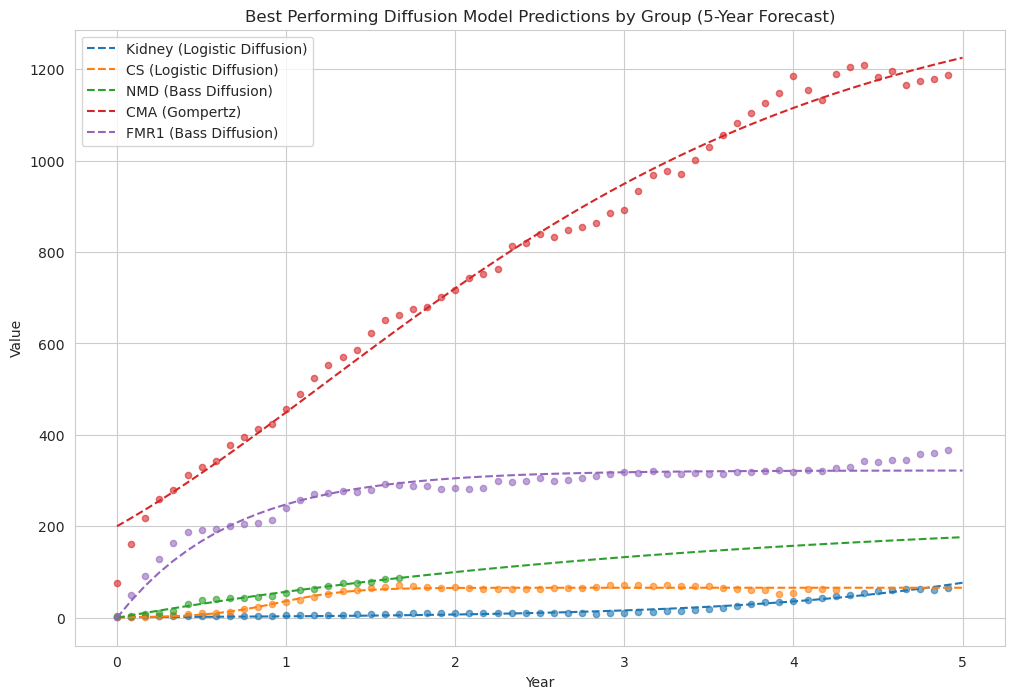

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define groups by original item codes:
# - Drop: KT-NB (73287) and KT-BL (73289)
# - Group Kidney: ALP (73298), SKD (73401) and CKD (73402)
# - Group CS: CS-P (73358) and CS-T (73359)
# - Group NMD: remains as NMD (73422)
# - Individual items added back: CMA (73292) and FMR1 (73300)
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300']
}

# Filter the data to include only the items that are part of our groups
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# This list will hold the best model predictions and related data per group
best_predictions = []

# Loop over each group
for group, items in group_definitions.items():
    # Aggregate data for the group by summing the 'Value's over time (monthly)
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
    
    # Apply a 12-month moving average to smooth the data
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first 60 months (5 years) of available data for fitting
    group_data = group_data.iloc[:60]
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Create a time axis (in years) for the available data
    fitted_years = np.arange(len(group_data)) / 12.0

    # Define diffusion models to fit
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)
    
    # Fit each diffusion model
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    fitted_years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    fitted_years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    fitted_years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            # Compute predictions on the fitted range and calculate R² on the available data
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {
                'r2': r2,
                'params': params,
                'func': model_func
            }
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # Select the best-performing diffusion model based on the highest R² score
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        # Create a time axis that spans a full 5 years (60 months)
        full_years = np.linspace(0, 5, 61)  # 61 points from 0 to 5 years
        best_pred_full = best_model_metrics['func'](full_years, *best_model_metrics['params'])
        best_predictions.append({
            'Group': group,
            'BestModel': best_model_name,
            'Years': full_years,
            'ActualYears': fitted_years,
            'Actual': group_data,
            'Predicted': best_pred_full
        })

# Plot the best performing diffusion model predictions for each group on one plot
plt.figure(figsize=(12, 8))
for bp in best_predictions:
    plt.plot(bp['Years'], bp['Predicted'], linestyle='--',
             label=f"{bp['Group']} ({bp['BestModel']})")
    # Plot the actual data points on their original time axis
    plt.scatter(bp['ActualYears'], bp['Actual'], s=20, alpha=0.6)
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Best Performing Diffusion Model Predictions by Group (5-Year Forecast)")
plt.legend()
plt.show()


/tmp/ipykernel_952/681051204.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()


Error fitting Gompertz for group Kidney: Optimal parameters not found: The maximum number of function evaluations is exceeded.


/tmp/ipykernel_952/681051204.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/681051204.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/681051204.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/681051204.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()


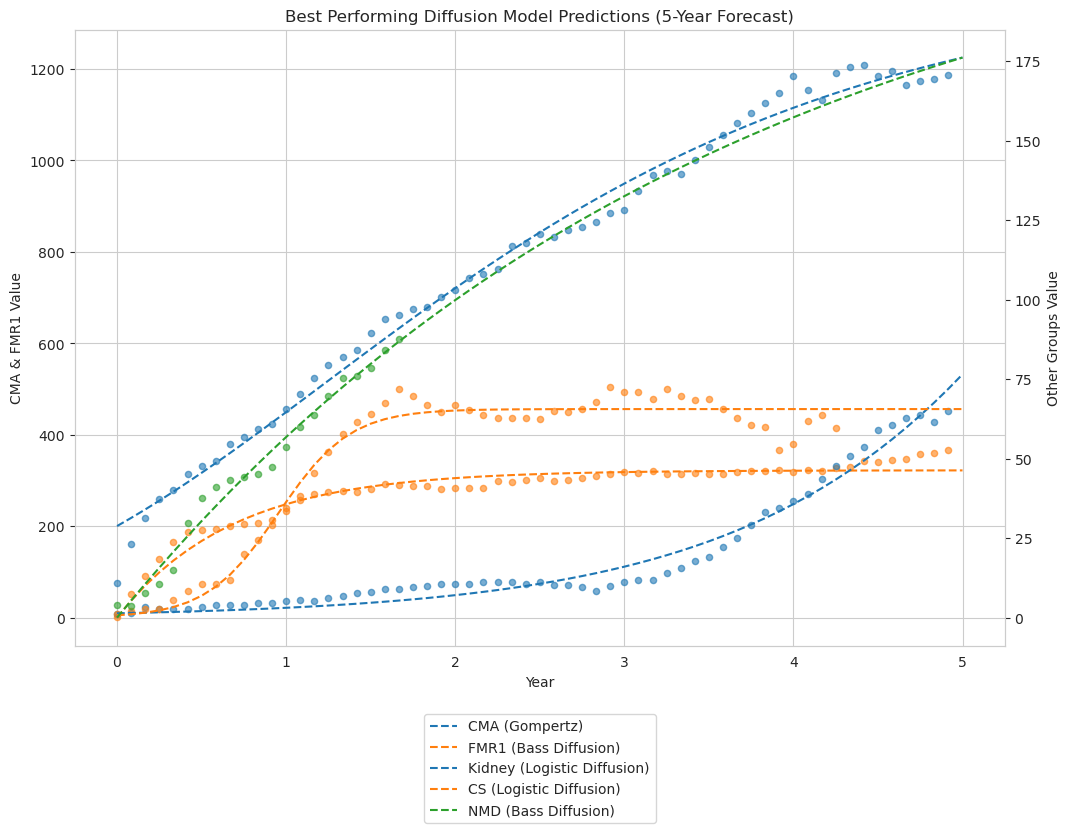

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define groups by original item codes:
# - Drop: KT-NB (73287) and KT-BL (73289)
# - Group Kidney: ALP (73298), SKD (73401) and CKD (73402)
# - Group CS: CS-P (73358) and CS-T (73359)
# - Group NMD: remains as NMD (73422)
# - Individual items: CMA (73292) and FMR1 (73300)
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300']
}

# Filter the data to include only the items that are part of our groups
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# This list will hold the best model predictions and related data per group
best_predictions = []

# Loop over each group to fit the models and generate predictions
for group, items in group_definitions.items():
    # Aggregate data for the group by summing the 'Value's over time (monthly)
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
    
    # Apply a 12-month moving average to smooth the data
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first 60 months (5 years) of available data for fitting
    group_data = group_data.iloc[:60]
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Create a time axis (in years) for the available data
    fitted_years = np.arange(len(group_data)) / 12.0

    # Define the diffusion models to fit
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)
    
    # Fit each diffusion model
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            # Compute predictions on the fitted range and calculate R² on the available data
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # Select the best-performing diffusion model based on the highest R² score
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        # Create a time axis that spans a full 5 years (60 months)
        full_years = np.linspace(0, 5, 61)  # 61 points from 0 to 5 years
        best_pred_full = best_model_metrics['func'](full_years, *best_model_metrics['params'])
        best_predictions.append({
            'Group': group,
            'BestModel': best_model_name,
            'Years': full_years,
            'ActualYears': fitted_years,
            'Actual': group_data,
            'Predicted': best_pred_full
        })

# Create dual y-axes: primary for CMA and FMR1, secondary for the remaining groups
fig, ax_primary = plt.subplots(figsize=(12, 8))
ax_secondary = ax_primary.twinx()

# Ensure gridlines come only from the primary axis so that the grid appears aligned.
ax_primary.grid(True)
ax_primary.set_axisbelow(True)
ax_secondary.grid(False)

# Plot predictions and actual data on the appropriate axes
for bp in best_predictions:
    if bp['Group'] in ["CMA", "FMR1"]:
        # Plot on the primary y-axis
        ax_primary.plot(bp['Years'], bp['Predicted'], linestyle='--',
                        label=f"{bp['Group']} ({bp['BestModel']})")
        ax_primary.scatter(bp['ActualYears'], bp['Actual'], s=20, alpha=0.6)
    else:
        # Plot on the secondary y-axis
        ax_secondary.plot(bp['Years'], bp['Predicted'], linestyle='--',
                          label=f"{bp['Group']} ({bp['BestModel']})")
        ax_secondary.scatter(bp['ActualYears'], bp['Actual'], s=20, alpha=0.6)

# Set labels and title
ax_primary.set_xlabel("Year")
ax_primary.set_ylabel("CMA & FMR1 Value")
ax_secondary.set_ylabel("Other Groups Value")
ax_primary.set_title("Best Performing Diffusion Model Predictions (5-Year Forecast)")

# Combine legends from both axes
lines1, labels1 = ax_primary.get_legend_handles_labels()
lines2, labels2 = ax_secondary.get_legend_handles_labels()
ax_primary.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1))

plt.show()


/tmp/ipykernel_772/2993460195.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()


Error fitting Gompertz for group Kidney: Optimal parameters not found: The maximum number of function evaluations is exceeded.


/tmp/ipykernel_772/2993460195.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/2993460195.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/2993460195.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/2993460195.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()


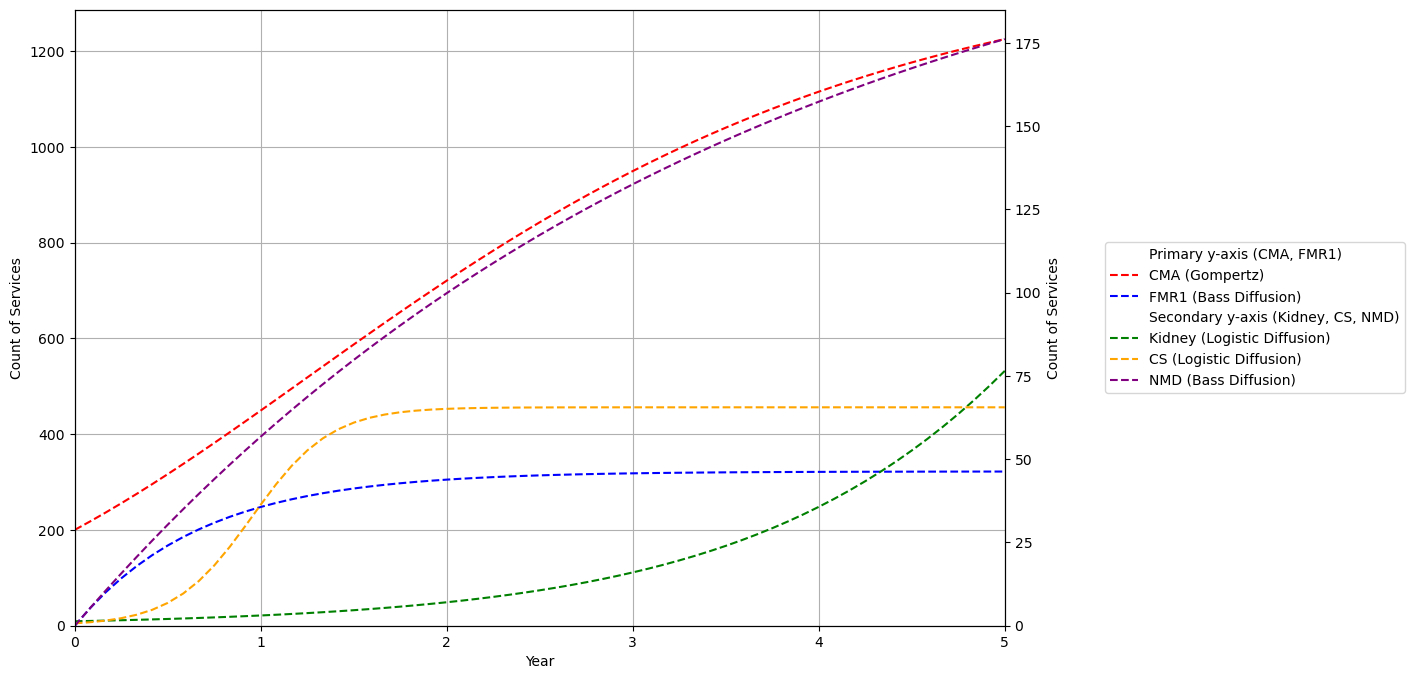

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define groups by original item codes:
# - Drop: KT-NB (73287) and KT-BL (73289)
# - Group Kidney: ALP (73298), SKD (73401) and CKD (73402)
# - Group CS: CS-P (73358) and CS-T (73359)
# - Group NMD: remains as NMD (73422)
# - Individual items: CMA (73292) and FMR1 (73300)
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300']
}

# Assign distinct colours for each group
color_map = {
    'Kidney': 'green',
    'CS': 'orange',
    'NMD': 'purple',
    'CMA': 'red',
    'FMR1': 'blue'
}

# Filter the data to include only the items that are part of our groups
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# This list will hold the best model predictions and related data per group
best_predictions = []

# Loop over each group to fit the models and generate predictions
for group, items in group_definitions.items():
    # Aggregate data for the group by summing the 'Value's over time (monthly)
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
    
    # Apply a 12-month moving average to smooth the data
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first 60 months (5 years) of available data for fitting
    group_data = group_data.iloc[:60]
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Create a time axis (in years) for the available data
    fitted_years = np.arange(len(group_data)) / 12.0

    # Define the diffusion models to fit
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)
    
    # Fit each diffusion model
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            # Compute predictions on the fitted range and calculate R² on the available data
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # Select the best-performing diffusion model based on the highest R² score
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        # Create a time axis that spans a full 5 years (60 months)
        full_years = np.linspace(0, 5, 61)  # 61 points from 0 to 5 years
        best_pred_full = best_model_metrics['func'](full_years, *best_model_metrics['params'])
        best_predictions.append({
            'Group': group,
            'BestModel': best_model_name,
            'Years': full_years,
            'Predicted': best_pred_full
        })

# Create dual y-axes: primary for CMA and FMR1, secondary for the remaining groups
fig, ax_primary = plt.subplots(figsize=(12, 8))
ax_secondary = ax_primary.twinx()

# Ensure gridlines come only from the primary axis so that the grid appears aligned.
ax_primary.grid(True)
ax_primary.set_axisbelow(True)
ax_secondary.grid(False)

# Prepare lists to collect handles and labels for the combined legend
primary_handles, primary_labels = [], []
secondary_handles, secondary_labels = [], []

# Plot only the prediction curves with clearly distinct colours and store handles for legends
for bp in best_predictions:
    color = color_map.get(bp['Group'], None)
    label = f"{bp['Group']} ({bp['BestModel']})"
    if bp['Group'] in ["CMA", "FMR1"]:
        line, = ax_primary.plot(bp['Years'], bp['Predicted'], linestyle='--', color=color, label=label)
        primary_handles.append(line)
        primary_labels.append(label)
    else:
        line, = ax_secondary.plot(bp['Years'], bp['Predicted'], linestyle='--', color=color, label=label)
        secondary_handles.append(line)
        secondary_labels.append(label)

# Set x-axis limits so that 0 and 5 are the edges and force both y-axes to start at 0
ax_primary.set_xlim(0, 5)
ax_primary.set_ylim(bottom=0)
ax_secondary.set_ylim(bottom=0)

# Set x-axis label and y-axis labels to "Count of Services"
ax_primary.set_xlabel("Year")
ax_primary.set_ylabel("Count of Services")
ax_secondary.set_ylabel("Count of Services")
#ax_primary.set_title("Best Performing Diffusion Model Predictions (5-Year Forecast)")

# Create dummy handles for legend grouping headers
dummy_primary = Line2D([], [], linestyle='None', label="Primary y-axis (CMA, FMR1)")
dummy_secondary = Line2D([], [], linestyle='None', label="Secondary y-axis (Kidney, CS, NMD)")

# Combine the handles and labels into one legend with headers for each group
combined_handles = [dummy_primary] + primary_handles + [dummy_secondary] + secondary_handles
combined_labels = [dummy_primary.get_label()] + primary_labels + [dummy_secondary.get_label()] + secondary_labels

# Place the legend on the right side of the plot
ax_primary.legend(combined_handles, combined_labels, loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.show()


/tmp/ipykernel_952/2214330384.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/2214330384.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/2214330384.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/2214330384.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_952/2214330384.py:65: FutureWarni

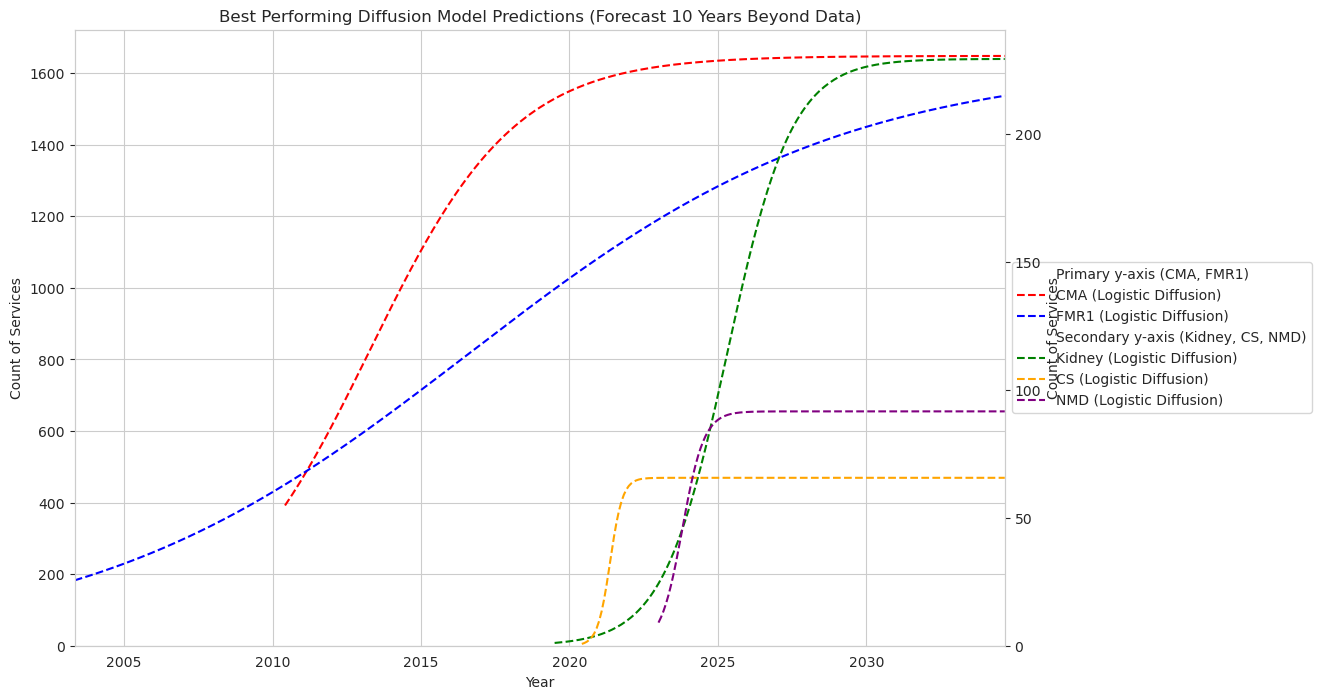

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define groups by original item codes:
# - Drop: KT-NB (73287) and KT-BL (73289)
# - Group Kidney: ALP (73298), SKD (73401) and CKD (73402)
# - Group CS: CS-P (73358) and CS-T (73359)
# - Group NMD: remains as NMD (73422)
# - Individual items: CMA (73292) and FMR1 (73300)
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300']
}

# Assign distinct colours for each group
color_map = {
    'Kidney': 'green',
    'CS': 'orange',
    'NMD': 'purple',
    'CMA': 'red',
    'FMR1': 'blue'
}

# Filter the data to include only the items that are part of our groups
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# This list will hold the best model predictions and related data per group
best_predictions = []

# Loop over each group to fit the models and generate predictions
for group, items in group_definitions.items():
    # Aggregate data for the group by summing the 'Value's over time (monthly)
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
    
    # Apply a 12-month moving average to smooth the data
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    # Use all available data (do not truncate)
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Convert the date index to actual decimal years (year + (month-1)/12)
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    # Define the diffusion models to fit
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)
    
    # Fit each diffusion model
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            # Compute predictions on the fitted range and calculate R² on the available data
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # Select the best-performing diffusion model based on the highest R² score
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        # Forecast: from the first observed year to 10 years beyond the last observed year.
        start_year = fitted_years[0]
        end_year = fitted_years[-1]
        num_points = int((end_year - start_year + 10) * 12) + 1  # monthly resolution
        forecast_years = np.linspace(start_year, end_year + 10, num_points)
        best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
        best_predictions.append({
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full
        })

# Create dual y-axes: primary for CMA and FMR1, secondary for the remaining groups
fig, ax_primary = plt.subplots(figsize=(12, 8))
ax_secondary = ax_primary.twinx()

# Ensure gridlines come only from the primary axis so that the grid appears aligned.
ax_primary.grid(True)
ax_primary.set_axisbelow(True)
ax_secondary.grid(False)

# Prepare lists to collect handles and labels for the combined legend
primary_handles, primary_labels = [], []
secondary_handles, secondary_labels = [], []

# Plot only the prediction curves with clearly distinct colours and store handles for legend
for bp in best_predictions:
    color = color_map.get(bp['Group'], None)
    label = f"{bp['Group']} ({bp['BestModel']})"
    if bp['Group'] in ["CMA", "FMR1"]:
        line, = ax_primary.plot(bp['Years'], bp['Predicted'], linestyle='--', color=color, label=label)
        primary_handles.append(line)
        primary_labels.append(label)
    else:
        line, = ax_secondary.plot(bp['Years'], bp['Predicted'], linestyle='--', color=color, label=label)
        secondary_handles.append(line)
        secondary_labels.append(label)

# Set x-axis limits based on the overall forecast period
global_start = min(bp['Years'][0] for bp in best_predictions)
global_end = max(bp['Years'][-1] for bp in best_predictions)
ax_primary.set_xlim(global_start, global_end)
# Force both y-axes to start at 0
ax_primary.set_ylim(bottom=0)
ax_secondary.set_ylim(bottom=0)

# Set x-axis label and y-axis labels to "Count of Services"
ax_primary.set_xlabel("Year")
ax_primary.set_ylabel("Count of Services")
ax_secondary.set_ylabel("Count of Services")
ax_primary.set_title("Best Performing Diffusion Model Predictions (Forecast 10 Years Beyond Data)")

# Create dummy handles for legend grouping headers
dummy_primary = Line2D([], [], linestyle='None', label="Primary y-axis (CMA, FMR1)")
dummy_secondary = Line2D([], [], linestyle='None', label="Secondary y-axis (Kidney, CS, NMD)")

# Combine the handles and labels into one legend with headers for each group
combined_handles = [dummy_primary] + primary_handles + [dummy_secondary] + secondary_handles
combined_labels = [dummy_primary.get_label()] + primary_labels + [dummy_secondary.get_label()] + secondary_labels

# Place the combined legend on the right side of the plot
ax_primary.legend(combined_handles, combined_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


/tmp/ipykernel_772/1097003924.py:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/1097003924.py:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/1097003924.py:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/1097003924.py:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/1097003924.py:121: FutureWarn

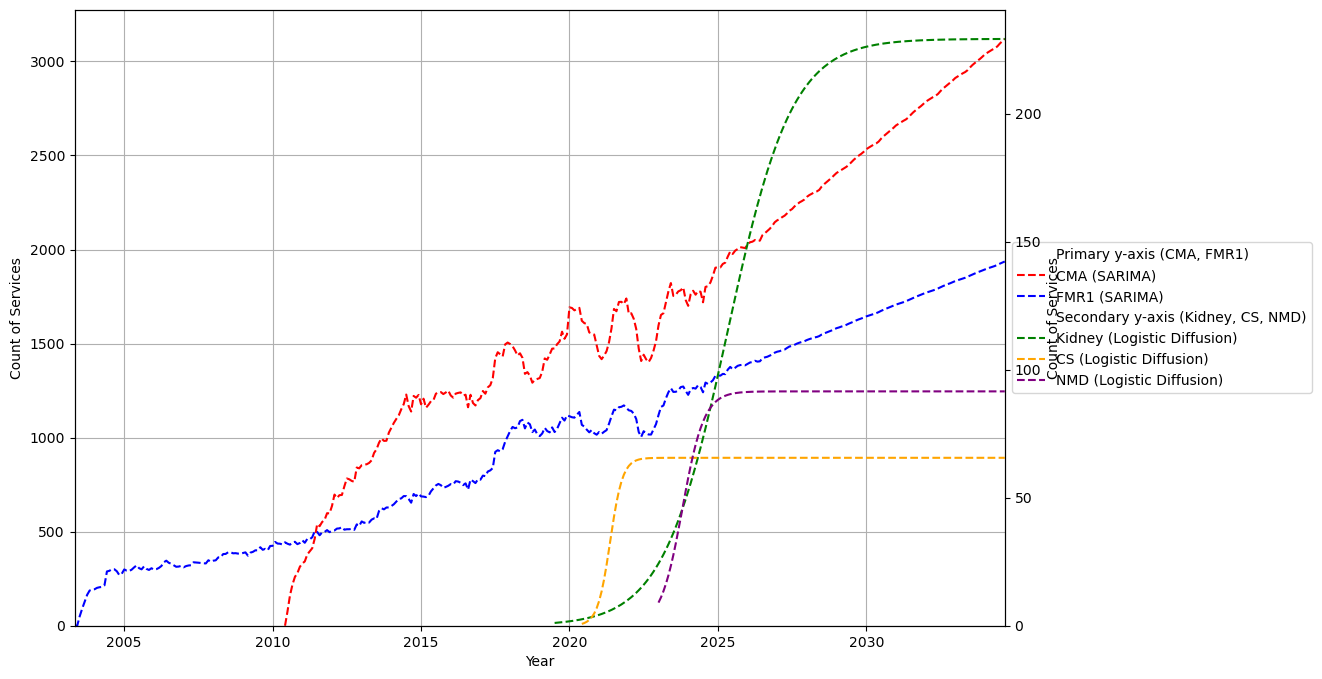

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define groups by original item codes:
# - Drop: KT-NB (73287) and KT-BL (73289)
# - Group Kidney: ALP (73298), SKD (73401) and CKD (73402)
# - Group CS: CS-P (73358) and CS-T (73359)
# - Group NMD: remains as NMD (73422)
# - Individual items: CMA (73292) and FMR1 (73300)
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300']
}

# Assign distinct colours for each group
color_map = {
    'Kidney': 'green',
    'CS': 'orange',
    'NMD': 'purple',
    'CMA': 'red',
    'FMR1': 'blue'
}

# Filter data to include only relevant items
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# List to hold best model predictions and associated forecast data per group
best_predictions = []

# Loop through each group
for group, items in group_definitions.items():
    # Aggregate monthly data by summing values
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
    
    # Smooth data with a 12-month moving average
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Convert the index to actual decimal years (year + (month-1)/12)
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    # Dictionary to hold candidate models and their performance
    results = {}
    
    # --- Diffusion Models ---
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    max_val = group_data.max()
    mid_t = np.median(fitted_years)
    
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")
    
    # --- SARIMA Model (only for CMA and FMR1) ---
    if group in ["CMA", "FMR1"]:
        try:
            sarima_model = SARIMAX(group_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.fittedvalues
            sarima_r2 = r2_score(group_data, sarima_pred)
            # Forecast from the first date to 10 years beyond the last date
            forecast_index = pd.date_range(start=group_data.index[0],
                                           end=group_data.index[-1] + pd.DateOffset(years=10),
                                           freq='M')
            sarima_forecast = sarima_fit.predict(start=group_data.index[0],
                                                 end=group_data.index[-1] + pd.DateOffset(years=10),
                                                 dynamic=False)
            # Convert forecast index to decimal years
            forecast_years_sarima = forecast_index.year + (forecast_index.month - 1) / 12.0
            results["SARIMA"] = {'r2': sarima_r2,
                                 'forecast_years': forecast_years_sarima,
                                 'forecast': sarima_forecast.values}
        except Exception as e:
            print(f"Error fitting SARIMA for group {group}: {e}")
    
    # --- Select Best Model and Forecast ---
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        if best_model_name == "SARIMA":
            forecast_years = best_model_metrics['forecast_years']
            best_pred_full = best_model_metrics['forecast']
        else:
            # Forecast from the first observed decimal year to 10 years beyond the last observed year
            start_year = fitted_years[0]
            end_year = fitted_years[-1]
            num_points = int((end_year - start_year + 10) * 12) + 1  # monthly resolution
            forecast_years = np.linspace(start_year, end_year + 10, num_points)
            best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
        best_predictions.append({
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full
        })

# --- Plotting ---
# Create dual y-axes: primary for CMA and FMR1, secondary for the remaining groups
fig, ax_primary = plt.subplots(figsize=(12, 8))
ax_secondary = ax_primary.twinx()

# Enable gridlines only on the primary axis
ax_primary.grid(True)
ax_primary.set_axisbelow(True)
ax_secondary.grid(False)

# Prepare lists to collect handles and labels for the combined legend
primary_handles, primary_labels = [], []
secondary_handles, secondary_labels = [], []

# Plot only the prediction curves with distinct colours and store legend handles
for bp in best_predictions:
    color = color_map.get(bp['Group'], None)
    label = f"{bp['Group']} ({bp['BestModel']})"
    if bp['Group'] in ["CMA", "FMR1"]:
        line, = ax_primary.plot(bp['Years'], bp['Predicted'], linestyle='--', color=color, label=label)
        primary_handles.append(line)
        primary_labels.append(label)
    else:
        line, = ax_secondary.plot(bp['Years'], bp['Predicted'], linestyle='--', color=color, label=label)
        secondary_handles.append(line)
        secondary_labels.append(label)

# Set x-axis limits based on overall forecast period
global_start = min(bp['Years'][0] for bp in best_predictions)
global_end = max(bp['Years'][-1] for bp in best_predictions)
ax_primary.set_xlim(global_start, global_end)
# Force both y-axes to start at 0
ax_primary.set_ylim(bottom=0)
ax_secondary.set_ylim(bottom=0)

# Set axis labels and title
ax_primary.set_xlabel("Year")
ax_primary.set_ylabel("Count of Services")
ax_secondary.set_ylabel("Count of Services")
#ax_primary.set_title("Best Performing Model Predictions (Forecast 10 Years Beyond Data)")

# Create dummy handles for legend grouping headers
dummy_primary = Line2D([], [], linestyle='None', label="Primary y-axis (CMA, FMR1)")
dummy_secondary = Line2D([], [], linestyle='None', label="Secondary y-axis (Kidney, CS, NMD)")

# Combine the handles into a single legend with headers
combined_handles = [dummy_primary] + primary_handles + [dummy_secondary] + secondary_handles
combined_labels = ([dummy_primary.get_label()] + primary_labels +
                   [dummy_secondary.get_label()] + secondary_labels)

# Place the combined legend on the right side of the plot
ax_primary.legend(combined_handles, combined_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


/tmp/ipykernel_772/3447326372.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/3447326372.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/3447326372.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/3447326372.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_772/3447326372.py:120: FutureWarn

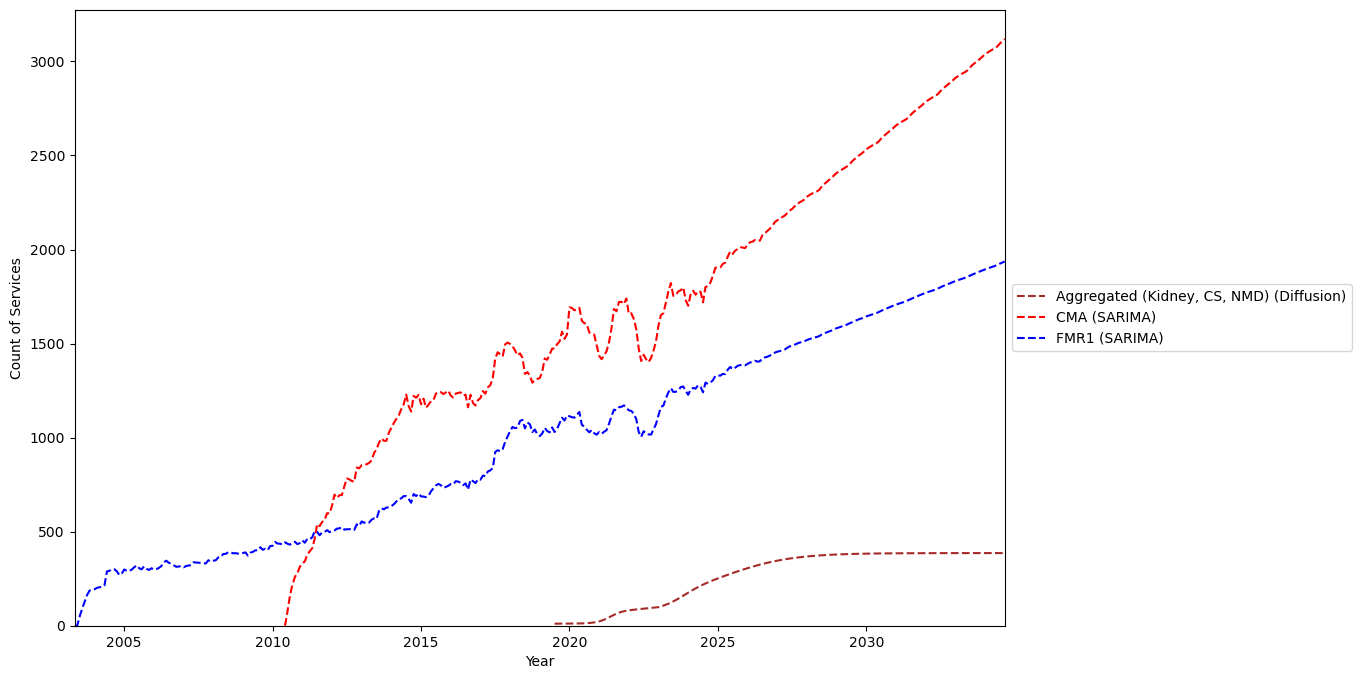

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define groups by original item codes:
# - Drop: KT-NB (73287) and KT-BL (73289)
# - Group Kidney: ALP (73298), SKD (73401) and CKD (73402)
# - Group CS: CS-P (73358) and CS-T (73359)
# - Group NMD: remains as NMD (73422)
# - Individual items: CMA (73292) and FMR1 (73300)
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300']
}

# Assign colours for primary groups (CMA and FMR1)
color_map = {
    'CMA': 'red',
    'FMR1': 'blue'
}
# For the aggregated secondary forecast, assign its own color:
agg_color = 'brown'

# Filter data to include only relevant items
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# List to hold best model forecasts for each group
best_predictions = []

# Loop through each group
for group, items in group_definitions.items():
    # Aggregate monthly data by summing values
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
    
    # Smooth data with a 12-month moving average
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Convert date index to actual decimal years (e.g. 2010.25 for April 2010)
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    # Dictionary to hold candidate models and their performance
    results = {}
    
    # --- Diffusion Models ---
    diffusion_models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    max_val = group_data.max()
    mid_t = np.median(fitted_years)
    
    for model_name, model_func in diffusion_models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")
    
    # --- SARIMA Model (only for CMA and FMR1) ---
    if group in ["CMA", "FMR1"]:
        try:
            sarima_model = SARIMAX(group_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.fittedvalues
            sarima_r2 = r2_score(group_data, sarima_pred)
            # Forecast from the first observed date to 10 years beyond the last observed date
            forecast_index = pd.date_range(start=group_data.index[0],
                                           end=group_data.index[-1] + pd.DateOffset(years=10),
                                           freq='M')
            sarima_forecast = sarima_fit.predict(start=group_data.index[0],
                                                 end=group_data.index[-1] + pd.DateOffset(years=10),
                                                 dynamic=False)
            # Convert forecast index to decimal years
            forecast_years_sarima = forecast_index.year + (forecast_index.month - 1) / 12.0
            results["SARIMA"] = {'r2': sarima_r2,
                                 'forecast_years': forecast_years_sarima,
                                 'forecast': sarima_forecast.values}
        except Exception as e:
            print(f"Error fitting SARIMA for group {group}: {e}")
    
    # --- Select Best Model and Generate Forecast ---
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        if best_model_name == "SARIMA":
            forecast_years = best_model_metrics['forecast_years']
            best_pred_full = best_model_metrics['forecast']
        else:
            # Forecast from the first observed decimal year to 10 years beyond the last observed year
            start_year = fitted_years[0]
            end_year = fitted_years[-1]
            num_points = int((end_year - start_year + 10) * 12) + 1  # monthly resolution
            forecast_years = np.linspace(start_year, end_year + 10, num_points)
            best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
        
        best_predictions.append({
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full
        })

# --- Combine Secondary Groups ---
# Secondary groups: Kidney, CS, and NMD. We'll aggregate (sum) their forecasts.
secondary_groups = [bp for bp in best_predictions if bp['Group'] in ["Kidney", "CS", "NMD"]]
aggregated_secondary = None
if secondary_groups:
    # Determine a common forecast time grid from the union of their time intervals
    common_start = min(bp['Years'][0] for bp in secondary_groups)
    common_end = max(bp['Years'][-1] for bp in secondary_groups)
    num_points = int((common_end - common_start) * 12) + 1
    common_time = np.linspace(common_start, common_end, num_points)
    
    # Sum the forecasts after re-interpolating each forecast onto the common grid
    aggregated_forecast = np.zeros_like(common_time)
    for bp in secondary_groups:
        aggregated_forecast += np.interp(common_time, bp['Years'], bp['Predicted'])
    
    aggregated_secondary = {
        'Group': 'Aggregated (Kidney, CS, NMD)',
        'BestModel': "Diffusion",  # they all use diffusion models
        'Years': common_time,
        'Predicted': aggregated_forecast
    }

# --- Prepare Final Predictions ---
# Primary groups: CMA and FMR1 remain as individual curves.
primary_groups = [bp for bp in best_predictions if bp['Group'] in ["CMA", "FMR1"]]
# Final predictions: aggregated secondary plus primary groups
final_predictions = []
if aggregated_secondary is not None:
    final_predictions.append(aggregated_secondary)
final_predictions.extend(primary_groups)

# --- Plotting on a Single y-axis ---
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each forecast curve with distinct colours
handles = []
labels = []
for bp in final_predictions:
    if bp['Group'] in ["CMA", "FMR1"]:
        color = color_map.get(bp['Group'], None)
    else:
        color = agg_color
    line, = ax.plot(bp['Years'], bp['Predicted'], linestyle='--', color=color,
                    label=f"{bp['Group']} ({bp['BestModel']})")
    handles.append(line)
    labels.append(f"{bp['Group']} ({bp['BestModel']})")

# Set x-axis limits based on overall forecast period
global_start = min(bp['Years'][0] for bp in final_predictions)
global_end = max(bp['Years'][-1] for bp in final_predictions)
ax.set_xlim(global_start, global_end)
# Force y-axis to start at 0
ax.set_ylim(bottom=0)

# Set axis labels and title
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
#ax.set_title("Best Performing Model Predictions (Forecast 10 Years Beyond Data)")

# Place the legend on the right side of the plot
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


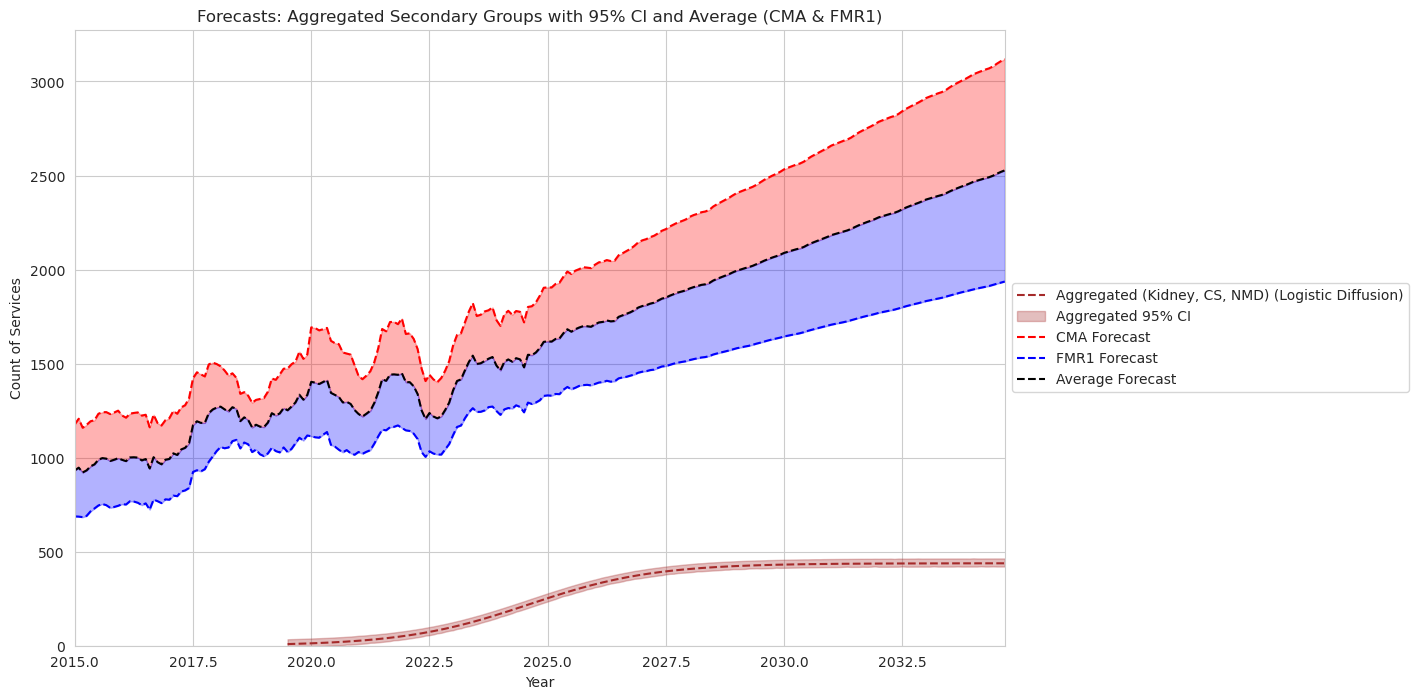

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# -------------------------
# Load and prepare the data
# -------------------------
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# -------------------------
# Define groups and settings
# -------------------------
# Secondary groups (to be aggregated): Kidney, CS, NMD
# Primary individual groups: CMA and FMR1
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300']
}

# Colours for primary groups and aggregated secondary forecast.
color_map = {
    'CMA': 'red',
    'FMR1': 'blue'
}
agg_color = 'brown'  # color for aggregated forecast

# Filter data for our items.
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

# -------------------------
# Define model functions (Diffusion Models)
# -------------------------
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# -------------------------
# Forecasting for each group
# -------------------------
# For each group we use all available data, smooth via a 12‐month moving average,
# convert the dates to decimal years, and then fit three diffusion models.
# For CMA and FMR1 we also fit SARIMA.
best_predictions = []
diffusion_models = {
    "Logistic Diffusion": logistic_diffusion,
    "Gompertz": gompertz,
    "Bass Diffusion": bass_diffusion
}

for group, items in group_definitions.items():
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('ME').sum().dropna()
    group_data = group_data.rolling(window=12, min_periods=1).mean()  # 12-month moving average
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Convert date index to decimal years (e.g. 2015.0, 2015.083, etc.)
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)
    
    # --- Diffusion Models ---
    for model_name, model_func in diffusion_models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0,0,0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0,0,0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")
    
    # --- SARIMA Model for CMA and FMR1 only ---
    if group in ["CMA", "FMR1"]:
        try:
            sarima_model = SARIMAX(group_data, order=(1,1,1), seasonal_order=(1,1,1,12))
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.fittedvalues
            sarima_r2 = r2_score(group_data, sarima_pred)
            forecast_index = pd.date_range(start=group_data.index[0],
                                           end=group_data.index[-1] + pd.DateOffset(years=10),
                                           freq='ME')
            sarima_forecast = sarima_fit.predict(start=group_data.index[0],
                                                 end=group_data.index[-1] + pd.DateOffset(years=10),
                                                 dynamic=False)
            forecast_years_sarima = forecast_index.year + (forecast_index.month - 1)/12.0
            results["SARIMA"] = {'r2': sarima_r2,
                                 'forecast_years': forecast_years_sarima,
                                 'forecast': sarima_forecast.values}
        except Exception as e:
            print(f"Error fitting SARIMA for group {group}: {e}")
    
    # --- Select Best Model and Generate Forecast ---
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        if best_model_name == "SARIMA":
            forecast_years = best_model_metrics['forecast_years']
            best_pred_full = best_model_metrics['forecast']
        else:
            start_year = fitted_years[0]
            end_year = fitted_years[-1]
            num_points = int((end_year - start_year + 10)*12) + 1  # monthly resolution
            forecast_years = np.linspace(start_year, end_year + 10, num_points)
            best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
        
        best_predictions.append({
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full
        })

# -------------------------
# Aggregated forecast for secondary groups (Kidney, CS, NMD)
# -------------------------
# Here, instead of aggregating the individual forecasts,
# we compute an aggregated series from the original data.
secondary_items = group_definitions["Kidney"] + group_definitions["CS"] + group_definitions["NMD"]
aggregated_series = filtered_data[filtered_data['Item'].isin(secondary_items)]['Value'].resample('ME').sum().dropna()
aggregated_series = aggregated_series.rolling(window=12, min_periods=1).mean()
fitted_years_agg = aggregated_series.index.year + (aggregated_series.index.month - 1)/12.0

# Fit the diffusion models on the aggregated series and choose the best (by R²).
best_result = None
for model_name, model_func in diffusion_models.items():
    try:
        if model_name == "Gompertz":
            p0 = [aggregated_series.max(), 1.0, 0.1]
            bounds = (0, [np.inf, np.inf, np.inf])
            params, _ = curve_fit(model_func, fitted_years_agg, aggregated_series,
                                  p0=p0, bounds=bounds, maxfev=10000)
        elif model_name == "Logistic Diffusion":
            p0 = [aggregated_series.max()*1.2, 0.1, np.median(fitted_years_agg)]
            bounds = ([0,0,0],[np.inf, np.inf, np.inf])
            params, _ = curve_fit(model_func, fitted_years_agg, aggregated_series,
                                  p0=p0, bounds=bounds, maxfev=10000)
        elif model_name == "Bass Diffusion":
            p0 = [0.01, 0.1, aggregated_series.max()*1.2]
            bounds = ([0,0,0],[np.inf, np.inf, np.inf])
            params, _ = curve_fit(model_func, fitted_years_agg, aggregated_series,
                                  p0=p0, bounds=bounds, maxfev=10000)
        fitted_pred_agg = model_func(fitted_years_agg, *params)
        r2 = r2_score(aggregated_series, fitted_pred_agg)
        if best_result is None or r2 > best_result['r2']:
            best_result = {'r2': r2, 'params': params, 'func': model_func, 'model_name': model_name}
    except Exception as e:
        print(f"Error fitting {model_name} for aggregated secondary: {e}")

if best_result is not None:
    start_year_agg = fitted_years_agg[0]
    end_year_agg = fitted_years_agg[-1]
    num_points_agg = int((end_year_agg - start_year_agg + 10)*12) + 1
    forecast_years_agg = np.linspace(start_year_agg, end_year_agg + 10, num_points_agg)
    forecast_agg = best_result['func'](forecast_years_agg, *best_result['params'])
    
    # Compute in-sample residuals.
    fitted_agg = best_result['func'](fitted_years_agg, *best_result['params'])
    residuals = aggregated_series - fitted_agg
    
    # -------------------------
    # Bootstrap to obtain 95% confidence intervals for the aggregated forecast.
    # -------------------------
    B = 500  # number of bootstrap replicates
    bootstrap_forecasts = np.zeros((B, len(forecast_years_agg)))
    for b in range(B):
        # For each forecast time point, sample an error from the residuals (with replacement)
        boot_errors = np.random.choice(residuals, size=len(forecast_years_agg), replace=True)
        bootstrap_forecasts[b, :] = forecast_agg + boot_errors
    ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)
    
    aggregated_secondary_forecast = {
        'Group': 'Aggregated (Kidney, CS, NMD)',
        'BestModel': best_result['model_name'],
        'Years': forecast_years_agg,
        'Predicted': forecast_agg,
        'CI_lower': ci_lower,
        'CI_upper': ci_upper
    }
else:
    aggregated_secondary_forecast = None

# -------------------------
# Extract forecasts for CMA and FMR1 and calculate their average from 2015 onward
# -------------------------
primary_forecasts = {bp['Group']: bp for bp in best_predictions if bp['Group'] in ["CMA", "FMR1"]}
if "CMA" in primary_forecasts and "FMR1" in primary_forecasts:
    years_cma = primary_forecasts["CMA"]['Years']
    pred_cma = primary_forecasts["CMA"]['Predicted']
    years_fmr1 = primary_forecasts["FMR1"]['Years']
    pred_fmr1 = primary_forecasts["FMR1"]['Predicted']
    
    common_start_avg = max(years_cma[0], years_fmr1[0], 2015)
    common_end_avg = min(years_cma[-1], years_fmr1[-1])
    num_points_avg = int((common_end_avg - common_start_avg)*12) + 1
    common_years_avg = np.linspace(common_start_avg, common_end_avg, num_points_avg)
    
    interp_cma = np.interp(common_years_avg, years_cma, pred_cma)
    interp_fmr1 = np.interp(common_years_avg, years_fmr1, pred_fmr1)
    avg_forecast = (interp_cma + interp_fmr1) / 2
else:
    raise ValueError("Forecasts for both CMA and FMR1 are required for averaging.")

# -------------------------
# Plotting all forecasts on a single y-axis
# -------------------------
fig, ax = plt.subplots(figsize=(12, 8))

# Plot aggregated secondary forecast (with bootstrapped CI) if available.
if aggregated_secondary_forecast is not None:
    ax.plot(aggregated_secondary_forecast['Years'], aggregated_secondary_forecast['Predicted'],
            linestyle='--', color=agg_color,
            label=f"{aggregated_secondary_forecast['Group']} ({aggregated_secondary_forecast['BestModel']})")
    ax.fill_between(aggregated_secondary_forecast['Years'],
                    aggregated_secondary_forecast['CI_lower'],
                    aggregated_secondary_forecast['CI_upper'],
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")

# Plot individual forecasts for CMA and FMR1.
ax.plot(common_years_avg, interp_cma, linestyle='--', color=color_map["CMA"], label="CMA Forecast")
ax.plot(common_years_avg, interp_fmr1, linestyle='--', color=color_map["FMR1"], label="FMR1 Forecast")

# Plot the average forecast using similar line style (line width 1.5).
ax.plot(common_years_avg, avg_forecast, linestyle='--', color='black', linewidth=1.5, label="Average Forecast")

# Shade the area between the average forecast and the individual forecasts.
ax.fill_between(common_years_avg, avg_forecast, interp_cma, color=color_map["CMA"], alpha=0.3)
ax.fill_between(common_years_avg, avg_forecast, interp_fmr1, color=color_map["FMR1"], alpha=0.3)

# Set axis limits and labels.
global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0] if aggregated_secondary_forecast is not None else common_years_avg[0])
global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1] if aggregated_secondary_forecast is not None else common_years_avg[-1])
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
ax.set_title("Forecasts: Aggregated Secondary Groups with 95% CI and Average (CMA & FMR1)")

# Create a legend and place it on the right side.
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


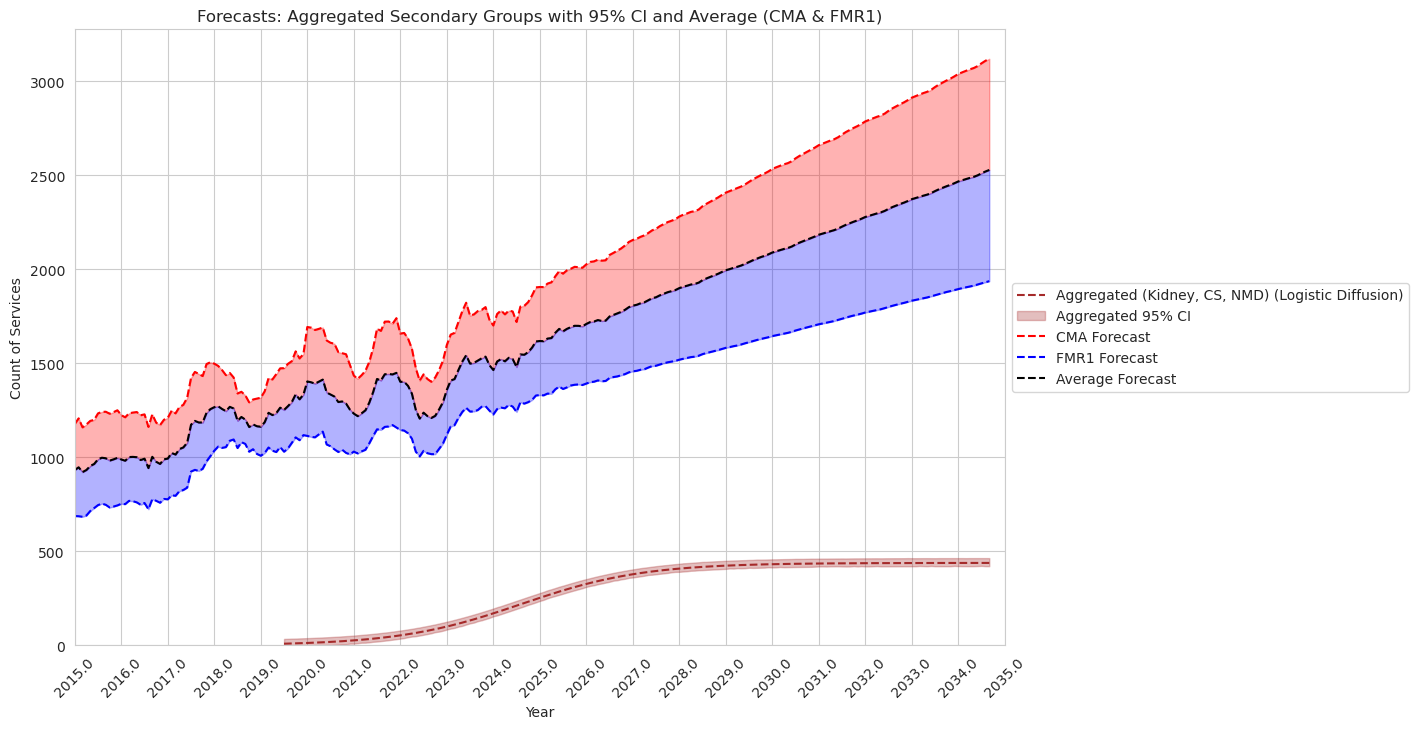

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# -------------------------
# Load and prepare the data
# -------------------------
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# -------------------------
# Define groups and settings
# -------------------------
# Secondary groups (to be aggregated): Kidney, CS, NMD
# Primary individual groups: CMA and FMR1
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300']
}

# Colours for primary groups and aggregated secondary forecast.
color_map = {
    'CMA': 'red',
    'FMR1': 'blue'
}
agg_color = 'brown'  # color for aggregated forecast

# Filter data for our items.
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

# -------------------------
# Define model functions (Diffusion Models)
# -------------------------
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# -------------------------
# Forecasting for each group (all available data, smoothed with 12‐month MA)
# -------------------------
best_predictions = []
diffusion_models = {
    "Logistic Diffusion": logistic_diffusion,
    "Gompertz": gompertz,
    "Bass Diffusion": bass_diffusion
}

for group, items in group_definitions.items():
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('ME').sum().dropna()
    group_data = group_data.rolling(window=12, min_periods=1).mean()  # 12-month moving average
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue
    
    # Convert date index to decimal years (e.g. 2015.0, 2015.083, etc.)
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)
    
    # --- Diffusion Models ---
    for model_name, model_func in diffusion_models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")
    
    # --- SARIMA Model for CMA and FMR1 only ---
    if group in ["CMA", "FMR1"]:
        try:
            sarima_model = SARIMAX(group_data, order=(1,1,1), seasonal_order=(1,1,1,12))
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.fittedvalues
            sarima_r2 = r2_score(group_data, sarima_pred)
            forecast_index = pd.date_range(start=group_data.index[0],
                                           end=group_data.index[-1] + pd.DateOffset(years=10),
                                           freq='ME')
            sarima_forecast = sarima_fit.predict(start=group_data.index[0],
                                                 end=group_data.index[-1] + pd.DateOffset(years=10),
                                                 dynamic=False)
            forecast_years_sarima = forecast_index.year + (forecast_index.month - 1)/12.0
            results["SARIMA"] = {'r2': sarima_r2,
                                 'forecast_years': forecast_years_sarima,
                                 'forecast': sarima_forecast.values}
        except Exception as e:
            print(f"Error fitting SARIMA for group {group}: {e}")
    
    # --- Select Best Model and Generate Forecast ---
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        if best_model_name == "SARIMA":
            forecast_years = best_model_metrics['forecast_years']
            best_pred_full = best_model_metrics['forecast']
        else:
            start_year = fitted_years[0]
            end_year = fitted_years[-1]
            num_points = int((end_year - start_year + 10)*12) + 1  # monthly resolution
            forecast_years = np.linspace(start_year, end_year + 10, num_points)
            best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
        
        best_predictions.append({
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full
        })

# -------------------------
# Aggregated forecast for secondary groups (Kidney, CS, NMD)
# -------------------------
secondary_items = group_definitions["Kidney"] + group_definitions["CS"] + group_definitions["NMD"]
aggregated_series = filtered_data[filtered_data['Item'].isin(secondary_items)]['Value'].resample('ME').sum().dropna()
aggregated_series = aggregated_series.rolling(window=12, min_periods=1).mean()
fitted_years_agg = aggregated_series.index.year + (aggregated_series.index.month - 1)/12.0

best_result = None
for model_name, model_func in diffusion_models.items():
    try:
        if model_name == "Gompertz":
            p0 = [aggregated_series.max(), 1.0, 0.1]
            bounds = (0, [np.inf, np.inf, np.inf])
            params, _ = curve_fit(model_func, fitted_years_agg, aggregated_series,
                                  p0=p0, bounds=bounds, maxfev=10000)
        elif model_name == "Logistic Diffusion":
            p0 = [aggregated_series.max()*1.2, 0.1, np.median(fitted_years_agg)]
            bounds = ([0,0,0],[np.inf, np.inf, np.inf])
            params, _ = curve_fit(model_func, fitted_years_agg, aggregated_series,
                                  p0=p0, bounds=bounds, maxfev=10000)
        elif model_name == "Bass Diffusion":
            p0 = [0.01, 0.1, aggregated_series.max()*1.2]
            bounds = ([0,0,0],[np.inf, np.inf, np.inf])
            params, _ = curve_fit(model_func, fitted_years_agg, aggregated_series,
                                  p0=p0, bounds=bounds, maxfev=10000)
        fitted_pred_agg = model_func(fitted_years_agg, *params)
        r2 = r2_score(aggregated_series, fitted_pred_agg)
        if best_result is None or r2 > best_result['r2']:
            best_result = {'r2': r2, 'params': params, 'func': model_func, 'model_name': model_name}
    except Exception as e:
        print(f"Error fitting {model_name} for aggregated secondary: {e}")

if best_result is not None:
    start_year_agg = fitted_years_agg[0]
    end_year_agg = fitted_years_agg[-1]
    num_points_agg = int((end_year_agg - start_year_agg + 10)*12) + 1
    forecast_years_agg = np.linspace(start_year_agg, end_year_agg + 10, num_points_agg)
    forecast_agg = best_result['func'](forecast_years_agg, *best_result['params'])
    
    # Compute in-sample residuals
    fitted_agg = best_result['func'](fitted_years_agg, *best_result['params'])
    residuals = aggregated_series - fitted_agg
    
    # Bootstrap 500 replicates for 95% CI
    B = 500
    bootstrap_forecasts = np.zeros((B, len(forecast_years_agg)))
    for b in range(B):
        boot_errors = np.random.choice(residuals, size=len(forecast_years_agg), replace=True)
        bootstrap_forecasts[b, :] = forecast_agg + boot_errors
    ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)
    
    aggregated_secondary_forecast = {
        'Group': 'Aggregated (Kidney, CS, NMD)',
        'BestModel': best_result['model_name'],
        'Years': forecast_years_agg,
        'Predicted': forecast_agg,
        'CI_lower': ci_lower,
        'CI_upper': ci_upper
    }
else:
    aggregated_secondary_forecast = None

# -------------------------
# Extract forecasts for CMA and FMR1 and calculate their average from 2015 onward
# -------------------------
primary_forecasts = {bp['Group']: bp for bp in best_predictions if bp['Group'] in ["CMA", "FMR1"]}
if "CMA" in primary_forecasts and "FMR1" in primary_forecasts:
    years_cma = primary_forecasts["CMA"]['Years']
    pred_cma = primary_forecasts["CMA"]['Predicted']
    years_fmr1 = primary_forecasts["FMR1"]['Years']
    pred_fmr1 = primary_forecasts["FMR1"]['Predicted']
    
    common_start_avg = max(years_cma[0], years_fmr1[0], 2015)
    common_end_avg = min(years_cma[-1], years_fmr1[-1])
    num_points_avg = int((common_end_avg - common_start_avg)*12) + 1
    common_years_avg = np.linspace(common_start_avg, common_end_avg, num_points_avg)
    
    interp_cma = np.interp(common_years_avg, years_cma, pred_cma)
    interp_fmr1 = np.interp(common_years_avg, years_fmr1, pred_fmr1)
    avg_forecast = (interp_cma + interp_fmr1) / 2
else:
    raise ValueError("Forecasts for both CMA and FMR1 are required for averaging.")

# -------------------------
# Plotting all forecasts on a single y-axis
# -------------------------
fig, ax = plt.subplots(figsize=(12, 8))

# Plot aggregated secondary forecast with CI if available.
if aggregated_secondary_forecast is not None:
    ax.plot(aggregated_secondary_forecast['Years'], aggregated_secondary_forecast['Predicted'],
            linestyle='--', color=agg_color,
            label=f"{aggregated_secondary_forecast['Group']} ({aggregated_secondary_forecast['BestModel']})")
    ax.fill_between(aggregated_secondary_forecast['Years'],
                    aggregated_secondary_forecast['CI_lower'],
                    aggregated_secondary_forecast['CI_upper'],
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")

# Plot individual forecasts for CMA and FMR1.
ax.plot(common_years_avg, interp_cma, linestyle='--', color=color_map["CMA"], label="CMA Forecast")
ax.plot(common_years_avg, interp_fmr1, linestyle='--', color=color_map["FMR1"], label="FMR1 Forecast")

# Plot the average forecast with a line width similar to the other curves.
ax.plot(common_years_avg, avg_forecast, linestyle='--', color='black', linewidth=1.5, label="Average Forecast")

# Shade the area between the average forecast and the individual forecasts.
ax.fill_between(common_years_avg, avg_forecast, interp_cma, color=color_map["CMA"], alpha=0.3)
ax.fill_between(common_years_avg, avg_forecast, interp_fmr1, color=color_map["FMR1"], alpha=0.3)

# Set axis limits and labels.
global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0] if aggregated_secondary_forecast is not None else common_years_avg[0])
global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1] if aggregated_secondary_forecast is not None else common_years_avg[-1])
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
ax.set_title("Forecasts: Aggregated Secondary Groups with 95% CI and Average (CMA & FMR1)")

# Set x-axis ticks to full years only and angle the labels.
full_years = np.arange(np.floor(global_start), np.ceil(global_end)+1, 1)
ax.set_xticks(full_years)
ax.set_xticklabels(full_years, rotation=45)

# Create a legend and place it on the right side.
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


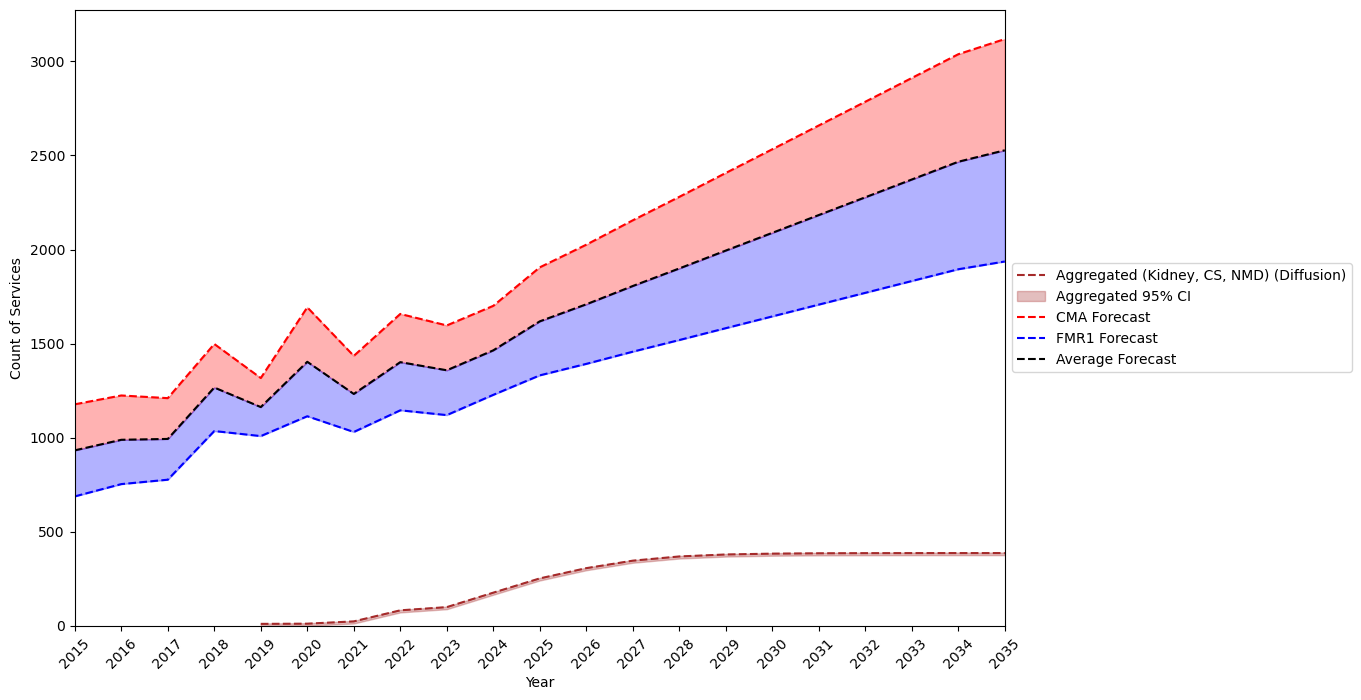

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

##########################
# Load and prepare the data
##########################
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

##########################
# Define groups and settings
##########################
# Secondary groups (to be aggregated): Kidney, CS, NMD
# Primary groups: CMA and FMR1
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300']
}

# Colors for primary groups and aggregated secondary forecast.
color_map = {
    'CMA': 'red',
    'FMR1': 'blue'
}
agg_color = 'brown'  # color for aggregated secondary forecast

# Filter data for our items.
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

##########################
# Define model functions (Diffusion Models)
##########################
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

##########################
# Forecasting for each group
##########################
# Use all available data (smoothed with a 12‐month moving average).
# The original time is computed as decimal years but we then create forecast grids in whole years.
best_predictions = []
diffusion_models = {
    "Logistic Diffusion": logistic_diffusion,
    "Gompertz": gompertz,
    "Bass Diffusion": bass_diffusion
}

for group, items in group_definitions.items():
    # Resample using month-end frequency and smooth.
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('ME').sum().dropna()
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue
    
    # Convert date index to decimal years (for fitting only).
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)
    
    # --- Diffusion Models ---
    for model_name, model_func in diffusion_models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")
    
    # --- SARIMA Model for CMA and FMR1 only ---
    if group in ["CMA", "FMR1"]:
        try:
            sarima_model = SARIMAX(group_data, order=(1,1,1), seasonal_order=(1,1,1,12))
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.fittedvalues
            sarima_r2 = r2_score(group_data, sarima_pred)
            # Create forecast grid in whole years.
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years_sarima = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            # Use SARIMA predict with date_range and then convert to whole years.
            forecast_index = pd.date_range(start=group_data.index[0],
                                           end=group_data.index[-1] + pd.DateOffset(years=10),
                                           freq='ME')
            sarima_forecast = sarima_fit.predict(start=group_data.index[0],
                                                 end=group_data.index[-1] + pd.DateOffset(years=10),
                                                 dynamic=False)
            # For simplicity, re-sample SARIMA forecast to whole years using interpolation.
            sarima_forecast_interp = np.interp(forecast_years_sarima,
                                               forecast_index.year + (forecast_index.month - 1)/12.0,
                                               sarima_forecast.values)
            results["SARIMA"] = {'r2': sarima_r2,
                                 'forecast_years': forecast_years_sarima,
                                 'forecast': sarima_forecast_interp}
        except Exception as e:
            print(f"Error fitting SARIMA for group {group}: {e}")
    
    # --- Select Best Model and Generate Forecast ---
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        if best_model_name == "SARIMA":
            forecast_years = best_model_metrics['forecast_years']
            best_pred_full = best_model_metrics['forecast']
        else:
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
        
        entry = {
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full
        }
        # For secondary groups, store in-sample info for residuals.
        if group in ["Kidney", "CS", "NMD"]:
            entry['InSampleYears'] = fitted_years  # still in decimals, used for residuals
            entry['InSampleFitted'] = best_model_metrics['func'](fitted_years, *best_model_metrics['params'])
            entry['InSampleObserved'] = group_data.values
        best_predictions.append(entry)

##########################
# Aggregated forecast for secondary groups (Kidney, CS, NMD)
##########################
# Now we aggregate the forecasts (which were generated individually) onto a common whole-year grid.
secondary_preds = [bp for bp in best_predictions if bp['Group'] in ["Kidney", "CS", "NMD"]]
if secondary_preds:
    common_start = min(bp['Years'][0] for bp in secondary_preds)
    common_end = max(bp['Years'][-1] for bp in secondary_preds)
    common_time = np.arange(int(common_start), int(common_end) + 1, 1)
    
    aggregated_forecast = np.zeros_like(common_time, dtype=float)
    for bp in secondary_preds:
        aggregated_forecast += np.interp(common_time, bp['Years'], bp['Predicted'])
    
    # Also, compute aggregated in-sample residuals from secondary groups over their overlapping in-sample period.
    in_sample_starts = [bp['InSampleYears'][0] for bp in secondary_preds]
    in_sample_ends = [bp['InSampleYears'][-1] for bp in secondary_preds]
    common_in_start = max(in_sample_starts)
    common_in_end = min(in_sample_ends)
    common_in_time = np.arange(int(np.floor(common_in_start)), int(np.ceil(common_in_end)) + 1, 1)
    aggregated_residuals = np.zeros_like(common_in_time, dtype=float)
    for bp in secondary_preds:
        obs_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleObserved'])
        fit_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleFitted'])
        aggregated_residuals += (obs_interp - fit_interp)
    
    # Bootstrapping for 95% CI over the aggregated forecast grid.
    B = 500
    bootstrap_forecasts = np.zeros((B, len(common_time)))
    for b in range(B):
        boot_errors = np.random.choice(aggregated_residuals, size=len(common_time), replace=True)
        bootstrap_forecasts[b, :] = aggregated_forecast + boot_errors
    ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)
    
    aggregated_secondary_forecast = {
        'Group': 'Aggregated (Kidney, CS, NMD)',
        'BestModel': "Diffusion",
        'Years': common_time,
        'Predicted': aggregated_forecast,
        'CI_lower': ci_lower,
        'CI_upper': ci_upper
    }
else:
    aggregated_secondary_forecast = None

##########################
# Extract forecasts for CMA and FMR1 and compute their average from 2015 onward
##########################
primary_forecasts = {bp['Group']: bp for bp in best_predictions if bp['Group'] in ["CMA", "FMR1"]}
if "CMA" in primary_forecasts and "FMR1" in primary_forecasts:
    years_cma = primary_forecasts["CMA"]['Years']
    pred_cma = primary_forecasts["CMA"]['Predicted']
    years_fmr1 = primary_forecasts["FMR1"]['Years']
    pred_fmr1 = primary_forecasts["FMR1"]['Predicted']
    
    common_start_avg = max(years_cma[0], years_fmr1[0], 2015)
    common_end_avg = min(years_cma[-1], years_fmr1[-1])
    common_years_avg = np.arange(int(common_start_avg), int(common_end_avg) + 1, 1)
    
    interp_cma = np.interp(common_years_avg, years_cma, pred_cma)
    interp_fmr1 = np.interp(common_years_avg, years_fmr1, pred_fmr1)
    avg_forecast = (interp_cma + interp_fmr1) / 2
else:
    raise ValueError("Forecasts for both CMA and FMR1 are required for averaging.")

##########################
# Plotting all forecasts on a single y-axis
##########################
fig, ax = plt.subplots(figsize=(12, 8))

# Plot aggregated secondary forecast with bootstrapped 95% CI if available.
if aggregated_secondary_forecast is not None:
    ax.plot(aggregated_secondary_forecast['Years'], aggregated_secondary_forecast['Predicted'],
            linestyle='--', color=agg_color,
            label=f"{aggregated_secondary_forecast['Group']} ({aggregated_secondary_forecast['BestModel']})")
    ax.fill_between(aggregated_secondary_forecast['Years'],
                    aggregated_secondary_forecast['CI_lower'],
                    aggregated_secondary_forecast['CI_upper'],
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")

# Plot individual forecasts for CMA and FMR1.
ax.plot(common_years_avg, interp_cma, linestyle='--', color=color_map["CMA"], label="CMA Forecast")
ax.plot(common_years_avg, interp_fmr1, linestyle='--', color=color_map["FMR1"], label="FMR1 Forecast")

# Plot the average forecast with a line style similar to the other curves.
ax.plot(common_years_avg, avg_forecast, linestyle='--', color='black', linewidth=1.5, label="Average Forecast")

# Shade the area between the average forecast and the individual forecasts.
ax.fill_between(common_years_avg, avg_forecast, interp_cma, color=color_map["CMA"], alpha=0.3)
ax.fill_between(common_years_avg, avg_forecast, interp_fmr1, color=color_map["FMR1"], alpha=0.3)

# Set axis limits and labels.
global_start = min(common_years_avg[0],
                   aggregated_secondary_forecast['Years'][0] if aggregated_secondary_forecast is not None else common_years_avg[0])
global_end = max(common_years_avg[-1],
                 aggregated_secondary_forecast['Years'][-1] if aggregated_secondary_forecast is not None else common_years_avg[-1])
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
#ax.set_title("Forecasts: Aggregated Secondary Groups with 95% CI and Average (CMA & FMR1)")

# Set x-axis ticks to whole years and angle the labels.
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)

# Create a legend and place it on the right side.
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


/tmp/ipykernel_952/3161158563.py:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/tmp/ipykernel_952/3161158563.py:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/home/doughnut/miniconda3/lib

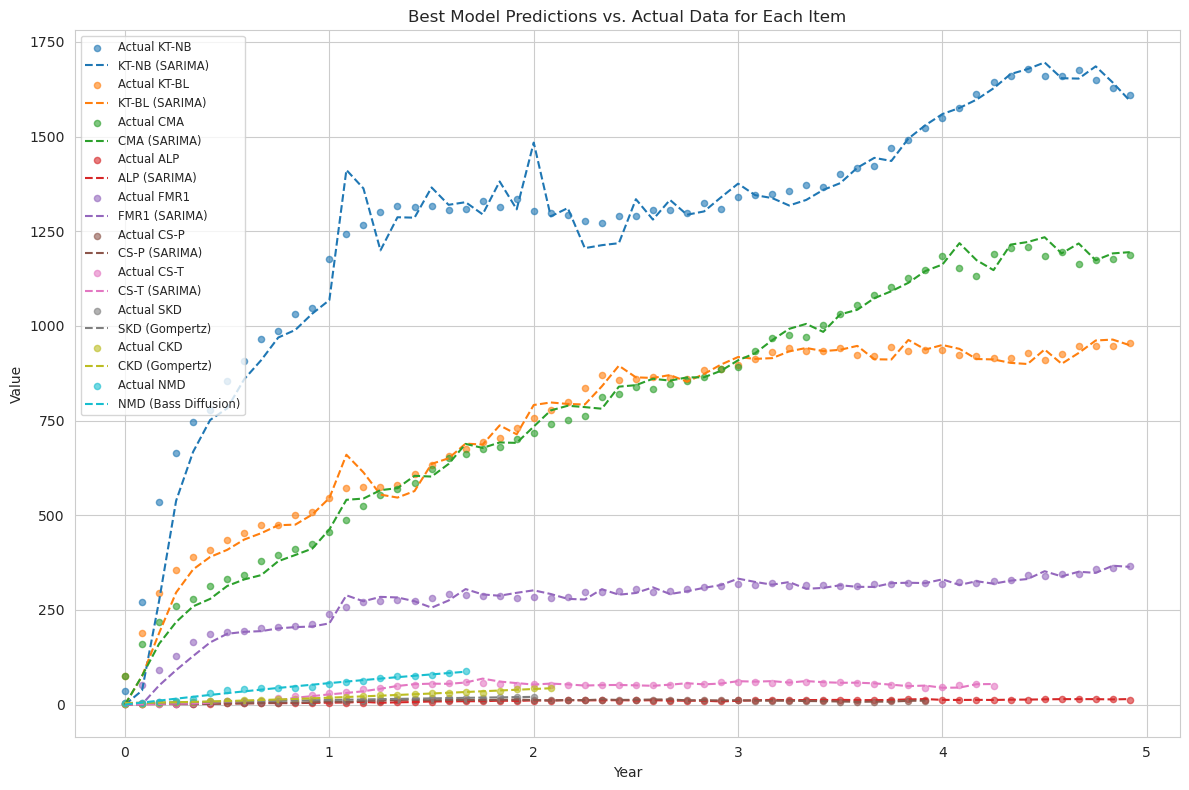

    Item Display Name      Best Model    r2    MAE  MAPE
0  73287        KT-NB          SARIMA  0.95  45.47  0.07
1  73289        KT-BL          SARIMA  0.98  22.89  0.06
2  73292          CMA          SARIMA  0.99  21.84  0.06
3  73298          ALP          SARIMA  0.95   0.62  0.10
4  73300         FMR1          SARIMA  0.96  10.56  0.08
5  73358         CS-P          SARIMA  0.93   0.71  0.13
6  73359         CS-T          SARIMA  0.97   2.52  0.11
7  73401          SKD        Gompertz  0.97   0.66  0.18
8  73402          CKD        Gompertz  0.98   1.34  0.22
9  73422          NMD  Bass Diffusion  0.98   2.94  0.18


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings

# Optionally, filter out some warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

items_to_include = [
    '73287', '73289', '73292', '73298',
    '73300', '73358', '73359', '73401',
    '73402', '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
}

data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# To store best model metrics for each item
best_model_results = []

# Create a combined plot for best models from each item
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.tab10.colors  # use a set of colors for distinction
color_idx = 0

for item in valid_items:
    display_name = custom_titles.get(item, item)
    
    # Resample by month, sum the values, apply a 12-month moving average, and use the first 60 months
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
    item_data = item_data.rolling(window=12, min_periods=1).mean()
    item_data = item_data.iloc[:60]
    
    if item_data.empty:
        print(f"Item {item} has no data after resampling and slicing. Skipping.")
        continue

    # Create a time axis in years (0, 1, 2, ...)
    years = np.arange(len(item_data)) / 12.0

    # Setup the candidate models for fitting
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = item_data.max()
    mid_t = np.median(years)
    
    # Fit each non-SARIMA model
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            predicted = model_func(years, *params)
            r2 = r2_score(item_data, predicted)
            mae = mean_absolute_error(item_data, predicted)
            mape = mean_absolute_percentage_error(item_data, predicted)
            results[model_name] = {
                'r2': r2, 'MAE': mae, 'MAPE': mape, 'predicted': predicted
            }
        except Exception as e:
            print(f"Error fitting {model_name} for item {item} ({display_name}): {e}")
    
    # Fit SARIMA model
    try:
        sarima_model = SARIMAX(item_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_pred = sarima_fit.fittedvalues
        sarima_r2 = r2_score(item_data, sarima_pred)
        sarima_mae = mean_absolute_error(item_data, sarima_pred)
        sarima_mape = mean_absolute_percentage_error(item_data, sarima_pred)
        results["SARIMA"] = {
            'r2': sarima_r2, 'MAE': sarima_mae, 'MAPE': sarima_mape, 'predicted': sarima_pred
        }
    except Exception as e:
        print(f"Error fitting SARIMA for item {item} ({display_name}): {e}")
    
    # Select the best model based on r2 score
    if results:
        best_model_name = max(results, key=lambda m: results[m]['r2'])
        best_pred = results[best_model_name]['predicted']
        
        best_model_results.append({
            'Item': item,
            'Display Name': display_name,
            'Best Model': best_model_name,
            'r2': results[best_model_name]['r2'],
            'MAE': results[best_model_name]['MAE'],
            'MAPE': results[best_model_name]['MAPE']
        })
        
        # Plot the actual data and best model prediction using a unique color
        color = colors[color_idx % len(colors)]
        color_idx += 1
        ax.scatter(years, item_data, color=color, alpha=0.6, s=20, label=f"Actual {display_name}")
        ax.plot(years, best_pred, color=color, linestyle="--", label=f"{display_name} ({best_model_name})")

# Finalize the combined plot
ax.set_xlabel("Year")
ax.set_ylabel("Value")
ax.set_title("Best Model Predictions vs. Actual Data for Each Item")
ax.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

# Convert best model results to a DataFrame and format the metric values
best_results_df = pd.DataFrame(best_model_results)
for column in ['MAE', 'MAPE', 'r2']:
    best_results_df[column] = best_results_df[column].apply(
        lambda x: f"{x:.2e}" if abs(x) >= 100000 else f"{x:.2f}"
    )
print(best_results_df)


/tmp/ipykernel_772/2317259594.py:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/tmp/ipykernel_772/2317259594.py:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
/home/doughnut/miniconda3/lib

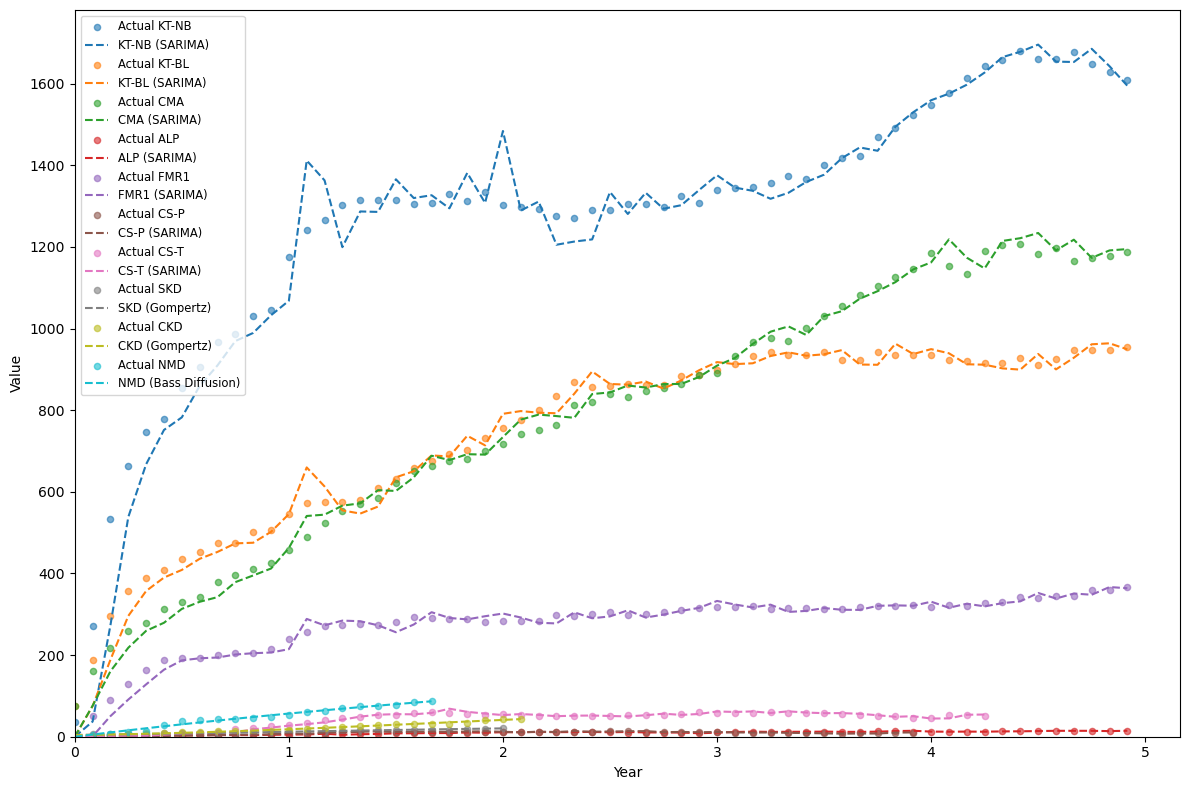

    Item Display Name      Best Model    r2    MAE  MAPE
0  73287        KT-NB          SARIMA  0.95  45.47  0.07
1  73289        KT-BL          SARIMA  0.98  22.89  0.06
2  73292          CMA          SARIMA  0.99  21.84  0.06
3  73298          ALP          SARIMA  0.95   0.62  0.10
4  73300         FMR1          SARIMA  0.96  10.56  0.08
5  73358         CS-P          SARIMA  0.93   0.71  0.13
6  73359         CS-T          SARIMA  0.97   2.52  0.11
7  73401          SKD        Gompertz  0.97   0.66  0.18
8  73402          CKD        Gompertz  0.98   1.34  0.22
9  73422          NMD  Bass Diffusion  0.98   2.94  0.18


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings

# Optionally, filter out some warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

items_to_include = [
    '73287', '73289', '73292', '73298',
    '73300', '73358', '73359', '73401',
    '73402', '73422'
]
filtered_data = data[data['Item'].isin(items_to_include)]

custom_titles = {
    '73287': 'KT-NB',
    '73289': 'KT-BL',
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
}

data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# To store best model metrics for each item
best_model_results = []

# Create a combined plot for best models from each item
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.tab10.colors  # use a set of colors for distinction
color_idx = 0

for item in valid_items:
    display_name = custom_titles.get(item, item)
    
    # Resample by month, sum the values, apply a 12-month moving average, and use the first 60 months
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('M').sum().dropna()
    item_data = item_data.rolling(window=12, min_periods=1).mean()
    item_data = item_data.iloc[:60]
    
    if item_data.empty:
        print(f"Item {item} has no data after resampling and slicing. Skipping.")
        continue

    # Create a time axis in years (0, 1, 2, ...)
    years = np.arange(len(item_data)) / 12.0

    # Setup the candidate models for fitting
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = item_data.max()
    mid_t = np.median(years)
    
    # Fit each non-SARIMA model
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    years,
                    item_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            predicted = model_func(years, *params)
            r2 = r2_score(item_data, predicted)
            mae = mean_absolute_error(item_data, predicted)
            mape = mean_absolute_percentage_error(item_data, predicted)
            results[model_name] = {
                'r2': r2, 'MAE': mae, 'MAPE': mape, 'predicted': predicted
            }
        except Exception as e:
            print(f"Error fitting {model_name} for item {item} ({display_name}): {e}")
    
    # Fit SARIMA model
    try:
        sarima_model = SARIMAX(item_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_pred = sarima_fit.fittedvalues
        sarima_r2 = r2_score(item_data, sarima_pred)
        sarima_mae = mean_absolute_error(item_data, sarima_pred)
        sarima_mape = mean_absolute_percentage_error(item_data, sarima_pred)
        results["SARIMA"] = {
            'r2': sarima_r2, 'MAE': sarima_mae, 'MAPE': sarima_mape, 'predicted': sarima_pred
        }
    except Exception as e:
        print(f"Error fitting SARIMA for item {item} ({display_name}): {e}")
    
    # Select the best model based on r2 score
    if results:
        best_model_name = max(results, key=lambda m: results[m]['r2'])
        best_pred = results[best_model_name]['predicted']
        
        best_model_results.append({
            'Item': item,
            'Display Name': display_name,
            'Best Model': best_model_name,
            'r2': results[best_model_name]['r2'],
            'MAE': results[best_model_name]['MAE'],
            'MAPE': results[best_model_name]['MAPE']
        })
        
        # Plot the actual data and best model prediction using a unique color
        color = colors[color_idx % len(colors)]
        color_idx += 1
        ax.scatter(years, item_data, color=color, alpha=0.6, s=20, label=f"Actual {display_name}")
        ax.plot(years, best_pred, color=color, linestyle="--", label=f"{display_name} ({best_model_name})")

# Finalize the combined plot
ax.set_xlabel("Year")
ax.set_ylabel("Value")
#ax.set_title("Best Model Predictions vs. Actual Data for Each Item")

# Update the axes so they start at 0
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

ax.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

# Convert best model results to a DataFrame and format the metric values
best_results_df = pd.DataFrame(best_model_results)
for column in ['MAE', 'MAPE', 'r2']:
    best_results_df[column] = best_results_df[column].apply(
        lambda x: f"{x:.2e}" if abs(x) >= 100000 else f"{x:.2f}"
    )
print(best_results_df)


                       Kidney                    CS                    NMD  \
Year                                                                         
2025    97.76 (91.94, 102.49)  65.58 (54.67, 72.51)   88.20 (80.64, 98.32)   
2026  149.14 (143.32, 154.09)  65.58 (53.70, 72.51)  91.30 (83.74, 101.41)   
2027  188.74 (182.26, 193.69)  65.58 (54.67, 74.17)  91.50 (83.94, 101.62)   
2028  211.13 (205.53, 216.07)  65.58 (53.70, 72.51)  91.52 (83.96, 101.63)   
2029  221.62 (216.03, 226.11)  65.58 (52.83, 72.51)  91.52 (83.96, 101.64)   
2030  226.10 (220.51, 231.05)  65.58 (54.67, 74.17)  91.52 (83.96, 101.64)   
2031  227.94 (222.35, 232.89)  65.58 (54.67, 72.51)  91.52 (83.96, 101.64)   
2032  228.69 (222.87, 233.64)  65.58 (54.67, 72.51)  91.52 (83.96, 101.64)   
2033  228.99 (223.17, 233.94)  65.58 (52.83, 74.17)  91.52 (83.96, 101.64)   
2034  229.11 (223.39, 233.60)  65.58 (54.67, 72.51)  91.52 (83.96, 101.64)   
2035  229.15 (223.44, 234.10)  65.58 (52.83, 72.51)  91.52 (83.9

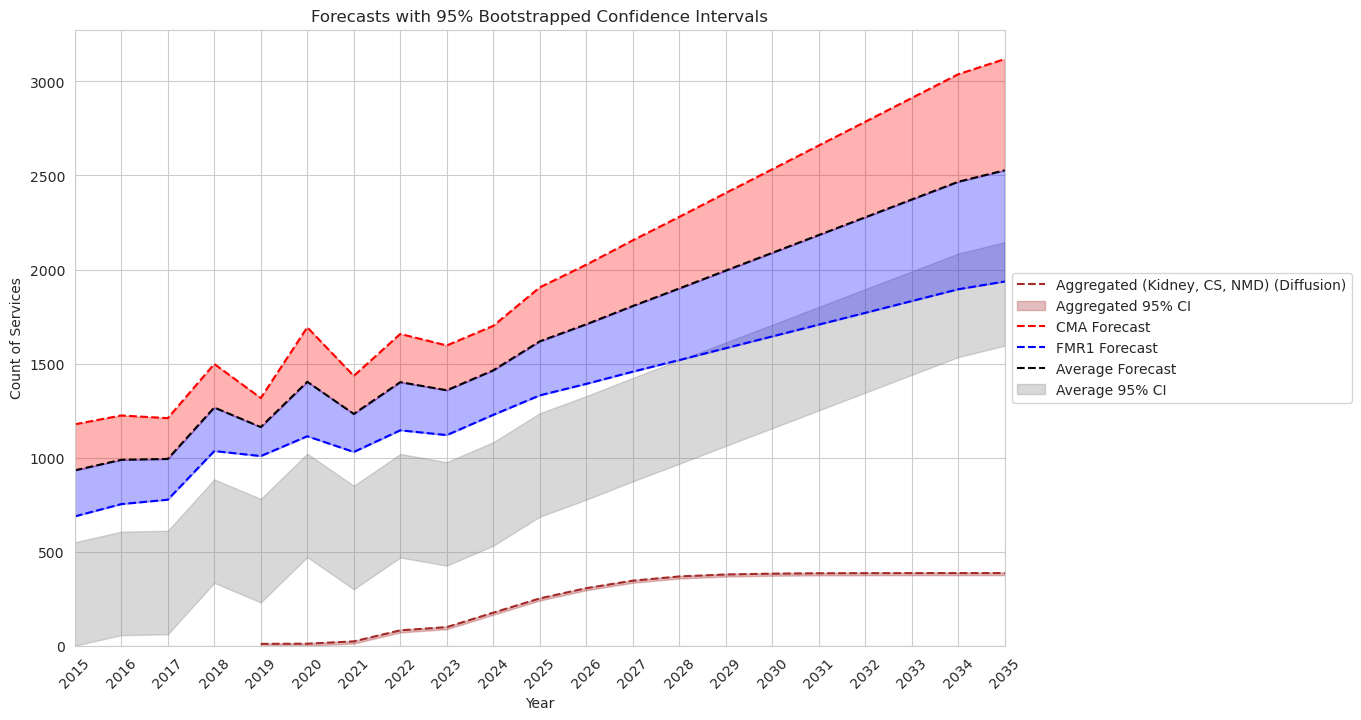

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

##########################
# Load and prepare the data
##########################
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

##########################
# Define groups and settings
##########################
# Secondary groups (to be aggregated): Kidney, CS, NMD
# Primary groups: CMA and FMR1
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300']
}

# Colors for primary groups and aggregated secondary forecast.
color_map = {
    'CMA': 'red',
    'FMR1': 'blue'
}
agg_color = 'brown'  # color for aggregated secondary forecast

# Filter data for our items.
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

##########################
# Define model functions (Diffusion Models)
##########################
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

##########################
# Forecasting for each group
##########################
best_predictions = []
diffusion_models = {
    "Logistic Diffusion": logistic_diffusion,
    "Gompertz": gompertz,
    "Bass Diffusion": bass_diffusion
}

for group, items in group_definitions.items():
    # Resample using month-end frequency and smooth.
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('ME').sum().dropna()
    group_data = group_data.rolling(window=12, min_periods=1).mean()

    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Convert date index to decimal years (for fitting only).
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)

    # --- Diffusion Models ---
    for model_name, model_func in diffusion_models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # --- SARIMA Model for CMA and FMR1 only ---
    if group in ["CMA", "FMR1"]:
        try:
            sarima_model = SARIMAX(group_data, order=(1,1,1), seasonal_order=(1,1,1,12))
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.fittedvalues
            sarima_r2 = r2_score(group_data, sarima_pred)
            # Create forecast grid in whole years.
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years_sarima = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            forecast_index = pd.date_range(start=group_data.index[0],
                                           end=group_data.index[-1] + pd.DateOffset(years=10),
                                           freq='ME')
            sarima_forecast = sarima_fit.predict(start=group_data.index[0],
                                                 end=group_data.index[-1] + pd.DateOffset(years=10),
                                                 dynamic=False)
            sarima_forecast_interp = np.interp(forecast_years_sarima,
                                               forecast_index.year + (forecast_index.month - 1)/12.0,
                                               sarima_forecast.values)
            # Compute residuals for SARIMA using in-sample data.
            sarima_resid = group_data.values - sarima_pred
            results["SARIMA"] = {'r2': sarima_r2,
                                 'forecast_years': forecast_years_sarima,
                                 'forecast': sarima_forecast_interp,
                                 'residuals': sarima_resid}
        except Exception as e:
            print(f"Error fitting SARIMA for group {group}: {e}")

    # --- Select Best Model, Generate Forecast, and Compute Bootstrapped CIs ---
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        if best_model_name == "SARIMA":
            forecast_years = best_model_metrics['forecast_years']
            best_pred_full = best_model_metrics['forecast']
            residuals = best_model_metrics.get('residuals')
        else:
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
            residuals = group_data.values - best_model_metrics['func'](fitted_years, *best_model_metrics['params'])

        # Bootstrapping for 95% CI using the in-sample residuals.
        B = 500
        bootstrap_forecasts = np.zeros((B, len(forecast_years)))
        for b in range(B):
            boot_errors = np.random.choice(residuals, size=len(forecast_years), replace=True)
            bootstrap_forecasts[b, :] = best_pred_full + boot_errors
        ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
        ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

        entry = {
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full,
            'CI_lower': ci_lower,
            'CI_upper': ci_upper
        }
        # For secondary groups, also store in-sample info.
        if group in ["Kidney", "CS", "NMD"]:
            entry['InSampleYears'] = fitted_years
            entry['InSampleFitted'] = best_model_metrics['func'](fitted_years, *best_model_metrics['params'])
            entry['InSampleObserved'] = group_data.values
        best_predictions.append(entry)

##########################
# Aggregated forecast for secondary groups (Kidney, CS, NMD)
##########################
secondary_preds = [bp for bp in best_predictions if bp['Group'] in ["Kidney", "CS", "NMD"]]
if secondary_preds:
    common_start = min(bp['Years'][0] for bp in secondary_preds)
    common_end = max(bp['Years'][-1] for bp in secondary_preds)
    common_time = np.arange(int(common_start), int(common_end) + 1, 1)

    aggregated_forecast = np.zeros_like(common_time, dtype=float)
    for bp in secondary_preds:
        aggregated_forecast += np.interp(common_time, bp['Years'], bp['Predicted'])

    # Compute aggregated in-sample residuals over the overlapping period.
    in_sample_starts = [bp['InSampleYears'][0] for bp in secondary_preds]
    in_sample_ends = [bp['InSampleYears'][-1] for bp in secondary_preds]
    common_in_start = max(in_sample_starts)
    common_in_end = min(in_sample_ends)
    common_in_time = np.arange(int(np.floor(common_in_start)), int(np.ceil(common_in_end)) + 1, 1)
    aggregated_residuals = np.zeros_like(common_in_time, dtype=float)
    for bp in secondary_preds:
        obs_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleObserved'])
        fit_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleFitted'])
        aggregated_residuals += (obs_interp - fit_interp)

    # Bootstrapping for 95% CI over the aggregated forecast grid.
    B = 500
    bootstrap_forecasts = np.zeros((B, len(common_time)))
    for b in range(B):
        boot_errors = np.random.choice(aggregated_residuals, size=len(common_time), replace=True)
        bootstrap_forecasts[b, :] = aggregated_forecast + boot_errors
    ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

    aggregated_secondary_forecast = {
        'Group': 'Aggregated (Kidney, CS, NMD)',
        'BestModel': "Diffusion",
        'Years': common_time,
        'Predicted': aggregated_forecast,
        'CI_lower': ci_lower,
        'CI_upper': ci_upper
    }
else:
    aggregated_secondary_forecast = None

##########################
# Extract forecasts for CMA and FMR1 and compute their average from 2015 onward
##########################
primary_forecasts = {bp['Group']: bp for bp in best_predictions if bp['Group'] in ["CMA", "FMR1"]}
if "CMA" in primary_forecasts and "FMR1" in primary_forecasts:
    years_cma = primary_forecasts["CMA"]['Years']
    pred_cma = primary_forecasts["CMA"]['Predicted']
    years_fmr1 = primary_forecasts["FMR1"]['Years']
    pred_fmr1 = primary_forecasts["FMR1"]['Predicted']

    common_start_avg = max(years_cma[0], years_fmr1[0], 2015)
    common_end_avg = min(years_cma[-1], years_fmr1[-1])
    common_years_avg = np.arange(int(common_start_avg), int(common_end_avg) + 1, 1)

    interp_cma = np.interp(common_years_avg, years_cma, pred_cma)
    interp_fmr1 = np.interp(common_years_avg, years_fmr1, pred_fmr1)
    avg_forecast = (interp_cma + interp_fmr1) / 2

    # For averaging, we also compute bootstrapped CIs by combining residuals from both groups.
    B = 500
    bootstrap_avg = np.zeros((B, len(common_years_avg)))
    # For each primary group, get residuals (observed minus fitted) from in-sample data.
    resid_cma = primary_forecasts["CMA"]['Predicted'][:len(interp_cma)] - interp_cma
    resid_fmr1 = primary_forecasts["FMR1"]['Predicted'][:len(interp_fmr1)] - interp_fmr1
    # Use the average residuals (this is a simple approach; more sophisticated methods are possible)
    resid_avg = (resid_cma + resid_fmr1) / 2
    for b in range(B):
        boot_errors = np.random.choice(resid_avg, size=len(common_years_avg), replace=True)
        bootstrap_avg[b, :] = avg_forecast + boot_errors
    avg_ci_lower = np.percentile(bootstrap_avg, 2.5, axis=0)
    avg_ci_upper = np.percentile(bootstrap_avg, 97.5, axis=0)
else:
    raise ValueError("Forecasts for both CMA and FMR1 are required for averaging.")

##########################
# Plotting all forecasts on a single y-axis
##########################
fig, ax = plt.subplots(figsize=(12, 8))

# Plot aggregated secondary forecast with bootstrapped 95% CI if available.
if aggregated_secondary_forecast is not None:
    ax.plot(aggregated_secondary_forecast['Years'], aggregated_secondary_forecast['Predicted'],
            linestyle='--', color=agg_color,
            label=f"{aggregated_secondary_forecast['Group']} ({aggregated_secondary_forecast['BestModel']})")
    ax.fill_between(aggregated_secondary_forecast['Years'],
                    aggregated_secondary_forecast['CI_lower'],
                    aggregated_secondary_forecast['CI_upper'],
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")

# Plot individual forecasts for CMA and FMR1.
ax.plot(common_years_avg, interp_cma, linestyle='--', color=color_map["CMA"], label="CMA Forecast")
ax.plot(common_years_avg, interp_fmr1, linestyle='--', color=color_map["FMR1"], label="FMR1 Forecast")

# Plot the average forecast.
ax.plot(common_years_avg, avg_forecast, linestyle='--', color='black', linewidth=1.5, label="Average Forecast")
ax.fill_between(common_years_avg, avg_ci_lower, avg_ci_upper, color='gray', alpha=0.3, label="Average 95% CI")

# Shade the area between the average forecast and the individual forecasts.
ax.fill_between(common_years_avg, avg_forecast, interp_cma, color=color_map["CMA"], alpha=0.3)
ax.fill_between(common_years_avg, avg_forecast, interp_fmr1, color=color_map["FMR1"], alpha=0.3)

# Set axis limits and labels.
global_start = min(common_years_avg[0],
                   aggregated_secondary_forecast['Years'][0] if aggregated_secondary_forecast is not None else common_years_avg[0])
global_end = max(common_years_avg[-1],
                 aggregated_secondary_forecast['Years'][-1] if aggregated_secondary_forecast is not None else common_years_avg[-1])
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
ax.set_title("Forecasts with 95% Bootstrapped Confidence Intervals")

ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.show()  # Uncomment to display the plot

################################################################################
# Code to generate the table from the forecast results with CIs
################################################################################
# Dummy data placeholders are replaced by the computed best_predictions and aggregated forecast.
# For table purposes, we assume the forecasts have been computed as above.

# Create a dictionary to hold the data for the table
table_data = {}
years_from_2025 = sorted(list(set(range(2025, 2036))))

# Populate the table data for Aggregated Secondary
if aggregated_secondary_forecast is not None:
    group_name = aggregated_secondary_forecast['Group']
    table_data[group_name] = {}
    for year in years_from_2025:
        if year in aggregated_secondary_forecast['Years']:
            index = np.where(aggregated_secondary_forecast['Years'] == year)[0][0]
            lower_ci = aggregated_secondary_forecast['CI_lower'][index]
            upper_ci = aggregated_secondary_forecast['CI_upper'][index]
            predicted_value = aggregated_secondary_forecast['Predicted'][index]
            table_data[group_name][year] = f"{predicted_value:.2f} ({lower_ci:.2f}, {upper_ci:.2f})"
        else:
            table_data[group_name][year] = ""

# Populate the table data for primary forecasts (CMA and FMR1)
for grp in ["CMA", "FMR1"]:
    if grp in primary_forecasts:
        table_data[grp] = {}
        for year in years_from_2025:
            if year in primary_forecasts[grp]['Years']:
                index = np.where(primary_forecasts[grp]['Years'] == year)[0][0]
                predicted_value = primary_forecasts[grp]['Predicted'][index]
                ci_lower = primary_forecasts[grp]['CI_lower'][index]
                ci_upper = primary_forecasts[grp]['CI_upper'][index]
                table_data[grp][year] = f"{predicted_value:.2f} ({ci_lower:.2f}, {ci_upper:.2f})"
            else:
                table_data[grp][year] = ""

# Populate the table data for individual secondary groups (Kidney, CS, NMD)
secondary_groups = ['Kidney', 'CS', 'NMD']
for group_info in best_predictions:
    group_name = group_info['Group']
    if group_name in secondary_groups:
        table_data[group_name] = {}
        for year in years_from_2025:
            if year in group_info['Years']:
                index = np.where(group_info['Years'] == year)[0][0]
                predicted_value = group_info['Predicted'][index]
                ci_lower = group_info['CI_lower'][index]
                ci_upper = group_info['CI_upper'][index]
                table_data[group_name][year] = f"{predicted_value:.2f} ({ci_lower:.2f}, {ci_upper:.2f})"
            else:
                table_data[group_name][year] = ""

# Populate the table data for Average (CMA & FMR1)
group_name = "Average (CMA & FMR1)"
table_data[group_name] = {}
for year in years_from_2025:
    if year in common_years_avg:
        index = np.where(common_years_avg == year)[0][0]
        predicted_value = avg_forecast[index]
        table_data[group_name][year] = f"{predicted_value:.2f} ({avg_ci_lower[index]:.2f}, {avg_ci_upper[index]:.2f})"
    else:
        table_data[group_name][year] = ""

# Create the Pandas DataFrame for the table
df = pd.DataFrame.from_dict(table_data, orient='index')
df = df.T
df.index.name = 'Year'

column_order = ['Kidney', 'CS', 'NMD', 'CMA', 'FMR1', 'Aggregated (Kidney, CS, NMD)', 'Average (CMA & FMR1)']
existing_columns = [col for col in column_order if col in df.columns]
df = df[existing_columns]

print(df)


In [83]:
df

Kidney                    CS                    NMD  \
Year                                                                         
2025    97.76 (91.94, 102.49)  65.58 (54.67, 72.51)   88.20 (80.64, 98.32)   
2026  149.14 (143.32, 154.09)  65.58 (53.70, 72.51)  91.30 (83.74, 101.41)   
2027  188.74 (182.26, 193.69)  65.58 (54.67, 74.17)  91.50 (83.94, 101.62)   
2028  211.13 (205.53, 216.07)  65.58 (53.70, 72.51)  91.52 (83.96, 101.63)   
2029  221.62 (216.03, 226.11)  65.58 (52.83, 72.51)  91.52 (83.96, 101.64)   
2030  226.10 (220.51, 231.05)  65.58 (54.67, 74.17)  91.52 (83.96, 101.64)   
2031  227.94 (222.35, 232.89)  65.58 (54.67, 72.51)  91.52 (83.96, 101.64)   
2032  228.69 (222.87, 233.64)  65.58 (54.67, 72.51)  91.52 (83.96, 101.64)   
2033  228.99 (223.17, 233.94)  65.58 (52.83, 74.17)  91.52 (83.96, 101.64)   
2034  229.11 (223.39, 233.60)  65.58 (54.67, 72.51)  91.52 (83.96, 101.64)   
2035  229.15 (223.44, 234.10)  65.58 (52.83, 72.51)  91.52 (83.96, 101.64)   

                             CMA                        FMR1  \
Year                                                           
2025  1905.36 (1845.36, 1970.31)  1331.04 (1304.38, 1367.08)   
2026  2025.74 (1964.59, 2083.94)  1392.08 (1365.28, 1423.03)   
2027  2155.35 (2098.44, 2213.16)  1456.87 (1425.52, 1497.37)   
2028  2280.08 (2220.07, 2337.89)  1518.80 (1486.99, 1556.89)   
2029  2407.12 (2344.32, 2465.32)  1581.89 (1549.93, 1613.92)   
2030  2533.05 (2463.83, 2591.25)  1644.38 (1614.79, 1682.47)   
2031  2659.51 (2599.50, 2717.71)  1707.15 (1679.30, 1739.47)   
2032  2785.71 (2730.98, 2843.91)  1769.79 (1740.20, 1807.03)   
2033  2912.04 (2857.31, 2970.24)  1832.49 (1801.13, 1869.73)   
2034  3038.31 (2977.16, 3109.37)  1895.15 (1865.56, 1931.86)   
2035  3118.90 (3056.10, 3173.97)  1936.36 (1905.85, 1972.30)   

     Aggregated (Kidney, CS, NMD)        Average (CMA & FMR1)  
Year                                                           
2025      251.53 (240.51, 254.14)   1618.20 (685.85, 1236.11)  
2026      306.01 (294.99, 308.62)   1708.91 (776.56, 1326.82)  
2027      345.82 (334.80, 348.43)   1806.11 (873.76, 1424.01)  
2028      368.22 (357.19, 370.82)   1899.44 (967.09, 1517.34)  
2029      378.71 (367.69, 381.32)  1994.50 (1062.15, 1612.41)  
2030      383.20 (372.17, 385.80)  2088.71 (1156.36, 1706.62)  
2031      385.04 (374.01, 387.64)  2183.33 (1250.98, 1801.23)  
2032      385.78 (374.76, 388.39)  2277.75 (1345.40, 1895.65)  
2033      386.08 (375.06, 388.69)  2372.26 (1439.91, 1990.17)  
2034      386.20 (375.17, 388.80)  2466.73 (1534.38, 2084.64)  
2035      386.25 (375.22, 388.85)  2527.63 (1595.28, 2145.53)

        Aggregated (Kidney, CS, NMD)_2900 Aggregated (Kidney, CS, NMD)_2465  \
Year                                                                          
2025     729440.49 (697472.23, 736999.84)  620024.42 (592851.40, 626449.86)   
2026     887435.37 (855467.11, 894994.71)  754320.06 (727147.04, 760745.50)   
2027   1002884.54 (970916.29, 1010443.89)  852451.86 (825278.85, 858877.31)   
2028  1067830.09 (1035861.84, 1075389.44)  907655.58 (880482.56, 914081.02)   
2029  1098257.78 (1066289.52, 1105817.13)  933519.11 (906346.10, 939944.56)   
2030  1111265.92 (1079297.66, 1118825.26)  944576.03 (917403.01, 951001.47)   
2031  1116607.23 (1084638.97, 1124166.57)  949116.14 (921943.13, 955541.59)   
2032  1118763.96 (1086795.71, 1126323.31)  950949.37 (923776.35, 957374.81)   
2033  1119628.91 (1087660.65, 1127188.25)  951684.57 (924511.55, 958110.01)   
2034  1119974.84 (1088006.58, 1127534.19)  951978.61 (924805.60, 958404.06)   
2035  1120113.04 (1088144.79, 1127672.39)  952096.09

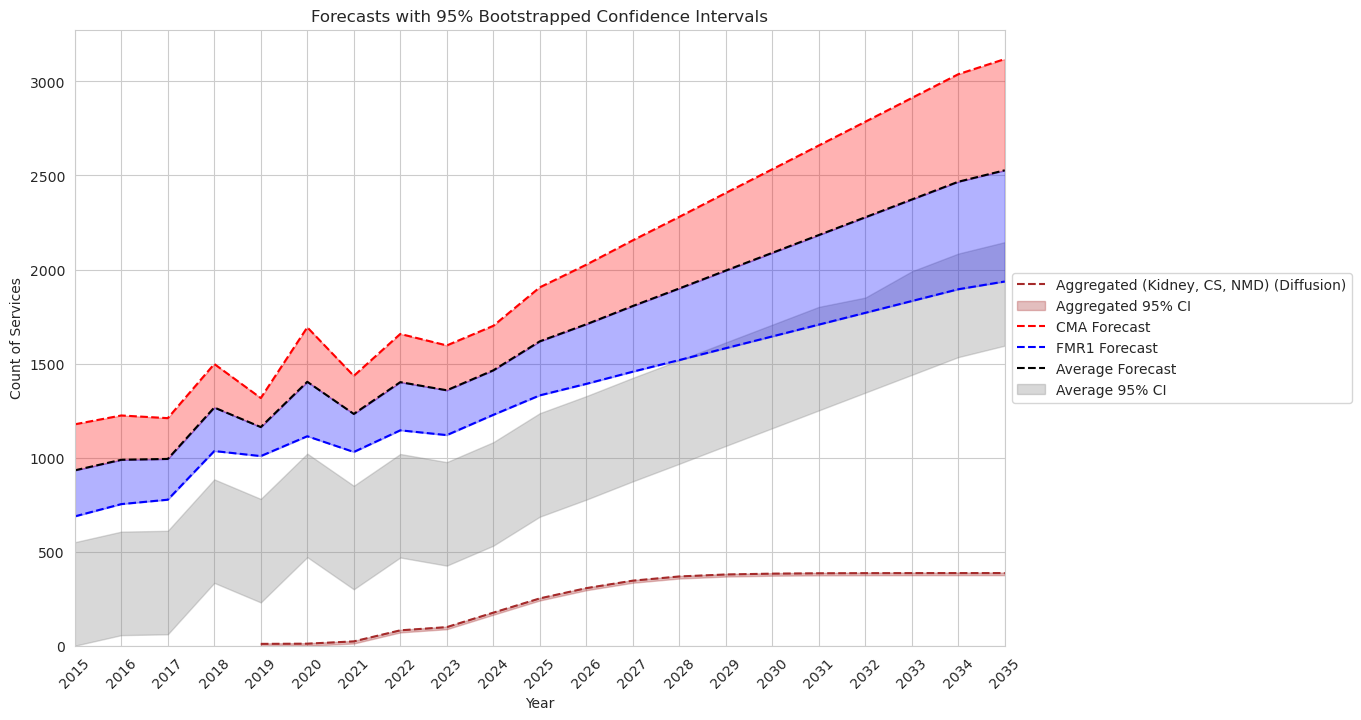

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

##########################
# Load and prepare the data
##########################
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

##########################
# Define groups and settings
##########################
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300']
}

color_map = {
    'CMA': 'red',
    'FMR1': 'blue'
}
agg_color = 'brown'  # color for aggregated secondary forecast

# Filter data for our items.
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

##########################
# Define model functions (Diffusion Models)
##########################
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

##########################
# Forecasting for each group
##########################
best_predictions = []
diffusion_models = {
    "Logistic Diffusion": logistic_diffusion,
    "Gompertz": gompertz,
    "Bass Diffusion": bass_diffusion
}

for group, items in group_definitions.items():
    # Resample using month-end frequency and smooth.
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('ME').sum().dropna()
    group_data = group_data.rolling(window=12, min_periods=1).mean()

    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Convert date index to decimal years (for fitting only).
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)

    # --- Diffusion Models ---
    for model_name, model_func in diffusion_models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # --- SARIMA Model for CMA and FMR1 only ---
    if group in ["CMA", "FMR1"]:
        try:
            sarima_model = SARIMAX(group_data, order=(1,1,1), seasonal_order=(1,1,1,12))
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.fittedvalues
            sarima_r2 = r2_score(group_data, sarima_pred)
            # Create forecast grid in whole years.
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years_sarima = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            forecast_index = pd.date_range(start=group_data.index[0],
                                           end=group_data.index[-1] + pd.DateOffset(years=10),
                                           freq='ME')
            sarima_forecast = sarima_fit.predict(start=group_data.index[0],
                                                 end=group_data.index[-1] + pd.DateOffset(years=10),
                                                 dynamic=False)
            sarima_forecast_interp = np.interp(forecast_years_sarima,
                                               forecast_index.year + (forecast_index.month - 1)/12.0,
                                               sarima_forecast.values)
            # Compute residuals for SARIMA using in-sample data.
            sarima_resid = group_data.values - sarima_pred
            results["SARIMA"] = {'r2': sarima_r2,
                                 'forecast_years': forecast_years_sarima,
                                 'forecast': sarima_forecast_interp,
                                 'residuals': sarima_resid}
        except Exception as e:
            print(f"Error fitting SARIMA for group {group}: {e}")

    # --- Select Best Model, Generate Forecast, and Compute Bootstrapped CIs ---
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        if best_model_name == "SARIMA":
            forecast_years = best_model_metrics['forecast_years']
            best_pred_full = best_model_metrics['forecast']
            residuals = best_model_metrics.get('residuals')
        else:
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
            residuals = group_data.values - best_model_metrics['func'](fitted_years, *best_model_metrics['params'])

        # Bootstrapping for 95% CI using the in-sample residuals.
        B = 500
        bootstrap_forecasts = np.zeros((B, len(forecast_years)))
        for b in range(B):
            boot_errors = np.random.choice(residuals, size=len(forecast_years), replace=True)
            bootstrap_forecasts[b, :] = best_pred_full + boot_errors
        ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
        ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

        entry = {
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full,
            'CI_lower': ci_lower,
            'CI_upper': ci_upper
        }
        # For secondary groups, also store in-sample info.
        if group in ["Kidney", "CS", "NMD"]:
            entry['InSampleYears'] = fitted_years  # still in decimals, used for residuals
            entry['InSampleFitted'] = best_model_metrics['func'](fitted_years, *best_model_metrics['params'])
            entry['InSampleObserved'] = group_data.values
        best_predictions.append(entry)

##########################
# Aggregated forecast for secondary groups (Kidney, CS, NMD)
##########################
secondary_preds = [bp for bp in best_predictions if bp['Group'] in ["Kidney", "CS", "NMD"]]
if secondary_preds:
    common_start = min(bp['Years'][0] for bp in secondary_preds)
    common_end = max(bp['Years'][-1] for bp in secondary_preds)
    common_time = np.arange(int(common_start), int(common_end) + 1, 1)

    aggregated_forecast = np.zeros_like(common_time, dtype=float)
    for bp in secondary_preds:
        aggregated_forecast += np.interp(common_time, bp['Years'], bp['Predicted'])

    # Also, compute aggregated in-sample residuals from secondary groups over their overlapping in-sample period.
    in_sample_starts = [bp['InSampleYears'][0] for bp in secondary_preds]
    in_sample_ends = [bp['InSampleYears'][-1] for bp in secondary_preds]
    common_in_start = max(in_sample_starts)
    common_in_end = min(in_sample_ends)
    common_in_time = np.arange(int(np.floor(common_in_start)), int(np.ceil(common_in_end)) + 1, 1)
    aggregated_residuals = np.zeros_like(common_in_time, dtype=float)
    for bp in secondary_preds:
        obs_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleObserved'])
        fit_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleFitted'])
        aggregated_residuals += (obs_interp - fit_interp)

    # Bootstrapping for 95% CI over the aggregated forecast grid.
    B = 500
    bootstrap_forecasts = np.zeros((B, len(common_time)))
    for b in range(B):
        boot_errors = np.random.choice(aggregated_residuals, size=len(common_time), replace=True)
        bootstrap_forecasts[b, :] = aggregated_forecast + boot_errors
    agg_ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
    agg_ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

    aggregated_secondary_forecast = {
        'Group': 'Aggregated (Kidney, CS, NMD)',
        'BestModel': "Diffusion",
        'Years': common_time,
        'Predicted': aggregated_forecast,
        'CI_lower': agg_ci_lower,
        'CI_upper': agg_ci_upper
    }
else:
    aggregated_secondary_forecast = None

##########################
# Extract forecasts for CMA and FMR1 and compute their average from 2015 onward
##########################
primary_forecasts = {bp['Group']: bp for bp in best_predictions if bp['Group'] in ["CMA", "FMR1"]}
if "CMA" in primary_forecasts and "FMR1" in primary_forecasts:
    years_cma = primary_forecasts["CMA"]['Years']
    pred_cma = primary_forecasts["CMA"]['Predicted']
    years_fmr1 = primary_forecasts["FMR1"]['Years']
    pred_fmr1 = primary_forecasts["FMR1"]['Predicted']

    common_start_avg = max(years_cma[0], years_fmr1[0], 2015)
    common_end_avg = min(years_cma[-1], years_fmr1[-1])
    common_years_avg = np.arange(int(common_start_avg), int(common_end_avg) + 1, 1)

    interp_cma = np.interp(common_years_avg, years_cma, pred_cma)
    interp_fmr1 = np.interp(common_years_avg, years_fmr1, pred_fmr1)
    avg_forecast = (interp_cma + interp_fmr1) / 2

    # Bootstrapping for 95% CI for the average forecast.
    B = 500
    bootstrap_avg = np.zeros((B, len(common_years_avg)))
    # Use residuals from each primary forecast.
    resid_cma = primary_forecasts["CMA"]['Predicted'][:len(interp_cma)] - interp_cma
    resid_fmr1 = primary_forecasts["FMR1"]['Predicted'][:len(interp_fmr1)] - interp_fmr1
    resid_avg = (resid_cma + resid_fmr1) / 2
    for b in range(B):
        boot_errors = np.random.choice(resid_avg, size=len(common_years_avg), replace=True)
        bootstrap_avg[b, :] = avg_forecast + boot_errors
    avg_ci_lower = np.percentile(bootstrap_avg, 2.5, axis=0)
    avg_ci_upper = np.percentile(bootstrap_avg, 97.5, axis=0)
else:
    raise ValueError("Forecasts for both CMA and FMR1 are required for averaging.")

##########################
# Plotting all forecasts (optional)
##########################
fig, ax = plt.subplots(figsize=(12, 8))
if aggregated_secondary_forecast is not None:
    ax.plot(aggregated_secondary_forecast['Years'], aggregated_secondary_forecast['Predicted'],
            linestyle='--', color=agg_color,
            label=f"{aggregated_secondary_forecast['Group']} ({aggregated_secondary_forecast['BestModel']})")
    ax.fill_between(aggregated_secondary_forecast['Years'],
                    aggregated_secondary_forecast['CI_lower'],
                    aggregated_secondary_forecast['CI_upper'],
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")

ax.plot(common_years_avg, interp_cma, linestyle='--', color=color_map["CMA"], label="CMA Forecast")
ax.plot(common_years_avg, interp_fmr1, linestyle='--', color=color_map["FMR1"], label="FMR1 Forecast")
ax.plot(common_years_avg, avg_forecast, linestyle='--', color='black', linewidth=1.5, label="Average Forecast")
ax.fill_between(common_years_avg, avg_ci_lower, avg_ci_upper, color='gray', alpha=0.3, label="Average 95% CI")
ax.fill_between(common_years_avg, avg_forecast, interp_cma, color=color_map["CMA"], alpha=0.3)
ax.fill_between(common_years_avg, avg_forecast, interp_fmr1, color=color_map["FMR1"], alpha=0.3)

global_start = min(common_years_avg[0],
                   aggregated_secondary_forecast['Years'][0] if aggregated_secondary_forecast is not None else common_years_avg[0])
global_end = max(common_years_avg[-1],
                 aggregated_secondary_forecast['Years'][-1] if aggregated_secondary_forecast is not None else common_years_avg[-1])
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
ax.set_title("Forecasts with 95% Bootstrapped Confidence Intervals")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()  # Uncomment to display the plot

##########################
# Generate table for Aggregated and Average Groups, scaled by multipliers
##########################
# Define the multipliers and group names.
multipliers = [2900, 2465, 435]
agg_group_name = 'Aggregated (Kidney, CS, NMD)'
avg_group_name = 'Average (CMA & FMR1)'
years_range = sorted(list(set(range(2025, 2036))))
table_data = {}

for year in years_range:
    row = {}
    # Process Aggregated Group.
    if aggregated_secondary_forecast is not None and year in aggregated_secondary_forecast['Years']:
        idx = np.where(aggregated_secondary_forecast['Years'] == year)[0][0]
        pred_val = aggregated_secondary_forecast['Predicted'][idx]
        ci_lower_val = aggregated_secondary_forecast['CI_lower'][idx]
        ci_upper_val = aggregated_secondary_forecast['CI_upper'][idx]
        for m in multipliers:
            row[f"{agg_group_name}_{m}"] = f"{pred_val * m:.2f} ({ci_lower_val * m:.2f}, {ci_upper_val * m:.2f})"
    else:
        for m in multipliers:
            row[f"{agg_group_name}_{m}"] = ""
    
    # Process Average Group.
    if year in common_years_avg:
        idx = np.where(common_years_avg == year)[0][0]
        pred_val = avg_forecast[idx]
        ci_lower_val = avg_ci_lower[idx]
        ci_upper_val = avg_ci_upper[idx]
        for m in multipliers:
            row[f"{avg_group_name}_{m}"] = f"{pred_val * m:.2f} ({ci_lower_val * m:.2f}, {ci_upper_val * m:.2f})"
    else:
        for m in multipliers:
            row[f"{avg_group_name}_{m}"] = ""
    
    table_data[year] = row

df_final = pd.DataFrame.from_dict(table_data, orient='index')
df_final.index.name = 'Year'
print(df_final)


In [85]:
df_final

Aggregated (Kidney, CS, NMD)_2900 Aggregated (Kidney, CS, NMD)_2465  \
Year                                                                          
2025     729440.49 (697472.23, 736999.84)  620024.42 (592851.40, 626449.86)   
2026     887435.37 (855467.11, 894994.71)  754320.06 (727147.04, 760745.50)   
2027   1002884.54 (970916.29, 1010443.89)  852451.86 (825278.85, 858877.31)   
2028  1067830.09 (1035861.84, 1075389.44)  907655.58 (880482.56, 914081.02)   
2029  1098257.78 (1066289.52, 1105817.13)  933519.11 (906346.10, 939944.56)   
2030  1111265.92 (1079297.66, 1118825.26)  944576.03 (917403.01, 951001.47)   
2031  1116607.23 (1084638.97, 1124166.57)  949116.14 (921943.13, 955541.59)   
2032  1118763.96 (1086795.71, 1126323.31)  950949.37 (923776.35, 957374.81)   
2033  1119628.91 (1087660.65, 1127188.25)  951684.57 (924511.55, 958110.01)   
2034  1119974.84 (1088006.58, 1127534.19)  951978.61 (924805.60, 958404.06)   
2035  1120113.04 (1088144.79, 1127672.39)  952096.09 (924923.07, 958521.53)   

      Aggregated (Kidney, CS, NMD)_435            Average (CMA & FMR1)_2900  \
Year                                                                          
2025  109416.07 (104620.84, 110549.98)  4692790.34 (1988972.92, 3584708.95)   
2026  133115.30 (128320.07, 134249.21)  4955847.56 (2252030.14, 3847766.18)   
2027  150432.68 (145637.44, 151566.58)  5237717.95 (2533900.52, 4129636.56)   
2028  160174.51 (155379.28, 161308.42)  5508372.69 (2804555.26, 4400291.30)   
2029  164738.67 (159943.43, 165872.57)  5784060.14 (3080242.72, 4675978.75)   
2030  166689.89 (161894.65, 167823.79)  6057269.49 (3353452.06, 4949188.10)   
2031  167491.08 (162695.85, 168624.99)  6331656.23 (3627838.80, 5223574.84)   
2032  167814.59 (163019.36, 168948.50)  6605475.61 (3901658.18, 5367048.37)   
2033  167944.34 (163149.10, 169078.24)  6879566.83 (4175749.40, 5771485.44)   
2034  167996.23 (163200.99, 169130.13)  7153527.50 (4449710.08, 6045446.12)   
2035  168016.96 (163221.72, 169150.86)  7330124.74 (4626307.31, 6222043.35)   

                Average (CMA & FMR1)_2465           Average (CMA & FMR1)_435  
Year                                                                          
2025  3988871.79 (1690626.98, 3047002.61)   703918.55 (298345.94, 537706.34)  
2026  4212470.43 (1914225.62, 3270601.25)   743377.13 (337804.52, 577164.93)  
2027  4452060.26 (2153815.44, 3510191.08)   785657.69 (380085.08, 619445.48)  
2028  4682116.78 (2383871.97, 3740247.60)   826255.90 (420683.29, 660043.69)  
2029  4916451.12 (2618206.31, 3974581.94)   867609.02 (462036.41, 701396.81)  
2030  5148679.06 (2850434.25, 4206809.88)   908590.42 (503017.81, 742378.21)  
2031  5381907.79 (3083662.98, 4440038.61)   949748.43 (544175.82, 783536.23)  
2032  5614654.27 (3316409.46, 4561991.11)   990821.34 (585248.73, 805057.26)  
2033  5847631.81 (3549386.99, 4905762.63)  1031935.02 (626362.41, 865722.82)  
2034  6080498.38 (3782253.57, 5138629.20)  1073029.13 (667456.51, 906816.92)  
2035  6230606.03 (3932361.21, 5288736.85)  1099518.71 (693946.10, 933306.50)

        Aggregated (Kidney, CS, NMD)_2900 Aggregated (Kidney, CS, NMD)_2465  \
Year                                                                          
2025     729440.49 (711083.99, 750611.59)  620024.42 (604421.39, 638019.85)   
2026     887435.37 (869078.87, 908606.47)  754320.06 (738717.04, 772315.50)   
2027   1002884.54 (984528.04, 1024055.64)  852451.86 (836848.84, 870447.30)   
2028  1067830.09 (1049473.59, 1089001.19)  907655.58 (892052.55, 925651.01)   
2029  1098257.78 (1079901.28, 1119428.88)  933519.11 (917916.09, 951514.55)   
2030  1111265.92 (1092909.42, 1132437.02)  944576.03 (928973.00, 962571.46)   
2031  1116607.23 (1098250.73, 1137778.33)  949116.14 (933513.12, 967111.58)   
2032  1118763.96 (1100407.46, 1139935.06)  950949.37 (935346.34, 968944.80)   
2033  1119628.91 (1101272.41, 1140800.01)  951684.57 (936081.55, 969680.01)   
2034  1119974.84 (1101618.34, 1141145.94)  951978.61 (936375.59, 969974.05)   
2035  1120113.04 (1101756.54, 1141284.14)  952096.09

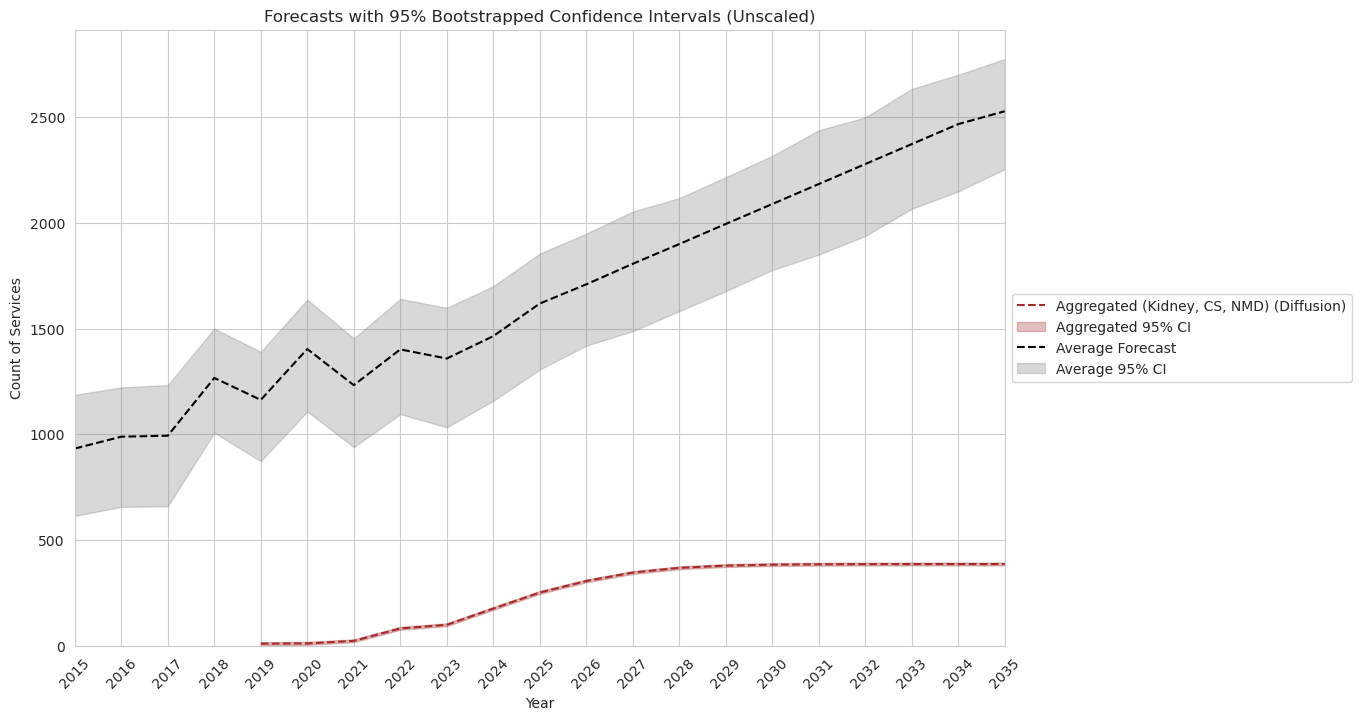

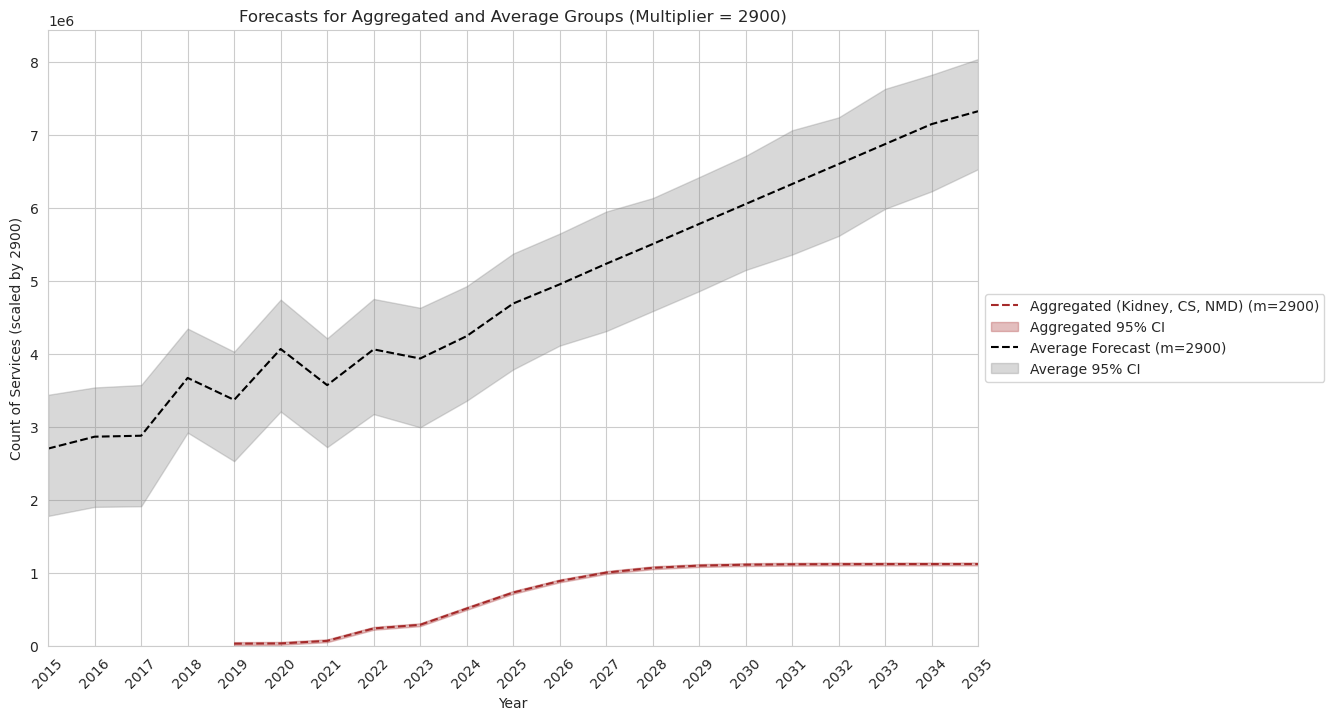

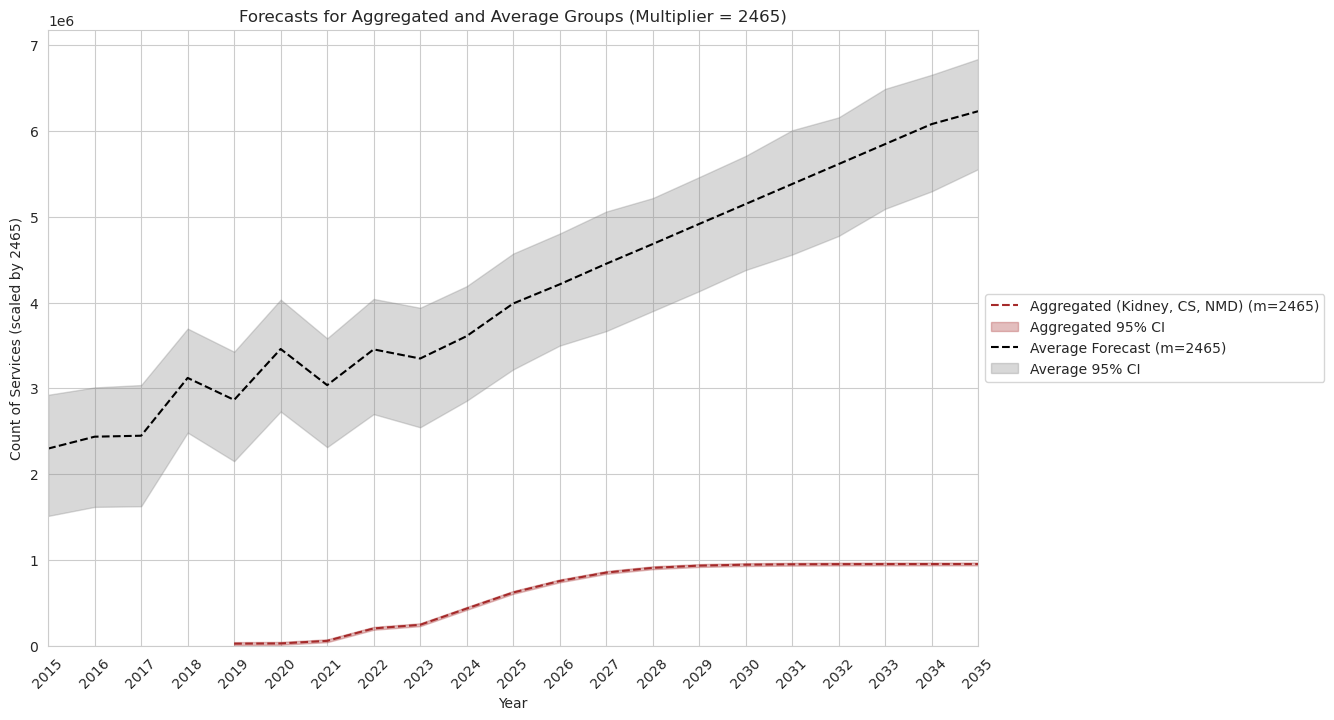

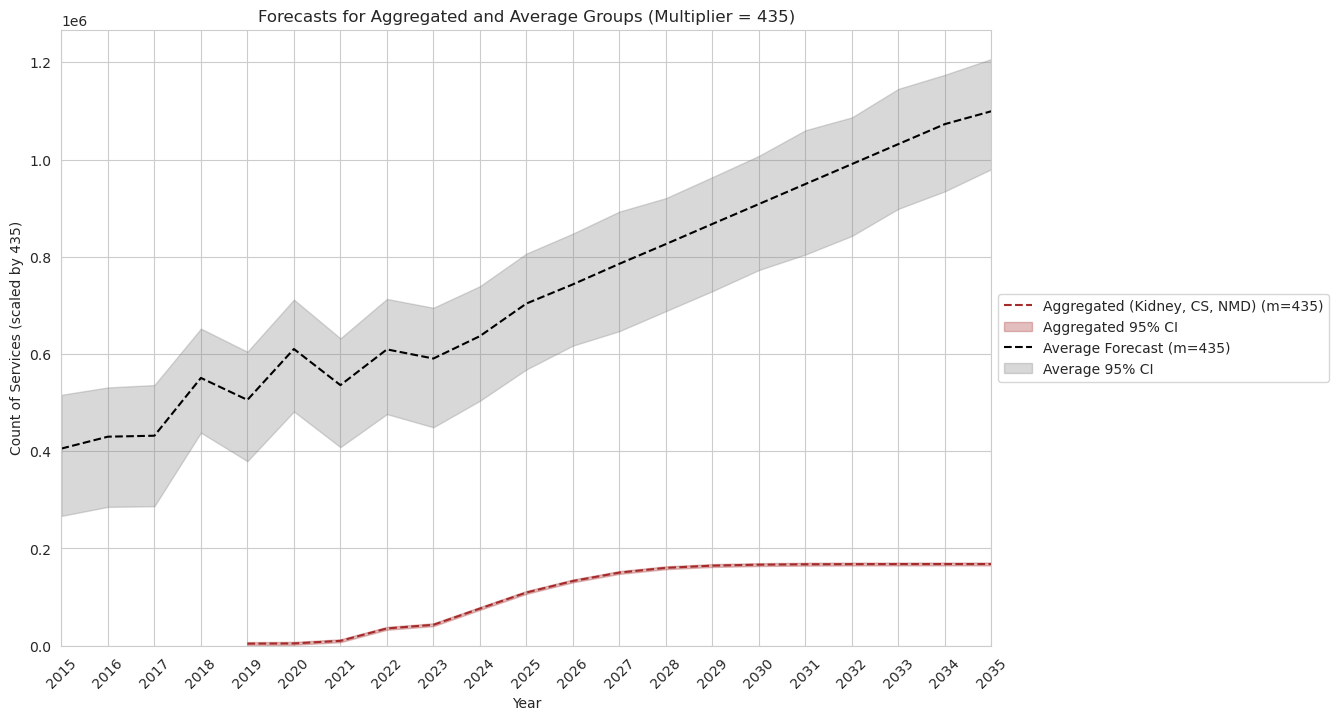

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

##########################
# Load and prepare the data
##########################
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

##########################
# Define groups and settings
##########################
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300']
}

color_map = {
    'CMA': 'red',
    'FMR1': 'blue'
}
agg_color = 'brown'  # color for aggregated secondary forecast

# Filter data for our items.
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

##########################
# Define model functions (Diffusion Models)
##########################
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

##########################
# Forecasting for each group
##########################
best_predictions = []
diffusion_models = {
    "Logistic Diffusion": logistic_diffusion,
    "Gompertz": gompertz,
    "Bass Diffusion": bass_diffusion
}

for group, items in group_definitions.items():
    # Resample using month-end frequency and smooth.
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('ME').sum().dropna()
    group_data = group_data.rolling(window=12, min_periods=1).mean()

    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Convert date index to decimal years (for fitting only).
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)

    # --- Diffusion Models ---
    for model_name, model_func in diffusion_models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # --- SARIMA Model for CMA and FMR1 only ---
    if group in ["CMA", "FMR1"]:
        try:
            sarima_model = SARIMAX(group_data, order=(1,1,1), seasonal_order=(1,1,1,12))
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.fittedvalues
            sarima_r2 = r2_score(group_data, sarima_pred)
            # Create forecast grid in whole years.
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years_sarima = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            forecast_index = pd.date_range(start=group_data.index[0],
                                           end=group_data.index[-1] + pd.DateOffset(years=10),
                                           freq='ME')
            sarima_forecast = sarima_fit.predict(start=group_data.index[0],
                                                 end=group_data.index[-1] + pd.DateOffset(years=10),
                                                 dynamic=False)
            sarima_forecast_interp = np.interp(forecast_years_sarima,
                                               forecast_index.year + (forecast_index.month - 1)/12.0,
                                               sarima_forecast.values)
            # Compute residuals for SARIMA using in-sample data.
            sarima_resid = group_data.values - sarima_pred
            results["SARIMA"] = {'r2': sarima_r2,
                                 'forecast_years': forecast_years_sarima,
                                 'forecast': sarima_forecast_interp,
                                 'residuals': sarima_resid}
        except Exception as e:
            print(f"Error fitting SARIMA for group {group}: {e}")

    # --- Select Best Model, Generate Forecast, and Compute Bootstrapped CIs ---
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        if best_model_name == "SARIMA":
            forecast_years = best_model_metrics['forecast_years']
            best_pred_full = best_model_metrics['forecast']
            residuals = best_model_metrics.get('residuals')
        else:
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
            residuals = group_data.values - best_model_metrics['func'](fitted_years, *best_model_metrics['params'])

        # Center the residuals before bootstrapping.
        resid_centered = residuals - np.mean(residuals)
        B = 500
        bootstrap_forecasts = np.zeros((B, len(forecast_years)))
        for b in range(B):
            boot_errors = np.random.choice(resid_centered, size=len(forecast_years), replace=True)
            bootstrap_forecasts[b, :] = best_pred_full + boot_errors
        ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
        ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

        entry = {
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full,
            'CI_lower': ci_lower,
            'CI_upper': ci_upper
        }
        # For secondary groups, also store in-sample info.
        if group in ["Kidney", "CS", "NMD"]:
            entry['InSampleYears'] = fitted_years
            entry['InSampleFitted'] = best_model_metrics['func'](fitted_years, *best_model_metrics['params'])
            entry['InSampleObserved'] = group_data.values
        best_predictions.append(entry)

##########################
# Aggregated forecast for secondary groups (Kidney, CS, NMD)
##########################
secondary_preds = [bp for bp in best_predictions if bp['Group'] in ["Kidney", "CS", "NMD"]]
if secondary_preds:
    common_start = min(bp['Years'][0] for bp in secondary_preds)
    common_end = max(bp['Years'][-1] for bp in secondary_preds)
    common_time = np.arange(int(common_start), int(common_end) + 1, 1)

    aggregated_forecast = np.zeros_like(common_time, dtype=float)
    for bp in secondary_preds:
        aggregated_forecast += np.interp(common_time, bp['Years'], bp['Predicted'])

    # Compute aggregated in-sample residuals over the overlapping period.
    in_sample_starts = [bp['InSampleYears'][0] for bp in secondary_preds]
    in_sample_ends = [bp['InSampleYears'][-1] for bp in secondary_preds]
    common_in_start = max(in_sample_starts)
    common_in_end = min(in_sample_ends)
    common_in_time = np.arange(int(np.floor(common_in_start)), int(np.ceil(common_in_end)) + 1, 1)
    aggregated_residuals = np.zeros_like(common_in_time, dtype=float)
    for bp in secondary_preds:
        obs_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleObserved'])
        fit_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleFitted'])
        aggregated_residuals += (obs_interp - fit_interp)

    # Center aggregated residuals.
    aggregated_resid_centered = aggregated_residuals - np.mean(aggregated_residuals)
    B = 500
    bootstrap_forecasts = np.zeros((B, len(common_time)))
    for b in range(B):
        boot_errors = np.random.choice(aggregated_resid_centered, size=len(common_time), replace=True)
        bootstrap_forecasts[b, :] = aggregated_forecast + boot_errors
    agg_ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
    agg_ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

    aggregated_secondary_forecast = {
        'Group': 'Aggregated (Kidney, CS, NMD)',
        'BestModel': "Diffusion",
        'Years': common_time,
        'Predicted': aggregated_forecast,
        'CI_lower': agg_ci_lower,
        'CI_upper': agg_ci_upper
    }
else:
    aggregated_secondary_forecast = None

##########################
# Extract forecasts for CMA and FMR1 and compute their average from 2015 onward
##########################
primary_forecasts = {bp['Group']: bp for bp in best_predictions if bp['Group'] in ["CMA", "FMR1"]}
if "CMA" in primary_forecasts and "FMR1" in primary_forecasts:
    years_cma = primary_forecasts["CMA"]['Years']
    pred_cma = primary_forecasts["CMA"]['Predicted']
    years_fmr1 = primary_forecasts["FMR1"]['Years']
    pred_fmr1 = primary_forecasts["FMR1"]['Predicted']

    common_start_avg = max(years_cma[0], years_fmr1[0], 2015)
    common_end_avg = min(years_cma[-1], years_fmr1[-1])
    common_years_avg = np.arange(int(common_start_avg), int(common_end_avg) + 1, 1)

    # Interpolate the forecasts onto the common grid.
    interp_cma = np.interp(common_years_avg, years_cma, pred_cma)
    interp_fmr1 = np.interp(common_years_avg, years_fmr1, pred_fmr1)
    avg_forecast = (interp_cma + interp_fmr1) / 2

    # For bootstrapping, compute in-sample residuals for each primary forecast.
    resid_cma = primary_forecasts["CMA"].get('residuals', primary_forecasts["CMA"]['Predicted'][:len(interp_cma)] - interp_cma)
    resid_fmr1 = primary_forecasts["FMR1"].get('residuals', primary_forecasts["FMR1"]['Predicted'][:len(interp_fmr1)] - interp_fmr1)
    # Center each set of residuals.
    resid_cma_centered = resid_cma - np.mean(resid_cma)
    resid_fmr1_centered = resid_fmr1 - np.mean(resid_fmr1)
    B = 500
    bootstrap_avg = np.zeros((B, len(common_years_avg)))
    for b in range(B):
        boot_error_cma = np.random.choice(resid_cma_centered, size=len(common_years_avg), replace=True)
        boot_error_fmr1 = np.random.choice(resid_fmr1_centered, size=len(common_years_avg), replace=True)
        boot_forecast_cma = interp_cma + boot_error_cma
        boot_forecast_fmr1 = interp_fmr1 + boot_error_fmr1
        bootstrap_avg[b, :] = (boot_forecast_cma + boot_forecast_fmr1) / 2
    avg_ci_lower = np.percentile(bootstrap_avg, 2.5, axis=0)
    avg_ci_upper = np.percentile(bootstrap_avg, 97.5, axis=0)
else:
    raise ValueError("Forecasts for both CMA and FMR1 are required for averaging.")

##########################
# (Optional) Plotting the original forecasts (unscaled)
##########################
fig, ax = plt.subplots(figsize=(12, 8))
if aggregated_secondary_forecast is not None:
    ax.plot(aggregated_secondary_forecast['Years'], aggregated_secondary_forecast['Predicted'],
            linestyle='--', color=agg_color,
            label=f"{aggregated_secondary_forecast['Group']} ({aggregated_secondary_forecast['BestModel']})")
    ax.fill_between(aggregated_secondary_forecast['Years'],
                    aggregated_secondary_forecast['CI_lower'],
                    aggregated_secondary_forecast['CI_upper'],
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")
ax.plot(common_years_avg, avg_forecast, linestyle='--', color='black', linewidth=1.5, label="Average Forecast")
ax.fill_between(common_years_avg, avg_ci_lower, avg_ci_upper, color='gray', alpha=0.3, label="Average 95% CI")
global_start = min(common_years_avg[0],
                   aggregated_secondary_forecast['Years'][0] if aggregated_secondary_forecast is not None else common_years_avg[0])
global_end = max(common_years_avg[-1],
                 aggregated_secondary_forecast['Years'][-1] if aggregated_secondary_forecast is not None else common_years_avg[-1])
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
ax.set_title("Forecasts with 95% Bootstrapped Confidence Intervals (Unscaled)")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()  # Uncomment to display the unscaled plot

##########################
# Generate table for Aggregated and Average Groups, scaled by multipliers
##########################
multipliers = [2900, 2465, 435]
agg_group_name = 'Aggregated (Kidney, CS, NMD)'
avg_group_name = 'Average (CMA & FMR1)'
years_range = sorted(list(set(range(2025, 2036))))
table_data = {}

for year in years_range:
    row = {}
    # Process Aggregated Group.
    if aggregated_secondary_forecast is not None and year in aggregated_secondary_forecast['Years']:
        idx = np.where(aggregated_secondary_forecast['Years'] == year)[0][0]
        pred_val = aggregated_secondary_forecast['Predicted'][idx]
        ci_lower_val = aggregated_secondary_forecast['CI_lower'][idx]
        ci_upper_val = aggregated_secondary_forecast['CI_upper'][idx]
        for m in multipliers:
            row[f"{agg_group_name}_{m}"] = f"{pred_val * m:.2f} ({ci_lower_val * m:.2f}, {ci_upper_val * m:.2f})"
    else:
        for m in multipliers:
            row[f"{agg_group_name}_{m}"] = ""
    
    # Process Average Group.
    if year in common_years_avg:
        idx = np.where(common_years_avg == year)[0][0]
        pred_val = avg_forecast[idx]
        ci_lower_val = avg_ci_lower[idx]
        ci_upper_val = avg_ci_upper[idx]
        for m in multipliers:
            row[f"{avg_group_name}_{m}"] = f"{pred_val * m:.2f} ({ci_lower_val * m:.2f}, {ci_upper_val * m:.2f})"
    else:
        for m in multipliers:
            row[f"{avg_group_name}_{m}"] = ""
    
    table_data[year] = row

df_final = pd.DataFrame.from_dict(table_data, orient='index')
df_final.index.name = 'Year'
print(df_final)

##########################
# Create a separate plot for each multiplier
##########################
for m in multipliers:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot Aggregated Group forecast if available.
    if aggregated_secondary_forecast is not None:
        years_agg = aggregated_secondary_forecast['Years']
        agg_pred_scaled = aggregated_secondary_forecast['Predicted'] * m
        agg_ci_lower_scaled = aggregated_secondary_forecast['CI_lower'] * m
        agg_ci_upper_scaled = aggregated_secondary_forecast['CI_upper'] * m
        ax.plot(years_agg, agg_pred_scaled, linestyle='--', color=agg_color,
                label=f"{agg_group_name} (m={m})")
        ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled, color=agg_color, alpha=0.3, label="Aggregated 95% CI")
    
    # Plot Average Group forecast.
    avg_pred_scaled = avg_forecast * m
    avg_ci_lower_scaled = avg_ci_lower * m
    avg_ci_upper_scaled = avg_ci_upper * m
    ax.plot(common_years_avg, avg_pred_scaled, linestyle='--', color='black', linewidth=1.5, label=f"Average Forecast (m={m})")
    ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled, color='gray', alpha=0.3, label="Average 95% CI")
    
    # Set axis limits and labels.
    if aggregated_secondary_forecast is not None:
        global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0])
        global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1])
    else:
        global_start = common_years_avg[0]
        global_end = common_years_avg[-1]
    ax.set_xlim(global_start, global_end)
    ax.set_ylim(bottom=0)
    ax.set_xlabel("Year")
    ax.set_ylabel(f"Count of Services (scaled by {m})")
    ax.set_title(f"Forecasts for Aggregated and Average Groups (Multiplier = {m})")
    ax.set_xticks(np.arange(global_start, global_end + 1, 1))
    ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


     Aggregated (Kidney, CS, NMD)_Unscaled  \
Year                                         
2025               251.53 (245.20, 258.83)   
2026               306.01 (299.68, 313.31)   
2027               345.82 (339.49, 353.12)   
2028               368.22 (361.89, 375.52)   
2029               378.71 (372.38, 386.01)   
2030               383.20 (376.87, 390.50)   
2031               385.04 (378.71, 392.34)   
2032               385.78 (379.45, 393.08)   
2033               386.08 (379.75, 393.38)   
2034               386.20 (379.87, 393.50)   
2035               386.25 (379.92, 393.55)   

     Aggregated (Kidney, CS, NMD)_501.415  \
Year                                        
2025     126121.52 (122947.65, 129782.04)   
2026     153439.10 (150265.23, 157099.62)   
2027     173400.47 (170226.60, 177060.99)   
2028     184629.66 (181455.79, 188290.18)   
2029     189890.66 (186716.79, 193551.18)   
2030     192139.79 (188965.92, 195800.31)   
2031     193063.31 (189889.44, 196723.83)

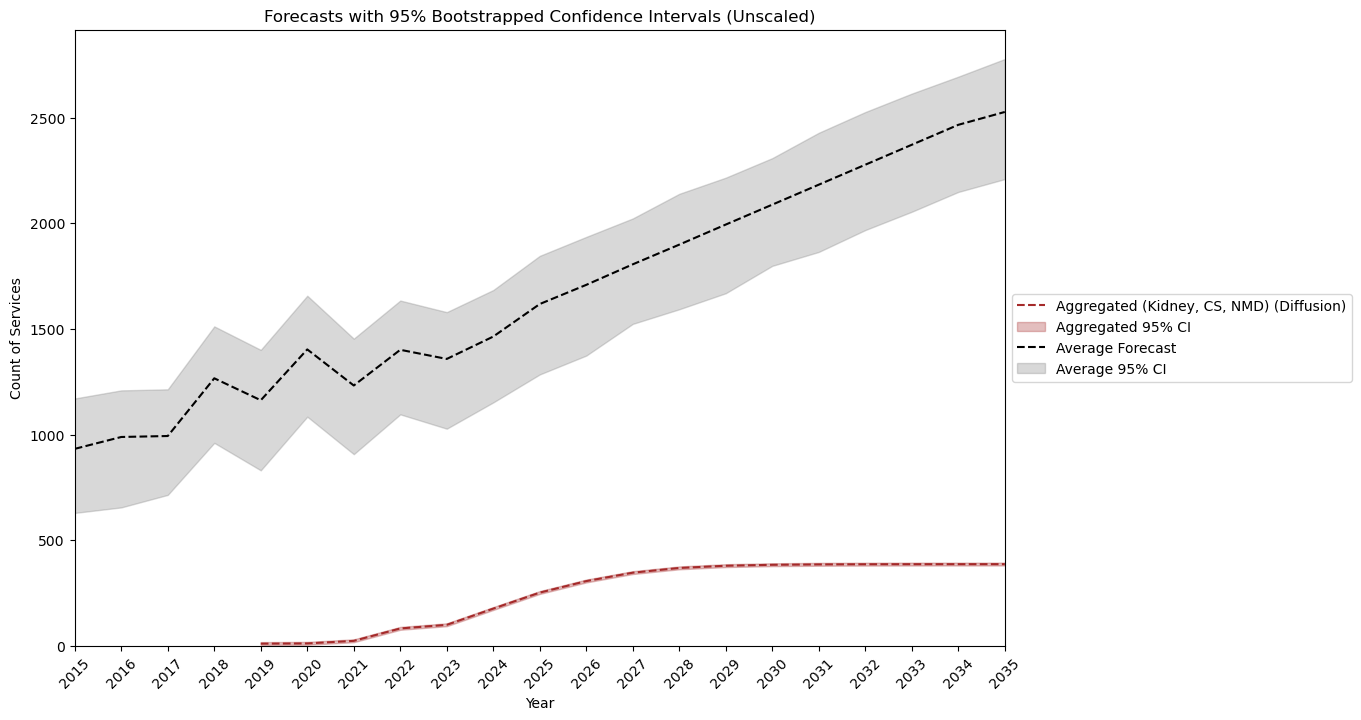

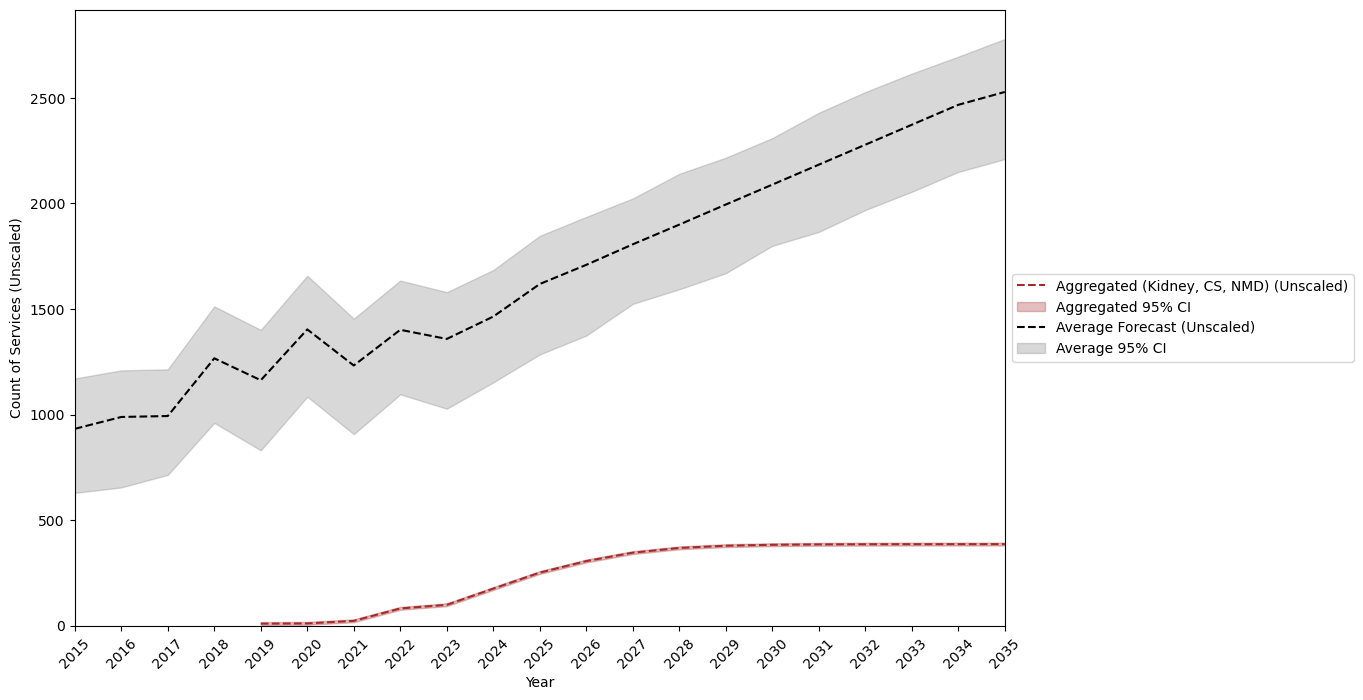

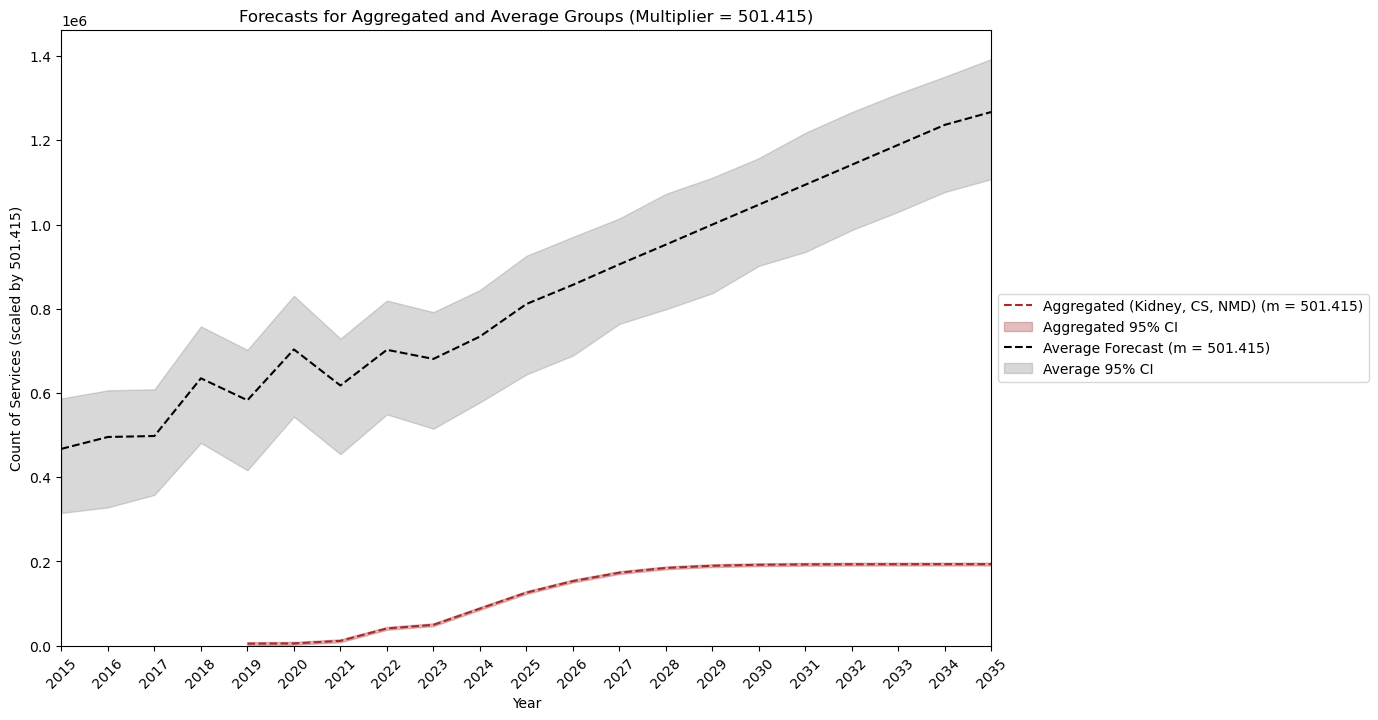

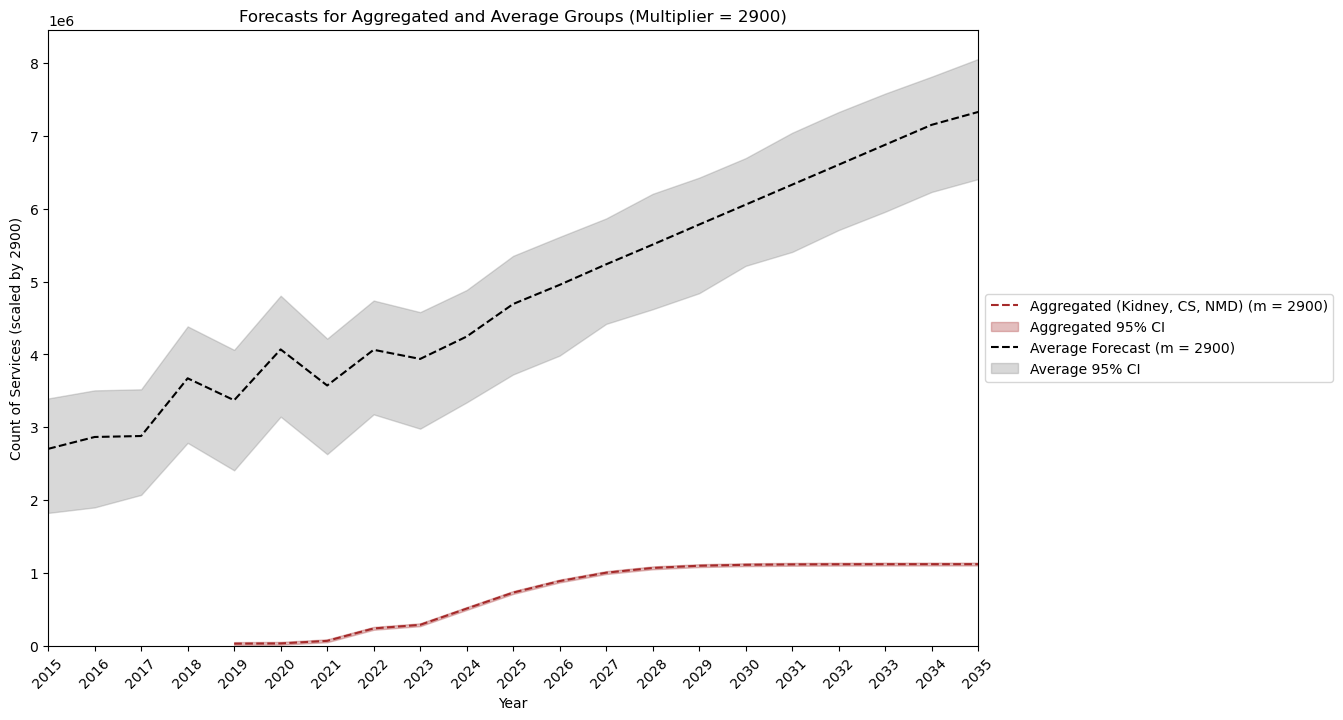

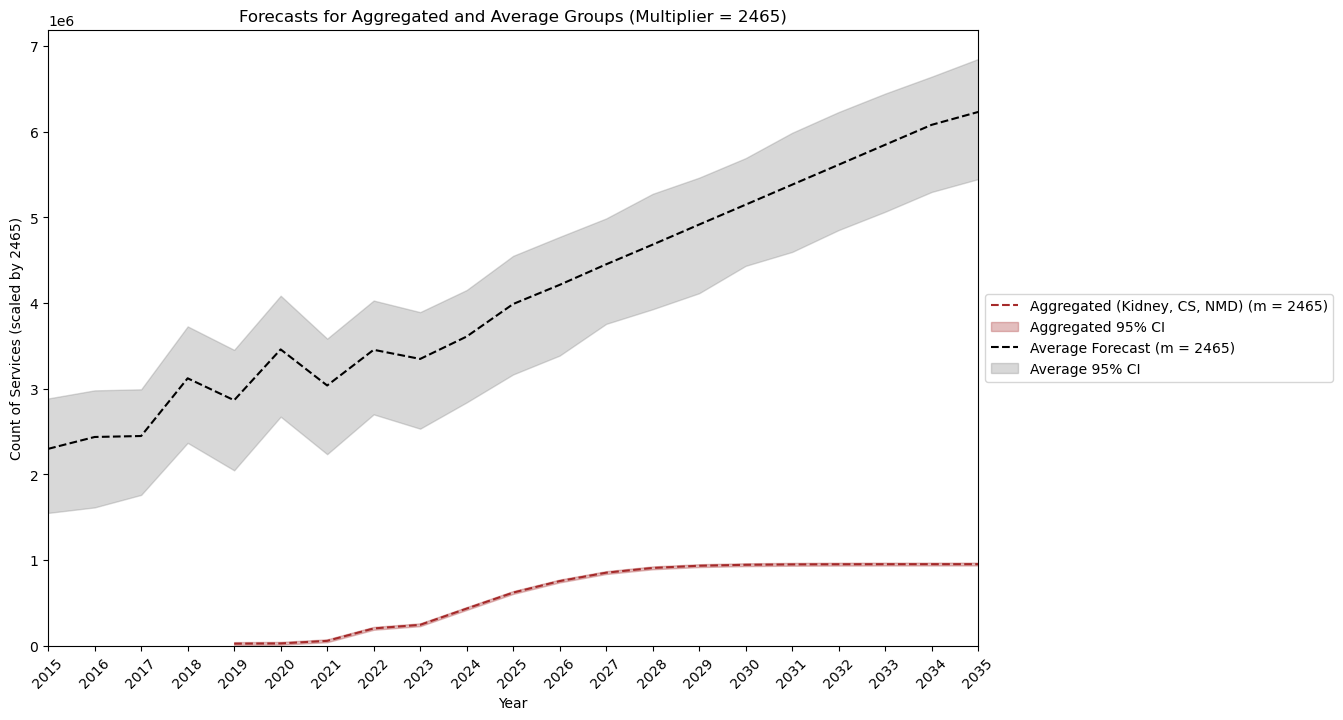

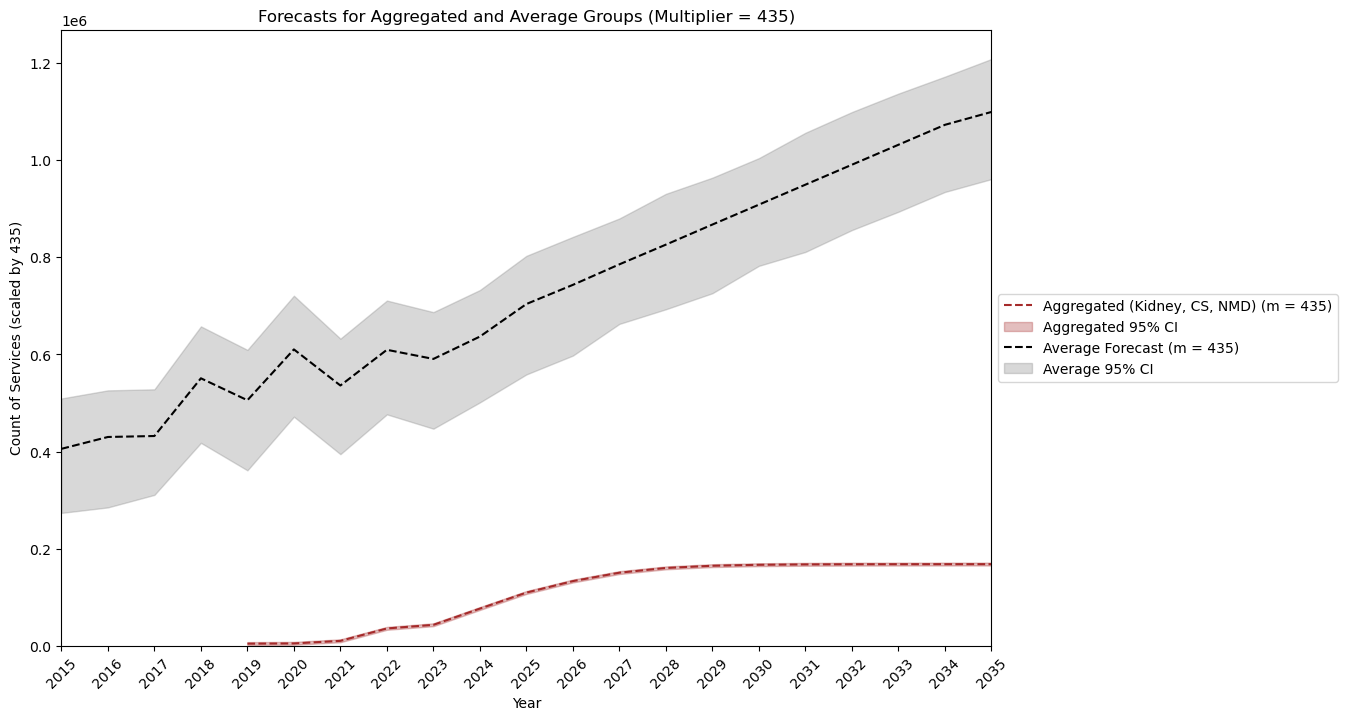

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

##########################
# Load and prepare the data
##########################
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

##########################
# Define groups and settings
##########################
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300']
}

color_map = {
    'CMA': 'red',
    'FMR1': 'blue'
}
agg_color = 'brown'  # color for aggregated secondary forecast

# Filter data for our items.
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

##########################
# Define model functions (Diffusion Models)
##########################
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

##########################
# Forecasting for each group
##########################
best_predictions = []
diffusion_models = {
    "Logistic Diffusion": logistic_diffusion,
    "Gompertz": gompertz,
    "Bass Diffusion": bass_diffusion
}

for group, items in group_definitions.items():
    # Resample using month-end frequency and smooth.
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('ME').sum().dropna()
    group_data = group_data.rolling(window=12, min_periods=1).mean()

    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Convert date index to decimal years (for fitting only).
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)

    # --- Diffusion Models ---
    for model_name, model_func in diffusion_models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # --- SARIMA Model for CMA and FMR1 only ---
    if group in ["CMA", "FMR1"]:
        try:
            sarima_model = SARIMAX(group_data, order=(1,1,1), seasonal_order=(1,1,1,12))
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.fittedvalues
            sarima_r2 = r2_score(group_data, sarima_pred)
            # Create forecast grid in whole years.
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years_sarima = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            forecast_index = pd.date_range(start=group_data.index[0],
                                           end=group_data.index[-1] + pd.DateOffset(years=10),
                                           freq='ME')
            sarima_forecast = sarima_fit.predict(start=group_data.index[0],
                                                 end=group_data.index[-1] + pd.DateOffset(years=10),
                                                 dynamic=False)
            sarima_forecast_interp = np.interp(forecast_years_sarima,
                                               forecast_index.year + (forecast_index.month - 1)/12.0,
                                               sarima_forecast.values)
            # Compute residuals for SARIMA using in-sample data.
            sarima_resid = group_data.values - sarima_pred
            results["SARIMA"] = {'r2': sarima_r2,
                                 'forecast_years': forecast_years_sarima,
                                 'forecast': sarima_forecast_interp,
                                 'residuals': sarima_resid}
        except Exception as e:
            print(f"Error fitting SARIMA for group {group}: {e}")

    # --- Select Best Model, Generate Forecast, and Compute Bootstrapped CIs ---
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        if best_model_name == "SARIMA":
            forecast_years = best_model_metrics['forecast_years']
            best_pred_full = best_model_metrics['forecast']
            residuals = best_model_metrics.get('residuals')
        else:
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
            residuals = group_data.values - best_model_metrics['func'](fitted_years, *best_model_metrics['params'])

        # Center the residuals before bootstrapping.
        resid_centered = residuals - np.mean(residuals)
        B = 500
        bootstrap_forecasts = np.zeros((B, len(forecast_years)))
        for b in range(B):
            boot_errors = np.random.choice(resid_centered, size=len(forecast_years), replace=True)
            bootstrap_forecasts[b, :] = best_pred_full + boot_errors
        ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
        ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

        entry = {
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full,
            'CI_lower': ci_lower,
            'CI_upper': ci_upper
        }
        # For secondary groups, also store in-sample info.
        if group in ["Kidney", "CS", "NMD"]:
            entry['InSampleYears'] = fitted_years
            entry['InSampleFitted'] = best_model_metrics['func'](fitted_years, *best_model_metrics['params'])
            entry['InSampleObserved'] = group_data.values
        best_predictions.append(entry)

##########################
# Aggregated forecast for secondary groups (Kidney, CS, NMD)
##########################
secondary_preds = [bp for bp in best_predictions if bp['Group'] in ["Kidney", "CS", "NMD"]]
if secondary_preds:
    common_start = min(bp['Years'][0] for bp in secondary_preds)
    common_end = max(bp['Years'][-1] for bp in secondary_preds)
    common_time = np.arange(int(common_start), int(common_end) + 1, 1)

    aggregated_forecast = np.zeros_like(common_time, dtype=float)
    for bp in secondary_preds:
        aggregated_forecast += np.interp(common_time, bp['Years'], bp['Predicted'])

    # Compute aggregated in-sample residuals over the overlapping period.
    in_sample_starts = [bp['InSampleYears'][0] for bp in secondary_preds]
    in_sample_ends = [bp['InSampleYears'][-1] for bp in secondary_preds]
    common_in_start = max(in_sample_starts)
    common_in_end = min(in_sample_ends)
    common_in_time = np.arange(int(np.floor(common_in_start)), int(np.ceil(common_in_end)) + 1, 1)
    aggregated_residuals = np.zeros_like(common_in_time, dtype=float)
    for bp in secondary_preds:
        obs_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleObserved'])
        fit_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleFitted'])
        aggregated_residuals += (obs_interp - fit_interp)

    # Center aggregated residuals.
    aggregated_resid_centered = aggregated_residuals - np.mean(aggregated_residuals)
    B = 500
    bootstrap_forecasts = np.zeros((B, len(common_time)))
    for b in range(B):
        boot_errors = np.random.choice(aggregated_resid_centered, size=len(common_time), replace=True)
        bootstrap_forecasts[b, :] = aggregated_forecast + boot_errors
    agg_ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
    agg_ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

    aggregated_secondary_forecast = {
        'Group': 'Aggregated (Kidney, CS, NMD)',
        'BestModel': "Diffusion",
        'Years': common_time,
        'Predicted': aggregated_forecast,
        'CI_lower': agg_ci_lower,
        'CI_upper': agg_ci_upper
    }
else:
    aggregated_secondary_forecast = None

##########################
# Extract forecasts for CMA and FMR1 and compute their average from 2015 onward
##########################
primary_forecasts = {bp['Group']: bp for bp in best_predictions if bp['Group'] in ["CMA", "FMR1"]}
if "CMA" in primary_forecasts and "FMR1" in primary_forecasts:
    years_cma = primary_forecasts["CMA"]['Years']
    pred_cma = primary_forecasts["CMA"]['Predicted']
    years_fmr1 = primary_forecasts["FMR1"]['Years']
    pred_fmr1 = primary_forecasts["FMR1"]['Predicted']

    common_start_avg = max(years_cma[0], years_fmr1[0], 2015)
    common_end_avg = min(years_cma[-1], years_fmr1[-1])
    common_years_avg = np.arange(int(common_start_avg), int(common_end_avg) + 1, 1)

    # Interpolate the forecasts onto the common grid.
    interp_cma = np.interp(common_years_avg, years_cma, pred_cma)
    interp_fmr1 = np.interp(common_years_avg, years_fmr1, pred_fmr1)
    avg_forecast = (interp_cma + interp_fmr1) / 2

    # For bootstrapping, compute in-sample residuals for each primary forecast.
    resid_cma = primary_forecasts["CMA"].get('residuals', primary_forecasts["CMA"]['Predicted'][:len(interp_cma)] - interp_cma)
    resid_fmr1 = primary_forecasts["FMR1"].get('residuals', primary_forecasts["FMR1"]['Predicted'][:len(interp_fmr1)] - interp_fmr1)
    # Center each set of residuals.
    resid_cma_centered = resid_cma - np.mean(resid_cma)
    resid_fmr1_centered = resid_fmr1 - np.mean(resid_fmr1)
    B = 500
    bootstrap_avg = np.zeros((B, len(common_years_avg)))
    for b in range(B):
        boot_error_cma = np.random.choice(resid_cma_centered, size=len(common_years_avg), replace=True)
        boot_error_fmr1 = np.random.choice(resid_fmr1_centered, size=len(common_years_avg), replace=True)
        boot_forecast_cma = interp_cma + boot_error_cma
        boot_forecast_fmr1 = interp_fmr1 + boot_error_fmr1
        bootstrap_avg[b, :] = (boot_forecast_cma + boot_forecast_fmr1) / 2
    avg_ci_lower = np.percentile(bootstrap_avg, 2.5, axis=0)
    avg_ci_upper = np.percentile(bootstrap_avg, 97.5, axis=0)
else:
    raise ValueError("Forecasts for both CMA and FMR1 are required for averaging.")

##########################
# (Optional) Plotting the original forecasts (unscaled)
##########################
fig, ax = plt.subplots(figsize=(12, 8))
if aggregated_secondary_forecast is not None:
    ax.plot(aggregated_secondary_forecast['Years'], aggregated_secondary_forecast['Predicted'],
            linestyle='--', color=agg_color,
            label=f"{aggregated_secondary_forecast['Group']} ({aggregated_secondary_forecast['BestModel']})")
    ax.fill_between(aggregated_secondary_forecast['Years'],
                    aggregated_secondary_forecast['CI_lower'],
                    aggregated_secondary_forecast['CI_upper'],
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")
ax.plot(common_years_avg, avg_forecast, linestyle='--', color='black', linewidth=1.5, label="Average Forecast")
ax.fill_between(common_years_avg, avg_ci_lower, avg_ci_upper,
                color='gray', alpha=0.3, label="Average 95% CI")
global_start = min(common_years_avg[0],
                   aggregated_secondary_forecast['Years'][0] if aggregated_secondary_forecast is not None else common_years_avg[0])
global_end = max(common_years_avg[-1],
                 aggregated_secondary_forecast['Years'][-1] if aggregated_secondary_forecast is not None else common_years_avg[-1])
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
ax.set_title("Forecasts with 95% Bootstrapped Confidence Intervals (Unscaled)")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()  # Uncomment to display the unscaled plot

##########################
# Generate table for Aggregated and Average Groups, scaled by each multiplier
##########################
# Multipliers now include unscaled (1) and 501.415 in addition to the previous ones.
multipliers = [1, 501.415, 2900, 2465, 435]
agg_group_name = 'Aggregated (Kidney, CS, NMD)'
avg_group_name = 'Average (CMA & FMR1)'
years_range = sorted(list(set(range(2025, 2036))))
table_data = {}

for year in years_range:
    row = {}
    # Process Aggregated Group.
    if aggregated_secondary_forecast is not None and year in aggregated_secondary_forecast['Years']:
        idx = np.where(aggregated_secondary_forecast['Years'] == year)[0][0]
        pred_val = aggregated_secondary_forecast['Predicted'][idx]
        ci_lower_val = aggregated_secondary_forecast['CI_lower'][idx]
        ci_upper_val = aggregated_secondary_forecast['CI_upper'][idx]
        for m in multipliers:
            if m == 1:
                col_name = f"{agg_group_name}_Unscaled"
            else:
                col_name = f"{agg_group_name}_{m}"
            row[col_name] = f"{pred_val * m:.2f} ({ci_lower_val * m:.2f}, {ci_upper_val * m:.2f})"
    else:
        for m in multipliers:
            if m == 1:
                col_name = f"{agg_group_name}_Unscaled"
            else:
                col_name = f"{agg_group_name}_{m}"
            row[col_name] = ""
    
    # Process Average Group.
    if year in common_years_avg:
        idx = np.where(common_years_avg == year)[0][0]
        pred_val = avg_forecast[idx]
        ci_lower_val = avg_ci_lower[idx]
        ci_upper_val = avg_ci_upper[idx]
        for m in multipliers:
            if m == 1:
                col_name = f"{avg_group_name}_Unscaled"
            else:
                col_name = f"{avg_group_name}_{m}"
            row[col_name] = f"{pred_val * m:.2f} ({ci_lower_val * m:.2f}, {ci_upper_val * m:.2f})"
    else:
        for m in multipliers:
            if m == 1:
                col_name = f"{avg_group_name}_Unscaled"
            else:
                col_name = f"{avg_group_name}_{m}"
            row[col_name] = ""
    
    table_data[year] = row

df_final = pd.DataFrame.from_dict(table_data, orient='index')
df_final.index.name = 'Year'
print(df_final)

##########################
# Create separate plots for:
# 1. Unscaled forecasts (m = 1)
# 2. Forecasts scaled with multiplier 501.415
# 3. Plots for the original multipliers: 2900, 2465, and 435
##########################

# 1. Unscaled Plot (m = 1)
m = 1
fig, ax = plt.subplots(figsize=(12, 8))
if aggregated_secondary_forecast is not None:
    years_agg = aggregated_secondary_forecast['Years']
    agg_pred_scaled = aggregated_secondary_forecast['Predicted'] * m
    agg_ci_lower_scaled = aggregated_secondary_forecast['CI_lower'] * m
    agg_ci_upper_scaled = aggregated_secondary_forecast['CI_upper'] * m
    ax.plot(years_agg, agg_pred_scaled, linestyle='--', color=agg_color,
            label=f"{agg_group_name} (Unscaled)")
    ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled,
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")
avg_pred_scaled = avg_forecast * m
avg_ci_lower_scaled = avg_ci_lower * m
avg_ci_upper_scaled = avg_ci_upper * m
ax.plot(common_years_avg, avg_pred_scaled, linestyle='--', color='black', linewidth=1.5,
        label="Average Forecast (Unscaled)")
ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled,
                color='gray', alpha=0.3, label="Average 95% CI")
if aggregated_secondary_forecast is not None:
    global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0])
    global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1])
else:
    global_start = common_years_avg[0]
    global_end = common_years_avg[-1]
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services (Unscaled)")
#ax.set_title("Forecasts for Aggregated and Average Groups (Unscaled)")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 2. Plot with multiplier 501.415
m = 501.415
fig, ax = plt.subplots(figsize=(12, 8))
if aggregated_secondary_forecast is not None:
    years_agg = aggregated_secondary_forecast['Years']
    agg_pred_scaled = aggregated_secondary_forecast['Predicted'] * m
    agg_ci_lower_scaled = aggregated_secondary_forecast['CI_lower'] * m
    agg_ci_upper_scaled = aggregated_secondary_forecast['CI_upper'] * m
    ax.plot(years_agg, agg_pred_scaled, linestyle='--', color=agg_color,
            label=f"{agg_group_name} (m = {m})")
    ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled,
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")
avg_pred_scaled = avg_forecast * m
avg_ci_lower_scaled = avg_ci_lower * m
avg_ci_upper_scaled = avg_ci_upper * m
ax.plot(common_years_avg, avg_pred_scaled, linestyle='--', color='black', linewidth=1.5,
        label=f"Average Forecast (m = {m})")
ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled,
                color='gray', alpha=0.3, label="Average 95% CI")
if aggregated_secondary_forecast is not None:
    global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0])
    global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1])
else:
    global_start = common_years_avg[0]
    global_end = common_years_avg[-1]
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel(f"Count of Services (scaled by {m})")
ax.set_title(f"Forecasts for Aggregated and Average Groups (Multiplier = {m})")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 3. Plots for the original multipliers: 2900, 2465, and 435
for m in [2900, 2465, 435]:
    fig, ax = plt.subplots(figsize=(12, 8))
    if aggregated_secondary_forecast is not None:
        years_agg = aggregated_secondary_forecast['Years']
        agg_pred_scaled = aggregated_secondary_forecast['Predicted'] * m
        agg_ci_lower_scaled = aggregated_secondary_forecast['CI_lower'] * m
        agg_ci_upper_scaled = aggregated_secondary_forecast['CI_upper'] * m
        ax.plot(years_agg, agg_pred_scaled, linestyle='--', color=agg_color,
                label=f"{agg_group_name} (m = {m})")
        ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled,
                        color=agg_color, alpha=0.3, label="Aggregated 95% CI")
    avg_pred_scaled = avg_forecast * m
    avg_ci_lower_scaled = avg_ci_lower * m
    avg_ci_upper_scaled = avg_ci_upper * m
    ax.plot(common_years_avg, avg_pred_scaled, linestyle='--', color='black', linewidth=1.5,
            label=f"Average Forecast (m = {m})")
    ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled,
                    color='gray', alpha=0.3, label="Average 95% CI")
    if aggregated_secondary_forecast is not None:
        global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0])
        global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1])
    else:
        global_start = common_years_avg[0]
        global_end = common_years_avg[-1]
    ax.set_xlim(global_start, global_end)
    ax.set_ylim(bottom=0)
    ax.set_xlabel("Year")
    ax.set_ylabel(f"Count of Services (scaled by {m})")
    ax.set_title(f"Forecasts for Aggregated and Average Groups (Multiplier = {m})")
    ax.set_xticks(np.arange(global_start, global_end + 1, 1))
    ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


In [95]:
df_final

Aggregated (Kidney, CS, NMD)_Unscaled  \
Year                                         
2025               251.53 (245.20, 258.83)   
2026               306.01 (299.68, 313.31)   
2027               345.82 (339.49, 353.12)   
2028               368.22 (361.89, 375.52)   
2029               378.71 (372.38, 386.01)   
2030               383.20 (376.87, 390.50)   
2031               385.04 (378.71, 392.34)   
2032               385.78 (379.45, 393.08)   
2033               386.08 (379.75, 393.38)   
2034               386.20 (379.87, 393.50)   
2035               386.25 (379.92, 393.55)   

     Aggregated (Kidney, CS, NMD)_501.415  \
Year                                        
2025     126121.52 (122947.65, 129782.04)   
2026     153439.10 (150265.23, 157099.62)   
2027     173400.47 (170226.60, 177060.99)   
2028     184629.66 (181455.79, 188290.18)   
2029     189890.66 (186716.79, 193551.18)   
2030     192139.79 (188965.92, 195800.31)   
2031     193063.31 (189889.44, 196723.83)   
2032     193436.22 (190262.35, 197096.74)   
2033     193585.77 (190411.90, 197246.29)   
2034     193645.58 (190471.71, 197306.10)   
2035     193669.48 (190495.61, 197330.00)   

        Aggregated (Kidney, CS, NMD)_2900 Aggregated (Kidney, CS, NMD)_2465  \
Year                                                                          
2025     729440.49 (711083.99, 750611.59)  620024.42 (604421.39, 638019.85)   
2026     887435.37 (869078.87, 908606.47)  754320.06 (738717.04, 772315.50)   
2027   1002884.54 (984528.04, 1024055.64)  852451.86 (836848.84, 870447.30)   
2028  1067830.09 (1049473.59, 1089001.19)  907655.58 (892052.55, 925651.01)   
2029  1098257.78 (1079901.28, 1119428.88)  933519.11 (917916.09, 951514.55)   
2030  1111265.92 (1092909.42, 1132437.02)  944576.03 (928973.00, 962571.46)   
2031  1116607.23 (1098250.73, 1137778.33)  949116.14 (933513.12, 967111.58)   
2032  1118763.96 (1100407.46, 1139935.06)  950949.37 (935346.34, 968944.80)   
2033  1119628.91 (1101272.41, 1140800.01)  951684.57 (936081.55, 969680.01)   
2034  1119974.84 (1101618.34, 1141145.94)  951978.61 (936375.59, 969974.05)   
2035  1120113.04 (1101756.54, 1141284.14)  952096.09 (936493.06, 970091.52)   

      Aggregated (Kidney, CS, NMD)_435 Average (CMA & FMR1)_Unscaled  \
Year                                                                   
2025  109416.07 (106662.60, 112591.74)    1618.20 (1296.10, 1867.67)   
2026  133115.30 (130361.83, 136290.97)    1708.91 (1397.08, 1922.94)   
2027  150432.68 (147679.21, 153608.35)    1806.11 (1535.41, 2027.94)   
2028  160174.51 (157421.04, 163350.18)    1899.44 (1581.46, 2147.67)   
2029  164738.67 (161985.19, 167914.33)    1994.50 (1676.53, 2227.33)   
2030  166689.89 (163936.41, 169865.55)    2088.71 (1759.90, 2309.22)   
2031  167491.08 (164737.61, 170666.75)    2183.33 (1864.73, 2443.80)   
2032  167814.59 (165061.12, 170990.26)    2277.75 (1959.15, 2513.88)   
2033  167944.34 (165190.86, 171120.00)    2372.26 (2065.78, 2593.46)   
2034  167996.23 (165242.75, 171171.89)    2466.73 (2170.79, 2699.91)   
2035  168016.96 (165263.48, 171192.62)    2527.63 (2192.68, 2755.68)   

             Average (CMA & FMR1)_501.415  \
Year                                        
2025     811391.54 (649883.85, 936476.55)   
2026     856874.59 (700517.32, 964191.37)   
2027    905610.46 (769875.39, 1016841.56)   
2028    952407.13 (792970.01, 1076875.43)   
2029   1000073.97 (840636.85, 1116815.70)   
2030   1047312.34 (882442.51, 1157878.22)   
2031   1094754.28 (935005.29, 1225358.77)   
2032   1142098.12 (982349.14, 1260499.29)   
2033  1189488.97 (1035815.02, 1300398.50)   
2034  1236857.24 (1088465.02, 1353777.34)   
2035  1267391.21 (1099444.42, 1381737.52)   

                Average (CMA & FMR1)_2900  \
Year                                        
2025  4692790.34 (3758689.27, 5416236.05)   
2026  4955847.56 (4051534.63, 5576528.35)   
2027  5237717.95 (4452676.19, 5881037.71)   
2028  5508372.69 (4586247.00, 6228251.56)   

     Aggregated (Kidney, CS, NMD)_Unscaled  \
Year                                         
2025                        252 (246, 260)   
2026                        306 (300, 314)   
2027                        347 (341, 355)   
2028                        369 (363, 377)   
2029                        380 (374, 388)   
2030                        384 (378, 392)   
2031                        386 (380, 394)   
2032                        387 (381, 395)   
2033                        387 (381, 395)   
2034                        387 (381, 395)   
2035                        387 (381, 395)   

     Aggregated (Kidney, CS, NMD)_501.415 Aggregated (Kidney, CS, NMD)_2900  \
Year                                                                          
2025              126357 (123348, 130368)           730800 (713400, 754000)   
2026              153433 (150424, 157444)           887400 (870000, 910600)   
2027              173991 (170983, 178002)         1006300 (988900, 1029500)   
2028  

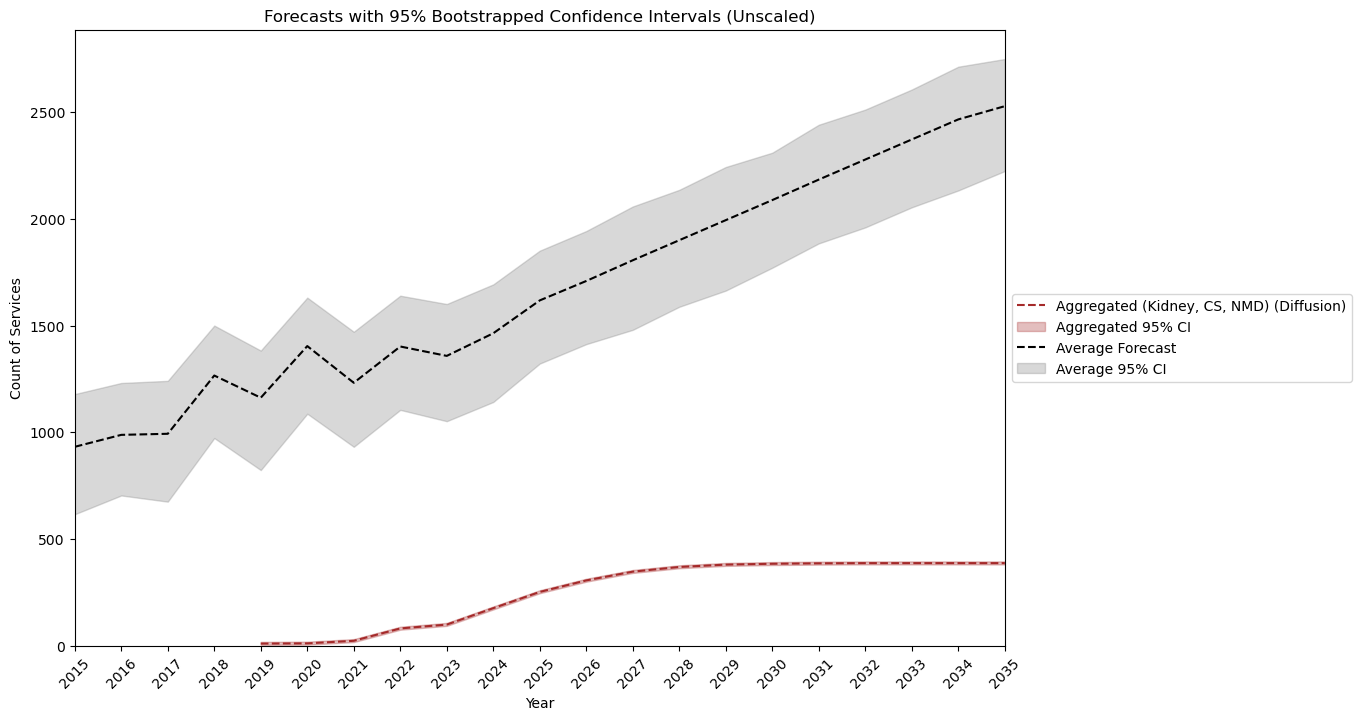

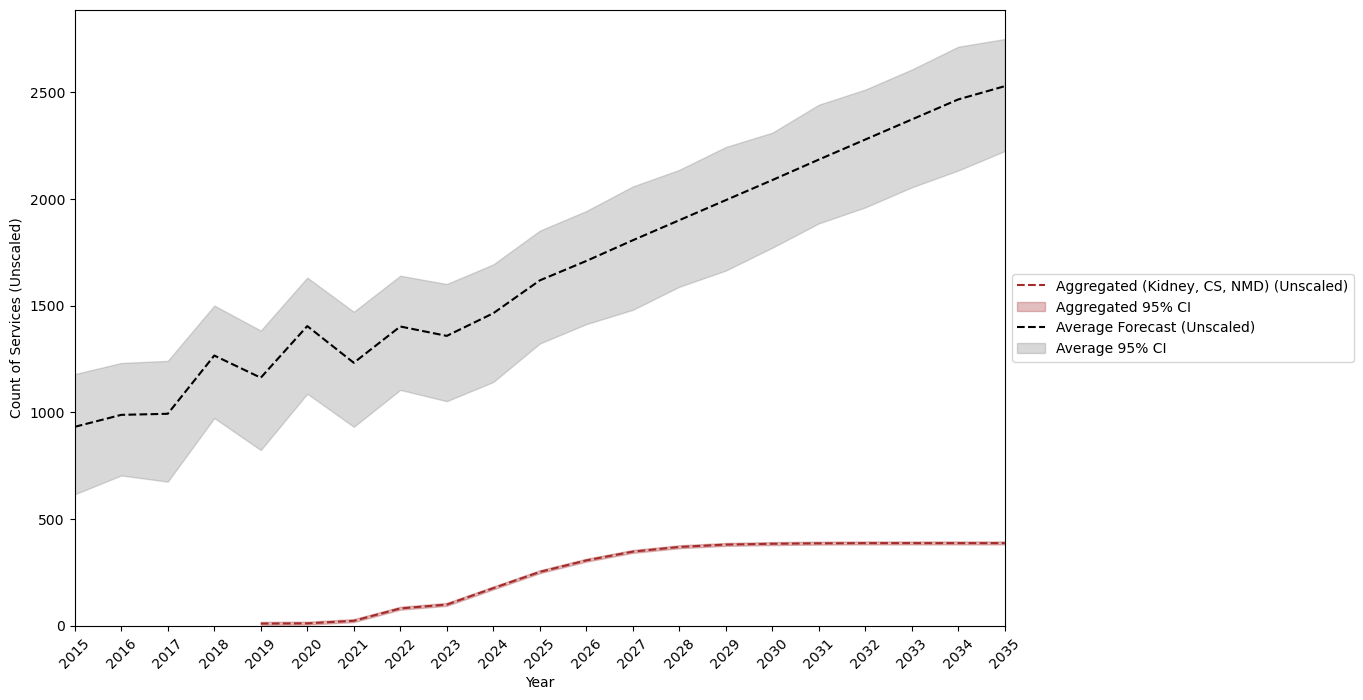

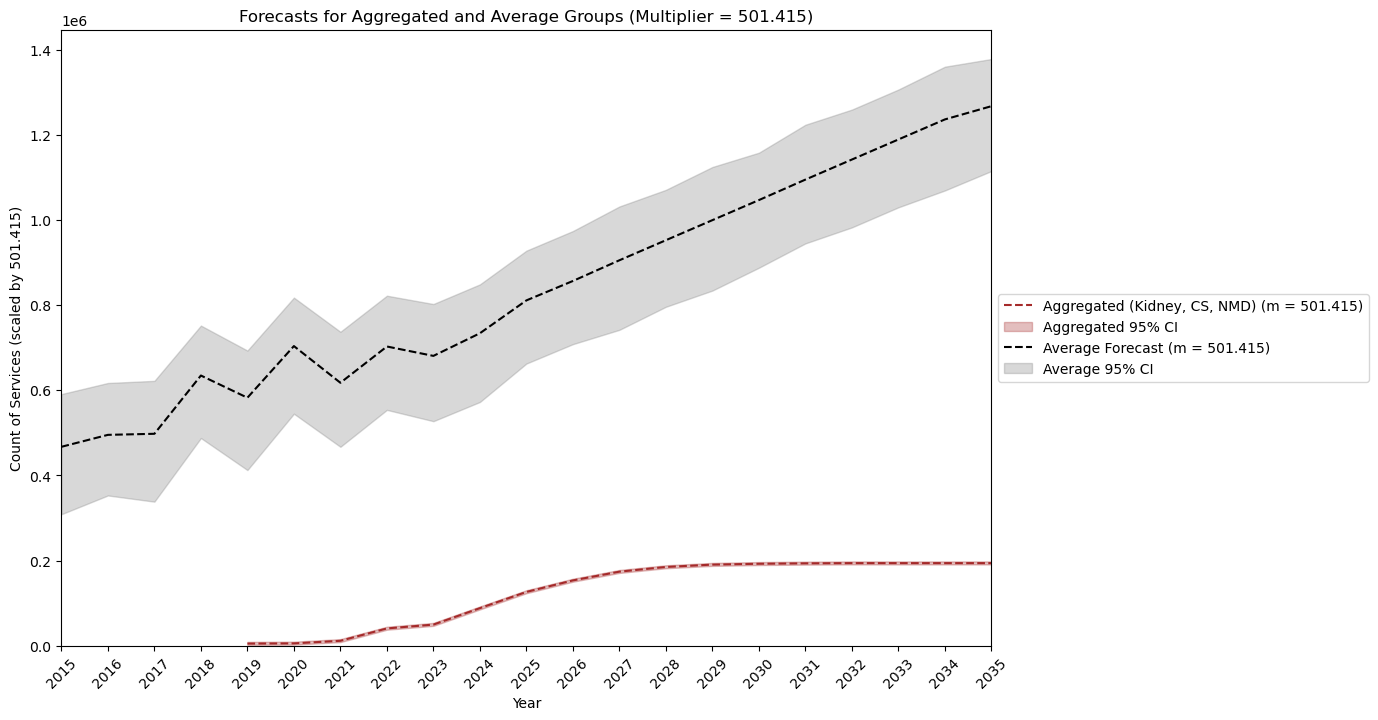

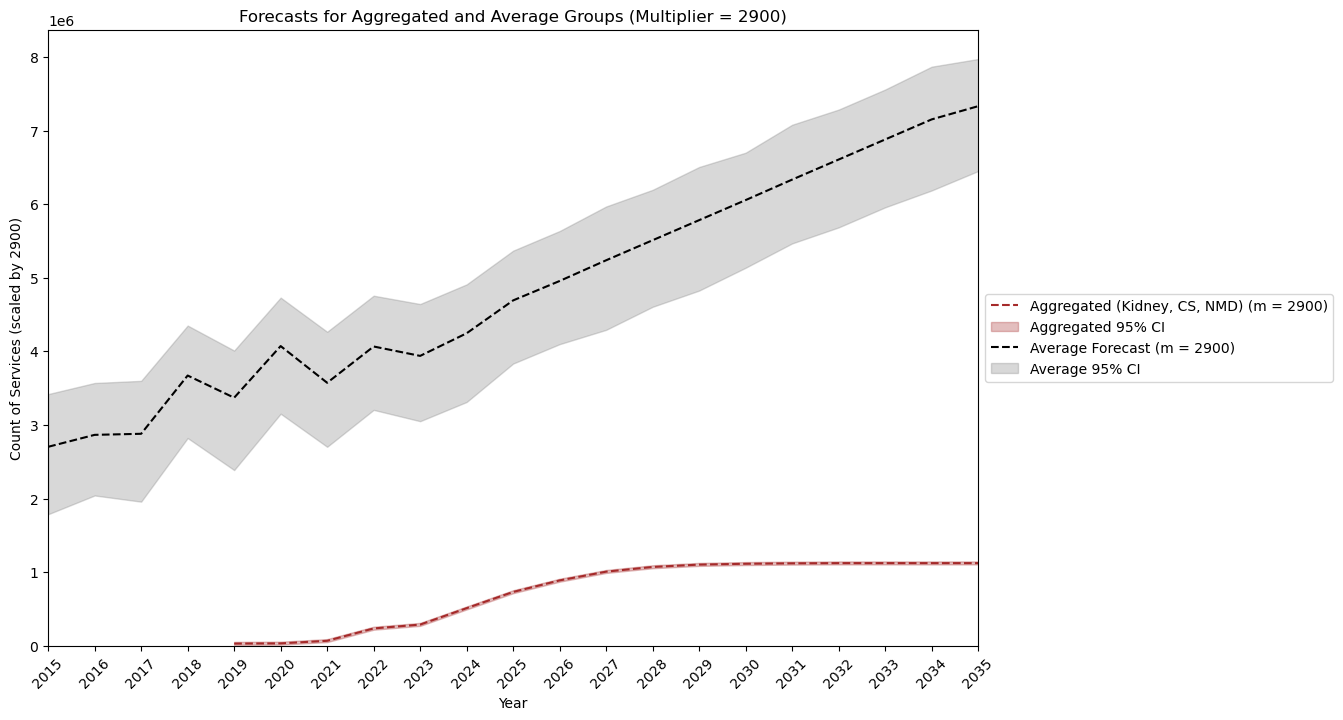

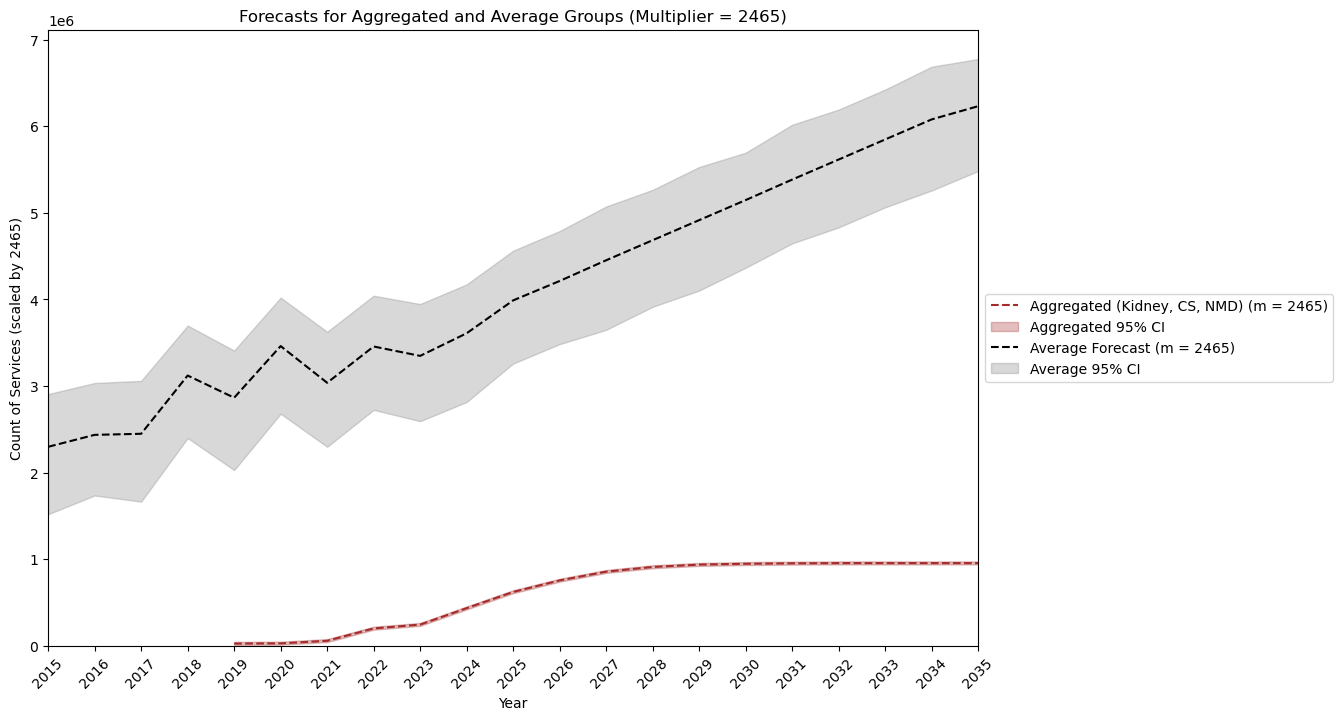

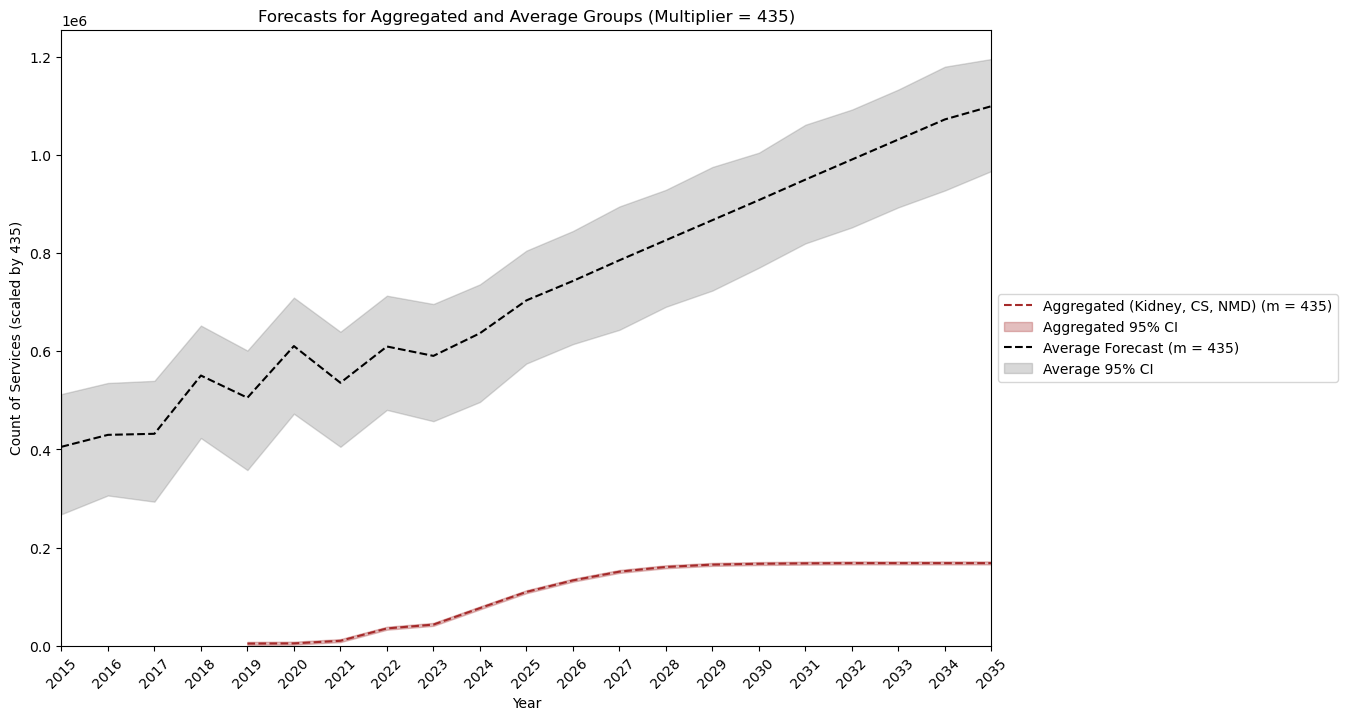

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

##########################
# Load and prepare the data
##########################
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

##########################
# Define groups and settings
##########################
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300']
}

color_map = {
    'CMA': 'red',
    'FMR1': 'blue'
}
agg_color = 'brown'  # color for aggregated secondary forecast

# Filter data for our items.
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

##########################
# Define model functions (Diffusion Models)
##########################
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

##########################
# Forecasting for each group
##########################
best_predictions = []
diffusion_models = {
    "Logistic Diffusion": logistic_diffusion,
    "Gompertz": gompertz,
    "Bass Diffusion": bass_diffusion
}

for group, items in group_definitions.items():
    # Resample using month-end frequency and smooth.
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('ME').sum().dropna()
    group_data = group_data.rolling(window=12, min_periods=1).mean()

    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Convert date index to decimal years (for fitting only).
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)

    # --- Diffusion Models ---
    for model_name, model_func in diffusion_models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # --- SARIMA Model for CMA and FMR1 only ---
    if group in ["CMA", "FMR1"]:
        try:
            sarima_model = SARIMAX(group_data, order=(1,1,1), seasonal_order=(1,1,1,12))
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.fittedvalues
            sarima_r2 = r2_score(group_data, sarima_pred)
            # Create forecast grid in whole years.
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years_sarima = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            forecast_index = pd.date_range(start=group_data.index[0],
                                           end=group_data.index[-1] + pd.DateOffset(years=10),
                                           freq='ME')
            sarima_forecast = sarima_fit.predict(start=group_data.index[0],
                                                 end=group_data.index[-1] + pd.DateOffset(years=10),
                                                 dynamic=False)
            sarima_forecast_interp = np.interp(forecast_years_sarima,
                                               forecast_index.year + (forecast_index.month - 1)/12.0,
                                               sarima_forecast.values)
            # Compute residuals for SARIMA using in-sample data.
            sarima_resid = group_data.values - sarima_pred
            results["SARIMA"] = {'r2': sarima_r2,
                                 'forecast_years': forecast_years_sarima,
                                 'forecast': sarima_forecast_interp,
                                 'residuals': sarima_resid}
        except Exception as e:
            print(f"Error fitting SARIMA for group {group}: {e}")

    # --- Select Best Model, Generate Forecast, and Compute Bootstrapped CIs ---
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        if best_model_name == "SARIMA":
            forecast_years = best_model_metrics['forecast_years']
            best_pred_full = best_model_metrics['forecast']
            residuals = best_model_metrics.get('residuals')
        else:
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
            residuals = group_data.values - best_model_metrics['func'](fitted_years, *best_model_metrics['params'])

        # Center the residuals before bootstrapping.
        resid_centered = residuals - np.mean(residuals)
        B = 500
        bootstrap_forecasts = np.zeros((B, len(forecast_years)))
        for b in range(B):
            boot_errors = np.random.choice(resid_centered, size=len(forecast_years), replace=True)
            bootstrap_forecasts[b, :] = best_pred_full + boot_errors
        ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
        ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

        # --- Round to whole numbers ---
        best_pred_full = np.rint(best_pred_full)
        ci_lower = np.rint(ci_lower)
        ci_upper = np.rint(ci_upper)

        entry = {
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full,
            'CI_lower': ci_lower,
            'CI_upper': ci_upper
        }
        # For secondary groups, also store in-sample info.
        if group in ["Kidney", "CS", "NMD"]:
            entry['InSampleYears'] = fitted_years
            fitted_in_sample = best_model_metrics['func'](fitted_years, *best_model_metrics['params'])
            entry['InSampleFitted'] = np.rint(fitted_in_sample)
            entry['InSampleObserved'] = np.rint(group_data.values)
        best_predictions.append(entry)

##########################
# Aggregated forecast for secondary groups (Kidney, CS, NMD)
##########################
secondary_preds = [bp for bp in best_predictions if bp['Group'] in ["Kidney", "CS", "NMD"]]
if secondary_preds:
    common_start = min(bp['Years'][0] for bp in secondary_preds)
    common_end = max(bp['Years'][-1] for bp in secondary_preds)
    common_time = np.arange(int(common_start), int(common_end) + 1, 1)

    aggregated_forecast = np.zeros_like(common_time, dtype=float)
    for bp in secondary_preds:
        aggregated_forecast += np.interp(common_time, bp['Years'], bp['Predicted'])
    # Compute aggregated in-sample residuals over the overlapping period.
    in_sample_starts = [bp['InSampleYears'][0] for bp in secondary_preds]
    in_sample_ends = [bp['InSampleYears'][-1] for bp in secondary_preds]
    common_in_start = max(in_sample_starts)
    common_in_end = min(in_sample_ends)
    common_in_time = np.arange(int(np.floor(common_in_start)), int(np.ceil(common_in_end)) + 1, 1)
    aggregated_residuals = np.zeros_like(common_in_time, dtype=float)
    for bp in secondary_preds:
        obs_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleObserved'])
        fit_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleFitted'])
        aggregated_residuals += (obs_interp - fit_interp)

    # Center aggregated residuals.
    aggregated_resid_centered = aggregated_residuals - np.mean(aggregated_residuals)
    B = 500
    bootstrap_forecasts = np.zeros((B, len(common_time)))
    for b in range(B):
        boot_errors = np.random.choice(aggregated_resid_centered, size=len(common_time), replace=True)
        bootstrap_forecasts[b, :] = aggregated_forecast + boot_errors
    agg_ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
    agg_ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

    # --- Round aggregated forecasts to whole numbers ---
    aggregated_forecast = np.rint(aggregated_forecast)
    agg_ci_lower = np.rint(agg_ci_lower)
    agg_ci_upper = np.rint(agg_ci_upper)

    aggregated_secondary_forecast = {
        'Group': 'Aggregated (Kidney, CS, NMD)',
        'BestModel': "Diffusion",
        'Years': common_time,
        'Predicted': aggregated_forecast,
        'CI_lower': agg_ci_lower,
        'CI_upper': agg_ci_upper
    }
else:
    aggregated_secondary_forecast = None

##########################
# Extract forecasts for CMA and FMR1 and compute their average from 2015 onward
##########################
primary_forecasts = {bp['Group']: bp for bp in best_predictions if bp['Group'] in ["CMA", "FMR1"]}
if "CMA" in primary_forecasts and "FMR1" in primary_forecasts:
    years_cma = primary_forecasts["CMA"]['Years']
    pred_cma = primary_forecasts["CMA"]['Predicted']
    years_fmr1 = primary_forecasts["FMR1"]['Years']
    pred_fmr1 = primary_forecasts["FMR1"]['Predicted']

    common_start_avg = max(years_cma[0], years_fmr1[0], 2015)
    common_end_avg = min(years_cma[-1], years_fmr1[-1])
    common_years_avg = np.arange(int(common_start_avg), int(common_end_avg) + 1, 1)

    # Interpolate the forecasts onto the common grid.
    interp_cma = np.interp(common_years_avg, years_cma, pred_cma)
    interp_fmr1 = np.interp(common_years_avg, years_fmr1, pred_fmr1)
    avg_forecast = (interp_cma + interp_fmr1) / 2

    # For bootstrapping, compute in-sample residuals for each primary forecast.
    resid_cma = primary_forecasts["CMA"].get('residuals', primary_forecasts["CMA"]['Predicted'][:len(interp_cma)] - interp_cma)
    resid_fmr1 = primary_forecasts["FMR1"].get('residuals', primary_forecasts["FMR1"]['Predicted'][:len(interp_fmr1)] - interp_fmr1)
    # Center each set of residuals.
    resid_cma_centered = resid_cma - np.mean(resid_cma)
    resid_fmr1_centered = resid_fmr1 - np.mean(resid_fmr1)
    B = 500
    bootstrap_avg = np.zeros((B, len(common_years_avg)))
    for b in range(B):
        boot_error_cma = np.random.choice(resid_cma_centered, size=len(common_years_avg), replace=True)
        boot_error_fmr1 = np.random.choice(resid_fmr1_centered, size=len(common_years_avg), replace=True)
        boot_forecast_cma = interp_cma + boot_error_cma
        boot_forecast_fmr1 = interp_fmr1 + boot_error_fmr1
        bootstrap_avg[b, :] = (boot_forecast_cma + boot_forecast_fmr1) / 2
    avg_ci_lower = np.percentile(bootstrap_avg, 2.5, axis=0)
    avg_ci_upper = np.percentile(bootstrap_avg, 97.5, axis=0)

    # --- Round average forecasts to whole numbers ---
    avg_forecast = np.rint(avg_forecast)
    avg_ci_lower = np.rint(avg_ci_lower)
    avg_ci_upper = np.rint(avg_ci_upper)
else:
    raise ValueError("Forecasts for both CMA and FMR1 are required for averaging.")

##########################
# (Optional) Plotting the original forecasts (unscaled)
##########################
fig, ax = plt.subplots(figsize=(12, 8))
if aggregated_secondary_forecast is not None:
    ax.plot(aggregated_secondary_forecast['Years'], aggregated_secondary_forecast['Predicted'],
            linestyle='--', color=agg_color,
            label=f"{aggregated_secondary_forecast['Group']} ({aggregated_secondary_forecast['BestModel']})")
    ax.fill_between(aggregated_secondary_forecast['Years'],
                    aggregated_secondary_forecast['CI_lower'],
                    aggregated_secondary_forecast['CI_upper'],
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")
ax.plot(common_years_avg, avg_forecast, linestyle='--', color='black', linewidth=1.5, label="Average Forecast")
ax.fill_between(common_years_avg, avg_ci_lower, avg_ci_upper,
                color='gray', alpha=0.3, label="Average 95% CI")
global_start = min(common_years_avg[0],
                   aggregated_secondary_forecast['Years'][0] if aggregated_secondary_forecast is not None else common_years_avg[0])
global_end = max(common_years_avg[-1],
                 aggregated_secondary_forecast['Years'][-1] if aggregated_secondary_forecast is not None else common_years_avg[-1])
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
ax.set_title("Forecasts with 95% Bootstrapped Confidence Intervals (Unscaled)")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()  # Uncomment to display the unscaled plot

##########################
# Generate table for Aggregated and Average Groups, scaled by each multiplier
##########################
# Multipliers now include unscaled (1) and 501.415 in addition to the previous ones.
multipliers = [1, 501.415, 2900, 2465, 435]
agg_group_name = 'Aggregated (Kidney, CS, NMD)'
avg_group_name = 'Average (CMA & FMR1)'
years_range = sorted(list(set(range(2025, 2036))))
table_data = {}

for year in years_range:
    row = {}
    # Process Aggregated Group.
    if aggregated_secondary_forecast is not None and year in aggregated_secondary_forecast['Years']:
        idx = np.where(aggregated_secondary_forecast['Years'] == year)[0][0]
        pred_val = aggregated_secondary_forecast['Predicted'][idx]
        ci_lower_val = aggregated_secondary_forecast['CI_lower'][idx]
        ci_upper_val = aggregated_secondary_forecast['CI_upper'][idx]
        for m in multipliers:
            if m == 1:
                col_name = f"{agg_group_name}_Unscaled"
            else:
                col_name = f"{agg_group_name}_{m}"
            # Multiply and convert to whole numbers.
            row[col_name] = f"{int(round(pred_val * m))} ({int(round(ci_lower_val * m))}, {int(round(ci_upper_val * m))})"
        # New column: Sum of multiplier 2465 and 501.415 for Aggregated group.
        sum_val = pred_val * 2465 + pred_val * 501.415
        sum_lower = ci_lower_val * 2465 + ci_lower_val * 501.415
        sum_upper = ci_upper_val * 2465 + ci_upper_val * 501.415
        row[f"{agg_group_name}_2465+501.415"] = f"{int(round(sum_val))} ({int(round(sum_lower))}, {int(round(sum_upper))})"
    else:
        for m in multipliers:
            if m == 1:
                col_name = f"{agg_group_name}_Unscaled"
            else:
                col_name = f"{agg_group_name}_{m}"
            row[col_name] = ""
        row[f"{agg_group_name}_2465+501.415"] = ""
    
    # Process Average Group.
    if year in common_years_avg:
        idx = np.where(common_years_avg == year)[0][0]
        pred_val = avg_forecast[idx]
        ci_lower_val = avg_ci_lower[idx]
        ci_upper_val = avg_ci_upper[idx]
        for m in multipliers:
            if m == 1:
                col_name = f"{avg_group_name}_Unscaled"
            else:
                col_name = f"{avg_group_name}_{m}"
            row[col_name] = f"{int(round(pred_val * m))} ({int(round(ci_lower_val * m))}, {int(round(ci_upper_val * m))})"
        # New column: Sum of multiplier 501.415 and 2465 for Average group.
        sum_val = pred_val * 501.415 + pred_val * 2465
        sum_lower = ci_lower_val * 501.415 + ci_lower_val * 2465
        sum_upper = ci_upper_val * 501.415 + ci_upper_val * 2465
        row[f"{avg_group_name}_501.415+2465"] = f"{int(round(sum_val))} ({int(round(sum_lower))}, {int(round(sum_upper))})"
    else:
        for m in multipliers:
            if m == 1:
                col_name = f"{avg_group_name}_Unscaled"
            else:
                col_name = f"{avg_group_name}_{m}"
            row[col_name] = ""
        row[f"{avg_group_name}_501.415+2465"] = ""
    
    table_data[year] = row

df_final = pd.DataFrame.from_dict(table_data, orient='index')
df_final.index.name = 'Year'
print(df_final)

##########################
# Create separate plots for:
# 1. Unscaled forecasts (m = 1)
# 2. Forecasts scaled with multiplier 501.415
# 3. Plots for the original multipliers: 2900, 2465, and 435
##########################

# 1. Unscaled Plot (m = 1)
m = 1
fig, ax = plt.subplots(figsize=(12, 8))
if aggregated_secondary_forecast is not None:
    years_agg = aggregated_secondary_forecast['Years']
    agg_pred_scaled = np.rint(aggregated_secondary_forecast['Predicted'] * m)
    agg_ci_lower_scaled = np.rint(aggregated_secondary_forecast['CI_lower'] * m)
    agg_ci_upper_scaled = np.rint(aggregated_secondary_forecast['CI_upper'] * m)
    ax.plot(years_agg, agg_pred_scaled, linestyle='--', color=agg_color,
            label=f"{agg_group_name} (Unscaled)")
    ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled,
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")
avg_pred_scaled = np.rint(avg_forecast * m)
avg_ci_lower_scaled = np.rint(avg_ci_lower * m)
avg_ci_upper_scaled = np.rint(avg_ci_upper * m)
ax.plot(common_years_avg, avg_pred_scaled, linestyle='--', color='black', linewidth=1.5,
        label="Average Forecast (Unscaled)")
ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled,
                color='gray', alpha=0.3, label="Average 95% CI")
if aggregated_secondary_forecast is not None:
    global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0])
    global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1])
else:
    global_start = common_years_avg[0]
    global_end = common_years_avg[-1]
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services (Unscaled)")
#ax.set_title("Forecasts for Aggregated and Average Groups (Unscaled)")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 2. Plot with multiplier 501.415
m = 501.415
fig, ax = plt.subplots(figsize=(12, 8))
if aggregated_secondary_forecast is not None:
    years_agg = aggregated_secondary_forecast['Years']
    agg_pred_scaled = np.rint(aggregated_secondary_forecast['Predicted'] * m)
    agg_ci_lower_scaled = np.rint(aggregated_secondary_forecast['CI_lower'] * m)
    agg_ci_upper_scaled = np.rint(aggregated_secondary_forecast['CI_upper'] * m)
    ax.plot(years_agg, agg_pred_scaled, linestyle='--', color=agg_color,
            label=f"{agg_group_name} (m = {m})")
    ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled,
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")
avg_pred_scaled = np.rint(avg_forecast * m)
avg_ci_lower_scaled = np.rint(avg_ci_lower * m)
avg_ci_upper_scaled = np.rint(avg_ci_upper * m)
ax.plot(common_years_avg, avg_pred_scaled, linestyle='--', color='black', linewidth=1.5,
        label=f"Average Forecast (m = {m})")
ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled,
                color='gray', alpha=0.3, label="Average 95% CI")
if aggregated_secondary_forecast is not None:
    global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0])
    global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1])
else:
    global_start = common_years_avg[0]
    global_end = common_years_avg[-1]
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel(f"Count of Services (scaled by {m})")
ax.set_title(f"Forecasts for Aggregated and Average Groups (Multiplier = {m})")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 3. Plots for the original multipliers: 2900, 2465, and 435
for m in [2900, 2465, 435]:
    fig, ax = plt.subplots(figsize=(12, 8))
    if aggregated_secondary_forecast is not None:
        years_agg = aggregated_secondary_forecast['Years']
        agg_pred_scaled = np.rint(aggregated_secondary_forecast['Predicted'] * m)
        agg_ci_lower_scaled = np.rint(aggregated_secondary_forecast['CI_lower'] * m)
        agg_ci_upper_scaled = np.rint(aggregated_secondary_forecast['CI_upper'] * m)
        ax.plot(years_agg, agg_pred_scaled, linestyle='--', color=agg_color,
                label=f"{agg_group_name} (m = {m})")
        ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled,
                        color=agg_color, alpha=0.3, label="Aggregated 95% CI")
    avg_pred_scaled = np.rint(avg_forecast * m)
    avg_ci_lower_scaled = np.rint(avg_ci_lower * m)
    avg_ci_upper_scaled = np.rint(avg_ci_upper * m)
    ax.plot(common_years_avg, avg_pred_scaled, linestyle='--', color='black', linewidth=1.5,
            label=f"Average Forecast (m = {m})")
    ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled,
                    color='gray', alpha=0.3, label="Average 95% CI")
    if aggregated_secondary_forecast is not None:
        global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0])
        global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1])
    else:
        global_start = common_years_avg[0]
        global_end = common_years_avg[-1]
    ax.set_xlim(global_start, global_end)
    ax.set_ylim(bottom=0)
    ax.set_xlabel("Year")
    ax.set_ylabel(f"Count of Services (scaled by {m})")
    ax.set_title(f"Forecasts for Aggregated and Average Groups (Multiplier = {m})")
    ax.set_xticks(np.arange(global_start, global_end + 1, 1))
    ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


In [2]:
df_final

Aggregated (Kidney, CS, NMD)_Unscaled  \
Year                                         
2025                        252 (246, 260)   
2026                        306 (300, 314)   
2027                        347 (341, 355)   
2028                        369 (363, 377)   
2029                        380 (374, 388)   
2030                        384 (378, 392)   
2031                        386 (380, 394)   
2032                        387 (381, 395)   
2033                        387 (381, 395)   
2034                        387 (381, 395)   
2035                        387 (381, 395)   

     Aggregated (Kidney, CS, NMD)_501.415 Aggregated (Kidney, CS, NMD)_2900  \
Year                                                                          
2025              126357 (123348, 130368)           730800 (713400, 754000)   
2026              153433 (150424, 157444)           887400 (870000, 910600)   
2027              173991 (170983, 178002)         1006300 (988900, 1029500)   
2028              185022 (182014, 189033)        1070100 (1052700, 1093300)   
2029              190538 (187529, 194549)        1102000 (1084600, 1125200)   
2030              192543 (189535, 196555)        1113600 (1096200, 1136800)   
2031              193546 (190538, 197558)        1119400 (1102000, 1142600)   
2032              194048 (191039, 198059)        1122300 (1104900, 1145500)   
2033              194048 (191039, 198059)        1122300 (1104900, 1145500)   
2034              194048 (191039, 198059)        1122300 (1104900, 1145500)   
2035              194048 (191039, 198059)        1122300 (1104900, 1145500)   

     Aggregated (Kidney, CS, NMD)_2465 Aggregated (Kidney, CS, NMD)_435  \
Year                                                                      
2025           621180 (606390, 640900)          109620 (107010, 113100)   
2026           754290 (739500, 774010)          133110 (130500, 136590)   
2027           855355 (840565, 875075)          150945 (148335, 154425)   
2028           909585 (894795, 929305)          160515 (157905, 163995)   
2029           936700 (921910, 956420)          165300 (162690, 168780)   
2030           946560 (931770, 966280)          167040 (164430, 170520)   
2031           951490 (936700, 971210)          167910 (165300, 171390)   
2032           953955 (939165, 973675)          168345 (165735, 171825)   
2033           953955 (939165, 973675)          168345 (165735, 171825)   
2034           953955 (939165, 973675)          168345 (165735, 171825)   
2035           953955 (939165, 973675)          168345 (165735, 171825)   

     Aggregated (Kidney, CS, NMD)_2465+501.415 Average (CMA & FMR1)_Unscaled  \
Year                                                                           
2025                   747537 (729738, 771268)             1618 (1293, 1861)   
2026                   907723 (889924, 931454)             1709 (1375, 1955)   
2027                1029346 (1011548, 1053077)             1806 (1488, 2049)   
2028                1094607 (1076809, 1118338)             1900 (1650, 2149)   
2029                1127238 (1109439, 1150969)             1994 (1663, 2237)   
2030                1139103 (1121305, 1162835)             2088 (1810, 2338)   
2031                1145036 (1127238, 1168768)             2184 (1872, 2422)   
2032                1148003 (1130204, 1171734)             2278 (1949, 2514)   
2033                1148003 (1130204, 1171734)             2372 (2069, 2600)   
2034                1148003 (1130204, 1171734)             2466 (2141, 2724)   
2035                1148003 (1130204, 1171734)             2528 (2240, 2749)   

     Average (CMA & FMR1)_501.415   Average (CMA & FMR1)_2900  \
Year                                                            
2025      811289 (648330, 933133)  4692200 (3749700, 5396900)   
2026      856918 (689446, 980266)  4956100 (3987500, 5669500)   
2027     905555 (746106, 1027399)  5237400 (4315200, 5942100)   
2028     952688 (827335, 1077541)  5

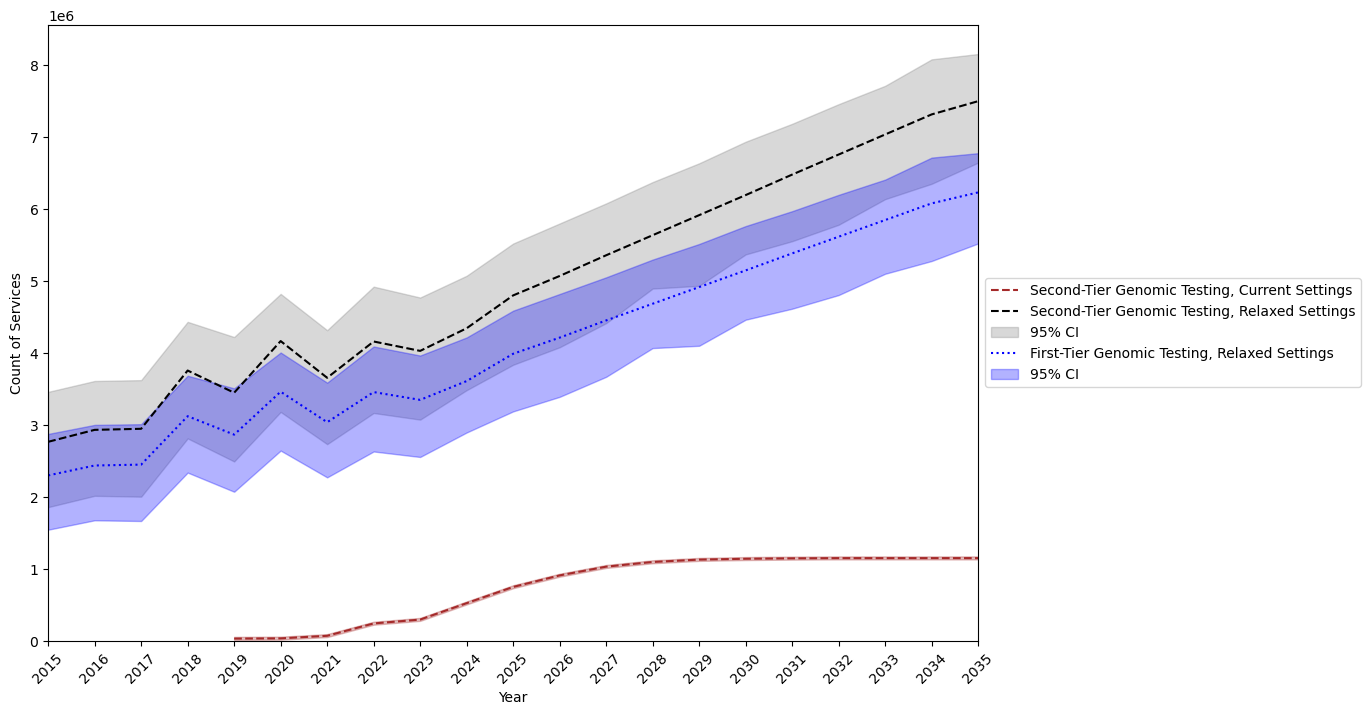

In [6]:
# Define the multipliers for the new graph.
multiplier_agg = 2465 + 501.415       # For the aggregated forecast.
multiplier_avg_sum = 2465 + 501.415     # For the first version of the average forecast.
multiplier_avg = 2465                 # For the second version of the average forecast.

fig, ax = plt.subplots(figsize=(12, 8))

# Plot Aggregated Forecast (scaled by 2465+501.415)
if aggregated_secondary_forecast is not None:
    years_agg = aggregated_secondary_forecast['Years']
    agg_pred_scaled = np.rint(aggregated_secondary_forecast['Predicted'] * multiplier_agg)
    agg_ci_lower_scaled = np.rint(aggregated_secondary_forecast['CI_lower'] * multiplier_agg)
    agg_ci_upper_scaled = np.rint(aggregated_secondary_forecast['CI_upper'] * multiplier_agg)
    ax.plot(years_agg, agg_pred_scaled, linestyle='--', color='brown',
            label="Second-Tier Genomic Testing, Current Settings")
    ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled,
                    color='brown', alpha=0.3)

# Plot Average Forecast with multiplier = 2465+501.415
avg_pred_scaled_sum = np.rint(avg_forecast * multiplier_avg_sum)
avg_ci_lower_scaled_sum = np.rint(avg_ci_lower * multiplier_avg_sum)
avg_ci_upper_scaled_sum = np.rint(avg_ci_upper * multiplier_avg_sum)
ax.plot(common_years_avg, avg_pred_scaled_sum, linestyle='--', color='black',
        label="Second-Tier Genomic Testing, Relaxed Settings")
ax.fill_between(common_years_avg, avg_ci_lower_scaled_sum, avg_ci_upper_scaled_sum,
                color='gray', alpha=0.3, label="95% CI")

# Plot Average Forecast with multiplier = 2465
avg_pred_scaled = np.rint(avg_forecast * multiplier_avg)
avg_ci_lower_scaled = np.rint(avg_ci_lower * multiplier_avg)
avg_ci_upper_scaled = np.rint(avg_ci_upper * multiplier_avg)
ax.plot(common_years_avg, avg_pred_scaled, linestyle=':', color='blue',
        label="First-Tier Genomic Testing, Relaxed Settings")
ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled,
                color='blue', alpha=0.3, label="95% CI")

# Determine global x-axis limits based on the available data.
global_start = min(common_years_avg[0],
                   aggregated_secondary_forecast['Years'][0] if aggregated_secondary_forecast is not None else common_years_avg[0])
global_end = max(common_years_avg[-1],
                 aggregated_secondary_forecast['Years'][-1] if aggregated_secondary_forecast is not None else common_years_avg[-1])
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
#ax.set_title("Aggregated and Average Forecasts with Alternative Multipliers")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
